##### Copyright 2018 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
# Copyright 2018 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# How to solve a problem on Kaggle with TF-Hub


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/hub/tutorials/text_classification_with_tf_hub_on_kaggle"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/text_classification_with_tf_hub_on_kaggle.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/hub/blob/master/examples/colab/text_classification_with_tf_hub_on_kaggle.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/hub/examples/colab/text_classification_with_tf_hub_on_kaggle.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/nnlm-en-dim128/1"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

TF-Hub is a platform to share machine learning expertise packaged in reusable resources, notably pre-trained **modules**. In this tutorial, we will use a TF-Hub text embedding module to train a simple sentiment classifier with a reasonable baseline accuracy. We will then submit the predictions to Kaggle.

For more detailed tutorial on text classification with TF-Hub and further steps for improving the accuracy, take a look at [Text classification with TF-Hub](https://colab.research.google.com/github/tensorflow/hub/blob/master/docs/tutorials/text_classification_with_tf_hub.ipynb).

## Setup

In [2]:
!pip install -q kaggle

In [3]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import zipfile

from sklearn import model_selection

Since this tutorial will be using a dataset from Kaggle, it requires [creating an API Token](https://github.com/Kaggle/kaggle-api) for your Kaggle account, and uploading it to the Colab environment.

In [4]:
import os
import pathlib

# Upload the API token.
def get_kaggle():
  try:
    import kaggle
    return kaggle
  except OSError:
    pass

  token_file = pathlib.Path("~/.kaggle/kaggle.json").expanduser()
  token_file.parent.mkdir(exist_ok=True, parents=True)

  try:
    from google.colab import files
  except ImportError:
    raise ValueError("Could not find kaggle token.")

  uploaded = files.upload()
  token_content = uploaded.get('kaggle.json', None)
  if token_content:
    token_file.write_bytes(token_content)
    token_file.chmod(0o600)
  else:
    raise ValueError('Need a file named "kaggle.json"')
  
  import kaggle
  return kaggle


kaggle = get_kaggle()

# Getting started

## Data
We will try to solve the [Sentiment Analysis on Movie Reviews](https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews/data) task from Kaggle. The dataset consists of syntactic subphrases of the Rotten Tomatoes movie reviews. The task is to label the phrases as **negative** or **positive** on the scale from 1 to 5.

You must [accept the competition rules](https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews/data) before you can use the API to download the data.


In [5]:
SENTIMENT_LABELS = [
    "negative", "somewhat negative", "neutral", "somewhat positive", "positive"
]

# Add a column with readable values representing the sentiment.
def add_readable_labels_column(df, sentiment_value_column):
  df["SentimentLabel"] = df[sentiment_value_column].replace(
      range(5), SENTIMENT_LABELS)
    
# Download data from Kaggle and create a DataFrame.
def load_data_from_zip(path):
  with zipfile.ZipFile(path, "r") as zip_ref:
    name = zip_ref.namelist()[0]
    with zip_ref.open(name) as zf:
      return pd.read_csv(zf, sep="\t", index_col=0)


# The data does not come with a validation set so we'll create one from the
# training set.
def get_data(competition, train_file, test_file, validation_set_ratio=0.1):
  data_path = pathlib.Path("data")
  kaggle.api.competition_download_files(competition, data_path)
  competition_path = (data_path/competition)
  competition_path.mkdir(exist_ok=True, parents=True)
  competition_zip_path = competition_path.with_suffix(".zip")

  with zipfile.ZipFile(competition_zip_path, "r") as zip_ref:
    zip_ref.extractall(competition_path)
  
  train_df = load_data_from_zip(competition_path/train_file)
  test_df = load_data_from_zip(competition_path/test_file)

  # Add a human readable label.
  add_readable_labels_column(train_df, "Sentiment")

  # We split by sentence ids, because we don't want to have phrases belonging
  # to the same sentence in both training and validation set.
  train_indices, validation_indices = model_selection.train_test_split(
      np.unique(train_df["SentenceId"]),
      test_size=validation_set_ratio,
      random_state=0)

  validation_df = train_df[train_df["SentenceId"].isin(validation_indices)]
  train_df = train_df[train_df["SentenceId"].isin(train_indices)]
  print("Split the training data into %d training and %d validation examples." %
        (len(train_df), len(validation_df)))

  return train_df, validation_df, test_df


train_df, validation_df, test_df = get_data(
    "sentiment-analysis-on-movie-reviews",
    "train.tsv.zip", "test.tsv.zip")

Split the training data into 140315 training and 15745 validation examples.


Note: In this competition the task is not to rate entire reviews, but individual phrases from within the reviews. This is a much harder task.

In [6]:
train_df.head(20)

,SentenceId,Phrase,Sentiment,SentimentLabel
PhraseId,,,,
1,1,A series of escapades demonstrating the adage ...,1,somewhat negative
2,1,A series of escapades demonstrating the adage ...,2,neutral
3,1,A series,2,neutral
4,1,A,2,neutral
5,1,series,2,neutral
6,1,of escapades demonstrating the adage that what...,2,neutral
7,1,of,2,neutral
8,1,escapades demonstrating the adage that what is...,2,neutral
9,1,escapades,2,neutral


## Training an Model

*Note: We could model this task also as a regression, see [Text classification with TF-Hub](https://colab.research.google.com/github/tensorflow/hub/blob/master/docs/tutorials/text_classification_with_tf_hub.ipynb).*

In [7]:
class MyModel(tf.keras.Model):
  def __init__(self, hub_url):
    super().__init__()
    self.hub_url = hub_url
    self.embed = hub.load(self.hub_url).signatures['default']
    self.sequential = tf.keras.Sequential([
      tf.keras.layers.Dense(500),
      tf.keras.layers.Dense(100),
      tf.keras.layers.Dense(5),
    ])

  def call(self, inputs):
    phrases = inputs['Phrase'][:,0]
    embedding = 5*self.embed(phrases)['default']
    return self.sequential(embedding)

  def get_config(self):
    return {"hub_url":self.hub_url}

In [8]:
model = MyModel("https://tfhub.dev/google/nnlm-en-dim128/1")
model.compile(
    loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.optimizers.Adam(), 
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")])

In [9]:
history = model.fit(x=dict(train_df), y=train_df['Sentiment'],
          validation_data=(dict(validation_df), validation_df['Sentiment']),
          epochs = 25)

Epoch 1/25


   1/4385 [..............................] - ETA: 52:09 - loss: 1.5993 - accuracy: 0.3125

  21/4385 [..............................] - ETA: 11s - loss: 1.5179 - accuracy: 0.4211  

  41/4385 [..............................] - ETA: 11s - loss: 1.4283 - accuracy: 0.4466

  62/4385 [..............................] - ETA: 10s - loss: 1.3741 - accuracy: 0.4632

  84/4385 [..............................] - ETA: 10s - loss: 1.3179 - accuracy: 0.4870

 106/4385 [..............................] - ETA: 10s - loss: 1.2772 - accuracy: 0.5000

 127/4385 [..............................] - ETA: 10s - loss: 1.2560 - accuracy: 0.5042

 148/4385 [>.............................] - ETA: 10s - loss: 1.2378 - accuracy: 0.5093

 168/4385 [>.............................] - ETA: 10s - loss: 1.2178 - accuracy: 0.5175

 189/4385 [>.............................] - ETA: 10s - loss: 1.2069 - accuracy: 0.5222

 210/4385 [>.............................] - ETA: 10s - loss: 1.1966 - accuracy: 0.5259

 231/4385 [>.............................] - ETA: 10s - loss: 1.1865 - accuracy: 0.5298

 253/4385 [>.............................] - ETA: 10s - loss: 1.1812 - accuracy: 0.5324

 274/4385 [>.............................] - ETA: 10s - loss: 1.1718 - accuracy: 0.5347

 295/4385 [=>............................] - ETA: 9s - loss: 1.1660 - accuracy: 0.5378 

 316/4385 [=>............................] - ETA: 9s - loss: 1.1587 - accuracy: 0.5399

 338/4385 [=>............................] - ETA: 9s - loss: 1.1493 - accuracy: 0.5431

 359/4385 [=>............................] - ETA: 9s - loss: 1.1431 - accuracy: 0.5454

 381/4385 [=>............................] - ETA: 9s - loss: 1.1399 - accuracy: 0.5466

 401/4385 [=>............................] - ETA: 9s - loss: 1.1352 - accuracy: 0.5486

 421/4385 [=>............................] - ETA: 9s - loss: 1.1296 - accuracy: 0.5508

 441/4385 [==>...........................] - ETA: 9s - loss: 1.1283 - accuracy: 0.5524

 461/4385 [==>...........................] - ETA: 9s - loss: 1.1290 - accuracy: 0.5519

 481/4385 [==>...........................] - ETA: 9s - loss: 1.1245 - accuracy: 0.5534

 501/4385 [==>...........................] - ETA: 9s - loss: 1.1196 - accuracy: 0.5546

 521/4385 [==>...........................] - ETA: 9s - loss: 1.1171 - accuracy: 0.5553

 541/4385 [==>...........................] - ETA: 9s - loss: 1.1145 - accuracy: 0.5558

 561/4385 [==>...........................] - ETA: 9s - loss: 1.1121 - accuracy: 0.5563

 581/4385 [==>...........................] - ETA: 9s - loss: 1.1076 - accuracy: 0.5586

 601/4385 [===>..........................] - ETA: 9s - loss: 1.1056 - accuracy: 0.5598

 621/4385 [===>..........................] - ETA: 9s - loss: 1.1026 - accuracy: 0.5604

 641/4385 [===>..........................] - ETA: 9s - loss: 1.1013 - accuracy: 0.5605

 661/4385 [===>..........................] - ETA: 9s - loss: 1.1006 - accuracy: 0.5604

 681/4385 [===>..........................] - ETA: 9s - loss: 1.0995 - accuracy: 0.5609

 701/4385 [===>..........................] - ETA: 9s - loss: 1.0971 - accuracy: 0.5615

 721/4385 [===>..........................] - ETA: 9s - loss: 1.0945 - accuracy: 0.5622

 741/4385 [====>.........................] - ETA: 9s - loss: 1.0939 - accuracy: 0.5620

 761/4385 [====>.........................] - ETA: 9s - loss: 1.0927 - accuracy: 0.5628

 781/4385 [====>.........................] - ETA: 9s - loss: 1.0904 - accuracy: 0.5635

 801/4385 [====>.........................] - ETA: 8s - loss: 1.0878 - accuracy: 0.5636

 821/4385 [====>.........................] - ETA: 8s - loss: 1.0871 - accuracy: 0.5641

 841/4385 [====>.........................] - ETA: 8s - loss: 1.0859 - accuracy: 0.5648

 861/4385 [====>.........................] - ETA: 8s - loss: 1.0835 - accuracy: 0.5658

 881/4385 [=====>........................] - ETA: 8s - loss: 1.0825 - accuracy: 0.5664

 901/4385 [=====>........................] - ETA: 8s - loss: 1.0820 - accuracy: 0.5662

 921/4385 [=====>........................] - ETA: 8s - loss: 1.0805 - accuracy: 0.5673

 941/4385 [=====>........................] - ETA: 8s - loss: 1.0780 - accuracy: 0.5685

 960/4385 [=====>........................] - ETA: 8s - loss: 1.0769 - accuracy: 0.5685

 980/4385 [=====>........................] - ETA: 8s - loss: 1.0761 - accuracy: 0.5688

1000/4385 [=====>........................] - ETA: 8s - loss: 1.0746 - accuracy: 0.5697

1020/4385 [=====>........................] - ETA: 8s - loss: 1.0738 - accuracy: 0.5702

1040/4385 [======>.......................] - ETA: 8s - loss: 1.0724 - accuracy: 0.5706

1060/4385 [======>.......................] - ETA: 8s - loss: 1.0718 - accuracy: 0.5705

1080/4385 [======>.......................] - ETA: 8s - loss: 1.0707 - accuracy: 0.5708

1100/4385 [======>.......................] - ETA: 8s - loss: 1.0692 - accuracy: 0.5711

1120/4385 [======>.......................] - ETA: 8s - loss: 1.0695 - accuracy: 0.5707

1140/4385 [======>.......................] - ETA: 8s - loss: 1.0691 - accuracy: 0.5709

1160/4385 [======>.......................] - ETA: 8s - loss: 1.0675 - accuracy: 0.5718

1180/4385 [=======>......................] - ETA: 8s - loss: 1.0661 - accuracy: 0.5724

1200/4385 [=======>......................] - ETA: 8s - loss: 1.0655 - accuracy: 0.5725

1219/4385 [=======>......................] - ETA: 8s - loss: 1.0646 - accuracy: 0.5725

1239/4385 [=======>......................] - ETA: 7s - loss: 1.0641 - accuracy: 0.5729

1259/4385 [=======>......................] - ETA: 7s - loss: 1.0637 - accuracy: 0.5730

1279/4385 [=======>......................] - ETA: 7s - loss: 1.0634 - accuracy: 0.5733

1299/4385 [=======>......................] - ETA: 7s - loss: 1.0626 - accuracy: 0.5739

1319/4385 [========>.....................] - ETA: 7s - loss: 1.0618 - accuracy: 0.5737

1339/4385 [========>.....................] - ETA: 7s - loss: 1.0611 - accuracy: 0.5738

1358/4385 [========>.....................] - ETA: 7s - loss: 1.0607 - accuracy: 0.5737

1377/4385 [========>.....................] - ETA: 7s - loss: 1.0601 - accuracy: 0.5737

1397/4385 [========>.....................] - ETA: 7s - loss: 1.0599 - accuracy: 0.5740

1417/4385 [========>.....................] - ETA: 7s - loss: 1.0594 - accuracy: 0.5741

1437/4385 [========>.....................] - ETA: 7s - loss: 1.0592 - accuracy: 0.5742

1457/4385 [========>.....................] - ETA: 7s - loss: 1.0585 - accuracy: 0.5745

1477/4385 [=========>....................] - ETA: 7s - loss: 1.0580 - accuracy: 0.5746

1497/4385 [=========>....................] - ETA: 7s - loss: 1.0574 - accuracy: 0.5750

1517/4385 [=========>....................] - ETA: 7s - loss: 1.0565 - accuracy: 0.5754

1537/4385 [=========>....................] - ETA: 7s - loss: 1.0555 - accuracy: 0.5757

1557/4385 [=========>....................] - ETA: 7s - loss: 1.0558 - accuracy: 0.5754

1577/4385 [=========>....................] - ETA: 7s - loss: 1.0558 - accuracy: 0.5753

1597/4385 [=========>....................] - ETA: 7s - loss: 1.0549 - accuracy: 0.5758

1617/4385 [==========>...................] - ETA: 7s - loss: 1.0545 - accuracy: 0.5760

1637/4385 [==========>...................] - ETA: 6s - loss: 1.0543 - accuracy: 0.5762

1657/4385 [==========>...................] - ETA: 6s - loss: 1.0536 - accuracy: 0.5764

1677/4385 [==========>...................] - ETA: 6s - loss: 1.0522 - accuracy: 0.5771

1697/4385 [==========>...................] - ETA: 6s - loss: 1.0517 - accuracy: 0.5773

1717/4385 [==========>...................] - ETA: 6s - loss: 1.0513 - accuracy: 0.5774

1737/4385 [==========>...................] - ETA: 6s - loss: 1.0510 - accuracy: 0.5776

1757/4385 [===========>..................] - ETA: 6s - loss: 1.0494 - accuracy: 0.5783

1777/4385 [===========>..................] - ETA: 6s - loss: 1.0496 - accuracy: 0.5785

1797/4385 [===========>..................] - ETA: 6s - loss: 1.0487 - accuracy: 0.5787

1817/4385 [===========>..................] - ETA: 6s - loss: 1.0487 - accuracy: 0.5789

1837/4385 [===========>..................] - ETA: 6s - loss: 1.0481 - accuracy: 0.5793

1857/4385 [===========>..................] - ETA: 6s - loss: 1.0477 - accuracy: 0.5793

1876/4385 [===========>..................] - ETA: 6s - loss: 1.0467 - accuracy: 0.5798

1895/4385 [===========>..................] - ETA: 6s - loss: 1.0465 - accuracy: 0.5798

1915/4385 [============>.................] - ETA: 6s - loss: 1.0462 - accuracy: 0.5798

1935/4385 [============>.................] - ETA: 6s - loss: 1.0458 - accuracy: 0.5798

1955/4385 [============>.................] - ETA: 6s - loss: 1.0454 - accuracy: 0.5799

1975/4385 [============>.................] - ETA: 6s - loss: 1.0451 - accuracy: 0.5799

1995/4385 [============>.................] - ETA: 6s - loss: 1.0447 - accuracy: 0.5800

2015/4385 [============>.................] - ETA: 6s - loss: 1.0450 - accuracy: 0.5800

2035/4385 [============>.................] - ETA: 6s - loss: 1.0452 - accuracy: 0.5801

2055/4385 [=============>................] - ETA: 5s - loss: 1.0457 - accuracy: 0.5798

2075/4385 [=============>................] - ETA: 5s - loss: 1.0453 - accuracy: 0.5799

2095/4385 [=============>................] - ETA: 5s - loss: 1.0447 - accuracy: 0.5800

2115/4385 [=============>................] - ETA: 5s - loss: 1.0438 - accuracy: 0.5803

2135/4385 [=============>................] - ETA: 5s - loss: 1.0434 - accuracy: 0.5806

2155/4385 [=============>................] - ETA: 5s - loss: 1.0429 - accuracy: 0.5809

2175/4385 [=============>................] - ETA: 5s - loss: 1.0427 - accuracy: 0.5809

2195/4385 [==============>...............] - ETA: 5s - loss: 1.0426 - accuracy: 0.5807

2215/4385 [==============>...............] - ETA: 5s - loss: 1.0422 - accuracy: 0.5807

2235/4385 [==============>...............] - ETA: 5s - loss: 1.0420 - accuracy: 0.5807

2255/4385 [==============>...............] - ETA: 5s - loss: 1.0415 - accuracy: 0.5809

2275/4385 [==============>...............] - ETA: 5s - loss: 1.0411 - accuracy: 0.5809

2295/4385 [==============>...............] - ETA: 5s - loss: 1.0410 - accuracy: 0.5811

2316/4385 [==============>...............] - ETA: 5s - loss: 1.0405 - accuracy: 0.5812

2336/4385 [==============>...............] - ETA: 5s - loss: 1.0403 - accuracy: 0.5814

2355/4385 [===============>..............] - ETA: 5s - loss: 1.0401 - accuracy: 0.5814

2375/4385 [===============>..............] - ETA: 5s - loss: 1.0399 - accuracy: 0.5814

2395/4385 [===============>..............] - ETA: 5s - loss: 1.0393 - accuracy: 0.5816

2415/4385 [===============>..............] - ETA: 5s - loss: 1.0390 - accuracy: 0.5817

2435/4385 [===============>..............] - ETA: 4s - loss: 1.0391 - accuracy: 0.5818

2455/4385 [===============>..............] - ETA: 4s - loss: 1.0382 - accuracy: 0.5822

2475/4385 [===============>..............] - ETA: 4s - loss: 1.0374 - accuracy: 0.5824

2495/4385 [================>.............] - ETA: 4s - loss: 1.0374 - accuracy: 0.5826

2515/4385 [================>.............] - ETA: 4s - loss: 1.0369 - accuracy: 0.5826

2535/4385 [================>.............] - ETA: 4s - loss: 1.0367 - accuracy: 0.5826

2556/4385 [================>.............] - ETA: 4s - loss: 1.0364 - accuracy: 0.5827

2576/4385 [================>.............] - ETA: 4s - loss: 1.0361 - accuracy: 0.5828

2596/4385 [================>.............] - ETA: 4s - loss: 1.0358 - accuracy: 0.5829

2616/4385 [================>.............] - ETA: 4s - loss: 1.0352 - accuracy: 0.5833

2636/4385 [=================>............] - ETA: 4s - loss: 1.0352 - accuracy: 0.5834

2656/4385 [=================>............] - ETA: 4s - loss: 1.0349 - accuracy: 0.5836

2676/4385 [=================>............] - ETA: 4s - loss: 1.0348 - accuracy: 0.5837

2696/4385 [=================>............] - ETA: 4s - loss: 1.0349 - accuracy: 0.5838

2716/4385 [=================>............] - ETA: 4s - loss: 1.0343 - accuracy: 0.5840

2736/4385 [=================>............] - ETA: 4s - loss: 1.0344 - accuracy: 0.5838

2756/4385 [=================>............] - ETA: 4s - loss: 1.0342 - accuracy: 0.5838

2776/4385 [=================>............] - ETA: 4s - loss: 1.0338 - accuracy: 0.5840

2795/4385 [==================>...........] - ETA: 4s - loss: 1.0340 - accuracy: 0.5840

2814/4385 [==================>...........] - ETA: 4s - loss: 1.0338 - accuracy: 0.5841

2833/4385 [==================>...........] - ETA: 3s - loss: 1.0339 - accuracy: 0.5840

2852/4385 [==================>...........] - ETA: 3s - loss: 1.0336 - accuracy: 0.5841

2872/4385 [==================>...........] - ETA: 3s - loss: 1.0335 - accuracy: 0.5842

2892/4385 [==================>...........] - ETA: 3s - loss: 1.0331 - accuracy: 0.5844

2912/4385 [==================>...........] - ETA: 3s - loss: 1.0329 - accuracy: 0.5845

2932/4385 [===================>..........] - ETA: 3s - loss: 1.0327 - accuracy: 0.5846

2952/4385 [===================>..........] - ETA: 3s - loss: 1.0322 - accuracy: 0.5847

2971/4385 [===================>..........] - ETA: 3s - loss: 1.0325 - accuracy: 0.5847

2990/4385 [===================>..........] - ETA: 3s - loss: 1.0325 - accuracy: 0.5846

3009/4385 [===================>..........] - ETA: 3s - loss: 1.0321 - accuracy: 0.5849

3028/4385 [===================>..........] - ETA: 3s - loss: 1.0318 - accuracy: 0.5850

3047/4385 [===================>..........] - ETA: 3s - loss: 1.0317 - accuracy: 0.5851

3066/4385 [===================>..........] - ETA: 3s - loss: 1.0318 - accuracy: 0.5851

3085/4385 [====================>.........] - ETA: 3s - loss: 1.0317 - accuracy: 0.5851

3105/4385 [====================>.........] - ETA: 3s - loss: 1.0320 - accuracy: 0.5849

3125/4385 [====================>.........] - ETA: 3s - loss: 1.0314 - accuracy: 0.5851

3145/4385 [====================>.........] - ETA: 3s - loss: 1.0312 - accuracy: 0.5853

3165/4385 [====================>.........] - ETA: 3s - loss: 1.0307 - accuracy: 0.5854

3185/4385 [====================>.........] - ETA: 3s - loss: 1.0305 - accuracy: 0.5855

3205/4385 [====================>.........] - ETA: 3s - loss: 1.0301 - accuracy: 0.5857

3225/4385 [=====================>........] - ETA: 2s - loss: 1.0299 - accuracy: 0.5857

3245/4385 [=====================>........] - ETA: 2s - loss: 1.0298 - accuracy: 0.5857

3265/4385 [=====================>........] - ETA: 2s - loss: 1.0295 - accuracy: 0.5858

3285/4385 [=====================>........] - ETA: 2s - loss: 1.0294 - accuracy: 0.5858

3304/4385 [=====================>........] - ETA: 2s - loss: 1.0292 - accuracy: 0.5859

3323/4385 [=====================>........] - ETA: 2s - loss: 1.0291 - accuracy: 0.5859

3342/4385 [=====================>........] - ETA: 2s - loss: 1.0289 - accuracy: 0.5859

3361/4385 [=====================>........] - ETA: 2s - loss: 1.0286 - accuracy: 0.5860

3380/4385 [======================>.......] - ETA: 2s - loss: 1.0284 - accuracy: 0.5859

3399/4385 [======================>.......] - ETA: 2s - loss: 1.0281 - accuracy: 0.5859

3418/4385 [======================>.......] - ETA: 2s - loss: 1.0278 - accuracy: 0.5859

3437/4385 [======================>.......] - ETA: 2s - loss: 1.0277 - accuracy: 0.5859

3456/4385 [======================>.......] - ETA: 2s - loss: 1.0275 - accuracy: 0.5861

3476/4385 [======================>.......] - ETA: 2s - loss: 1.0276 - accuracy: 0.5859

3496/4385 [======================>.......] - ETA: 2s - loss: 1.0272 - accuracy: 0.5862

3516/4385 [=======================>......] - ETA: 2s - loss: 1.0271 - accuracy: 0.5861

3536/4385 [=======================>......] - ETA: 2s - loss: 1.0271 - accuracy: 0.5861

3556/4385 [=======================>......] - ETA: 2s - loss: 1.0269 - accuracy: 0.5861

3576/4385 [=======================>......] - ETA: 2s - loss: 1.0268 - accuracy: 0.5862

3595/4385 [=======================>......] - ETA: 2s - loss: 1.0269 - accuracy: 0.5860

3614/4385 [=======================>......] - ETA: 1s - loss: 1.0270 - accuracy: 0.5860

3634/4385 [=======================>......] - ETA: 1s - loss: 1.0270 - accuracy: 0.5860

3653/4385 [=======================>......] - ETA: 1s - loss: 1.0269 - accuracy: 0.5860

3672/4385 [========================>.....] - ETA: 1s - loss: 1.0269 - accuracy: 0.5860

3691/4385 [========================>.....] - ETA: 1s - loss: 1.0267 - accuracy: 0.5860

3710/4385 [========================>.....] - ETA: 1s - loss: 1.0266 - accuracy: 0.5860

3729/4385 [========================>.....] - ETA: 1s - loss: 1.0264 - accuracy: 0.5860

3748/4385 [========================>.....] - ETA: 1s - loss: 1.0262 - accuracy: 0.5861

3767/4385 [========================>.....] - ETA: 1s - loss: 1.0259 - accuracy: 0.5863

3787/4385 [========================>.....] - ETA: 1s - loss: 1.0258 - accuracy: 0.5864

3807/4385 [=========================>....] - ETA: 1s - loss: 1.0258 - accuracy: 0.5863

3827/4385 [=========================>....] - ETA: 1s - loss: 1.0255 - accuracy: 0.5864

3847/4385 [=========================>....] - ETA: 1s - loss: 1.0251 - accuracy: 0.5865

3866/4385 [=========================>....] - ETA: 1s - loss: 1.0251 - accuracy: 0.5865

3885/4385 [=========================>....] - ETA: 1s - loss: 1.0249 - accuracy: 0.5866

3905/4385 [=========================>....] - ETA: 1s - loss: 1.0248 - accuracy: 0.5867

3925/4385 [=========================>....] - ETA: 1s - loss: 1.0247 - accuracy: 0.5866

3945/4385 [=========================>....] - ETA: 1s - loss: 1.0248 - accuracy: 0.5865

3965/4385 [==========================>...] - ETA: 1s - loss: 1.0246 - accuracy: 0.5867

3985/4385 [==========================>...] - ETA: 1s - loss: 1.0247 - accuracy: 0.5867

4005/4385 [==========================>...] - ETA: 0s - loss: 1.0248 - accuracy: 0.5866

4025/4385 [==========================>...] - ETA: 0s - loss: 1.0246 - accuracy: 0.5866

4044/4385 [==========================>...] - ETA: 0s - loss: 1.0250 - accuracy: 0.5864

4064/4385 [==========================>...] - ETA: 0s - loss: 1.0249 - accuracy: 0.5863

4084/4385 [==========================>...] - ETA: 0s - loss: 1.0252 - accuracy: 0.5862

4104/4385 [===========================>..] - ETA: 0s - loss: 1.0252 - accuracy: 0.5862

4124/4385 [===========================>..] - ETA: 0s - loss: 1.0252 - accuracy: 0.5861

4144/4385 [===========================>..] - ETA: 0s - loss: 1.0250 - accuracy: 0.5862

4164/4385 [===========================>..] - ETA: 0s - loss: 1.0249 - accuracy: 0.5862

4184/4385 [===========================>..] - ETA: 0s - loss: 1.0249 - accuracy: 0.5863

4204/4385 [===========================>..] - ETA: 0s - loss: 1.0250 - accuracy: 0.5863

4224/4385 [===========================>..] - ETA: 0s - loss: 1.0250 - accuracy: 0.5863

4244/4385 [============================>.] - ETA: 0s - loss: 1.0249 - accuracy: 0.5865

4264/4385 [============================>.] - ETA: 0s - loss: 1.0249 - accuracy: 0.5865

4284/4385 [============================>.] - ETA: 0s - loss: 1.0248 - accuracy: 0.5865

4304/4385 [============================>.] - ETA: 0s - loss: 1.0248 - accuracy: 0.5865

4324/4385 [============================>.] - ETA: 0s - loss: 1.0248 - accuracy: 0.5865

4344/4385 [============================>.] - ETA: 0s - loss: 1.0249 - accuracy: 0.5865

4364/4385 [============================>.] - ETA: 0s - loss: 1.0247 - accuracy: 0.5866

4384/4385 [============================>.] - ETA: 0s - loss: 1.0246 - accuracy: 0.5866

4385/4385 [==============================] - 13s 3ms/step - loss: 1.0246 - accuracy: 0.5866 - val_loss: 0.9880 - val_accuracy: 0.5971


Epoch 2/25


   1/4385 [..............................] - ETA: 14s - loss: 1.0990 - accuracy: 0.5312

  22/4385 [..............................] - ETA: 10s - loss: 1.0519 - accuracy: 0.5781

  43/4385 [..............................] - ETA: 10s - loss: 1.0264 - accuracy: 0.5908

  64/4385 [..............................] - ETA: 10s - loss: 1.0066 - accuracy: 0.5952

  86/4385 [..............................] - ETA: 10s - loss: 0.9977 - accuracy: 0.5938

 107/4385 [..............................] - ETA: 10s - loss: 0.9972 - accuracy: 0.5940

 128/4385 [..............................] - ETA: 10s - loss: 1.0062 - accuracy: 0.5889

 150/4385 [>.............................] - ETA: 10s - loss: 1.0060 - accuracy: 0.5892

 172/4385 [>.............................] - ETA: 10s - loss: 1.0015 - accuracy: 0.5883

 194/4385 [>.............................] - ETA: 10s - loss: 1.0004 - accuracy: 0.5883

 216/4385 [>.............................] - ETA: 9s - loss: 1.0017 - accuracy: 0.5890 

 238/4385 [>.............................] - ETA: 9s - loss: 1.0032 - accuracy: 0.5902

 260/4385 [>.............................] - ETA: 9s - loss: 1.0001 - accuracy: 0.5922

 282/4385 [>.............................] - ETA: 9s - loss: 1.0007 - accuracy: 0.5908

 303/4385 [=>............................] - ETA: 9s - loss: 1.0018 - accuracy: 0.5898

 325/4385 [=>............................] - ETA: 9s - loss: 1.0000 - accuracy: 0.5908

 347/4385 [=>............................] - ETA: 9s - loss: 0.9987 - accuracy: 0.5914

 369/4385 [=>............................] - ETA: 9s - loss: 0.9958 - accuracy: 0.5931

 389/4385 [=>............................] - ETA: 9s - loss: 0.9950 - accuracy: 0.5938

 409/4385 [=>............................] - ETA: 9s - loss: 0.9955 - accuracy: 0.5943

 429/4385 [=>............................] - ETA: 9s - loss: 0.9946 - accuracy: 0.5950

 449/4385 [==>...........................] - ETA: 9s - loss: 0.9983 - accuracy: 0.5928

 469/4385 [==>...........................] - ETA: 9s - loss: 0.9981 - accuracy: 0.5936

 490/4385 [==>...........................] - ETA: 9s - loss: 0.9965 - accuracy: 0.5952

 510/4385 [==>...........................] - ETA: 9s - loss: 0.9977 - accuracy: 0.5953

 530/4385 [==>...........................] - ETA: 9s - loss: 0.9964 - accuracy: 0.5958

 550/4385 [==>...........................] - ETA: 9s - loss: 0.9947 - accuracy: 0.5963

 570/4385 [==>...........................] - ETA: 9s - loss: 0.9955 - accuracy: 0.5964

 590/4385 [===>..........................] - ETA: 9s - loss: 0.9969 - accuracy: 0.5953

 610/4385 [===>..........................] - ETA: 9s - loss: 0.9970 - accuracy: 0.5960

 630/4385 [===>..........................] - ETA: 9s - loss: 0.9973 - accuracy: 0.5956

 650/4385 [===>..........................] - ETA: 9s - loss: 0.9978 - accuracy: 0.5952

 670/4385 [===>..........................] - ETA: 9s - loss: 0.9977 - accuracy: 0.5955

 690/4385 [===>..........................] - ETA: 9s - loss: 0.9975 - accuracy: 0.5951

 710/4385 [===>..........................] - ETA: 9s - loss: 0.9957 - accuracy: 0.5961

 730/4385 [===>..........................] - ETA: 8s - loss: 0.9962 - accuracy: 0.5958

 750/4385 [====>.........................] - ETA: 8s - loss: 0.9968 - accuracy: 0.5962

 770/4385 [====>.........................] - ETA: 8s - loss: 0.9946 - accuracy: 0.5970

 790/4385 [====>.........................] - ETA: 8s - loss: 0.9952 - accuracy: 0.5970

 810/4385 [====>.........................] - ETA: 8s - loss: 0.9952 - accuracy: 0.5975

 830/4385 [====>.........................] - ETA: 8s - loss: 0.9952 - accuracy: 0.5973

 850/4385 [====>.........................] - ETA: 8s - loss: 0.9948 - accuracy: 0.5974

 870/4385 [====>.........................] - ETA: 8s - loss: 0.9946 - accuracy: 0.5974

 890/4385 [=====>........................] - ETA: 8s - loss: 0.9946 - accuracy: 0.5975

 910/4385 [=====>........................] - ETA: 8s - loss: 0.9942 - accuracy: 0.5974

 930/4385 [=====>........................] - ETA: 8s - loss: 0.9946 - accuracy: 0.5972

 949/4385 [=====>........................] - ETA: 8s - loss: 0.9943 - accuracy: 0.5972

 968/4385 [=====>........................] - ETA: 8s - loss: 0.9946 - accuracy: 0.5974

 987/4385 [=====>........................] - ETA: 8s - loss: 0.9949 - accuracy: 0.5974

1006/4385 [=====>........................] - ETA: 8s - loss: 0.9945 - accuracy: 0.5977

1025/4385 [======>.......................] - ETA: 8s - loss: 0.9952 - accuracy: 0.5975

1045/4385 [======>.......................] - ETA: 8s - loss: 0.9954 - accuracy: 0.5971

1065/4385 [======>.......................] - ETA: 8s - loss: 0.9946 - accuracy: 0.5970

1085/4385 [======>.......................] - ETA: 8s - loss: 0.9946 - accuracy: 0.5968

1105/4385 [======>.......................] - ETA: 8s - loss: 0.9953 - accuracy: 0.5966

1125/4385 [======>.......................] - ETA: 8s - loss: 0.9954 - accuracy: 0.5968

1145/4385 [======>.......................] - ETA: 8s - loss: 0.9951 - accuracy: 0.5971

1165/4385 [======>.......................] - ETA: 8s - loss: 0.9955 - accuracy: 0.5972

1184/4385 [=======>......................] - ETA: 8s - loss: 0.9968 - accuracy: 0.5967

1204/4385 [=======>......................] - ETA: 8s - loss: 0.9964 - accuracy: 0.5965

1223/4385 [=======>......................] - ETA: 7s - loss: 0.9960 - accuracy: 0.5967

1243/4385 [=======>......................] - ETA: 7s - loss: 0.9960 - accuracy: 0.5968

1263/4385 [=======>......................] - ETA: 7s - loss: 0.9962 - accuracy: 0.5966

1283/4385 [=======>......................] - ETA: 7s - loss: 0.9972 - accuracy: 0.5963

1302/4385 [=======>......................] - ETA: 7s - loss: 0.9972 - accuracy: 0.5961

1322/4385 [========>.....................] - ETA: 7s - loss: 0.9974 - accuracy: 0.5964

1342/4385 [========>.....................] - ETA: 7s - loss: 0.9979 - accuracy: 0.5963

1362/4385 [========>.....................] - ETA: 7s - loss: 0.9975 - accuracy: 0.5964

1381/4385 [========>.....................] - ETA: 7s - loss: 0.9969 - accuracy: 0.5964

1401/4385 [========>.....................] - ETA: 7s - loss: 0.9972 - accuracy: 0.5965

1421/4385 [========>.....................] - ETA: 7s - loss: 0.9972 - accuracy: 0.5963

1441/4385 [========>.....................] - ETA: 7s - loss: 0.9976 - accuracy: 0.5957

1460/4385 [========>.....................] - ETA: 7s - loss: 0.9972 - accuracy: 0.5961

1480/4385 [=========>....................] - ETA: 7s - loss: 0.9979 - accuracy: 0.5958

1500/4385 [=========>....................] - ETA: 7s - loss: 0.9985 - accuracy: 0.5957

1520/4385 [=========>....................] - ETA: 7s - loss: 0.9985 - accuracy: 0.5953

1540/4385 [=========>....................] - ETA: 7s - loss: 0.9984 - accuracy: 0.5953

1560/4385 [=========>....................] - ETA: 7s - loss: 0.9980 - accuracy: 0.5954

1580/4385 [=========>....................] - ETA: 7s - loss: 0.9973 - accuracy: 0.5958

1600/4385 [=========>....................] - ETA: 7s - loss: 0.9970 - accuracy: 0.5962

1620/4385 [==========>...................] - ETA: 7s - loss: 0.9963 - accuracy: 0.5965

1640/4385 [==========>...................] - ETA: 6s - loss: 0.9965 - accuracy: 0.5964

1660/4385 [==========>...................] - ETA: 6s - loss: 0.9960 - accuracy: 0.5967

1680/4385 [==========>...................] - ETA: 6s - loss: 0.9958 - accuracy: 0.5967

1699/4385 [==========>...................] - ETA: 6s - loss: 0.9966 - accuracy: 0.5965

1719/4385 [==========>...................] - ETA: 6s - loss: 0.9965 - accuracy: 0.5965

1738/4385 [==========>...................] - ETA: 6s - loss: 0.9970 - accuracy: 0.5962

1758/4385 [===========>..................] - ETA: 6s - loss: 0.9966 - accuracy: 0.5961

1778/4385 [===========>..................] - ETA: 6s - loss: 0.9967 - accuracy: 0.5962

1798/4385 [===========>..................] - ETA: 6s - loss: 0.9967 - accuracy: 0.5960

1818/4385 [===========>..................] - ETA: 6s - loss: 0.9970 - accuracy: 0.5959

1838/4385 [===========>..................] - ETA: 6s - loss: 0.9981 - accuracy: 0.5954

1858/4385 [===========>..................] - ETA: 6s - loss: 0.9981 - accuracy: 0.5957

1878/4385 [===========>..................] - ETA: 6s - loss: 0.9980 - accuracy: 0.5958

1898/4385 [===========>..................] - ETA: 6s - loss: 0.9981 - accuracy: 0.5956

1918/4385 [============>.................] - ETA: 6s - loss: 0.9982 - accuracy: 0.5957

1938/4385 [============>.................] - ETA: 6s - loss: 0.9984 - accuracy: 0.5957

1958/4385 [============>.................] - ETA: 6s - loss: 0.9982 - accuracy: 0.5958

1978/4385 [============>.................] - ETA: 6s - loss: 0.9982 - accuracy: 0.5958

1998/4385 [============>.................] - ETA: 6s - loss: 0.9988 - accuracy: 0.5957

2018/4385 [============>.................] - ETA: 6s - loss: 0.9989 - accuracy: 0.5954

2038/4385 [============>.................] - ETA: 5s - loss: 0.9990 - accuracy: 0.5953

2058/4385 [=============>................] - ETA: 5s - loss: 0.9988 - accuracy: 0.5955

2077/4385 [=============>................] - ETA: 5s - loss: 0.9993 - accuracy: 0.5953

2097/4385 [=============>................] - ETA: 5s - loss: 0.9997 - accuracy: 0.5952

2117/4385 [=============>................] - ETA: 5s - loss: 1.0000 - accuracy: 0.5949

2137/4385 [=============>................] - ETA: 5s - loss: 1.0001 - accuracy: 0.5948

2157/4385 [=============>................] - ETA: 5s - loss: 1.0002 - accuracy: 0.5948

2177/4385 [=============>................] - ETA: 5s - loss: 1.0003 - accuracy: 0.5947

2196/4385 [==============>...............] - ETA: 5s - loss: 1.0006 - accuracy: 0.5945

2215/4385 [==============>...............] - ETA: 5s - loss: 1.0005 - accuracy: 0.5945

2234/4385 [==============>...............] - ETA: 5s - loss: 1.0000 - accuracy: 0.5947

2253/4385 [==============>...............] - ETA: 5s - loss: 0.9999 - accuracy: 0.5949

2273/4385 [==============>...............] - ETA: 5s - loss: 0.9995 - accuracy: 0.5950

2293/4385 [==============>...............] - ETA: 5s - loss: 0.9994 - accuracy: 0.5950

2313/4385 [==============>...............] - ETA: 5s - loss: 0.9989 - accuracy: 0.5952

2333/4385 [==============>...............] - ETA: 5s - loss: 0.9985 - accuracy: 0.5954

2353/4385 [===============>..............] - ETA: 5s - loss: 0.9986 - accuracy: 0.5953

2373/4385 [===============>..............] - ETA: 5s - loss: 0.9987 - accuracy: 0.5953

2393/4385 [===============>..............] - ETA: 5s - loss: 0.9990 - accuracy: 0.5953

2413/4385 [===============>..............] - ETA: 5s - loss: 0.9990 - accuracy: 0.5955

2433/4385 [===============>..............] - ETA: 4s - loss: 0.9995 - accuracy: 0.5953

2453/4385 [===============>..............] - ETA: 4s - loss: 0.9994 - accuracy: 0.5953

2473/4385 [===============>..............] - ETA: 4s - loss: 0.9995 - accuracy: 0.5954

2493/4385 [================>.............] - ETA: 4s - loss: 0.9993 - accuracy: 0.5955

2513/4385 [================>.............] - ETA: 4s - loss: 0.9995 - accuracy: 0.5954

2533/4385 [================>.............] - ETA: 4s - loss: 1.0002 - accuracy: 0.5952

2553/4385 [================>.............] - ETA: 4s - loss: 1.0001 - accuracy: 0.5952

2573/4385 [================>.............] - ETA: 4s - loss: 1.0001 - accuracy: 0.5953

2593/4385 [================>.............] - ETA: 4s - loss: 1.0005 - accuracy: 0.5953

2612/4385 [================>.............] - ETA: 4s - loss: 1.0006 - accuracy: 0.5951

2632/4385 [=================>............] - ETA: 4s - loss: 1.0007 - accuracy: 0.5952

2651/4385 [=================>............] - ETA: 4s - loss: 1.0006 - accuracy: 0.5952

2670/4385 [=================>............] - ETA: 4s - loss: 1.0004 - accuracy: 0.5952

2690/4385 [=================>............] - ETA: 4s - loss: 1.0003 - accuracy: 0.5953

2710/4385 [=================>............] - ETA: 4s - loss: 1.0005 - accuracy: 0.5951

2730/4385 [=================>............] - ETA: 4s - loss: 1.0000 - accuracy: 0.5952

2750/4385 [=================>............] - ETA: 4s - loss: 0.9996 - accuracy: 0.5956

2770/4385 [=================>............] - ETA: 4s - loss: 0.9996 - accuracy: 0.5956

2790/4385 [==================>...........] - ETA: 4s - loss: 0.9999 - accuracy: 0.5957

2809/4385 [==================>...........] - ETA: 4s - loss: 0.9997 - accuracy: 0.5957

2828/4385 [==================>...........] - ETA: 3s - loss: 0.9997 - accuracy: 0.5957

2847/4385 [==================>...........] - ETA: 3s - loss: 0.9995 - accuracy: 0.5959

2866/4385 [==================>...........] - ETA: 3s - loss: 0.9992 - accuracy: 0.5959

2886/4385 [==================>...........] - ETA: 3s - loss: 0.9992 - accuracy: 0.5960

2906/4385 [==================>...........] - ETA: 3s - loss: 0.9990 - accuracy: 0.5961

2926/4385 [===================>..........] - ETA: 3s - loss: 0.9991 - accuracy: 0.5961

2946/4385 [===================>..........] - ETA: 3s - loss: 0.9993 - accuracy: 0.5961

2966/4385 [===================>..........] - ETA: 3s - loss: 0.9993 - accuracy: 0.5961

2986/4385 [===================>..........] - ETA: 3s - loss: 0.9995 - accuracy: 0.5960

3006/4385 [===================>..........] - ETA: 3s - loss: 0.9999 - accuracy: 0.5958

3026/4385 [===================>..........] - ETA: 3s - loss: 0.9996 - accuracy: 0.5958

3045/4385 [===================>..........] - ETA: 3s - loss: 0.9994 - accuracy: 0.5959

3064/4385 [===================>..........] - ETA: 3s - loss: 0.9997 - accuracy: 0.5959

3083/4385 [====================>.........] - ETA: 3s - loss: 0.9996 - accuracy: 0.5959

3103/4385 [====================>.........] - ETA: 3s - loss: 0.9998 - accuracy: 0.5958

3123/4385 [====================>.........] - ETA: 3s - loss: 0.9997 - accuracy: 0.5959

3143/4385 [====================>.........] - ETA: 3s - loss: 0.9999 - accuracy: 0.5957

3163/4385 [====================>.........] - ETA: 3s - loss: 1.0002 - accuracy: 0.5955

3183/4385 [====================>.........] - ETA: 3s - loss: 1.0005 - accuracy: 0.5954

3203/4385 [====================>.........] - ETA: 3s - loss: 1.0001 - accuracy: 0.5956

3223/4385 [=====================>........] - ETA: 2s - loss: 1.0000 - accuracy: 0.5956

3243/4385 [=====================>........] - ETA: 2s - loss: 0.9998 - accuracy: 0.5957

3263/4385 [=====================>........] - ETA: 2s - loss: 0.9996 - accuracy: 0.5958

3283/4385 [=====================>........] - ETA: 2s - loss: 0.9996 - accuracy: 0.5957

3303/4385 [=====================>........] - ETA: 2s - loss: 0.9997 - accuracy: 0.5956

3323/4385 [=====================>........] - ETA: 2s - loss: 0.9993 - accuracy: 0.5957

3343/4385 [=====================>........] - ETA: 2s - loss: 0.9990 - accuracy: 0.5959

3363/4385 [======================>.......] - ETA: 2s - loss: 0.9992 - accuracy: 0.5957

3383/4385 [======================>.......] - ETA: 2s - loss: 0.9995 - accuracy: 0.5955

3403/4385 [======================>.......] - ETA: 2s - loss: 0.9997 - accuracy: 0.5954

3422/4385 [======================>.......] - ETA: 2s - loss: 0.9998 - accuracy: 0.5953

3442/4385 [======================>.......] - ETA: 2s - loss: 0.9998 - accuracy: 0.5952

3461/4385 [======================>.......] - ETA: 2s - loss: 0.9996 - accuracy: 0.5952

3481/4385 [======================>.......] - ETA: 2s - loss: 0.9993 - accuracy: 0.5953

3501/4385 [======================>.......] - ETA: 2s - loss: 0.9992 - accuracy: 0.5954

3520/4385 [=======================>......] - ETA: 2s - loss: 0.9994 - accuracy: 0.5955

3540/4385 [=======================>......] - ETA: 2s - loss: 0.9994 - accuracy: 0.5955

3560/4385 [=======================>......] - ETA: 2s - loss: 0.9991 - accuracy: 0.5956

3579/4385 [=======================>......] - ETA: 2s - loss: 0.9991 - accuracy: 0.5955

3599/4385 [=======================>......] - ETA: 2s - loss: 0.9990 - accuracy: 0.5954

3618/4385 [=======================>......] - ETA: 1s - loss: 0.9991 - accuracy: 0.5954

3638/4385 [=======================>......] - ETA: 1s - loss: 0.9992 - accuracy: 0.5953

3658/4385 [========================>.....] - ETA: 1s - loss: 0.9992 - accuracy: 0.5953

3678/4385 [========================>.....] - ETA: 1s - loss: 0.9992 - accuracy: 0.5952

3698/4385 [========================>.....] - ETA: 1s - loss: 0.9994 - accuracy: 0.5953

3718/4385 [========================>.....] - ETA: 1s - loss: 0.9994 - accuracy: 0.5953

3738/4385 [========================>.....] - ETA: 1s - loss: 0.9997 - accuracy: 0.5951

3758/4385 [========================>.....] - ETA: 1s - loss: 0.9998 - accuracy: 0.5950

3778/4385 [========================>.....] - ETA: 1s - loss: 0.9997 - accuracy: 0.5949

3798/4385 [========================>.....] - ETA: 1s - loss: 0.9997 - accuracy: 0.5949

3818/4385 [=========================>....] - ETA: 1s - loss: 0.9995 - accuracy: 0.5951

3838/4385 [=========================>....] - ETA: 1s - loss: 0.9993 - accuracy: 0.5951

3857/4385 [=========================>....] - ETA: 1s - loss: 0.9994 - accuracy: 0.5950

3877/4385 [=========================>....] - ETA: 1s - loss: 0.9992 - accuracy: 0.5950

3897/4385 [=========================>....] - ETA: 1s - loss: 0.9993 - accuracy: 0.5950

3917/4385 [=========================>....] - ETA: 1s - loss: 0.9993 - accuracy: 0.5951

3937/4385 [=========================>....] - ETA: 1s - loss: 0.9995 - accuracy: 0.5950

3957/4385 [==========================>...] - ETA: 1s - loss: 0.9994 - accuracy: 0.5950

3977/4385 [==========================>...] - ETA: 1s - loss: 0.9994 - accuracy: 0.5950

3997/4385 [==========================>...] - ETA: 0s - loss: 0.9995 - accuracy: 0.5950

4017/4385 [==========================>...] - ETA: 0s - loss: 0.9994 - accuracy: 0.5950

4037/4385 [==========================>...] - ETA: 0s - loss: 0.9995 - accuracy: 0.5949

4057/4385 [==========================>...] - ETA: 0s - loss: 0.9993 - accuracy: 0.5949

4077/4385 [==========================>...] - ETA: 0s - loss: 0.9990 - accuracy: 0.5951

4097/4385 [===========================>..] - ETA: 0s - loss: 0.9988 - accuracy: 0.5953

4117/4385 [===========================>..] - ETA: 0s - loss: 0.9987 - accuracy: 0.5952

4137/4385 [===========================>..] - ETA: 0s - loss: 0.9987 - accuracy: 0.5952

4157/4385 [===========================>..] - ETA: 0s - loss: 0.9984 - accuracy: 0.5953

4177/4385 [===========================>..] - ETA: 0s - loss: 0.9984 - accuracy: 0.5953

4197/4385 [===========================>..] - ETA: 0s - loss: 0.9984 - accuracy: 0.5951

4218/4385 [===========================>..] - ETA: 0s - loss: 0.9987 - accuracy: 0.5951

4238/4385 [===========================>..] - ETA: 0s - loss: 0.9988 - accuracy: 0.5950

4258/4385 [============================>.] - ETA: 0s - loss: 0.9988 - accuracy: 0.5950

4278/4385 [============================>.] - ETA: 0s - loss: 0.9989 - accuracy: 0.5951

4298/4385 [============================>.] - ETA: 0s - loss: 0.9988 - accuracy: 0.5950

4317/4385 [============================>.] - ETA: 0s - loss: 0.9990 - accuracy: 0.5949

4337/4385 [============================>.] - ETA: 0s - loss: 0.9991 - accuracy: 0.5948

4357/4385 [============================>.] - ETA: 0s - loss: 0.9993 - accuracy: 0.5947

4377/4385 [============================>.] - ETA: 0s - loss: 0.9992 - accuracy: 0.5948

4385/4385 [==============================] - 12s 3ms/step - loss: 0.9993 - accuracy: 0.5947 - val_loss: 1.0003 - val_accuracy: 0.5804


Epoch 3/25


   1/4385 [..............................] - ETA: 14s - loss: 0.7929 - accuracy: 0.6562

  22/4385 [..............................] - ETA: 10s - loss: 0.9686 - accuracy: 0.6080

  43/4385 [..............................] - ETA: 10s - loss: 0.9583 - accuracy: 0.6177

  65/4385 [..............................] - ETA: 10s - loss: 0.9813 - accuracy: 0.6024

  87/4385 [..............................] - ETA: 10s - loss: 0.9752 - accuracy: 0.6038

 109/4385 [..............................] - ETA: 10s - loss: 0.9795 - accuracy: 0.6021

 131/4385 [..............................] - ETA: 10s - loss: 0.9828 - accuracy: 0.6021

 153/4385 [>.............................] - ETA: 9s - loss: 0.9929 - accuracy: 0.5956 

 174/4385 [>.............................] - ETA: 9s - loss: 0.9962 - accuracy: 0.5955

 196/4385 [>.............................] - ETA: 9s - loss: 0.9981 - accuracy: 0.5963

 217/4385 [>.............................] - ETA: 9s - loss: 0.9971 - accuracy: 0.5965

 238/4385 [>.............................] - ETA: 9s - loss: 0.9930 - accuracy: 0.5993

 260/4385 [>.............................] - ETA: 9s - loss: 0.9882 - accuracy: 0.6018

 282/4385 [>.............................] - ETA: 9s - loss: 0.9931 - accuracy: 0.6004

 303/4385 [=>............................] - ETA: 9s - loss: 0.9948 - accuracy: 0.5987

 324/4385 [=>............................] - ETA: 9s - loss: 1.0016 - accuracy: 0.5955

 345/4385 [=>............................] - ETA: 9s - loss: 0.9955 - accuracy: 0.5983

 365/4385 [=>............................] - ETA: 9s - loss: 0.9950 - accuracy: 0.5988

 385/4385 [=>............................] - ETA: 9s - loss: 0.9971 - accuracy: 0.5981

 405/4385 [=>............................] - ETA: 9s - loss: 0.9963 - accuracy: 0.5986

 425/4385 [=>............................] - ETA: 9s - loss: 0.9942 - accuracy: 0.5993

 445/4385 [==>...........................] - ETA: 9s - loss: 0.9932 - accuracy: 0.5991

 464/4385 [==>...........................] - ETA: 9s - loss: 0.9943 - accuracy: 0.5988

 484/4385 [==>...........................] - ETA: 9s - loss: 0.9947 - accuracy: 0.5987

 504/4385 [==>...........................] - ETA: 9s - loss: 0.9946 - accuracy: 0.5987

 524/4385 [==>...........................] - ETA: 9s - loss: 0.9942 - accuracy: 0.5985

 543/4385 [==>...........................] - ETA: 9s - loss: 0.9947 - accuracy: 0.5981

 563/4385 [==>...........................] - ETA: 9s - loss: 0.9964 - accuracy: 0.5972

 582/4385 [==>...........................] - ETA: 9s - loss: 0.9975 - accuracy: 0.5966

 602/4385 [===>..........................] - ETA: 9s - loss: 0.9979 - accuracy: 0.5968

 622/4385 [===>..........................] - ETA: 9s - loss: 0.9986 - accuracy: 0.5961

 641/4385 [===>..........................] - ETA: 9s - loss: 0.9985 - accuracy: 0.5964

 661/4385 [===>..........................] - ETA: 9s - loss: 0.9975 - accuracy: 0.5964

 680/4385 [===>..........................] - ETA: 9s - loss: 0.9947 - accuracy: 0.5972

 700/4385 [===>..........................] - ETA: 9s - loss: 0.9958 - accuracy: 0.5963

 719/4385 [===>..........................] - ETA: 9s - loss: 0.9965 - accuracy: 0.5961

 739/4385 [====>.........................] - ETA: 9s - loss: 0.9952 - accuracy: 0.5973

 759/4385 [====>.........................] - ETA: 9s - loss: 0.9963 - accuracy: 0.5969

 779/4385 [====>.........................] - ETA: 9s - loss: 0.9952 - accuracy: 0.5973

 799/4385 [====>.........................] - ETA: 9s - loss: 0.9954 - accuracy: 0.5969

 819/4385 [====>.........................] - ETA: 8s - loss: 0.9967 - accuracy: 0.5956

 839/4385 [====>.........................] - ETA: 8s - loss: 0.9976 - accuracy: 0.5948

 859/4385 [====>.........................] - ETA: 8s - loss: 0.9977 - accuracy: 0.5952

 879/4385 [=====>........................] - ETA: 8s - loss: 0.9975 - accuracy: 0.5957

 899/4385 [=====>........................] - ETA: 8s - loss: 0.9968 - accuracy: 0.5960

 918/4385 [=====>........................] - ETA: 8s - loss: 0.9965 - accuracy: 0.5960

 938/4385 [=====>........................] - ETA: 8s - loss: 0.9971 - accuracy: 0.5956

 958/4385 [=====>........................] - ETA: 8s - loss: 0.9967 - accuracy: 0.5959

 978/4385 [=====>........................] - ETA: 8s - loss: 0.9965 - accuracy: 0.5961

 998/4385 [=====>........................] - ETA: 8s - loss: 0.9965 - accuracy: 0.5961

1018/4385 [=====>........................] - ETA: 8s - loss: 0.9975 - accuracy: 0.5957

1038/4385 [======>.......................] - ETA: 8s - loss: 0.9976 - accuracy: 0.5953

1058/4385 [======>.......................] - ETA: 8s - loss: 0.9977 - accuracy: 0.5954

1078/4385 [======>.......................] - ETA: 8s - loss: 0.9973 - accuracy: 0.5954

1098/4385 [======>.......................] - ETA: 8s - loss: 0.9975 - accuracy: 0.5955

1118/4385 [======>.......................] - ETA: 8s - loss: 0.9985 - accuracy: 0.5952

1138/4385 [======>.......................] - ETA: 8s - loss: 0.9982 - accuracy: 0.5954

1158/4385 [======>.......................] - ETA: 8s - loss: 0.9988 - accuracy: 0.5950

1178/4385 [=======>......................] - ETA: 8s - loss: 0.9988 - accuracy: 0.5952

1198/4385 [=======>......................] - ETA: 8s - loss: 0.9988 - accuracy: 0.5952

1218/4385 [=======>......................] - ETA: 8s - loss: 0.9987 - accuracy: 0.5952

1238/4385 [=======>......................] - ETA: 7s - loss: 0.9985 - accuracy: 0.5949

1258/4385 [=======>......................] - ETA: 7s - loss: 0.9986 - accuracy: 0.5950

1278/4385 [=======>......................] - ETA: 7s - loss: 0.9990 - accuracy: 0.5948

1298/4385 [=======>......................] - ETA: 7s - loss: 0.9987 - accuracy: 0.5954

1318/4385 [========>.....................] - ETA: 7s - loss: 0.9984 - accuracy: 0.5955

1338/4385 [========>.....................] - ETA: 7s - loss: 0.9987 - accuracy: 0.5954

1358/4385 [========>.....................] - ETA: 7s - loss: 0.9985 - accuracy: 0.5955

1378/4385 [========>.....................] - ETA: 7s - loss: 0.9983 - accuracy: 0.5955

1397/4385 [========>.....................] - ETA: 7s - loss: 0.9972 - accuracy: 0.5959

1417/4385 [========>.....................] - ETA: 7s - loss: 0.9975 - accuracy: 0.5958

1437/4385 [========>.....................] - ETA: 7s - loss: 0.9979 - accuracy: 0.5956

1457/4385 [========>.....................] - ETA: 7s - loss: 0.9977 - accuracy: 0.5956

1477/4385 [=========>....................] - ETA: 7s - loss: 0.9969 - accuracy: 0.5960

1497/4385 [=========>....................] - ETA: 7s - loss: 0.9960 - accuracy: 0.5965

1517/4385 [=========>....................] - ETA: 7s - loss: 0.9962 - accuracy: 0.5963

1537/4385 [=========>....................] - ETA: 7s - loss: 0.9964 - accuracy: 0.5964

1557/4385 [=========>....................] - ETA: 7s - loss: 0.9971 - accuracy: 0.5959

1577/4385 [=========>....................] - ETA: 7s - loss: 0.9972 - accuracy: 0.5958

1597/4385 [=========>....................] - ETA: 7s - loss: 0.9973 - accuracy: 0.5957

1617/4385 [==========>...................] - ETA: 7s - loss: 0.9971 - accuracy: 0.5956

1637/4385 [==========>...................] - ETA: 6s - loss: 0.9972 - accuracy: 0.5954

1656/4385 [==========>...................] - ETA: 6s - loss: 0.9968 - accuracy: 0.5954

1675/4385 [==========>...................] - ETA: 6s - loss: 0.9967 - accuracy: 0.5957

1694/4385 [==========>...................] - ETA: 6s - loss: 0.9969 - accuracy: 0.5956

1714/4385 [==========>...................] - ETA: 6s - loss: 0.9968 - accuracy: 0.5956

1734/4385 [==========>...................] - ETA: 6s - loss: 0.9975 - accuracy: 0.5954

1754/4385 [===========>..................] - ETA: 6s - loss: 0.9969 - accuracy: 0.5958

1774/4385 [===========>..................] - ETA: 6s - loss: 0.9968 - accuracy: 0.5961

1794/4385 [===========>..................] - ETA: 6s - loss: 0.9966 - accuracy: 0.5961

1814/4385 [===========>..................] - ETA: 6s - loss: 0.9969 - accuracy: 0.5961

1834/4385 [===========>..................] - ETA: 6s - loss: 0.9968 - accuracy: 0.5965

1854/4385 [===========>..................] - ETA: 6s - loss: 0.9965 - accuracy: 0.5964

1874/4385 [===========>..................] - ETA: 6s - loss: 0.9962 - accuracy: 0.5967

1894/4385 [===========>..................] - ETA: 6s - loss: 0.9969 - accuracy: 0.5962

1914/4385 [============>.................] - ETA: 6s - loss: 0.9970 - accuracy: 0.5961

1934/4385 [============>.................] - ETA: 6s - loss: 0.9973 - accuracy: 0.5960

1954/4385 [============>.................] - ETA: 6s - loss: 0.9970 - accuracy: 0.5963

1974/4385 [============>.................] - ETA: 6s - loss: 0.9970 - accuracy: 0.5963

1994/4385 [============>.................] - ETA: 6s - loss: 0.9971 - accuracy: 0.5962

2014/4385 [============>.................] - ETA: 6s - loss: 0.9967 - accuracy: 0.5960

2033/4385 [============>.................] - ETA: 5s - loss: 0.9971 - accuracy: 0.5957

2053/4385 [=============>................] - ETA: 5s - loss: 0.9972 - accuracy: 0.5957

2073/4385 [=============>................] - ETA: 5s - loss: 0.9973 - accuracy: 0.5956

2093/4385 [=============>................] - ETA: 5s - loss: 0.9973 - accuracy: 0.5956

2112/4385 [=============>................] - ETA: 5s - loss: 0.9971 - accuracy: 0.5959

2131/4385 [=============>................] - ETA: 5s - loss: 0.9972 - accuracy: 0.5958

2149/4385 [=============>................] - ETA: 5s - loss: 0.9973 - accuracy: 0.5956

2167/4385 [=============>................] - ETA: 5s - loss: 0.9977 - accuracy: 0.5955

2185/4385 [=============>................] - ETA: 5s - loss: 0.9979 - accuracy: 0.5954

2205/4385 [==============>...............] - ETA: 5s - loss: 0.9978 - accuracy: 0.5955

2225/4385 [==============>...............] - ETA: 5s - loss: 0.9980 - accuracy: 0.5953

2245/4385 [==============>...............] - ETA: 5s - loss: 0.9978 - accuracy: 0.5956

2265/4385 [==============>...............] - ETA: 5s - loss: 0.9977 - accuracy: 0.5954

2285/4385 [==============>...............] - ETA: 5s - loss: 0.9980 - accuracy: 0.5950

2305/4385 [==============>...............] - ETA: 5s - loss: 0.9979 - accuracy: 0.5952

2325/4385 [==============>...............] - ETA: 5s - loss: 0.9980 - accuracy: 0.5952

2344/4385 [===============>..............] - ETA: 5s - loss: 0.9979 - accuracy: 0.5951

2363/4385 [===============>..............] - ETA: 5s - loss: 0.9978 - accuracy: 0.5951

2381/4385 [===============>..............] - ETA: 5s - loss: 0.9972 - accuracy: 0.5953

2400/4385 [===============>..............] - ETA: 5s - loss: 0.9966 - accuracy: 0.5955

2419/4385 [===============>..............] - ETA: 5s - loss: 0.9965 - accuracy: 0.5955

2438/4385 [===============>..............] - ETA: 5s - loss: 0.9967 - accuracy: 0.5954

2458/4385 [===============>..............] - ETA: 4s - loss: 0.9964 - accuracy: 0.5956

2478/4385 [===============>..............] - ETA: 4s - loss: 0.9957 - accuracy: 0.5958

2498/4385 [================>.............] - ETA: 4s - loss: 0.9956 - accuracy: 0.5959

2518/4385 [================>.............] - ETA: 4s - loss: 0.9951 - accuracy: 0.5962

2538/4385 [================>.............] - ETA: 4s - loss: 0.9944 - accuracy: 0.5965

2558/4385 [================>.............] - ETA: 4s - loss: 0.9937 - accuracy: 0.5969

2578/4385 [================>.............] - ETA: 4s - loss: 0.9936 - accuracy: 0.5968

2598/4385 [================>.............] - ETA: 4s - loss: 0.9938 - accuracy: 0.5966

2618/4385 [================>.............] - ETA: 4s - loss: 0.9940 - accuracy: 0.5965

2638/4385 [=================>............] - ETA: 4s - loss: 0.9941 - accuracy: 0.5964

2658/4385 [=================>............] - ETA: 4s - loss: 0.9945 - accuracy: 0.5963

2678/4385 [=================>............] - ETA: 4s - loss: 0.9945 - accuracy: 0.5962

2698/4385 [=================>............] - ETA: 4s - loss: 0.9948 - accuracy: 0.5962

2718/4385 [=================>............] - ETA: 4s - loss: 0.9950 - accuracy: 0.5961

2738/4385 [=================>............] - ETA: 4s - loss: 0.9949 - accuracy: 0.5961

2758/4385 [=================>............] - ETA: 4s - loss: 0.9950 - accuracy: 0.5961

2778/4385 [==================>...........] - ETA: 4s - loss: 0.9949 - accuracy: 0.5961

2798/4385 [==================>...........] - ETA: 4s - loss: 0.9948 - accuracy: 0.5963

2817/4385 [==================>...........] - ETA: 4s - loss: 0.9948 - accuracy: 0.5963

2837/4385 [==================>...........] - ETA: 3s - loss: 0.9953 - accuracy: 0.5959

2857/4385 [==================>...........] - ETA: 3s - loss: 0.9954 - accuracy: 0.5961

2877/4385 [==================>...........] - ETA: 3s - loss: 0.9955 - accuracy: 0.5961

2897/4385 [==================>...........] - ETA: 3s - loss: 0.9956 - accuracy: 0.5960

2917/4385 [==================>...........] - ETA: 3s - loss: 0.9954 - accuracy: 0.5960

2937/4385 [===================>..........] - ETA: 3s - loss: 0.9953 - accuracy: 0.5960

2957/4385 [===================>..........] - ETA: 3s - loss: 0.9947 - accuracy: 0.5963

2977/4385 [===================>..........] - ETA: 3s - loss: 0.9949 - accuracy: 0.5963

2997/4385 [===================>..........] - ETA: 3s - loss: 0.9944 - accuracy: 0.5963

3016/4385 [===================>..........] - ETA: 3s - loss: 0.9944 - accuracy: 0.5965

3035/4385 [===================>..........] - ETA: 3s - loss: 0.9943 - accuracy: 0.5965

3054/4385 [===================>..........] - ETA: 3s - loss: 0.9941 - accuracy: 0.5965

3073/4385 [====================>.........] - ETA: 3s - loss: 0.9943 - accuracy: 0.5965

3093/4385 [====================>.........] - ETA: 3s - loss: 0.9937 - accuracy: 0.5967

3113/4385 [====================>.........] - ETA: 3s - loss: 0.9940 - accuracy: 0.5966

3133/4385 [====================>.........] - ETA: 3s - loss: 0.9937 - accuracy: 0.5967

3153/4385 [====================>.........] - ETA: 3s - loss: 0.9937 - accuracy: 0.5966

3172/4385 [====================>.........] - ETA: 3s - loss: 0.9942 - accuracy: 0.5964

3191/4385 [====================>.........] - ETA: 3s - loss: 0.9944 - accuracy: 0.5965

3211/4385 [====================>.........] - ETA: 3s - loss: 0.9945 - accuracy: 0.5965

3231/4385 [=====================>........] - ETA: 2s - loss: 0.9944 - accuracy: 0.5963

3251/4385 [=====================>........] - ETA: 2s - loss: 0.9946 - accuracy: 0.5962

3271/4385 [=====================>........] - ETA: 2s - loss: 0.9947 - accuracy: 0.5962

3291/4385 [=====================>........] - ETA: 2s - loss: 0.9946 - accuracy: 0.5963

3311/4385 [=====================>........] - ETA: 2s - loss: 0.9947 - accuracy: 0.5962

3331/4385 [=====================>........] - ETA: 2s - loss: 0.9949 - accuracy: 0.5961

3351/4385 [=====================>........] - ETA: 2s - loss: 0.9951 - accuracy: 0.5960

3371/4385 [======================>.......] - ETA: 2s - loss: 0.9953 - accuracy: 0.5959

3391/4385 [======================>.......] - ETA: 2s - loss: 0.9953 - accuracy: 0.5959

3411/4385 [======================>.......] - ETA: 2s - loss: 0.9955 - accuracy: 0.5959

3431/4385 [======================>.......] - ETA: 2s - loss: 0.9957 - accuracy: 0.5958

3451/4385 [======================>.......] - ETA: 2s - loss: 0.9960 - accuracy: 0.5957

3471/4385 [======================>.......] - ETA: 2s - loss: 0.9963 - accuracy: 0.5955

3491/4385 [======================>.......] - ETA: 2s - loss: 0.9960 - accuracy: 0.5957

3511/4385 [=======================>......] - ETA: 2s - loss: 0.9960 - accuracy: 0.5958

3531/4385 [=======================>......] - ETA: 2s - loss: 0.9961 - accuracy: 0.5958

3551/4385 [=======================>......] - ETA: 2s - loss: 0.9957 - accuracy: 0.5957

3571/4385 [=======================>......] - ETA: 2s - loss: 0.9958 - accuracy: 0.5958

3591/4385 [=======================>......] - ETA: 2s - loss: 0.9960 - accuracy: 0.5955

3611/4385 [=======================>......] - ETA: 1s - loss: 0.9960 - accuracy: 0.5955

3631/4385 [=======================>......] - ETA: 1s - loss: 0.9958 - accuracy: 0.5956

3651/4385 [=======================>......] - ETA: 1s - loss: 0.9957 - accuracy: 0.5957

3671/4385 [========================>.....] - ETA: 1s - loss: 0.9955 - accuracy: 0.5958

3691/4385 [========================>.....] - ETA: 1s - loss: 0.9957 - accuracy: 0.5957

3711/4385 [========================>.....] - ETA: 1s - loss: 0.9953 - accuracy: 0.5959

3731/4385 [========================>.....] - ETA: 1s - loss: 0.9954 - accuracy: 0.5958

3751/4385 [========================>.....] - ETA: 1s - loss: 0.9952 - accuracy: 0.5959

3771/4385 [========================>.....] - ETA: 1s - loss: 0.9951 - accuracy: 0.5959

3791/4385 [========================>.....] - ETA: 1s - loss: 0.9954 - accuracy: 0.5957

3811/4385 [=========================>....] - ETA: 1s - loss: 0.9953 - accuracy: 0.5957

3831/4385 [=========================>....] - ETA: 1s - loss: 0.9953 - accuracy: 0.5957

3851/4385 [=========================>....] - ETA: 1s - loss: 0.9954 - accuracy: 0.5956

3871/4385 [=========================>....] - ETA: 1s - loss: 0.9955 - accuracy: 0.5955

3891/4385 [=========================>....] - ETA: 1s - loss: 0.9954 - accuracy: 0.5956

3911/4385 [=========================>....] - ETA: 1s - loss: 0.9952 - accuracy: 0.5957

3931/4385 [=========================>....] - ETA: 1s - loss: 0.9950 - accuracy: 0.5958

3951/4385 [==========================>...] - ETA: 1s - loss: 0.9947 - accuracy: 0.5959

3970/4385 [==========================>...] - ETA: 1s - loss: 0.9946 - accuracy: 0.5960

3990/4385 [==========================>...] - ETA: 1s - loss: 0.9947 - accuracy: 0.5960

4010/4385 [==========================>...] - ETA: 0s - loss: 0.9947 - accuracy: 0.5959

4030/4385 [==========================>...] - ETA: 0s - loss: 0.9949 - accuracy: 0.5957

4050/4385 [==========================>...] - ETA: 0s - loss: 0.9950 - accuracy: 0.5956

4070/4385 [==========================>...] - ETA: 0s - loss: 0.9950 - accuracy: 0.5957

4090/4385 [==========================>...] - ETA: 0s - loss: 0.9952 - accuracy: 0.5955

4110/4385 [===========================>..] - ETA: 0s - loss: 0.9955 - accuracy: 0.5954

4130/4385 [===========================>..] - ETA: 0s - loss: 0.9954 - accuracy: 0.5954

4150/4385 [===========================>..] - ETA: 0s - loss: 0.9953 - accuracy: 0.5954

4170/4385 [===========================>..] - ETA: 0s - loss: 0.9950 - accuracy: 0.5955

4190/4385 [===========================>..] - ETA: 0s - loss: 0.9950 - accuracy: 0.5956

4210/4385 [===========================>..] - ETA: 0s - loss: 0.9951 - accuracy: 0.5955

4230/4385 [===========================>..] - ETA: 0s - loss: 0.9950 - accuracy: 0.5956

4250/4385 [============================>.] - ETA: 0s - loss: 0.9950 - accuracy: 0.5957

4270/4385 [============================>.] - ETA: 0s - loss: 0.9952 - accuracy: 0.5956

4290/4385 [============================>.] - ETA: 0s - loss: 0.9952 - accuracy: 0.5956

4310/4385 [============================>.] - ETA: 0s - loss: 0.9954 - accuracy: 0.5954

4330/4385 [============================>.] - ETA: 0s - loss: 0.9954 - accuracy: 0.5955

4350/4385 [============================>.] - ETA: 0s - loss: 0.9956 - accuracy: 0.5954

4370/4385 [============================>.] - ETA: 0s - loss: 0.9955 - accuracy: 0.5955

4385/4385 [==============================] - 12s 3ms/step - loss: 0.9957 - accuracy: 0.5954 - val_loss: 0.9852 - val_accuracy: 0.5984


Epoch 4/25


   1/4385 [..............................] - ETA: 17s - loss: 0.8590 - accuracy: 0.6250

  22/4385 [..............................] - ETA: 10s - loss: 0.9476 - accuracy: 0.6009

  43/4385 [..............................] - ETA: 10s - loss: 1.0029 - accuracy: 0.5887

  64/4385 [..............................] - ETA: 10s - loss: 1.0156 - accuracy: 0.5806

  86/4385 [..............................] - ETA: 10s - loss: 1.0219 - accuracy: 0.5803

 107/4385 [..............................] - ETA: 10s - loss: 1.0121 - accuracy: 0.5902

 129/4385 [..............................] - ETA: 10s - loss: 1.0106 - accuracy: 0.5923

 151/4385 [>.............................] - ETA: 10s - loss: 1.0082 - accuracy: 0.5909

 172/4385 [>.............................] - ETA: 10s - loss: 1.0085 - accuracy: 0.5936

 193/4385 [>.............................] - ETA: 10s - loss: 1.0124 - accuracy: 0.5925

 215/4385 [>.............................] - ETA: 9s - loss: 1.0174 - accuracy: 0.5917 

 237/4385 [>.............................] - ETA: 9s - loss: 1.0166 - accuracy: 0.5898

 258/4385 [>.............................] - ETA: 9s - loss: 1.0124 - accuracy: 0.5923

 279/4385 [>.............................] - ETA: 9s - loss: 1.0081 - accuracy: 0.5951

 300/4385 [=>............................] - ETA: 9s - loss: 1.0051 - accuracy: 0.5954

 320/4385 [=>............................] - ETA: 9s - loss: 1.0022 - accuracy: 0.5959

 340/4385 [=>............................] - ETA: 9s - loss: 1.0021 - accuracy: 0.5961

 360/4385 [=>............................] - ETA: 9s - loss: 1.0021 - accuracy: 0.5951

 380/4385 [=>............................] - ETA: 9s - loss: 1.0008 - accuracy: 0.5956

 399/4385 [=>............................] - ETA: 9s - loss: 0.9995 - accuracy: 0.5963

 419/4385 [=>............................] - ETA: 9s - loss: 0.9992 - accuracy: 0.5958

 439/4385 [==>...........................] - ETA: 9s - loss: 0.9986 - accuracy: 0.5958

 459/4385 [==>...........................] - ETA: 9s - loss: 1.0003 - accuracy: 0.5948

 479/4385 [==>...........................] - ETA: 9s - loss: 0.9992 - accuracy: 0.5951

 499/4385 [==>...........................] - ETA: 9s - loss: 0.9976 - accuracy: 0.5954

 519/4385 [==>...........................] - ETA: 9s - loss: 0.9968 - accuracy: 0.5961

 539/4385 [==>...........................] - ETA: 9s - loss: 0.9946 - accuracy: 0.5965

 559/4385 [==>...........................] - ETA: 9s - loss: 0.9942 - accuracy: 0.5966

 578/4385 [==>...........................] - ETA: 9s - loss: 0.9946 - accuracy: 0.5969

 598/4385 [===>..........................] - ETA: 9s - loss: 0.9947 - accuracy: 0.5968

 617/4385 [===>..........................] - ETA: 9s - loss: 0.9929 - accuracy: 0.5974

 636/4385 [===>..........................] - ETA: 9s - loss: 0.9936 - accuracy: 0.5975

 655/4385 [===>..........................] - ETA: 9s - loss: 0.9936 - accuracy: 0.5967

 675/4385 [===>..........................] - ETA: 9s - loss: 0.9924 - accuracy: 0.5970

 695/4385 [===>..........................] - ETA: 9s - loss: 0.9926 - accuracy: 0.5969

 715/4385 [===>..........................] - ETA: 9s - loss: 0.9932 - accuracy: 0.5970

 735/4385 [====>.........................] - ETA: 9s - loss: 0.9929 - accuracy: 0.5972

 755/4385 [====>.........................] - ETA: 9s - loss: 0.9923 - accuracy: 0.5974

 775/4385 [====>.........................] - ETA: 9s - loss: 0.9916 - accuracy: 0.5977

 795/4385 [====>.........................] - ETA: 9s - loss: 0.9922 - accuracy: 0.5978

 814/4385 [====>.........................] - ETA: 9s - loss: 0.9925 - accuracy: 0.5976

 834/4385 [====>.........................] - ETA: 8s - loss: 0.9922 - accuracy: 0.5974

 853/4385 [====>.........................] - ETA: 8s - loss: 0.9923 - accuracy: 0.5975

 873/4385 [====>.........................] - ETA: 8s - loss: 0.9922 - accuracy: 0.5979

 892/4385 [=====>........................] - ETA: 8s - loss: 0.9915 - accuracy: 0.5981

 911/4385 [=====>........................] - ETA: 8s - loss: 0.9920 - accuracy: 0.5983

 931/4385 [=====>........................] - ETA: 8s - loss: 0.9923 - accuracy: 0.5982

 950/4385 [=====>........................] - ETA: 8s - loss: 0.9926 - accuracy: 0.5980

 969/4385 [=====>........................] - ETA: 8s - loss: 0.9924 - accuracy: 0.5981

 989/4385 [=====>........................] - ETA: 8s - loss: 0.9925 - accuracy: 0.5979

1009/4385 [=====>........................] - ETA: 8s - loss: 0.9932 - accuracy: 0.5978

1029/4385 [======>.......................] - ETA: 8s - loss: 0.9927 - accuracy: 0.5982

1049/4385 [======>.......................] - ETA: 8s - loss: 0.9940 - accuracy: 0.5977

1069/4385 [======>.......................] - ETA: 8s - loss: 0.9944 - accuracy: 0.5976

1089/4385 [======>.......................] - ETA: 8s - loss: 0.9938 - accuracy: 0.5978

1108/4385 [======>.......................] - ETA: 8s - loss: 0.9932 - accuracy: 0.5983

1128/4385 [======>.......................] - ETA: 8s - loss: 0.9927 - accuracy: 0.5986

1148/4385 [======>.......................] - ETA: 8s - loss: 0.9914 - accuracy: 0.5988

1168/4385 [======>.......................] - ETA: 8s - loss: 0.9919 - accuracy: 0.5986

1188/4385 [=======>......................] - ETA: 8s - loss: 0.9930 - accuracy: 0.5980

1207/4385 [=======>......................] - ETA: 8s - loss: 0.9933 - accuracy: 0.5978

1227/4385 [=======>......................] - ETA: 8s - loss: 0.9934 - accuracy: 0.5976

1246/4385 [=======>......................] - ETA: 8s - loss: 0.9932 - accuracy: 0.5979

1265/4385 [=======>......................] - ETA: 7s - loss: 0.9928 - accuracy: 0.5983

1283/4385 [=======>......................] - ETA: 7s - loss: 0.9918 - accuracy: 0.5990

1302/4385 [=======>......................] - ETA: 7s - loss: 0.9925 - accuracy: 0.5983

1321/4385 [========>.....................] - ETA: 7s - loss: 0.9921 - accuracy: 0.5982

1340/4385 [========>.....................] - ETA: 7s - loss: 0.9919 - accuracy: 0.5981

1360/4385 [========>.....................] - ETA: 7s - loss: 0.9922 - accuracy: 0.5978

1380/4385 [========>.....................] - ETA: 7s - loss: 0.9921 - accuracy: 0.5979

1400/4385 [========>.....................] - ETA: 7s - loss: 0.9920 - accuracy: 0.5980

1420/4385 [========>.....................] - ETA: 7s - loss: 0.9917 - accuracy: 0.5981

1440/4385 [========>.....................] - ETA: 7s - loss: 0.9910 - accuracy: 0.5984

1460/4385 [========>.....................] - ETA: 7s - loss: 0.9904 - accuracy: 0.5986

1480/4385 [=========>....................] - ETA: 7s - loss: 0.9902 - accuracy: 0.5989

1500/4385 [=========>....................] - ETA: 7s - loss: 0.9903 - accuracy: 0.5985

1520/4385 [=========>....................] - ETA: 7s - loss: 0.9903 - accuracy: 0.5985

1540/4385 [=========>....................] - ETA: 7s - loss: 0.9901 - accuracy: 0.5986

1560/4385 [=========>....................] - ETA: 7s - loss: 0.9905 - accuracy: 0.5986

1580/4385 [=========>....................] - ETA: 7s - loss: 0.9905 - accuracy: 0.5985

1599/4385 [=========>....................] - ETA: 7s - loss: 0.9910 - accuracy: 0.5984

1618/4385 [==========>...................] - ETA: 7s - loss: 0.9911 - accuracy: 0.5983

1637/4385 [==========>...................] - ETA: 7s - loss: 0.9906 - accuracy: 0.5984

1656/4385 [==========>...................] - ETA: 7s - loss: 0.9911 - accuracy: 0.5981

1676/4385 [==========>...................] - ETA: 6s - loss: 0.9911 - accuracy: 0.5982

1696/4385 [==========>...................] - ETA: 6s - loss: 0.9913 - accuracy: 0.5981

1715/4385 [==========>...................] - ETA: 6s - loss: 0.9913 - accuracy: 0.5983

1734/4385 [==========>...................] - ETA: 6s - loss: 0.9915 - accuracy: 0.5984

1754/4385 [===========>..................] - ETA: 6s - loss: 0.9919 - accuracy: 0.5982

1774/4385 [===========>..................] - ETA: 6s - loss: 0.9916 - accuracy: 0.5983

1795/4385 [===========>..................] - ETA: 6s - loss: 0.9920 - accuracy: 0.5983

1815/4385 [===========>..................] - ETA: 6s - loss: 0.9922 - accuracy: 0.5983

1835/4385 [===========>..................] - ETA: 6s - loss: 0.9924 - accuracy: 0.5981

1854/4385 [===========>..................] - ETA: 6s - loss: 0.9920 - accuracy: 0.5980

1873/4385 [===========>..................] - ETA: 6s - loss: 0.9920 - accuracy: 0.5981

1892/4385 [===========>..................] - ETA: 6s - loss: 0.9919 - accuracy: 0.5981

1911/4385 [============>.................] - ETA: 6s - loss: 0.9924 - accuracy: 0.5979

1930/4385 [============>.................] - ETA: 6s - loss: 0.9920 - accuracy: 0.5981

1949/4385 [============>.................] - ETA: 6s - loss: 0.9924 - accuracy: 0.5978

1968/4385 [============>.................] - ETA: 6s - loss: 0.9921 - accuracy: 0.5979

1987/4385 [============>.................] - ETA: 6s - loss: 0.9924 - accuracy: 0.5980

2007/4385 [============>.................] - ETA: 6s - loss: 0.9921 - accuracy: 0.5981

2027/4385 [============>.................] - ETA: 6s - loss: 0.9918 - accuracy: 0.5982

2047/4385 [=============>................] - ETA: 6s - loss: 0.9913 - accuracy: 0.5985

2067/4385 [=============>................] - ETA: 5s - loss: 0.9916 - accuracy: 0.5984

2087/4385 [=============>................] - ETA: 5s - loss: 0.9926 - accuracy: 0.5979

2107/4385 [=============>................] - ETA: 5s - loss: 0.9923 - accuracy: 0.5982

2127/4385 [=============>................] - ETA: 5s - loss: 0.9923 - accuracy: 0.5981

2147/4385 [=============>................] - ETA: 5s - loss: 0.9921 - accuracy: 0.5982

2167/4385 [=============>................] - ETA: 5s - loss: 0.9916 - accuracy: 0.5984

2187/4385 [=============>................] - ETA: 5s - loss: 0.9917 - accuracy: 0.5984

2208/4385 [==============>...............] - ETA: 5s - loss: 0.9921 - accuracy: 0.5982

2228/4385 [==============>...............] - ETA: 5s - loss: 0.9922 - accuracy: 0.5980

2248/4385 [==============>...............] - ETA: 5s - loss: 0.9915 - accuracy: 0.5986

2268/4385 [==============>...............] - ETA: 5s - loss: 0.9917 - accuracy: 0.5983

2288/4385 [==============>...............] - ETA: 5s - loss: 0.9917 - accuracy: 0.5984

2308/4385 [==============>...............] - ETA: 5s - loss: 0.9920 - accuracy: 0.5983

2328/4385 [==============>...............] - ETA: 5s - loss: 0.9922 - accuracy: 0.5983

2348/4385 [===============>..............] - ETA: 5s - loss: 0.9925 - accuracy: 0.5983

2368/4385 [===============>..............] - ETA: 5s - loss: 0.9923 - accuracy: 0.5981

2387/4385 [===============>..............] - ETA: 5s - loss: 0.9921 - accuracy: 0.5980

2407/4385 [===============>..............] - ETA: 5s - loss: 0.9919 - accuracy: 0.5980

2427/4385 [===============>..............] - ETA: 5s - loss: 0.9918 - accuracy: 0.5981

2447/4385 [===============>..............] - ETA: 4s - loss: 0.9920 - accuracy: 0.5982

2467/4385 [===============>..............] - ETA: 4s - loss: 0.9922 - accuracy: 0.5981

2487/4385 [================>.............] - ETA: 4s - loss: 0.9924 - accuracy: 0.5979

2507/4385 [================>.............] - ETA: 4s - loss: 0.9926 - accuracy: 0.5978

2527/4385 [================>.............] - ETA: 4s - loss: 0.9925 - accuracy: 0.5980

2548/4385 [================>.............] - ETA: 4s - loss: 0.9925 - accuracy: 0.5979

2568/4385 [================>.............] - ETA: 4s - loss: 0.9927 - accuracy: 0.5980

2588/4385 [================>.............] - ETA: 4s - loss: 0.9926 - accuracy: 0.5979

2608/4385 [================>.............] - ETA: 4s - loss: 0.9923 - accuracy: 0.5981

2628/4385 [================>.............] - ETA: 4s - loss: 0.9928 - accuracy: 0.5979

2648/4385 [=================>............] - ETA: 4s - loss: 0.9933 - accuracy: 0.5976

2668/4385 [=================>............] - ETA: 4s - loss: 0.9934 - accuracy: 0.5975

2688/4385 [=================>............] - ETA: 4s - loss: 0.9932 - accuracy: 0.5977

2708/4385 [=================>............] - ETA: 4s - loss: 0.9932 - accuracy: 0.5976

2728/4385 [=================>............] - ETA: 4s - loss: 0.9931 - accuracy: 0.5975

2748/4385 [=================>............] - ETA: 4s - loss: 0.9927 - accuracy: 0.5978

2767/4385 [=================>............] - ETA: 4s - loss: 0.9933 - accuracy: 0.5975

2787/4385 [==================>...........] - ETA: 4s - loss: 0.9931 - accuracy: 0.5975

2807/4385 [==================>...........] - ETA: 4s - loss: 0.9930 - accuracy: 0.5974

2827/4385 [==================>...........] - ETA: 4s - loss: 0.9936 - accuracy: 0.5972

2847/4385 [==================>...........] - ETA: 3s - loss: 0.9935 - accuracy: 0.5973

2867/4385 [==================>...........] - ETA: 3s - loss: 0.9936 - accuracy: 0.5973

2887/4385 [==================>...........] - ETA: 3s - loss: 0.9935 - accuracy: 0.5973

2907/4385 [==================>...........] - ETA: 3s - loss: 0.9934 - accuracy: 0.5974

2927/4385 [===================>..........] - ETA: 3s - loss: 0.9934 - accuracy: 0.5974

2948/4385 [===================>..........] - ETA: 3s - loss: 0.9932 - accuracy: 0.5974

2968/4385 [===================>..........] - ETA: 3s - loss: 0.9932 - accuracy: 0.5975

2989/4385 [===================>..........] - ETA: 3s - loss: 0.9930 - accuracy: 0.5975

3010/4385 [===================>..........] - ETA: 3s - loss: 0.9932 - accuracy: 0.5975

3030/4385 [===================>..........] - ETA: 3s - loss: 0.9931 - accuracy: 0.5974

3050/4385 [===================>..........] - ETA: 3s - loss: 0.9928 - accuracy: 0.5975

3070/4385 [====================>.........] - ETA: 3s - loss: 0.9929 - accuracy: 0.5974

3090/4385 [====================>.........] - ETA: 3s - loss: 0.9933 - accuracy: 0.5973

3110/4385 [====================>.........] - ETA: 3s - loss: 0.9935 - accuracy: 0.5971

3130/4385 [====================>.........] - ETA: 3s - loss: 0.9934 - accuracy: 0.5971

3150/4385 [====================>.........] - ETA: 3s - loss: 0.9934 - accuracy: 0.5971

3170/4385 [====================>.........] - ETA: 3s - loss: 0.9929 - accuracy: 0.5974

3189/4385 [====================>.........] - ETA: 3s - loss: 0.9929 - accuracy: 0.5975

3208/4385 [====================>.........] - ETA: 3s - loss: 0.9932 - accuracy: 0.5974

3228/4385 [=====================>........] - ETA: 2s - loss: 0.9935 - accuracy: 0.5972

3248/4385 [=====================>........] - ETA: 2s - loss: 0.9934 - accuracy: 0.5971

3268/4385 [=====================>........] - ETA: 2s - loss: 0.9936 - accuracy: 0.5971

3288/4385 [=====================>........] - ETA: 2s - loss: 0.9936 - accuracy: 0.5970

3308/4385 [=====================>........] - ETA: 2s - loss: 0.9936 - accuracy: 0.5969

3328/4385 [=====================>........] - ETA: 2s - loss: 0.9933 - accuracy: 0.5970

3348/4385 [=====================>........] - ETA: 2s - loss: 0.9937 - accuracy: 0.5969

3368/4385 [======================>.......] - ETA: 2s - loss: 0.9938 - accuracy: 0.5970

3388/4385 [======================>.......] - ETA: 2s - loss: 0.9939 - accuracy: 0.5970

3408/4385 [======================>.......] - ETA: 2s - loss: 0.9936 - accuracy: 0.5971

3428/4385 [======================>.......] - ETA: 2s - loss: 0.9935 - accuracy: 0.5970

3448/4385 [======================>.......] - ETA: 2s - loss: 0.9936 - accuracy: 0.5969

3468/4385 [======================>.......] - ETA: 2s - loss: 0.9936 - accuracy: 0.5969

3488/4385 [======================>.......] - ETA: 2s - loss: 0.9935 - accuracy: 0.5969

3508/4385 [=======================>......] - ETA: 2s - loss: 0.9936 - accuracy: 0.5969

3528/4385 [=======================>......] - ETA: 2s - loss: 0.9935 - accuracy: 0.5969

3548/4385 [=======================>......] - ETA: 2s - loss: 0.9935 - accuracy: 0.5970

3568/4385 [=======================>......] - ETA: 2s - loss: 0.9931 - accuracy: 0.5971

3588/4385 [=======================>......] - ETA: 2s - loss: 0.9931 - accuracy: 0.5971

3608/4385 [=======================>......] - ETA: 1s - loss: 0.9930 - accuracy: 0.5972

3629/4385 [=======================>......] - ETA: 1s - loss: 0.9927 - accuracy: 0.5973

3650/4385 [=======================>......] - ETA: 1s - loss: 0.9925 - accuracy: 0.5975

3670/4385 [========================>.....] - ETA: 1s - loss: 0.9923 - accuracy: 0.5975

3690/4385 [========================>.....] - ETA: 1s - loss: 0.9922 - accuracy: 0.5975

3710/4385 [========================>.....] - ETA: 1s - loss: 0.9917 - accuracy: 0.5976

3731/4385 [========================>.....] - ETA: 1s - loss: 0.9917 - accuracy: 0.5975

3751/4385 [========================>.....] - ETA: 1s - loss: 0.9919 - accuracy: 0.5973

3771/4385 [========================>.....] - ETA: 1s - loss: 0.9922 - accuracy: 0.5972

3791/4385 [========================>.....] - ETA: 1s - loss: 0.9921 - accuracy: 0.5973

3811/4385 [=========================>....] - ETA: 1s - loss: 0.9922 - accuracy: 0.5973

3832/4385 [=========================>....] - ETA: 1s - loss: 0.9923 - accuracy: 0.5971

3852/4385 [=========================>....] - ETA: 1s - loss: 0.9924 - accuracy: 0.5971

3872/4385 [=========================>....] - ETA: 1s - loss: 0.9925 - accuracy: 0.5971

3892/4385 [=========================>....] - ETA: 1s - loss: 0.9923 - accuracy: 0.5971

3912/4385 [=========================>....] - ETA: 1s - loss: 0.9926 - accuracy: 0.5968

3932/4385 [=========================>....] - ETA: 1s - loss: 0.9925 - accuracy: 0.5969

3951/4385 [==========================>...] - ETA: 1s - loss: 0.9926 - accuracy: 0.5971

3971/4385 [==========================>...] - ETA: 1s - loss: 0.9926 - accuracy: 0.5969

3991/4385 [==========================>...] - ETA: 1s - loss: 0.9925 - accuracy: 0.5970

4011/4385 [==========================>...] - ETA: 0s - loss: 0.9925 - accuracy: 0.5970

4031/4385 [==========================>...] - ETA: 0s - loss: 0.9925 - accuracy: 0.5969

4052/4385 [==========================>...] - ETA: 0s - loss: 0.9925 - accuracy: 0.5970

4073/4385 [==========================>...] - ETA: 0s - loss: 0.9926 - accuracy: 0.5970

4093/4385 [===========================>..] - ETA: 0s - loss: 0.9927 - accuracy: 0.5970

4113/4385 [===========================>..] - ETA: 0s - loss: 0.9926 - accuracy: 0.5970

4133/4385 [===========================>..] - ETA: 0s - loss: 0.9929 - accuracy: 0.5970

4153/4385 [===========================>..] - ETA: 0s - loss: 0.9932 - accuracy: 0.5966

4173/4385 [===========================>..] - ETA: 0s - loss: 0.9932 - accuracy: 0.5966

4193/4385 [===========================>..] - ETA: 0s - loss: 0.9934 - accuracy: 0.5966

4214/4385 [===========================>..] - ETA: 0s - loss: 0.9935 - accuracy: 0.5964

4234/4385 [===========================>..] - ETA: 0s - loss: 0.9937 - accuracy: 0.5964

4254/4385 [============================>.] - ETA: 0s - loss: 0.9939 - accuracy: 0.5963

4274/4385 [============================>.] - ETA: 0s - loss: 0.9938 - accuracy: 0.5962

4294/4385 [============================>.] - ETA: 0s - loss: 0.9937 - accuracy: 0.5963

4314/4385 [============================>.] - ETA: 0s - loss: 0.9932 - accuracy: 0.5966

4334/4385 [============================>.] - ETA: 0s - loss: 0.9931 - accuracy: 0.5967

4354/4385 [============================>.] - ETA: 0s - loss: 0.9931 - accuracy: 0.5967

4374/4385 [============================>.] - ETA: 0s - loss: 0.9929 - accuracy: 0.5967

4385/4385 [==============================] - 12s 3ms/step - loss: 0.9930 - accuracy: 0.5967 - val_loss: 0.9789 - val_accuracy: 0.5965


Epoch 5/25


   1/4385 [..............................] - ETA: 14s - loss: 0.8256 - accuracy: 0.7812

  21/4385 [..............................] - ETA: 11s - loss: 0.9862 - accuracy: 0.6057

  42/4385 [..............................] - ETA: 10s - loss: 1.0009 - accuracy: 0.5975

  62/4385 [..............................] - ETA: 10s - loss: 1.0044 - accuracy: 0.5917

  82/4385 [..............................] - ETA: 10s - loss: 0.9910 - accuracy: 0.5880

 102/4385 [..............................] - ETA: 10s - loss: 0.9995 - accuracy: 0.5864

 123/4385 [..............................] - ETA: 10s - loss: 0.9938 - accuracy: 0.5897

 144/4385 [..............................] - ETA: 10s - loss: 1.0024 - accuracy: 0.5894

 166/4385 [>.............................] - ETA: 10s - loss: 0.9998 - accuracy: 0.5917

 187/4385 [>.............................] - ETA: 10s - loss: 0.9957 - accuracy: 0.5944

 209/4385 [>.............................] - ETA: 10s - loss: 0.9953 - accuracy: 0.5961

 230/4385 [>.............................] - ETA: 10s - loss: 0.9990 - accuracy: 0.5958

 251/4385 [>.............................] - ETA: 10s - loss: 0.9968 - accuracy: 0.5970

 273/4385 [>.............................] - ETA: 10s - loss: 0.9959 - accuracy: 0.5967

 294/4385 [=>............................] - ETA: 9s - loss: 0.9958 - accuracy: 0.5966 

 315/4385 [=>............................] - ETA: 9s - loss: 0.9965 - accuracy: 0.5954

 336/4385 [=>............................] - ETA: 9s - loss: 0.9975 - accuracy: 0.5948

 357/4385 [=>............................] - ETA: 9s - loss: 0.9984 - accuracy: 0.5952

 378/4385 [=>............................] - ETA: 9s - loss: 0.9992 - accuracy: 0.5943

 400/4385 [=>............................] - ETA: 9s - loss: 0.9967 - accuracy: 0.5941

 422/4385 [=>............................] - ETA: 9s - loss: 0.9944 - accuracy: 0.5954

 443/4385 [==>...........................] - ETA: 9s - loss: 0.9943 - accuracy: 0.5948

 463/4385 [==>...........................] - ETA: 9s - loss: 0.9915 - accuracy: 0.5964

 483/4385 [==>...........................] - ETA: 9s - loss: 0.9902 - accuracy: 0.5980

 503/4385 [==>...........................] - ETA: 9s - loss: 0.9906 - accuracy: 0.5979

 523/4385 [==>...........................] - ETA: 9s - loss: 0.9893 - accuracy: 0.5985

 543/4385 [==>...........................] - ETA: 9s - loss: 0.9901 - accuracy: 0.5979

 563/4385 [==>...........................] - ETA: 9s - loss: 0.9879 - accuracy: 0.5987

 583/4385 [==>...........................] - ETA: 9s - loss: 0.9882 - accuracy: 0.5987

 603/4385 [===>..........................] - ETA: 9s - loss: 0.9885 - accuracy: 0.5988

 623/4385 [===>..........................] - ETA: 9s - loss: 0.9889 - accuracy: 0.5989

 644/4385 [===>..........................] - ETA: 9s - loss: 0.9881 - accuracy: 0.5994

 665/4385 [===>..........................] - ETA: 9s - loss: 0.9908 - accuracy: 0.5989

 685/4385 [===>..........................] - ETA: 9s - loss: 0.9904 - accuracy: 0.5988

 705/4385 [===>..........................] - ETA: 9s - loss: 0.9909 - accuracy: 0.5988

 725/4385 [===>..........................] - ETA: 9s - loss: 0.9908 - accuracy: 0.5983

 745/4385 [====>.........................] - ETA: 8s - loss: 0.9915 - accuracy: 0.5986

 765/4385 [====>.........................] - ETA: 8s - loss: 0.9920 - accuracy: 0.5986

 785/4385 [====>.........................] - ETA: 8s - loss: 0.9923 - accuracy: 0.5985

 805/4385 [====>.........................] - ETA: 8s - loss: 0.9923 - accuracy: 0.5988

 825/4385 [====>.........................] - ETA: 8s - loss: 0.9929 - accuracy: 0.5983

 845/4385 [====>.........................] - ETA: 8s - loss: 0.9928 - accuracy: 0.5983

 865/4385 [====>.........................] - ETA: 8s - loss: 0.9916 - accuracy: 0.5988

 885/4385 [=====>........................] - ETA: 8s - loss: 0.9917 - accuracy: 0.5992

 905/4385 [=====>........................] - ETA: 8s - loss: 0.9917 - accuracy: 0.5990

 925/4385 [=====>........................] - ETA: 8s - loss: 0.9919 - accuracy: 0.5986

 945/4385 [=====>........................] - ETA: 8s - loss: 0.9916 - accuracy: 0.5988

 965/4385 [=====>........................] - ETA: 8s - loss: 0.9900 - accuracy: 0.5999

 985/4385 [=====>........................] - ETA: 8s - loss: 0.9897 - accuracy: 0.5999

1005/4385 [=====>........................] - ETA: 8s - loss: 0.9880 - accuracy: 0.6007

1025/4385 [======>.......................] - ETA: 8s - loss: 0.9884 - accuracy: 0.6002

1045/4385 [======>.......................] - ETA: 8s - loss: 0.9882 - accuracy: 0.6004

1065/4385 [======>.......................] - ETA: 8s - loss: 0.9884 - accuracy: 0.6007

1085/4385 [======>.......................] - ETA: 8s - loss: 0.9886 - accuracy: 0.6007

1106/4385 [======>.......................] - ETA: 8s - loss: 0.9882 - accuracy: 0.6008

1127/4385 [======>.......................] - ETA: 8s - loss: 0.9873 - accuracy: 0.6016

1147/4385 [======>.......................] - ETA: 8s - loss: 0.9877 - accuracy: 0.6016

1167/4385 [======>.......................] - ETA: 8s - loss: 0.9877 - accuracy: 0.6017

1187/4385 [=======>......................] - ETA: 7s - loss: 0.9892 - accuracy: 0.6012

1207/4385 [=======>......................] - ETA: 7s - loss: 0.9890 - accuracy: 0.6016

1226/4385 [=======>......................] - ETA: 7s - loss: 0.9888 - accuracy: 0.6019

1245/4385 [=======>......................] - ETA: 7s - loss: 0.9890 - accuracy: 0.6016

1264/4385 [=======>......................] - ETA: 7s - loss: 0.9883 - accuracy: 0.6020

1284/4385 [=======>......................] - ETA: 7s - loss: 0.9879 - accuracy: 0.6023

1303/4385 [=======>......................] - ETA: 7s - loss: 0.9875 - accuracy: 0.6024

1323/4385 [========>.....................] - ETA: 7s - loss: 0.9884 - accuracy: 0.6021

1343/4385 [========>.....................] - ETA: 7s - loss: 0.9882 - accuracy: 0.6020

1364/4385 [========>.....................] - ETA: 7s - loss: 0.9881 - accuracy: 0.6020

1384/4385 [========>.....................] - ETA: 7s - loss: 0.9878 - accuracy: 0.6019

1404/4385 [========>.....................] - ETA: 7s - loss: 0.9876 - accuracy: 0.6017

1424/4385 [========>.....................] - ETA: 7s - loss: 0.9872 - accuracy: 0.6019

1444/4385 [========>.....................] - ETA: 7s - loss: 0.9870 - accuracy: 0.6020

1464/4385 [=========>....................] - ETA: 7s - loss: 0.9867 - accuracy: 0.6024

1484/4385 [=========>....................] - ETA: 7s - loss: 0.9873 - accuracy: 0.6021

1504/4385 [=========>....................] - ETA: 7s - loss: 0.9874 - accuracy: 0.6023

1524/4385 [=========>....................] - ETA: 7s - loss: 0.9881 - accuracy: 0.6016

1544/4385 [=========>....................] - ETA: 7s - loss: 0.9879 - accuracy: 0.6017

1564/4385 [=========>....................] - ETA: 7s - loss: 0.9881 - accuracy: 0.6013

1584/4385 [=========>....................] - ETA: 7s - loss: 0.9875 - accuracy: 0.6014

1604/4385 [=========>....................] - ETA: 7s - loss: 0.9874 - accuracy: 0.6014

1624/4385 [==========>...................] - ETA: 6s - loss: 0.9866 - accuracy: 0.6016

1644/4385 [==========>...................] - ETA: 6s - loss: 0.9868 - accuracy: 0.6017

1664/4385 [==========>...................] - ETA: 6s - loss: 0.9873 - accuracy: 0.6017

1684/4385 [==========>...................] - ETA: 6s - loss: 0.9873 - accuracy: 0.6017

1704/4385 [==========>...................] - ETA: 6s - loss: 0.9881 - accuracy: 0.6014

1724/4385 [==========>...................] - ETA: 6s - loss: 0.9878 - accuracy: 0.6016

1744/4385 [==========>...................] - ETA: 6s - loss: 0.9875 - accuracy: 0.6017

1764/4385 [===========>..................] - ETA: 6s - loss: 0.9869 - accuracy: 0.6019

1784/4385 [===========>..................] - ETA: 6s - loss: 0.9863 - accuracy: 0.6022

1804/4385 [===========>..................] - ETA: 6s - loss: 0.9867 - accuracy: 0.6021

1824/4385 [===========>..................] - ETA: 6s - loss: 0.9869 - accuracy: 0.6021

1844/4385 [===========>..................] - ETA: 6s - loss: 0.9876 - accuracy: 0.6019

1864/4385 [===========>..................] - ETA: 6s - loss: 0.9874 - accuracy: 0.6018

1884/4385 [===========>..................] - ETA: 6s - loss: 0.9885 - accuracy: 0.6013

1904/4385 [============>.................] - ETA: 6s - loss: 0.9888 - accuracy: 0.6011

1924/4385 [============>.................] - ETA: 6s - loss: 0.9888 - accuracy: 0.6011

1944/4385 [============>.................] - ETA: 6s - loss: 0.9895 - accuracy: 0.6010

1964/4385 [============>.................] - ETA: 6s - loss: 0.9902 - accuracy: 0.6008

1984/4385 [============>.................] - ETA: 6s - loss: 0.9902 - accuracy: 0.6009

2004/4385 [============>.................] - ETA: 6s - loss: 0.9905 - accuracy: 0.6008

2023/4385 [============>.................] - ETA: 5s - loss: 0.9904 - accuracy: 0.6009

2043/4385 [============>.................] - ETA: 5s - loss: 0.9912 - accuracy: 0.6007

2063/4385 [=============>................] - ETA: 5s - loss: 0.9911 - accuracy: 0.6006

2083/4385 [=============>................] - ETA: 5s - loss: 0.9910 - accuracy: 0.6007

2103/4385 [=============>................] - ETA: 5s - loss: 0.9913 - accuracy: 0.6007

2123/4385 [=============>................] - ETA: 5s - loss: 0.9910 - accuracy: 0.6009

2143/4385 [=============>................] - ETA: 5s - loss: 0.9908 - accuracy: 0.6008

2162/4385 [=============>................] - ETA: 5s - loss: 0.9914 - accuracy: 0.6005

2181/4385 [=============>................] - ETA: 5s - loss: 0.9918 - accuracy: 0.6003

2200/4385 [==============>...............] - ETA: 5s - loss: 0.9918 - accuracy: 0.6002

2219/4385 [==============>...............] - ETA: 5s - loss: 0.9918 - accuracy: 0.6002

2239/4385 [==============>...............] - ETA: 5s - loss: 0.9914 - accuracy: 0.6002

2259/4385 [==============>...............] - ETA: 5s - loss: 0.9909 - accuracy: 0.6004

2279/4385 [==============>...............] - ETA: 5s - loss: 0.9906 - accuracy: 0.6005

2299/4385 [==============>...............] - ETA: 5s - loss: 0.9904 - accuracy: 0.6005

2319/4385 [==============>...............] - ETA: 5s - loss: 0.9905 - accuracy: 0.6004

2339/4385 [===============>..............] - ETA: 5s - loss: 0.9905 - accuracy: 0.6003

2359/4385 [===============>..............] - ETA: 5s - loss: 0.9903 - accuracy: 0.6005

2379/4385 [===============>..............] - ETA: 5s - loss: 0.9900 - accuracy: 0.6005

2399/4385 [===============>..............] - ETA: 5s - loss: 0.9903 - accuracy: 0.6003

2419/4385 [===============>..............] - ETA: 4s - loss: 0.9898 - accuracy: 0.6007

2439/4385 [===============>..............] - ETA: 4s - loss: 0.9896 - accuracy: 0.6007

2459/4385 [===============>..............] - ETA: 4s - loss: 0.9894 - accuracy: 0.6008

2479/4385 [===============>..............] - ETA: 4s - loss: 0.9892 - accuracy: 0.6010

2499/4385 [================>.............] - ETA: 4s - loss: 0.9893 - accuracy: 0.6009

2520/4385 [================>.............] - ETA: 4s - loss: 0.9896 - accuracy: 0.6007

2541/4385 [================>.............] - ETA: 4s - loss: 0.9899 - accuracy: 0.6006

2561/4385 [================>.............] - ETA: 4s - loss: 0.9896 - accuracy: 0.6009

2581/4385 [================>.............] - ETA: 4s - loss: 0.9895 - accuracy: 0.6009

2601/4385 [================>.............] - ETA: 4s - loss: 0.9898 - accuracy: 0.6007

2621/4385 [================>.............] - ETA: 4s - loss: 0.9903 - accuracy: 0.6005

2641/4385 [=================>............] - ETA: 4s - loss: 0.9902 - accuracy: 0.6007

2661/4385 [=================>............] - ETA: 4s - loss: 0.9898 - accuracy: 0.6009

2682/4385 [=================>............] - ETA: 4s - loss: 0.9898 - accuracy: 0.6008

2702/4385 [=================>............] - ETA: 4s - loss: 0.9897 - accuracy: 0.6008

2722/4385 [=================>............] - ETA: 4s - loss: 0.9897 - accuracy: 0.6008

2742/4385 [=================>............] - ETA: 4s - loss: 0.9898 - accuracy: 0.6008

2762/4385 [=================>............] - ETA: 4s - loss: 0.9900 - accuracy: 0.6005

2782/4385 [==================>...........] - ETA: 4s - loss: 0.9905 - accuracy: 0.6002

2801/4385 [==================>...........] - ETA: 4s - loss: 0.9903 - accuracy: 0.6002

2820/4385 [==================>...........] - ETA: 3s - loss: 0.9901 - accuracy: 0.6002

2840/4385 [==================>...........] - ETA: 3s - loss: 0.9902 - accuracy: 0.6001

2860/4385 [==================>...........] - ETA: 3s - loss: 0.9897 - accuracy: 0.6002

2880/4385 [==================>...........] - ETA: 3s - loss: 0.9896 - accuracy: 0.6002

2901/4385 [==================>...........] - ETA: 3s - loss: 0.9900 - accuracy: 0.5999

2921/4385 [==================>...........] - ETA: 3s - loss: 0.9904 - accuracy: 0.5997

2942/4385 [===================>..........] - ETA: 3s - loss: 0.9900 - accuracy: 0.5998

2963/4385 [===================>..........] - ETA: 3s - loss: 0.9902 - accuracy: 0.5998

2983/4385 [===================>..........] - ETA: 3s - loss: 0.9900 - accuracy: 0.5999

3003/4385 [===================>..........] - ETA: 3s - loss: 0.9898 - accuracy: 0.6000

3023/4385 [===================>..........] - ETA: 3s - loss: 0.9899 - accuracy: 0.5999

3043/4385 [===================>..........] - ETA: 3s - loss: 0.9903 - accuracy: 0.5997

3064/4385 [===================>..........] - ETA: 3s - loss: 0.9905 - accuracy: 0.5996

3084/4385 [====================>.........] - ETA: 3s - loss: 0.9906 - accuracy: 0.5996

3103/4385 [====================>.........] - ETA: 3s - loss: 0.9906 - accuracy: 0.5995

3123/4385 [====================>.........] - ETA: 3s - loss: 0.9904 - accuracy: 0.5996

3143/4385 [====================>.........] - ETA: 3s - loss: 0.9903 - accuracy: 0.5995

3163/4385 [====================>.........] - ETA: 3s - loss: 0.9905 - accuracy: 0.5994

3183/4385 [====================>.........] - ETA: 3s - loss: 0.9906 - accuracy: 0.5993

3203/4385 [====================>.........] - ETA: 3s - loss: 0.9909 - accuracy: 0.5992

3223/4385 [=====================>........] - ETA: 2s - loss: 0.9910 - accuracy: 0.5992

3243/4385 [=====================>........] - ETA: 2s - loss: 0.9910 - accuracy: 0.5993

3262/4385 [=====================>........] - ETA: 2s - loss: 0.9912 - accuracy: 0.5991

3282/4385 [=====================>........] - ETA: 2s - loss: 0.9913 - accuracy: 0.5993

3303/4385 [=====================>........] - ETA: 2s - loss: 0.9912 - accuracy: 0.5995

3324/4385 [=====================>........] - ETA: 2s - loss: 0.9906 - accuracy: 0.5997

3344/4385 [=====================>........] - ETA: 2s - loss: 0.9906 - accuracy: 0.5997

3364/4385 [======================>.......] - ETA: 2s - loss: 0.9904 - accuracy: 0.5997

3384/4385 [======================>.......] - ETA: 2s - loss: 0.9902 - accuracy: 0.5997

3404/4385 [======================>.......] - ETA: 2s - loss: 0.9902 - accuracy: 0.5998

3424/4385 [======================>.......] - ETA: 2s - loss: 0.9901 - accuracy: 0.5997

3444/4385 [======================>.......] - ETA: 2s - loss: 0.9899 - accuracy: 0.5996

3463/4385 [======================>.......] - ETA: 2s - loss: 0.9901 - accuracy: 0.5995

3483/4385 [======================>.......] - ETA: 2s - loss: 0.9902 - accuracy: 0.5994

3503/4385 [======================>.......] - ETA: 2s - loss: 0.9904 - accuracy: 0.5994

3523/4385 [=======================>......] - ETA: 2s - loss: 0.9910 - accuracy: 0.5991

3543/4385 [=======================>......] - ETA: 2s - loss: 0.9911 - accuracy: 0.5990

3563/4385 [=======================>......] - ETA: 2s - loss: 0.9914 - accuracy: 0.5989

3583/4385 [=======================>......] - ETA: 2s - loss: 0.9916 - accuracy: 0.5987

3603/4385 [=======================>......] - ETA: 1s - loss: 0.9918 - accuracy: 0.5986

3623/4385 [=======================>......] - ETA: 1s - loss: 0.9917 - accuracy: 0.5986

3643/4385 [=======================>......] - ETA: 1s - loss: 0.9917 - accuracy: 0.5986

3663/4385 [========================>.....] - ETA: 1s - loss: 0.9917 - accuracy: 0.5986

3683/4385 [========================>.....] - ETA: 1s - loss: 0.9919 - accuracy: 0.5986

3703/4385 [========================>.....] - ETA: 1s - loss: 0.9917 - accuracy: 0.5987

3723/4385 [========================>.....] - ETA: 1s - loss: 0.9919 - accuracy: 0.5986

3743/4385 [========================>.....] - ETA: 1s - loss: 0.9918 - accuracy: 0.5985

3763/4385 [========================>.....] - ETA: 1s - loss: 0.9920 - accuracy: 0.5985

3783/4385 [========================>.....] - ETA: 1s - loss: 0.9919 - accuracy: 0.5984

3803/4385 [=========================>....] - ETA: 1s - loss: 0.9919 - accuracy: 0.5984

3823/4385 [=========================>....] - ETA: 1s - loss: 0.9918 - accuracy: 0.5985

3843/4385 [=========================>....] - ETA: 1s - loss: 0.9921 - accuracy: 0.5983

3863/4385 [=========================>....] - ETA: 1s - loss: 0.9919 - accuracy: 0.5984

3883/4385 [=========================>....] - ETA: 1s - loss: 0.9919 - accuracy: 0.5985

3903/4385 [=========================>....] - ETA: 1s - loss: 0.9917 - accuracy: 0.5986

3923/4385 [=========================>....] - ETA: 1s - loss: 0.9920 - accuracy: 0.5984

3943/4385 [=========================>....] - ETA: 1s - loss: 0.9920 - accuracy: 0.5983

3963/4385 [==========================>...] - ETA: 1s - loss: 0.9921 - accuracy: 0.5982

3983/4385 [==========================>...] - ETA: 1s - loss: 0.9921 - accuracy: 0.5982

4003/4385 [==========================>...] - ETA: 0s - loss: 0.9920 - accuracy: 0.5982

4023/4385 [==========================>...] - ETA: 0s - loss: 0.9924 - accuracy: 0.5980

4043/4385 [==========================>...] - ETA: 0s - loss: 0.9920 - accuracy: 0.5982

4062/4385 [==========================>...] - ETA: 0s - loss: 0.9920 - accuracy: 0.5982

4082/4385 [==========================>...] - ETA: 0s - loss: 0.9922 - accuracy: 0.5980

4102/4385 [===========================>..] - ETA: 0s - loss: 0.9920 - accuracy: 0.5981

4122/4385 [===========================>..] - ETA: 0s - loss: 0.9917 - accuracy: 0.5981

4142/4385 [===========================>..] - ETA: 0s - loss: 0.9919 - accuracy: 0.5981

4162/4385 [===========================>..] - ETA: 0s - loss: 0.9918 - accuracy: 0.5982

4182/4385 [===========================>..] - ETA: 0s - loss: 0.9919 - accuracy: 0.5982

4202/4385 [===========================>..] - ETA: 0s - loss: 0.9916 - accuracy: 0.5983

4222/4385 [===========================>..] - ETA: 0s - loss: 0.9914 - accuracy: 0.5984

4242/4385 [============================>.] - ETA: 0s - loss: 0.9913 - accuracy: 0.5985

4263/4385 [============================>.] - ETA: 0s - loss: 0.9912 - accuracy: 0.5987

4283/4385 [============================>.] - ETA: 0s - loss: 0.9913 - accuracy: 0.5985

4303/4385 [============================>.] - ETA: 0s - loss: 0.9917 - accuracy: 0.5982

4323/4385 [============================>.] - ETA: 0s - loss: 0.9916 - accuracy: 0.5983

4344/4385 [============================>.] - ETA: 0s - loss: 0.9915 - accuracy: 0.5983

4364/4385 [============================>.] - ETA: 0s - loss: 0.9918 - accuracy: 0.5983

4384/4385 [============================>.] - ETA: 0s - loss: 0.9918 - accuracy: 0.5983

4385/4385 [==============================] - 12s 3ms/step - loss: 0.9918 - accuracy: 0.5983 - val_loss: 0.9864 - val_accuracy: 0.5877


Epoch 6/25


   1/4385 [..............................] - ETA: 15s - loss: 0.8646 - accuracy: 0.6875

  22/4385 [..............................] - ETA: 10s - loss: 0.9670 - accuracy: 0.6037

  43/4385 [..............................] - ETA: 10s - loss: 0.9869 - accuracy: 0.5916

  65/4385 [..............................] - ETA: 10s - loss: 0.9977 - accuracy: 0.5909

  86/4385 [..............................] - ETA: 10s - loss: 0.9935 - accuracy: 0.5941

 107/4385 [..............................] - ETA: 10s - loss: 0.9925 - accuracy: 0.5932

 128/4385 [..............................] - ETA: 10s - loss: 0.9942 - accuracy: 0.5940

 149/4385 [>.............................] - ETA: 10s - loss: 0.9725 - accuracy: 0.6059

 171/4385 [>.............................] - ETA: 10s - loss: 0.9791 - accuracy: 0.6054

 194/4385 [>.............................] - ETA: 10s - loss: 0.9836 - accuracy: 0.6039

 216/4385 [>.............................] - ETA: 9s - loss: 0.9829 - accuracy: 0.6045 

 238/4385 [>.............................] - ETA: 9s - loss: 0.9848 - accuracy: 0.6039

 260/4385 [>.............................] - ETA: 9s - loss: 0.9880 - accuracy: 0.6010

 282/4385 [>.............................] - ETA: 9s - loss: 0.9863 - accuracy: 0.6004

 304/4385 [=>............................] - ETA: 9s - loss: 0.9870 - accuracy: 0.5994

 326/4385 [=>............................] - ETA: 9s - loss: 0.9870 - accuracy: 0.5994

 347/4385 [=>............................] - ETA: 9s - loss: 0.9873 - accuracy: 0.5983

 367/4385 [=>............................] - ETA: 9s - loss: 0.9882 - accuracy: 0.5983

 387/4385 [=>............................] - ETA: 9s - loss: 0.9875 - accuracy: 0.5992

 407/4385 [=>............................] - ETA: 9s - loss: 0.9899 - accuracy: 0.5986

 427/4385 [=>............................] - ETA: 9s - loss: 0.9899 - accuracy: 0.5984

 447/4385 [==>...........................] - ETA: 9s - loss: 0.9876 - accuracy: 0.5999

 468/4385 [==>...........................] - ETA: 9s - loss: 0.9895 - accuracy: 0.5990

 488/4385 [==>...........................] - ETA: 9s - loss: 0.9846 - accuracy: 0.6010

 509/4385 [==>...........................] - ETA: 9s - loss: 0.9851 - accuracy: 0.6006

 529/4385 [==>...........................] - ETA: 9s - loss: 0.9867 - accuracy: 0.6000

 549/4385 [==>...........................] - ETA: 9s - loss: 0.9864 - accuracy: 0.6008

 569/4385 [==>...........................] - ETA: 9s - loss: 0.9859 - accuracy: 0.6009

 589/4385 [===>..........................] - ETA: 9s - loss: 0.9871 - accuracy: 0.6004

 609/4385 [===>..........................] - ETA: 9s - loss: 0.9885 - accuracy: 0.5996

 629/4385 [===>..........................] - ETA: 9s - loss: 0.9881 - accuracy: 0.6000

 649/4385 [===>..........................] - ETA: 9s - loss: 0.9874 - accuracy: 0.5999

 669/4385 [===>..........................] - ETA: 9s - loss: 0.9879 - accuracy: 0.6002

 689/4385 [===>..........................] - ETA: 9s - loss: 0.9877 - accuracy: 0.6002

 709/4385 [===>..........................] - ETA: 9s - loss: 0.9880 - accuracy: 0.6003

 729/4385 [===>..........................] - ETA: 8s - loss: 0.9865 - accuracy: 0.6011

 749/4385 [====>.........................] - ETA: 8s - loss: 0.9869 - accuracy: 0.6011

 769/4385 [====>.........................] - ETA: 8s - loss: 0.9867 - accuracy: 0.6014

 789/4385 [====>.........................] - ETA: 8s - loss: 0.9861 - accuracy: 0.6018

 809/4385 [====>.........................] - ETA: 8s - loss: 0.9856 - accuracy: 0.6025

 829/4385 [====>.........................] - ETA: 8s - loss: 0.9855 - accuracy: 0.6026

 849/4385 [====>.........................] - ETA: 8s - loss: 0.9859 - accuracy: 0.6028

 869/4385 [====>.........................] - ETA: 8s - loss: 0.9859 - accuracy: 0.6032

 889/4385 [=====>........................] - ETA: 8s - loss: 0.9864 - accuracy: 0.6032

 909/4385 [=====>........................] - ETA: 8s - loss: 0.9870 - accuracy: 0.6029

 929/4385 [=====>........................] - ETA: 8s - loss: 0.9864 - accuracy: 0.6025

 949/4385 [=====>........................] - ETA: 8s - loss: 0.9866 - accuracy: 0.6020

 969/4385 [=====>........................] - ETA: 8s - loss: 0.9866 - accuracy: 0.6020

 989/4385 [=====>........................] - ETA: 8s - loss: 0.9872 - accuracy: 0.6018

1009/4385 [=====>........................] - ETA: 8s - loss: 0.9859 - accuracy: 0.6015

1029/4385 [======>.......................] - ETA: 8s - loss: 0.9860 - accuracy: 0.6015

1049/4385 [======>.......................] - ETA: 8s - loss: 0.9867 - accuracy: 0.6012

1069/4385 [======>.......................] - ETA: 8s - loss: 0.9871 - accuracy: 0.6009

1089/4385 [======>.......................] - ETA: 8s - loss: 0.9864 - accuracy: 0.6015

1109/4385 [======>.......................] - ETA: 8s - loss: 0.9871 - accuracy: 0.6007

1129/4385 [======>.......................] - ETA: 8s - loss: 0.9873 - accuracy: 0.6007

1149/4385 [======>.......................] - ETA: 8s - loss: 0.9869 - accuracy: 0.6009

1169/4385 [======>.......................] - ETA: 8s - loss: 0.9867 - accuracy: 0.6012

1189/4385 [=======>......................] - ETA: 7s - loss: 0.9865 - accuracy: 0.6014

1209/4385 [=======>......................] - ETA: 7s - loss: 0.9869 - accuracy: 0.6011

1229/4385 [=======>......................] - ETA: 7s - loss: 0.9870 - accuracy: 0.6011

1249/4385 [=======>......................] - ETA: 7s - loss: 0.9863 - accuracy: 0.6011

1269/4385 [=======>......................] - ETA: 7s - loss: 0.9861 - accuracy: 0.6015

1289/4385 [=======>......................] - ETA: 7s - loss: 0.9857 - accuracy: 0.6018

1309/4385 [=======>......................] - ETA: 7s - loss: 0.9860 - accuracy: 0.6017

1328/4385 [========>.....................] - ETA: 7s - loss: 0.9857 - accuracy: 0.6014

1348/4385 [========>.....................] - ETA: 7s - loss: 0.9854 - accuracy: 0.6018

1368/4385 [========>.....................] - ETA: 7s - loss: 0.9848 - accuracy: 0.6019

1388/4385 [========>.....................] - ETA: 7s - loss: 0.9840 - accuracy: 0.6020

1408/4385 [========>.....................] - ETA: 7s - loss: 0.9836 - accuracy: 0.6019

1428/4385 [========>.....................] - ETA: 7s - loss: 0.9844 - accuracy: 0.6014

1448/4385 [========>.....................] - ETA: 7s - loss: 0.9852 - accuracy: 0.6008

1468/4385 [=========>....................] - ETA: 7s - loss: 0.9858 - accuracy: 0.6002

1488/4385 [=========>....................] - ETA: 7s - loss: 0.9858 - accuracy: 0.6001

1509/4385 [=========>....................] - ETA: 7s - loss: 0.9858 - accuracy: 0.6000

1529/4385 [=========>....................] - ETA: 7s - loss: 0.9859 - accuracy: 0.6001

1549/4385 [=========>....................] - ETA: 7s - loss: 0.9863 - accuracy: 0.6002

1569/4385 [=========>....................] - ETA: 7s - loss: 0.9862 - accuracy: 0.6004

1589/4385 [=========>....................] - ETA: 7s - loss: 0.9865 - accuracy: 0.6005

1609/4385 [==========>...................] - ETA: 6s - loss: 0.9869 - accuracy: 0.6004

1629/4385 [==========>...................] - ETA: 6s - loss: 0.9873 - accuracy: 0.6002

1649/4385 [==========>...................] - ETA: 6s - loss: 0.9869 - accuracy: 0.6006

1669/4385 [==========>...................] - ETA: 6s - loss: 0.9866 - accuracy: 0.6006

1690/4385 [==========>...................] - ETA: 6s - loss: 0.9866 - accuracy: 0.6004

1710/4385 [==========>...................] - ETA: 6s - loss: 0.9861 - accuracy: 0.6005

1730/4385 [==========>...................] - ETA: 6s - loss: 0.9863 - accuracy: 0.6004

1750/4385 [==========>...................] - ETA: 6s - loss: 0.9860 - accuracy: 0.6007

1770/4385 [===========>..................] - ETA: 6s - loss: 0.9863 - accuracy: 0.6005

1790/4385 [===========>..................] - ETA: 6s - loss: 0.9865 - accuracy: 0.6004

1811/4385 [===========>..................] - ETA: 6s - loss: 0.9866 - accuracy: 0.6004

1831/4385 [===========>..................] - ETA: 6s - loss: 0.9871 - accuracy: 0.6004

1851/4385 [===========>..................] - ETA: 6s - loss: 0.9870 - accuracy: 0.6006

1871/4385 [===========>..................] - ETA: 6s - loss: 0.9868 - accuracy: 0.6007

1891/4385 [===========>..................] - ETA: 6s - loss: 0.9875 - accuracy: 0.6004

1911/4385 [============>.................] - ETA: 6s - loss: 0.9868 - accuracy: 0.6006

1932/4385 [============>.................] - ETA: 6s - loss: 0.9865 - accuracy: 0.6007

1953/4385 [============>.................] - ETA: 6s - loss: 0.9868 - accuracy: 0.6005

1974/4385 [============>.................] - ETA: 6s - loss: 0.9863 - accuracy: 0.6007

1994/4385 [============>.................] - ETA: 6s - loss: 0.9862 - accuracy: 0.6006

2014/4385 [============>.................] - ETA: 5s - loss: 0.9862 - accuracy: 0.6007

2034/4385 [============>.................] - ETA: 5s - loss: 0.9863 - accuracy: 0.6008

2054/4385 [=============>................] - ETA: 5s - loss: 0.9865 - accuracy: 0.6007

2074/4385 [=============>................] - ETA: 5s - loss: 0.9867 - accuracy: 0.6005

2094/4385 [=============>................] - ETA: 5s - loss: 0.9860 - accuracy: 0.6007

2114/4385 [=============>................] - ETA: 5s - loss: 0.9862 - accuracy: 0.6004

2134/4385 [=============>................] - ETA: 5s - loss: 0.9859 - accuracy: 0.6006

2154/4385 [=============>................] - ETA: 5s - loss: 0.9859 - accuracy: 0.6005

2174/4385 [=============>................] - ETA: 5s - loss: 0.9858 - accuracy: 0.6004

2194/4385 [==============>...............] - ETA: 5s - loss: 0.9861 - accuracy: 0.6003

2214/4385 [==============>...............] - ETA: 5s - loss: 0.9858 - accuracy: 0.6005

2234/4385 [==============>...............] - ETA: 5s - loss: 0.9859 - accuracy: 0.6002

2255/4385 [==============>...............] - ETA: 5s - loss: 0.9861 - accuracy: 0.6001

2275/4385 [==============>...............] - ETA: 5s - loss: 0.9857 - accuracy: 0.6003

2295/4385 [==============>...............] - ETA: 5s - loss: 0.9862 - accuracy: 0.6001

2315/4385 [==============>...............] - ETA: 5s - loss: 0.9869 - accuracy: 0.5998

2335/4385 [==============>...............] - ETA: 5s - loss: 0.9872 - accuracy: 0.5997

2355/4385 [===============>..............] - ETA: 5s - loss: 0.9877 - accuracy: 0.5997

2375/4385 [===============>..............] - ETA: 5s - loss: 0.9875 - accuracy: 0.5998

2395/4385 [===============>..............] - ETA: 5s - loss: 0.9873 - accuracy: 0.6000

2415/4385 [===============>..............] - ETA: 4s - loss: 0.9876 - accuracy: 0.5998

2435/4385 [===============>..............] - ETA: 4s - loss: 0.9874 - accuracy: 0.5999

2455/4385 [===============>..............] - ETA: 4s - loss: 0.9874 - accuracy: 0.5998

2473/4385 [===============>..............] - ETA: 4s - loss: 0.9873 - accuracy: 0.5999

2493/4385 [================>.............] - ETA: 4s - loss: 0.9872 - accuracy: 0.5999

2513/4385 [================>.............] - ETA: 4s - loss: 0.9877 - accuracy: 0.5999

2533/4385 [================>.............] - ETA: 4s - loss: 0.9875 - accuracy: 0.6001

2553/4385 [================>.............] - ETA: 4s - loss: 0.9880 - accuracy: 0.5999

2573/4385 [================>.............] - ETA: 4s - loss: 0.9881 - accuracy: 0.6000

2593/4385 [================>.............] - ETA: 4s - loss: 0.9881 - accuracy: 0.6000

2613/4385 [================>.............] - ETA: 4s - loss: 0.9880 - accuracy: 0.5999

2633/4385 [=================>............] - ETA: 4s - loss: 0.9881 - accuracy: 0.6000

2653/4385 [=================>............] - ETA: 4s - loss: 0.9883 - accuracy: 0.6000

2673/4385 [=================>............] - ETA: 4s - loss: 0.9887 - accuracy: 0.5998

2693/4385 [=================>............] - ETA: 4s - loss: 0.9889 - accuracy: 0.5997

2713/4385 [=================>............] - ETA: 4s - loss: 0.9892 - accuracy: 0.5996

2734/4385 [=================>............] - ETA: 4s - loss: 0.9891 - accuracy: 0.5997

2754/4385 [=================>............] - ETA: 4s - loss: 0.9889 - accuracy: 0.5999

2775/4385 [=================>............] - ETA: 4s - loss: 0.9888 - accuracy: 0.6000

2795/4385 [==================>...........] - ETA: 4s - loss: 0.9886 - accuracy: 0.6000

2815/4385 [==================>...........] - ETA: 3s - loss: 0.9889 - accuracy: 0.5998

2833/4385 [==================>...........] - ETA: 3s - loss: 0.9888 - accuracy: 0.6000

2852/4385 [==================>...........] - ETA: 3s - loss: 0.9888 - accuracy: 0.6000

2872/4385 [==================>...........] - ETA: 3s - loss: 0.9887 - accuracy: 0.6000

2893/4385 [==================>...........] - ETA: 3s - loss: 0.9888 - accuracy: 0.6000

2913/4385 [==================>...........] - ETA: 3s - loss: 0.9893 - accuracy: 0.5997

2933/4385 [===================>..........] - ETA: 3s - loss: 0.9897 - accuracy: 0.5995

2954/4385 [===================>..........] - ETA: 3s - loss: 0.9894 - accuracy: 0.5996

2975/4385 [===================>..........] - ETA: 3s - loss: 0.9898 - accuracy: 0.5994

2996/4385 [===================>..........] - ETA: 3s - loss: 0.9897 - accuracy: 0.5993

3017/4385 [===================>..........] - ETA: 3s - loss: 0.9897 - accuracy: 0.5992

3038/4385 [===================>..........] - ETA: 3s - loss: 0.9894 - accuracy: 0.5994

3059/4385 [===================>..........] - ETA: 3s - loss: 0.9897 - accuracy: 0.5992

3079/4385 [====================>.........] - ETA: 3s - loss: 0.9898 - accuracy: 0.5990

3100/4385 [====================>.........] - ETA: 3s - loss: 0.9898 - accuracy: 0.5990

3121/4385 [====================>.........] - ETA: 3s - loss: 0.9899 - accuracy: 0.5988

3141/4385 [====================>.........] - ETA: 3s - loss: 0.9906 - accuracy: 0.5986

3161/4385 [====================>.........] - ETA: 3s - loss: 0.9904 - accuracy: 0.5987

3182/4385 [====================>.........] - ETA: 3s - loss: 0.9905 - accuracy: 0.5987

3202/4385 [====================>.........] - ETA: 2s - loss: 0.9903 - accuracy: 0.5988

3222/4385 [=====================>........] - ETA: 2s - loss: 0.9905 - accuracy: 0.5987

3242/4385 [=====================>........] - ETA: 2s - loss: 0.9904 - accuracy: 0.5987

3263/4385 [=====================>........] - ETA: 2s - loss: 0.9903 - accuracy: 0.5988

3283/4385 [=====================>........] - ETA: 2s - loss: 0.9902 - accuracy: 0.5988

3304/4385 [=====================>........] - ETA: 2s - loss: 0.9898 - accuracy: 0.5990

3325/4385 [=====================>........] - ETA: 2s - loss: 0.9901 - accuracy: 0.5988

3345/4385 [=====================>........] - ETA: 2s - loss: 0.9901 - accuracy: 0.5988

3365/4385 [======================>.......] - ETA: 2s - loss: 0.9900 - accuracy: 0.5988

3385/4385 [======================>.......] - ETA: 2s - loss: 0.9901 - accuracy: 0.5986

3405/4385 [======================>.......] - ETA: 2s - loss: 0.9903 - accuracy: 0.5986

3425/4385 [======================>.......] - ETA: 2s - loss: 0.9904 - accuracy: 0.5983

3445/4385 [======================>.......] - ETA: 2s - loss: 0.9905 - accuracy: 0.5983

3465/4385 [======================>.......] - ETA: 2s - loss: 0.9902 - accuracy: 0.5983

3485/4385 [======================>.......] - ETA: 2s - loss: 0.9902 - accuracy: 0.5983

3505/4385 [======================>.......] - ETA: 2s - loss: 0.9900 - accuracy: 0.5983

3525/4385 [=======================>......] - ETA: 2s - loss: 0.9903 - accuracy: 0.5982

3545/4385 [=======================>......] - ETA: 2s - loss: 0.9905 - accuracy: 0.5981

3565/4385 [=======================>......] - ETA: 2s - loss: 0.9900 - accuracy: 0.5982

3585/4385 [=======================>......] - ETA: 2s - loss: 0.9900 - accuracy: 0.5981

3605/4385 [=======================>......] - ETA: 1s - loss: 0.9899 - accuracy: 0.5983

3625/4385 [=======================>......] - ETA: 1s - loss: 0.9899 - accuracy: 0.5982

3645/4385 [=======================>......] - ETA: 1s - loss: 0.9901 - accuracy: 0.5981

3666/4385 [========================>.....] - ETA: 1s - loss: 0.9905 - accuracy: 0.5978

3687/4385 [========================>.....] - ETA: 1s - loss: 0.9902 - accuracy: 0.5980

3707/4385 [========================>.....] - ETA: 1s - loss: 0.9903 - accuracy: 0.5980

3727/4385 [========================>.....] - ETA: 1s - loss: 0.9903 - accuracy: 0.5980

3747/4385 [========================>.....] - ETA: 1s - loss: 0.9905 - accuracy: 0.5978

3767/4385 [========================>.....] - ETA: 1s - loss: 0.9907 - accuracy: 0.5977

3787/4385 [========================>.....] - ETA: 1s - loss: 0.9907 - accuracy: 0.5977

3807/4385 [=========================>....] - ETA: 1s - loss: 0.9910 - accuracy: 0.5976

3827/4385 [=========================>....] - ETA: 1s - loss: 0.9910 - accuracy: 0.5975

3847/4385 [=========================>....] - ETA: 1s - loss: 0.9912 - accuracy: 0.5974

3867/4385 [=========================>....] - ETA: 1s - loss: 0.9909 - accuracy: 0.5976

3887/4385 [=========================>....] - ETA: 1s - loss: 0.9906 - accuracy: 0.5976

3907/4385 [=========================>....] - ETA: 1s - loss: 0.9905 - accuracy: 0.5976

3927/4385 [=========================>....] - ETA: 1s - loss: 0.9904 - accuracy: 0.5976

3947/4385 [==========================>...] - ETA: 1s - loss: 0.9906 - accuracy: 0.5976

3967/4385 [==========================>...] - ETA: 1s - loss: 0.9908 - accuracy: 0.5976

3987/4385 [==========================>...] - ETA: 1s - loss: 0.9912 - accuracy: 0.5974

4007/4385 [==========================>...] - ETA: 0s - loss: 0.9912 - accuracy: 0.5973

4026/4385 [==========================>...] - ETA: 0s - loss: 0.9913 - accuracy: 0.5974

4046/4385 [==========================>...] - ETA: 0s - loss: 0.9913 - accuracy: 0.5974

4066/4385 [==========================>...] - ETA: 0s - loss: 0.9913 - accuracy: 0.5973

4086/4385 [==========================>...] - ETA: 0s - loss: 0.9912 - accuracy: 0.5973

4106/4385 [===========================>..] - ETA: 0s - loss: 0.9913 - accuracy: 0.5973

4126/4385 [===========================>..] - ETA: 0s - loss: 0.9914 - accuracy: 0.5971

4146/4385 [===========================>..] - ETA: 0s - loss: 0.9913 - accuracy: 0.5971

4166/4385 [===========================>..] - ETA: 0s - loss: 0.9912 - accuracy: 0.5972

4186/4385 [===========================>..] - ETA: 0s - loss: 0.9911 - accuracy: 0.5973

4206/4385 [===========================>..] - ETA: 0s - loss: 0.9910 - accuracy: 0.5973

4226/4385 [===========================>..] - ETA: 0s - loss: 0.9908 - accuracy: 0.5974

4246/4385 [============================>.] - ETA: 0s - loss: 0.9909 - accuracy: 0.5973

4267/4385 [============================>.] - ETA: 0s - loss: 0.9907 - accuracy: 0.5973

4288/4385 [============================>.] - ETA: 0s - loss: 0.9907 - accuracy: 0.5973

4308/4385 [============================>.] - ETA: 0s - loss: 0.9908 - accuracy: 0.5972

4328/4385 [============================>.] - ETA: 0s - loss: 0.9908 - accuracy: 0.5972

4347/4385 [============================>.] - ETA: 0s - loss: 0.9907 - accuracy: 0.5973

4367/4385 [============================>.] - ETA: 0s - loss: 0.9906 - accuracy: 0.5972

4385/4385 [==============================] - 12s 3ms/step - loss: 0.9904 - accuracy: 0.5973 - val_loss: 0.9757 - val_accuracy: 0.6003


Epoch 7/25


   1/4385 [..............................] - ETA: 14s - loss: 1.0517 - accuracy: 0.4688

  22/4385 [..............................] - ETA: 10s - loss: 1.0255 - accuracy: 0.5753

  43/4385 [..............................] - ETA: 10s - loss: 1.0237 - accuracy: 0.5785

  64/4385 [..............................] - ETA: 10s - loss: 1.0237 - accuracy: 0.5815

  85/4385 [..............................] - ETA: 10s - loss: 1.0133 - accuracy: 0.5853

 107/4385 [..............................] - ETA: 10s - loss: 1.0126 - accuracy: 0.5897

 128/4385 [..............................] - ETA: 10s - loss: 1.0022 - accuracy: 0.5930

 149/4385 [>.............................] - ETA: 10s - loss: 1.0040 - accuracy: 0.5931

 170/4385 [>.............................] - ETA: 10s - loss: 0.9979 - accuracy: 0.5971

 190/4385 [>.............................] - ETA: 10s - loss: 1.0004 - accuracy: 0.5947

 211/4385 [>.............................] - ETA: 10s - loss: 1.0007 - accuracy: 0.5936

 232/4385 [>.............................] - ETA: 10s - loss: 0.9994 - accuracy: 0.5948

 253/4385 [>.............................] - ETA: 10s - loss: 0.9974 - accuracy: 0.5940

 274/4385 [>.............................] - ETA: 9s - loss: 0.9967 - accuracy: 0.5957 

 296/4385 [=>............................] - ETA: 9s - loss: 0.9969 - accuracy: 0.5954

 318/4385 [=>............................] - ETA: 9s - loss: 1.0005 - accuracy: 0.5926

 339/4385 [=>............................] - ETA: 9s - loss: 1.0028 - accuracy: 0.5915

 361/4385 [=>............................] - ETA: 9s - loss: 1.0021 - accuracy: 0.5912

 383/4385 [=>............................] - ETA: 9s - loss: 0.9981 - accuracy: 0.5917

 405/4385 [=>............................] - ETA: 9s - loss: 0.9930 - accuracy: 0.5936

 427/4385 [=>............................] - ETA: 9s - loss: 0.9925 - accuracy: 0.5950

 449/4385 [==>...........................] - ETA: 9s - loss: 0.9941 - accuracy: 0.5947

 469/4385 [==>...........................] - ETA: 9s - loss: 0.9942 - accuracy: 0.5945

 489/4385 [==>...........................] - ETA: 9s - loss: 0.9950 - accuracy: 0.5949

 509/4385 [==>...........................] - ETA: 9s - loss: 0.9940 - accuracy: 0.5954

 529/4385 [==>...........................] - ETA: 9s - loss: 0.9924 - accuracy: 0.5962

 550/4385 [==>...........................] - ETA: 9s - loss: 0.9918 - accuracy: 0.5972

 571/4385 [==>...........................] - ETA: 9s - loss: 0.9921 - accuracy: 0.5969

 592/4385 [===>..........................] - ETA: 9s - loss: 0.9933 - accuracy: 0.5965

 612/4385 [===>..........................] - ETA: 9s - loss: 0.9930 - accuracy: 0.5966

 632/4385 [===>..........................] - ETA: 9s - loss: 0.9931 - accuracy: 0.5965

 652/4385 [===>..........................] - ETA: 9s - loss: 0.9935 - accuracy: 0.5960

 672/4385 [===>..........................] - ETA: 9s - loss: 0.9933 - accuracy: 0.5962

 691/4385 [===>..........................] - ETA: 9s - loss: 0.9922 - accuracy: 0.5974

 710/4385 [===>..........................] - ETA: 9s - loss: 0.9927 - accuracy: 0.5971

 729/4385 [===>..........................] - ETA: 8s - loss: 0.9940 - accuracy: 0.5969

 748/4385 [====>.........................] - ETA: 8s - loss: 0.9948 - accuracy: 0.5965

 767/4385 [====>.........................] - ETA: 8s - loss: 0.9934 - accuracy: 0.5970

 786/4385 [====>.........................] - ETA: 8s - loss: 0.9939 - accuracy: 0.5968

 805/4385 [====>.........................] - ETA: 8s - loss: 0.9943 - accuracy: 0.5964

 824/4385 [====>.........................] - ETA: 8s - loss: 0.9954 - accuracy: 0.5956

 843/4385 [====>.........................] - ETA: 8s - loss: 0.9942 - accuracy: 0.5963

 862/4385 [====>.........................] - ETA: 8s - loss: 0.9938 - accuracy: 0.5964

 881/4385 [=====>........................] - ETA: 8s - loss: 0.9933 - accuracy: 0.5964

 901/4385 [=====>........................] - ETA: 8s - loss: 0.9927 - accuracy: 0.5967

 921/4385 [=====>........................] - ETA: 8s - loss: 0.9932 - accuracy: 0.5967

 941/4385 [=====>........................] - ETA: 8s - loss: 0.9935 - accuracy: 0.5968

 962/4385 [=====>........................] - ETA: 8s - loss: 0.9929 - accuracy: 0.5974

 982/4385 [=====>........................] - ETA: 8s - loss: 0.9944 - accuracy: 0.5969

1002/4385 [=====>........................] - ETA: 8s - loss: 0.9948 - accuracy: 0.5963

1022/4385 [=====>........................] - ETA: 8s - loss: 0.9948 - accuracy: 0.5960

1042/4385 [======>.......................] - ETA: 8s - loss: 0.9924 - accuracy: 0.5971

1062/4385 [======>.......................] - ETA: 8s - loss: 0.9915 - accuracy: 0.5971

1082/4385 [======>.......................] - ETA: 8s - loss: 0.9914 - accuracy: 0.5971

1102/4385 [======>.......................] - ETA: 8s - loss: 0.9908 - accuracy: 0.5974

1122/4385 [======>.......................] - ETA: 8s - loss: 0.9912 - accuracy: 0.5975

1142/4385 [======>.......................] - ETA: 8s - loss: 0.9925 - accuracy: 0.5970

1162/4385 [======>.......................] - ETA: 8s - loss: 0.9916 - accuracy: 0.5971

1182/4385 [=======>......................] - ETA: 8s - loss: 0.9915 - accuracy: 0.5970

1202/4385 [=======>......................] - ETA: 7s - loss: 0.9900 - accuracy: 0.5975

1222/4385 [=======>......................] - ETA: 7s - loss: 0.9911 - accuracy: 0.5972

1242/4385 [=======>......................] - ETA: 7s - loss: 0.9903 - accuracy: 0.5971

1262/4385 [=======>......................] - ETA: 7s - loss: 0.9913 - accuracy: 0.5965

1282/4385 [=======>......................] - ETA: 7s - loss: 0.9918 - accuracy: 0.5963

1302/4385 [=======>......................] - ETA: 7s - loss: 0.9913 - accuracy: 0.5962

1322/4385 [========>.....................] - ETA: 7s - loss: 0.9908 - accuracy: 0.5963

1342/4385 [========>.....................] - ETA: 7s - loss: 0.9902 - accuracy: 0.5967

1362/4385 [========>.....................] - ETA: 7s - loss: 0.9901 - accuracy: 0.5970

1382/4385 [========>.....................] - ETA: 7s - loss: 0.9903 - accuracy: 0.5968

1402/4385 [========>.....................] - ETA: 7s - loss: 0.9899 - accuracy: 0.5972

1422/4385 [========>.....................] - ETA: 7s - loss: 0.9896 - accuracy: 0.5971

1443/4385 [========>.....................] - ETA: 7s - loss: 0.9897 - accuracy: 0.5975

1463/4385 [=========>....................] - ETA: 7s - loss: 0.9899 - accuracy: 0.5974

1482/4385 [=========>....................] - ETA: 7s - loss: 0.9897 - accuracy: 0.5975

1501/4385 [=========>....................] - ETA: 7s - loss: 0.9892 - accuracy: 0.5980

1520/4385 [=========>....................] - ETA: 7s - loss: 0.9899 - accuracy: 0.5977

1539/4385 [=========>....................] - ETA: 7s - loss: 0.9901 - accuracy: 0.5975

1558/4385 [=========>....................] - ETA: 7s - loss: 0.9907 - accuracy: 0.5971

1577/4385 [=========>....................] - ETA: 7s - loss: 0.9907 - accuracy: 0.5969

1596/4385 [=========>....................] - ETA: 7s - loss: 0.9908 - accuracy: 0.5970

1615/4385 [==========>...................] - ETA: 6s - loss: 0.9905 - accuracy: 0.5969

1634/4385 [==========>...................] - ETA: 6s - loss: 0.9903 - accuracy: 0.5971

1654/4385 [==========>...................] - ETA: 6s - loss: 0.9907 - accuracy: 0.5969

1674/4385 [==========>...................] - ETA: 6s - loss: 0.9906 - accuracy: 0.5969

1694/4385 [==========>...................] - ETA: 6s - loss: 0.9905 - accuracy: 0.5967

1714/4385 [==========>...................] - ETA: 6s - loss: 0.9907 - accuracy: 0.5966

1734/4385 [==========>...................] - ETA: 6s - loss: 0.9909 - accuracy: 0.5967

1754/4385 [===========>..................] - ETA: 6s - loss: 0.9910 - accuracy: 0.5968

1774/4385 [===========>..................] - ETA: 6s - loss: 0.9913 - accuracy: 0.5967

1794/4385 [===========>..................] - ETA: 6s - loss: 0.9914 - accuracy: 0.5966

1814/4385 [===========>..................] - ETA: 6s - loss: 0.9916 - accuracy: 0.5963

1834/4385 [===========>..................] - ETA: 6s - loss: 0.9914 - accuracy: 0.5963

1854/4385 [===========>..................] - ETA: 6s - loss: 0.9915 - accuracy: 0.5964

1874/4385 [===========>..................] - ETA: 6s - loss: 0.9917 - accuracy: 0.5962

1894/4385 [===========>..................] - ETA: 6s - loss: 0.9908 - accuracy: 0.5967

1914/4385 [============>.................] - ETA: 6s - loss: 0.9906 - accuracy: 0.5970

1934/4385 [============>.................] - ETA: 6s - loss: 0.9904 - accuracy: 0.5971

1954/4385 [============>.................] - ETA: 6s - loss: 0.9903 - accuracy: 0.5974

1974/4385 [============>.................] - ETA: 6s - loss: 0.9900 - accuracy: 0.5975

1994/4385 [============>.................] - ETA: 6s - loss: 0.9896 - accuracy: 0.5978

2014/4385 [============>.................] - ETA: 6s - loss: 0.9896 - accuracy: 0.5979

2034/4385 [============>.................] - ETA: 5s - loss: 0.9897 - accuracy: 0.5979

2054/4385 [=============>................] - ETA: 5s - loss: 0.9896 - accuracy: 0.5980

2074/4385 [=============>................] - ETA: 5s - loss: 0.9893 - accuracy: 0.5981

2094/4385 [=============>................] - ETA: 5s - loss: 0.9890 - accuracy: 0.5979

2114/4385 [=============>................] - ETA: 5s - loss: 0.9888 - accuracy: 0.5979

2134/4385 [=============>................] - ETA: 5s - loss: 0.9892 - accuracy: 0.5977

2154/4385 [=============>................] - ETA: 5s - loss: 0.9889 - accuracy: 0.5978

2174/4385 [=============>................] - ETA: 5s - loss: 0.9888 - accuracy: 0.5981

2194/4385 [==============>...............] - ETA: 5s - loss: 0.9889 - accuracy: 0.5980

2214/4385 [==============>...............] - ETA: 5s - loss: 0.9888 - accuracy: 0.5978

2234/4385 [==============>...............] - ETA: 5s - loss: 0.9887 - accuracy: 0.5980

2254/4385 [==============>...............] - ETA: 5s - loss: 0.9885 - accuracy: 0.5982

2274/4385 [==============>...............] - ETA: 5s - loss: 0.9882 - accuracy: 0.5985

2294/4385 [==============>...............] - ETA: 5s - loss: 0.9884 - accuracy: 0.5985

2315/4385 [==============>...............] - ETA: 5s - loss: 0.9884 - accuracy: 0.5984

2336/4385 [==============>...............] - ETA: 5s - loss: 0.9887 - accuracy: 0.5982

2357/4385 [===============>..............] - ETA: 5s - loss: 0.9880 - accuracy: 0.5984

2378/4385 [===============>..............] - ETA: 5s - loss: 0.9883 - accuracy: 0.5980

2399/4385 [===============>..............] - ETA: 5s - loss: 0.9881 - accuracy: 0.5982

2419/4385 [===============>..............] - ETA: 4s - loss: 0.9878 - accuracy: 0.5983

2439/4385 [===============>..............] - ETA: 4s - loss: 0.9879 - accuracy: 0.5983

2459/4385 [===============>..............] - ETA: 4s - loss: 0.9876 - accuracy: 0.5984

2478/4385 [===============>..............] - ETA: 4s - loss: 0.9880 - accuracy: 0.5982

2498/4385 [================>.............] - ETA: 4s - loss: 0.9879 - accuracy: 0.5981

2518/4385 [================>.............] - ETA: 4s - loss: 0.9881 - accuracy: 0.5979

2538/4385 [================>.............] - ETA: 4s - loss: 0.9883 - accuracy: 0.5980

2558/4385 [================>.............] - ETA: 4s - loss: 0.9878 - accuracy: 0.5981

2577/4385 [================>.............] - ETA: 4s - loss: 0.9885 - accuracy: 0.5980

2597/4385 [================>.............] - ETA: 4s - loss: 0.9887 - accuracy: 0.5979

2617/4385 [================>.............] - ETA: 4s - loss: 0.9886 - accuracy: 0.5980

2637/4385 [=================>............] - ETA: 4s - loss: 0.9883 - accuracy: 0.5981

2656/4385 [=================>............] - ETA: 4s - loss: 0.9880 - accuracy: 0.5982

2675/4385 [=================>............] - ETA: 4s - loss: 0.9879 - accuracy: 0.5983

2694/4385 [=================>............] - ETA: 4s - loss: 0.9878 - accuracy: 0.5984

2714/4385 [=================>............] - ETA: 4s - loss: 0.9881 - accuracy: 0.5984

2733/4385 [=================>............] - ETA: 4s - loss: 0.9885 - accuracy: 0.5981

2753/4385 [=================>............] - ETA: 4s - loss: 0.9887 - accuracy: 0.5981

2773/4385 [=================>............] - ETA: 4s - loss: 0.9892 - accuracy: 0.5978

2793/4385 [==================>...........] - ETA: 4s - loss: 0.9891 - accuracy: 0.5979

2813/4385 [==================>...........] - ETA: 3s - loss: 0.9890 - accuracy: 0.5981

2833/4385 [==================>...........] - ETA: 3s - loss: 0.9889 - accuracy: 0.5981

2853/4385 [==================>...........] - ETA: 3s - loss: 0.9888 - accuracy: 0.5981

2873/4385 [==================>...........] - ETA: 3s - loss: 0.9893 - accuracy: 0.5981

2893/4385 [==================>...........] - ETA: 3s - loss: 0.9889 - accuracy: 0.5982

2913/4385 [==================>...........] - ETA: 3s - loss: 0.9891 - accuracy: 0.5981

2933/4385 [===================>..........] - ETA: 3s - loss: 0.9891 - accuracy: 0.5981

2953/4385 [===================>..........] - ETA: 3s - loss: 0.9892 - accuracy: 0.5980

2973/4385 [===================>..........] - ETA: 3s - loss: 0.9890 - accuracy: 0.5981

2993/4385 [===================>..........] - ETA: 3s - loss: 0.9888 - accuracy: 0.5982

3013/4385 [===================>..........] - ETA: 3s - loss: 0.9889 - accuracy: 0.5981

3033/4385 [===================>..........] - ETA: 3s - loss: 0.9887 - accuracy: 0.5981

3053/4385 [===================>..........] - ETA: 3s - loss: 0.9888 - accuracy: 0.5981

3073/4385 [====================>.........] - ETA: 3s - loss: 0.9886 - accuracy: 0.5981

3093/4385 [====================>.........] - ETA: 3s - loss: 0.9888 - accuracy: 0.5980

3113/4385 [====================>.........] - ETA: 3s - loss: 0.9889 - accuracy: 0.5979

3133/4385 [====================>.........] - ETA: 3s - loss: 0.9891 - accuracy: 0.5978

3153/4385 [====================>.........] - ETA: 3s - loss: 0.9892 - accuracy: 0.5978

3173/4385 [====================>.........] - ETA: 3s - loss: 0.9891 - accuracy: 0.5979

3193/4385 [====================>.........] - ETA: 3s - loss: 0.9889 - accuracy: 0.5979

3213/4385 [====================>.........] - ETA: 2s - loss: 0.9889 - accuracy: 0.5981

3233/4385 [=====================>........] - ETA: 2s - loss: 0.9887 - accuracy: 0.5982

3253/4385 [=====================>........] - ETA: 2s - loss: 0.9887 - accuracy: 0.5983

3273/4385 [=====================>........] - ETA: 2s - loss: 0.9889 - accuracy: 0.5982

3293/4385 [=====================>........] - ETA: 2s - loss: 0.9890 - accuracy: 0.5981

3313/4385 [=====================>........] - ETA: 2s - loss: 0.9893 - accuracy: 0.5980

3333/4385 [=====================>........] - ETA: 2s - loss: 0.9893 - accuracy: 0.5980

3353/4385 [=====================>........] - ETA: 2s - loss: 0.9893 - accuracy: 0.5980

3373/4385 [======================>.......] - ETA: 2s - loss: 0.9893 - accuracy: 0.5979

3393/4385 [======================>.......] - ETA: 2s - loss: 0.9893 - accuracy: 0.5979

3413/4385 [======================>.......] - ETA: 2s - loss: 0.9893 - accuracy: 0.5980

3433/4385 [======================>.......] - ETA: 2s - loss: 0.9895 - accuracy: 0.5979

3453/4385 [======================>.......] - ETA: 2s - loss: 0.9891 - accuracy: 0.5981

3473/4385 [======================>.......] - ETA: 2s - loss: 0.9886 - accuracy: 0.5984

3493/4385 [======================>.......] - ETA: 2s - loss: 0.9885 - accuracy: 0.5984

3513/4385 [=======================>......] - ETA: 2s - loss: 0.9883 - accuracy: 0.5985

3533/4385 [=======================>......] - ETA: 2s - loss: 0.9885 - accuracy: 0.5985

3553/4385 [=======================>......] - ETA: 2s - loss: 0.9888 - accuracy: 0.5982

3573/4385 [=======================>......] - ETA: 2s - loss: 0.9891 - accuracy: 0.5981

3593/4385 [=======================>......] - ETA: 2s - loss: 0.9890 - accuracy: 0.5980

3613/4385 [=======================>......] - ETA: 1s - loss: 0.9888 - accuracy: 0.5981

3633/4385 [=======================>......] - ETA: 1s - loss: 0.9888 - accuracy: 0.5981

3653/4385 [=======================>......] - ETA: 1s - loss: 0.9888 - accuracy: 0.5980

3673/4385 [========================>.....] - ETA: 1s - loss: 0.9890 - accuracy: 0.5979

3693/4385 [========================>.....] - ETA: 1s - loss: 0.9888 - accuracy: 0.5980

3713/4385 [========================>.....] - ETA: 1s - loss: 0.9888 - accuracy: 0.5980

3733/4385 [========================>.....] - ETA: 1s - loss: 0.9890 - accuracy: 0.5978

3753/4385 [========================>.....] - ETA: 1s - loss: 0.9890 - accuracy: 0.5978

3773/4385 [========================>.....] - ETA: 1s - loss: 0.9893 - accuracy: 0.5976

3793/4385 [========================>.....] - ETA: 1s - loss: 0.9896 - accuracy: 0.5975

3813/4385 [=========================>....] - ETA: 1s - loss: 0.9897 - accuracy: 0.5975

3832/4385 [=========================>....] - ETA: 1s - loss: 0.9898 - accuracy: 0.5975

3851/4385 [=========================>....] - ETA: 1s - loss: 0.9899 - accuracy: 0.5975

3870/4385 [=========================>....] - ETA: 1s - loss: 0.9898 - accuracy: 0.5975

3890/4385 [=========================>....] - ETA: 1s - loss: 0.9901 - accuracy: 0.5974

3910/4385 [=========================>....] - ETA: 1s - loss: 0.9900 - accuracy: 0.5974

3929/4385 [=========================>....] - ETA: 1s - loss: 0.9900 - accuracy: 0.5974

3949/4385 [==========================>...] - ETA: 1s - loss: 0.9900 - accuracy: 0.5974

3969/4385 [==========================>...] - ETA: 1s - loss: 0.9899 - accuracy: 0.5975

3988/4385 [==========================>...] - ETA: 1s - loss: 0.9898 - accuracy: 0.5974

4007/4385 [==========================>...] - ETA: 0s - loss: 0.9900 - accuracy: 0.5974

4026/4385 [==========================>...] - ETA: 0s - loss: 0.9900 - accuracy: 0.5974

4045/4385 [==========================>...] - ETA: 0s - loss: 0.9898 - accuracy: 0.5975

4065/4385 [==========================>...] - ETA: 0s - loss: 0.9896 - accuracy: 0.5976

4084/4385 [==========================>...] - ETA: 0s - loss: 0.9893 - accuracy: 0.5978

4104/4385 [===========================>..] - ETA: 0s - loss: 0.9894 - accuracy: 0.5977

4124/4385 [===========================>..] - ETA: 0s - loss: 0.9893 - accuracy: 0.5978

4144/4385 [===========================>..] - ETA: 0s - loss: 0.9894 - accuracy: 0.5977

4164/4385 [===========================>..] - ETA: 0s - loss: 0.9893 - accuracy: 0.5978

4184/4385 [===========================>..] - ETA: 0s - loss: 0.9890 - accuracy: 0.5979

4204/4385 [===========================>..] - ETA: 0s - loss: 0.9891 - accuracy: 0.5979

4224/4385 [===========================>..] - ETA: 0s - loss: 0.9893 - accuracy: 0.5978

4245/4385 [============================>.] - ETA: 0s - loss: 0.9893 - accuracy: 0.5979

4265/4385 [============================>.] - ETA: 0s - loss: 0.9897 - accuracy: 0.5977

4285/4385 [============================>.] - ETA: 0s - loss: 0.9894 - accuracy: 0.5978

4305/4385 [============================>.] - ETA: 0s - loss: 0.9894 - accuracy: 0.5978

4325/4385 [============================>.] - ETA: 0s - loss: 0.9895 - accuracy: 0.5977

4345/4385 [============================>.] - ETA: 0s - loss: 0.9895 - accuracy: 0.5977

4365/4385 [============================>.] - ETA: 0s - loss: 0.9894 - accuracy: 0.5976

4385/4385 [==============================] - ETA: 0s - loss: 0.9892 - accuracy: 0.5977

4385/4385 [==============================] - 12s 3ms/step - loss: 0.9892 - accuracy: 0.5977 - val_loss: 0.9800 - val_accuracy: 0.5931


Epoch 8/25


   1/4385 [..............................] - ETA: 18s - loss: 0.7710 - accuracy: 0.6562

  21/4385 [..............................] - ETA: 11s - loss: 0.9874 - accuracy: 0.5923

  42/4385 [..............................] - ETA: 10s - loss: 0.9827 - accuracy: 0.5900

  63/4385 [..............................] - ETA: 10s - loss: 0.9846 - accuracy: 0.5888

  84/4385 [..............................] - ETA: 10s - loss: 0.9937 - accuracy: 0.5897

 105/4385 [..............................] - ETA: 10s - loss: 0.9952 - accuracy: 0.5899

 126/4385 [..............................] - ETA: 10s - loss: 0.9959 - accuracy: 0.5905

 148/4385 [>.............................] - ETA: 10s - loss: 0.9869 - accuracy: 0.5957

 170/4385 [>.............................] - ETA: 10s - loss: 0.9911 - accuracy: 0.5943

 192/4385 [>.............................] - ETA: 10s - loss: 0.9897 - accuracy: 0.5959

 213/4385 [>.............................] - ETA: 10s - loss: 0.9898 - accuracy: 0.5964

 234/4385 [>.............................] - ETA: 10s - loss: 0.9931 - accuracy: 0.5958

 256/4385 [>.............................] - ETA: 9s - loss: 0.9958 - accuracy: 0.5950 

 278/4385 [>.............................] - ETA: 9s - loss: 0.9924 - accuracy: 0.5953

 299/4385 [=>............................] - ETA: 9s - loss: 0.9954 - accuracy: 0.5949

 320/4385 [=>............................] - ETA: 9s - loss: 0.9928 - accuracy: 0.5963

 339/4385 [=>............................] - ETA: 9s - loss: 0.9956 - accuracy: 0.5953

 358/4385 [=>............................] - ETA: 9s - loss: 0.9966 - accuracy: 0.5939

 378/4385 [=>............................] - ETA: 9s - loss: 0.9986 - accuracy: 0.5933

 397/4385 [=>............................] - ETA: 9s - loss: 0.9988 - accuracy: 0.5930

 417/4385 [=>............................] - ETA: 9s - loss: 0.9974 - accuracy: 0.5934

 437/4385 [=>............................] - ETA: 9s - loss: 0.9941 - accuracy: 0.5936

 457/4385 [==>...........................] - ETA: 9s - loss: 0.9942 - accuracy: 0.5939

 477/4385 [==>...........................] - ETA: 9s - loss: 0.9953 - accuracy: 0.5937

 497/4385 [==>...........................] - ETA: 9s - loss: 0.9936 - accuracy: 0.5949

 517/4385 [==>...........................] - ETA: 9s - loss: 0.9901 - accuracy: 0.5964

 537/4385 [==>...........................] - ETA: 9s - loss: 0.9904 - accuracy: 0.5963

 557/4385 [==>...........................] - ETA: 9s - loss: 0.9906 - accuracy: 0.5963

 577/4385 [==>...........................] - ETA: 9s - loss: 0.9892 - accuracy: 0.5971

 597/4385 [===>..........................] - ETA: 9s - loss: 0.9899 - accuracy: 0.5968

 617/4385 [===>..........................] - ETA: 9s - loss: 0.9920 - accuracy: 0.5959

 636/4385 [===>..........................] - ETA: 9s - loss: 0.9911 - accuracy: 0.5966

 654/4385 [===>..........................] - ETA: 9s - loss: 0.9908 - accuracy: 0.5964

 673/4385 [===>..........................] - ETA: 9s - loss: 0.9909 - accuracy: 0.5963

 692/4385 [===>..........................] - ETA: 9s - loss: 0.9931 - accuracy: 0.5953

 711/4385 [===>..........................] - ETA: 9s - loss: 0.9918 - accuracy: 0.5959

 731/4385 [====>.........................] - ETA: 9s - loss: 0.9938 - accuracy: 0.5952

 751/4385 [====>.........................] - ETA: 9s - loss: 0.9940 - accuracy: 0.5953

 771/4385 [====>.........................] - ETA: 9s - loss: 0.9953 - accuracy: 0.5948

 791/4385 [====>.........................] - ETA: 9s - loss: 0.9949 - accuracy: 0.5945

 812/4385 [====>.........................] - ETA: 9s - loss: 0.9952 - accuracy: 0.5942

 832/4385 [====>.........................] - ETA: 8s - loss: 0.9950 - accuracy: 0.5935

 852/4385 [====>.........................] - ETA: 8s - loss: 0.9949 - accuracy: 0.5937

 872/4385 [====>.........................] - ETA: 8s - loss: 0.9933 - accuracy: 0.5951

 892/4385 [=====>........................] - ETA: 8s - loss: 0.9936 - accuracy: 0.5947

 912/4385 [=====>........................] - ETA: 8s - loss: 0.9921 - accuracy: 0.5949

 932/4385 [=====>........................] - ETA: 8s - loss: 0.9914 - accuracy: 0.5954

 952/4385 [=====>........................] - ETA: 8s - loss: 0.9920 - accuracy: 0.5953

 972/4385 [=====>........................] - ETA: 8s - loss: 0.9921 - accuracy: 0.5947

 992/4385 [=====>........................] - ETA: 8s - loss: 0.9918 - accuracy: 0.5949

1012/4385 [=====>........................] - ETA: 8s - loss: 0.9914 - accuracy: 0.5955

1032/4385 [======>.......................] - ETA: 8s - loss: 0.9919 - accuracy: 0.5951

1051/4385 [======>.......................] - ETA: 8s - loss: 0.9920 - accuracy: 0.5952

1071/4385 [======>.......................] - ETA: 8s - loss: 0.9918 - accuracy: 0.5955

1091/4385 [======>.......................] - ETA: 8s - loss: 0.9928 - accuracy: 0.5955

1111/4385 [======>.......................] - ETA: 8s - loss: 0.9919 - accuracy: 0.5958

1131/4385 [======>.......................] - ETA: 8s - loss: 0.9919 - accuracy: 0.5957

1151/4385 [======>.......................] - ETA: 8s - loss: 0.9921 - accuracy: 0.5955

1171/4385 [=======>......................] - ETA: 8s - loss: 0.9922 - accuracy: 0.5959

1191/4385 [=======>......................] - ETA: 8s - loss: 0.9926 - accuracy: 0.5957

1211/4385 [=======>......................] - ETA: 8s - loss: 0.9927 - accuracy: 0.5959

1231/4385 [=======>......................] - ETA: 8s - loss: 0.9932 - accuracy: 0.5954

1251/4385 [=======>......................] - ETA: 7s - loss: 0.9930 - accuracy: 0.5952

1271/4385 [=======>......................] - ETA: 7s - loss: 0.9940 - accuracy: 0.5950

1292/4385 [=======>......................] - ETA: 7s - loss: 0.9937 - accuracy: 0.5954

1312/4385 [=======>......................] - ETA: 7s - loss: 0.9945 - accuracy: 0.5954

1332/4385 [========>.....................] - ETA: 7s - loss: 0.9956 - accuracy: 0.5948

1352/4385 [========>.....................] - ETA: 7s - loss: 0.9960 - accuracy: 0.5945

1372/4385 [========>.....................] - ETA: 7s - loss: 0.9959 - accuracy: 0.5944

1392/4385 [========>.....................] - ETA: 7s - loss: 0.9955 - accuracy: 0.5946

1412/4385 [========>.....................] - ETA: 7s - loss: 0.9951 - accuracy: 0.5947

1432/4385 [========>.....................] - ETA: 7s - loss: 0.9952 - accuracy: 0.5946

1452/4385 [========>.....................] - ETA: 7s - loss: 0.9946 - accuracy: 0.5952

1471/4385 [=========>....................] - ETA: 7s - loss: 0.9949 - accuracy: 0.5953

1490/4385 [=========>....................] - ETA: 7s - loss: 0.9947 - accuracy: 0.5954

1510/4385 [=========>....................] - ETA: 7s - loss: 0.9949 - accuracy: 0.5953

1530/4385 [=========>....................] - ETA: 7s - loss: 0.9950 - accuracy: 0.5951

1550/4385 [=========>....................] - ETA: 7s - loss: 0.9947 - accuracy: 0.5953

1570/4385 [=========>....................] - ETA: 7s - loss: 0.9953 - accuracy: 0.5950

1590/4385 [=========>....................] - ETA: 7s - loss: 0.9963 - accuracy: 0.5947

1610/4385 [==========>...................] - ETA: 7s - loss: 0.9963 - accuracy: 0.5947

1630/4385 [==========>...................] - ETA: 7s - loss: 0.9958 - accuracy: 0.5949

1651/4385 [==========>...................] - ETA: 6s - loss: 0.9955 - accuracy: 0.5952

1672/4385 [==========>...................] - ETA: 6s - loss: 0.9948 - accuracy: 0.5954

1693/4385 [==========>...................] - ETA: 6s - loss: 0.9955 - accuracy: 0.5949

1713/4385 [==========>...................] - ETA: 6s - loss: 0.9952 - accuracy: 0.5947

1733/4385 [==========>...................] - ETA: 6s - loss: 0.9947 - accuracy: 0.5950

1753/4385 [==========>...................] - ETA: 6s - loss: 0.9943 - accuracy: 0.5954

1773/4385 [===========>..................] - ETA: 6s - loss: 0.9946 - accuracy: 0.5955

1793/4385 [===========>..................] - ETA: 6s - loss: 0.9953 - accuracy: 0.5951

1813/4385 [===========>..................] - ETA: 6s - loss: 0.9947 - accuracy: 0.5955

1833/4385 [===========>..................] - ETA: 6s - loss: 0.9948 - accuracy: 0.5956

1853/4385 [===========>..................] - ETA: 6s - loss: 0.9946 - accuracy: 0.5958

1873/4385 [===========>..................] - ETA: 6s - loss: 0.9948 - accuracy: 0.5958

1893/4385 [===========>..................] - ETA: 6s - loss: 0.9945 - accuracy: 0.5956

1912/4385 [============>.................] - ETA: 6s - loss: 0.9941 - accuracy: 0.5959

1930/4385 [============>.................] - ETA: 6s - loss: 0.9941 - accuracy: 0.5959

1949/4385 [============>.................] - ETA: 6s - loss: 0.9939 - accuracy: 0.5959

1969/4385 [============>.................] - ETA: 6s - loss: 0.9941 - accuracy: 0.5959

1989/4385 [============>.................] - ETA: 6s - loss: 0.9939 - accuracy: 0.5960

2009/4385 [============>.................] - ETA: 6s - loss: 0.9936 - accuracy: 0.5961

2029/4385 [============>.................] - ETA: 6s - loss: 0.9939 - accuracy: 0.5960

2049/4385 [=============>................] - ETA: 5s - loss: 0.9934 - accuracy: 0.5963

2070/4385 [=============>................] - ETA: 5s - loss: 0.9930 - accuracy: 0.5964

2091/4385 [=============>................] - ETA: 5s - loss: 0.9926 - accuracy: 0.5966

2111/4385 [=============>................] - ETA: 5s - loss: 0.9924 - accuracy: 0.5967

2132/4385 [=============>................] - ETA: 5s - loss: 0.9926 - accuracy: 0.5965

2152/4385 [=============>................] - ETA: 5s - loss: 0.9921 - accuracy: 0.5966

2172/4385 [=============>................] - ETA: 5s - loss: 0.9922 - accuracy: 0.5965

2192/4385 [=============>................] - ETA: 5s - loss: 0.9923 - accuracy: 0.5967

2213/4385 [==============>...............] - ETA: 5s - loss: 0.9923 - accuracy: 0.5966

2233/4385 [==============>...............] - ETA: 5s - loss: 0.9920 - accuracy: 0.5966

2253/4385 [==============>...............] - ETA: 5s - loss: 0.9921 - accuracy: 0.5967

2273/4385 [==============>...............] - ETA: 5s - loss: 0.9913 - accuracy: 0.5971

2293/4385 [==============>...............] - ETA: 5s - loss: 0.9912 - accuracy: 0.5972

2313/4385 [==============>...............] - ETA: 5s - loss: 0.9913 - accuracy: 0.5971

2333/4385 [==============>...............] - ETA: 5s - loss: 0.9906 - accuracy: 0.5974

2353/4385 [===============>..............] - ETA: 5s - loss: 0.9910 - accuracy: 0.5971

2373/4385 [===============>..............] - ETA: 5s - loss: 0.9913 - accuracy: 0.5970

2393/4385 [===============>..............] - ETA: 5s - loss: 0.9911 - accuracy: 0.5973

2413/4385 [===============>..............] - ETA: 5s - loss: 0.9910 - accuracy: 0.5975

2433/4385 [===============>..............] - ETA: 4s - loss: 0.9915 - accuracy: 0.5973

2453/4385 [===============>..............] - ETA: 4s - loss: 0.9917 - accuracy: 0.5973

2473/4385 [===============>..............] - ETA: 4s - loss: 0.9915 - accuracy: 0.5975

2493/4385 [================>.............] - ETA: 4s - loss: 0.9915 - accuracy: 0.5976

2513/4385 [================>.............] - ETA: 4s - loss: 0.9917 - accuracy: 0.5977

2534/4385 [================>.............] - ETA: 4s - loss: 0.9913 - accuracy: 0.5977

2555/4385 [================>.............] - ETA: 4s - loss: 0.9915 - accuracy: 0.5977

2575/4385 [================>.............] - ETA: 4s - loss: 0.9910 - accuracy: 0.5979

2595/4385 [================>.............] - ETA: 4s - loss: 0.9905 - accuracy: 0.5981

2616/4385 [================>.............] - ETA: 4s - loss: 0.9905 - accuracy: 0.5980

2636/4385 [=================>............] - ETA: 4s - loss: 0.9904 - accuracy: 0.5981

2656/4385 [=================>............] - ETA: 4s - loss: 0.9904 - accuracy: 0.5978

2676/4385 [=================>............] - ETA: 4s - loss: 0.9905 - accuracy: 0.5978

2696/4385 [=================>............] - ETA: 4s - loss: 0.9903 - accuracy: 0.5979

2716/4385 [=================>............] - ETA: 4s - loss: 0.9907 - accuracy: 0.5976

2736/4385 [=================>............] - ETA: 4s - loss: 0.9908 - accuracy: 0.5976

2756/4385 [=================>............] - ETA: 4s - loss: 0.9910 - accuracy: 0.5975

2776/4385 [=================>............] - ETA: 4s - loss: 0.9912 - accuracy: 0.5974

2796/4385 [==================>...........] - ETA: 4s - loss: 0.9911 - accuracy: 0.5974

2816/4385 [==================>...........] - ETA: 4s - loss: 0.9913 - accuracy: 0.5974

2837/4385 [==================>...........] - ETA: 3s - loss: 0.9915 - accuracy: 0.5974

2857/4385 [==================>...........] - ETA: 3s - loss: 0.9915 - accuracy: 0.5975

2877/4385 [==================>...........] - ETA: 3s - loss: 0.9919 - accuracy: 0.5973

2897/4385 [==================>...........] - ETA: 3s - loss: 0.9919 - accuracy: 0.5973

2917/4385 [==================>...........] - ETA: 3s - loss: 0.9917 - accuracy: 0.5973

2937/4385 [===================>..........] - ETA: 3s - loss: 0.9920 - accuracy: 0.5970

2958/4385 [===================>..........] - ETA: 3s - loss: 0.9917 - accuracy: 0.5972

2978/4385 [===================>..........] - ETA: 3s - loss: 0.9914 - accuracy: 0.5973

2998/4385 [===================>..........] - ETA: 3s - loss: 0.9915 - accuracy: 0.5975

3018/4385 [===================>..........] - ETA: 3s - loss: 0.9916 - accuracy: 0.5975

3038/4385 [===================>..........] - ETA: 3s - loss: 0.9919 - accuracy: 0.5973

3057/4385 [===================>..........] - ETA: 3s - loss: 0.9921 - accuracy: 0.5971

3076/4385 [====================>.........] - ETA: 3s - loss: 0.9919 - accuracy: 0.5973

3096/4385 [====================>.........] - ETA: 3s - loss: 0.9919 - accuracy: 0.5973

3116/4385 [====================>.........] - ETA: 3s - loss: 0.9920 - accuracy: 0.5971

3135/4385 [====================>.........] - ETA: 3s - loss: 0.9919 - accuracy: 0.5971

3155/4385 [====================>.........] - ETA: 3s - loss: 0.9918 - accuracy: 0.5972

3175/4385 [====================>.........] - ETA: 3s - loss: 0.9919 - accuracy: 0.5972

3195/4385 [====================>.........] - ETA: 3s - loss: 0.9918 - accuracy: 0.5973

3215/4385 [====================>.........] - ETA: 2s - loss: 0.9920 - accuracy: 0.5971

3235/4385 [=====================>........] - ETA: 2s - loss: 0.9918 - accuracy: 0.5972

3254/4385 [=====================>........] - ETA: 2s - loss: 0.9920 - accuracy: 0.5972

3273/4385 [=====================>........] - ETA: 2s - loss: 0.9918 - accuracy: 0.5971

3293/4385 [=====================>........] - ETA: 2s - loss: 0.9915 - accuracy: 0.5972

3313/4385 [=====================>........] - ETA: 2s - loss: 0.9913 - accuracy: 0.5974

3333/4385 [=====================>........] - ETA: 2s - loss: 0.9910 - accuracy: 0.5977

3352/4385 [=====================>........] - ETA: 2s - loss: 0.9909 - accuracy: 0.5976

3371/4385 [======================>.......] - ETA: 2s - loss: 0.9908 - accuracy: 0.5977

3391/4385 [======================>.......] - ETA: 2s - loss: 0.9909 - accuracy: 0.5977

3411/4385 [======================>.......] - ETA: 2s - loss: 0.9910 - accuracy: 0.5976

3431/4385 [======================>.......] - ETA: 2s - loss: 0.9913 - accuracy: 0.5976

3450/4385 [======================>.......] - ETA: 2s - loss: 0.9912 - accuracy: 0.5976

3470/4385 [======================>.......] - ETA: 2s - loss: 0.9916 - accuracy: 0.5974

3490/4385 [======================>.......] - ETA: 2s - loss: 0.9915 - accuracy: 0.5976

3510/4385 [=======================>......] - ETA: 2s - loss: 0.9913 - accuracy: 0.5976

3530/4385 [=======================>......] - ETA: 2s - loss: 0.9915 - accuracy: 0.5975

3550/4385 [=======================>......] - ETA: 2s - loss: 0.9917 - accuracy: 0.5974

3569/4385 [=======================>......] - ETA: 2s - loss: 0.9915 - accuracy: 0.5974

3587/4385 [=======================>......] - ETA: 2s - loss: 0.9912 - accuracy: 0.5976

3605/4385 [=======================>......] - ETA: 1s - loss: 0.9914 - accuracy: 0.5976

3624/4385 [=======================>......] - ETA: 1s - loss: 0.9913 - accuracy: 0.5975

3643/4385 [=======================>......] - ETA: 1s - loss: 0.9912 - accuracy: 0.5974

3663/4385 [========================>.....] - ETA: 1s - loss: 0.9909 - accuracy: 0.5976

3682/4385 [========================>.....] - ETA: 1s - loss: 0.9908 - accuracy: 0.5977

3702/4385 [========================>.....] - ETA: 1s - loss: 0.9909 - accuracy: 0.5978

3722/4385 [========================>.....] - ETA: 1s - loss: 0.9907 - accuracy: 0.5977

3741/4385 [========================>.....] - ETA: 1s - loss: 0.9908 - accuracy: 0.5977

3761/4385 [========================>.....] - ETA: 1s - loss: 0.9909 - accuracy: 0.5977

3781/4385 [========================>.....] - ETA: 1s - loss: 0.9910 - accuracy: 0.5975

3801/4385 [=========================>....] - ETA: 1s - loss: 0.9911 - accuracy: 0.5976

3820/4385 [=========================>....] - ETA: 1s - loss: 0.9909 - accuracy: 0.5977

3839/4385 [=========================>....] - ETA: 1s - loss: 0.9908 - accuracy: 0.5977

3858/4385 [=========================>....] - ETA: 1s - loss: 0.9906 - accuracy: 0.5979

3877/4385 [=========================>....] - ETA: 1s - loss: 0.9905 - accuracy: 0.5979

3897/4385 [=========================>....] - ETA: 1s - loss: 0.9903 - accuracy: 0.5979

3917/4385 [=========================>....] - ETA: 1s - loss: 0.9902 - accuracy: 0.5977

3938/4385 [=========================>....] - ETA: 1s - loss: 0.9900 - accuracy: 0.5979

3958/4385 [==========================>...] - ETA: 1s - loss: 0.9899 - accuracy: 0.5980

3978/4385 [==========================>...] - ETA: 1s - loss: 0.9896 - accuracy: 0.5981

3998/4385 [==========================>...] - ETA: 0s - loss: 0.9896 - accuracy: 0.5981

4018/4385 [==========================>...] - ETA: 0s - loss: 0.9893 - accuracy: 0.5982

4038/4385 [==========================>...] - ETA: 0s - loss: 0.9891 - accuracy: 0.5982

4058/4385 [==========================>...] - ETA: 0s - loss: 0.9893 - accuracy: 0.5981

4078/4385 [==========================>...] - ETA: 0s - loss: 0.9892 - accuracy: 0.5982

4098/4385 [===========================>..] - ETA: 0s - loss: 0.9890 - accuracy: 0.5984

4118/4385 [===========================>..] - ETA: 0s - loss: 0.9892 - accuracy: 0.5983

4138/4385 [===========================>..] - ETA: 0s - loss: 0.9894 - accuracy: 0.5982

4158/4385 [===========================>..] - ETA: 0s - loss: 0.9893 - accuracy: 0.5983

4178/4385 [===========================>..] - ETA: 0s - loss: 0.9896 - accuracy: 0.5982

4198/4385 [===========================>..] - ETA: 0s - loss: 0.9896 - accuracy: 0.5983

4217/4385 [===========================>..] - ETA: 0s - loss: 0.9896 - accuracy: 0.5982

4237/4385 [===========================>..] - ETA: 0s - loss: 0.9895 - accuracy: 0.5983

4256/4385 [============================>.] - ETA: 0s - loss: 0.9893 - accuracy: 0.5984

4276/4385 [============================>.] - ETA: 0s - loss: 0.9891 - accuracy: 0.5984

4296/4385 [============================>.] - ETA: 0s - loss: 0.9894 - accuracy: 0.5983

4316/4385 [============================>.] - ETA: 0s - loss: 0.9892 - accuracy: 0.5983

4336/4385 [============================>.] - ETA: 0s - loss: 0.9891 - accuracy: 0.5984

4357/4385 [============================>.] - ETA: 0s - loss: 0.9888 - accuracy: 0.5984

4378/4385 [============================>.] - ETA: 0s - loss: 0.9887 - accuracy: 0.5985

4385/4385 [==============================] - 12s 3ms/step - loss: 0.9888 - accuracy: 0.5984 - val_loss: 0.9791 - val_accuracy: 0.5964


Epoch 9/25


   1/4385 [..............................] - ETA: 15s - loss: 1.1526 - accuracy: 0.5938

  23/4385 [..............................] - ETA: 10s - loss: 0.9132 - accuracy: 0.6250

  44/4385 [..............................] - ETA: 10s - loss: 0.9674 - accuracy: 0.6094

  65/4385 [..............................] - ETA: 10s - loss: 0.9796 - accuracy: 0.6067

  87/4385 [..............................] - ETA: 10s - loss: 0.9773 - accuracy: 0.6056

 108/4385 [..............................] - ETA: 10s - loss: 0.9833 - accuracy: 0.6073

 129/4385 [..............................] - ETA: 10s - loss: 0.9901 - accuracy: 0.6044

 150/4385 [>.............................] - ETA: 10s - loss: 0.9924 - accuracy: 0.6019

 171/4385 [>.............................] - ETA: 10s - loss: 0.9866 - accuracy: 0.6043

 193/4385 [>.............................] - ETA: 10s - loss: 0.9877 - accuracy: 0.6040

 214/4385 [>.............................] - ETA: 9s - loss: 0.9914 - accuracy: 0.6011 

 235/4385 [>.............................] - ETA: 9s - loss: 0.9908 - accuracy: 0.6015

 256/4385 [>.............................] - ETA: 9s - loss: 0.9862 - accuracy: 0.6019

 277/4385 [>.............................] - ETA: 9s - loss: 0.9833 - accuracy: 0.6035

 298/4385 [=>............................] - ETA: 9s - loss: 0.9822 - accuracy: 0.6048

 319/4385 [=>............................] - ETA: 9s - loss: 0.9821 - accuracy: 0.6051

 341/4385 [=>............................] - ETA: 9s - loss: 0.9827 - accuracy: 0.6048

 363/4385 [=>............................] - ETA: 9s - loss: 0.9831 - accuracy: 0.6037

 384/4385 [=>............................] - ETA: 9s - loss: 0.9825 - accuracy: 0.6050

 405/4385 [=>............................] - ETA: 9s - loss: 0.9852 - accuracy: 0.6042

 426/4385 [=>............................] - ETA: 9s - loss: 0.9850 - accuracy: 0.6041

 447/4385 [==>...........................] - ETA: 9s - loss: 0.9823 - accuracy: 0.6051

 468/4385 [==>...........................] - ETA: 9s - loss: 0.9842 - accuracy: 0.6039

 489/4385 [==>...........................] - ETA: 9s - loss: 0.9861 - accuracy: 0.6038

 511/4385 [==>...........................] - ETA: 9s - loss: 0.9867 - accuracy: 0.6029

 533/4385 [==>...........................] - ETA: 9s - loss: 0.9868 - accuracy: 0.6030

 555/4385 [==>...........................] - ETA: 9s - loss: 0.9874 - accuracy: 0.6033

 577/4385 [==>...........................] - ETA: 9s - loss: 0.9877 - accuracy: 0.6041

 598/4385 [===>..........................] - ETA: 9s - loss: 0.9905 - accuracy: 0.6030

 619/4385 [===>..........................] - ETA: 9s - loss: 0.9918 - accuracy: 0.6020

 639/4385 [===>..........................] - ETA: 9s - loss: 0.9921 - accuracy: 0.6022

 659/4385 [===>..........................] - ETA: 8s - loss: 0.9918 - accuracy: 0.6023

 679/4385 [===>..........................] - ETA: 8s - loss: 0.9905 - accuracy: 0.6027

 700/4385 [===>..........................] - ETA: 8s - loss: 0.9915 - accuracy: 0.6023

 720/4385 [===>..........................] - ETA: 8s - loss: 0.9924 - accuracy: 0.6015

 740/4385 [====>.........................] - ETA: 8s - loss: 0.9930 - accuracy: 0.6013

 760/4385 [====>.........................] - ETA: 8s - loss: 0.9916 - accuracy: 0.6021

 781/4385 [====>.........................] - ETA: 8s - loss: 0.9914 - accuracy: 0.6014

 802/4385 [====>.........................] - ETA: 8s - loss: 0.9918 - accuracy: 0.6012

 822/4385 [====>.........................] - ETA: 8s - loss: 0.9924 - accuracy: 0.6009

 843/4385 [====>.........................] - ETA: 8s - loss: 0.9919 - accuracy: 0.6010

 864/4385 [====>.........................] - ETA: 8s - loss: 0.9929 - accuracy: 0.6004

 884/4385 [=====>........................] - ETA: 8s - loss: 0.9938 - accuracy: 0.6003

 905/4385 [=====>........................] - ETA: 8s - loss: 0.9929 - accuracy: 0.6009

 925/4385 [=====>........................] - ETA: 8s - loss: 0.9930 - accuracy: 0.6010

 945/4385 [=====>........................] - ETA: 8s - loss: 0.9929 - accuracy: 0.6009

 966/4385 [=====>........................] - ETA: 8s - loss: 0.9935 - accuracy: 0.6003

 986/4385 [=====>........................] - ETA: 8s - loss: 0.9933 - accuracy: 0.5999

1007/4385 [=====>........................] - ETA: 8s - loss: 0.9929 - accuracy: 0.5999

1028/4385 [======>.......................] - ETA: 8s - loss: 0.9934 - accuracy: 0.5998

1048/4385 [======>.......................] - ETA: 8s - loss: 0.9925 - accuracy: 0.6001

1068/4385 [======>.......................] - ETA: 8s - loss: 0.9913 - accuracy: 0.6007

1088/4385 [======>.......................] - ETA: 8s - loss: 0.9912 - accuracy: 0.6007

1108/4385 [======>.......................] - ETA: 8s - loss: 0.9911 - accuracy: 0.6010

1128/4385 [======>.......................] - ETA: 7s - loss: 0.9911 - accuracy: 0.6007

1149/4385 [======>.......................] - ETA: 7s - loss: 0.9913 - accuracy: 0.6006

1169/4385 [======>.......................] - ETA: 7s - loss: 0.9909 - accuracy: 0.6009

1190/4385 [=======>......................] - ETA: 7s - loss: 0.9915 - accuracy: 0.6004

1211/4385 [=======>......................] - ETA: 7s - loss: 0.9923 - accuracy: 0.5999

1231/4385 [=======>......................] - ETA: 7s - loss: 0.9931 - accuracy: 0.5995

1251/4385 [=======>......................] - ETA: 7s - loss: 0.9932 - accuracy: 0.5996

1271/4385 [=======>......................] - ETA: 7s - loss: 0.9928 - accuracy: 0.5998

1291/4385 [=======>......................] - ETA: 7s - loss: 0.9925 - accuracy: 0.6000

1311/4385 [=======>......................] - ETA: 7s - loss: 0.9926 - accuracy: 0.5999

1332/4385 [========>.....................] - ETA: 7s - loss: 0.9929 - accuracy: 0.5996

1353/4385 [========>.....................] - ETA: 7s - loss: 0.9934 - accuracy: 0.5995

1373/4385 [========>.....................] - ETA: 7s - loss: 0.9931 - accuracy: 0.5999

1393/4385 [========>.....................] - ETA: 7s - loss: 0.9930 - accuracy: 0.6000

1413/4385 [========>.....................] - ETA: 7s - loss: 0.9928 - accuracy: 0.5999

1433/4385 [========>.....................] - ETA: 7s - loss: 0.9923 - accuracy: 0.5999

1453/4385 [========>.....................] - ETA: 7s - loss: 0.9925 - accuracy: 0.6001

1473/4385 [=========>....................] - ETA: 7s - loss: 0.9927 - accuracy: 0.5999

1493/4385 [=========>....................] - ETA: 7s - loss: 0.9930 - accuracy: 0.5997

1513/4385 [=========>....................] - ETA: 7s - loss: 0.9933 - accuracy: 0.5993

1533/4385 [=========>....................] - ETA: 7s - loss: 0.9922 - accuracy: 0.5995

1552/4385 [=========>....................] - ETA: 7s - loss: 0.9912 - accuracy: 0.5996

1572/4385 [=========>....................] - ETA: 6s - loss: 0.9903 - accuracy: 0.6000

1592/4385 [=========>....................] - ETA: 6s - loss: 0.9903 - accuracy: 0.6000

1612/4385 [==========>...................] - ETA: 6s - loss: 0.9906 - accuracy: 0.5998

1632/4385 [==========>...................] - ETA: 6s - loss: 0.9906 - accuracy: 0.5996

1653/4385 [==========>...................] - ETA: 6s - loss: 0.9899 - accuracy: 0.5999

1673/4385 [==========>...................] - ETA: 6s - loss: 0.9894 - accuracy: 0.6001

1693/4385 [==========>...................] - ETA: 6s - loss: 0.9898 - accuracy: 0.6002

1713/4385 [==========>...................] - ETA: 6s - loss: 0.9903 - accuracy: 0.6000

1733/4385 [==========>...................] - ETA: 6s - loss: 0.9901 - accuracy: 0.6000

1753/4385 [==========>...................] - ETA: 6s - loss: 0.9904 - accuracy: 0.5997

1773/4385 [===========>..................] - ETA: 6s - loss: 0.9905 - accuracy: 0.5995

1793/4385 [===========>..................] - ETA: 6s - loss: 0.9900 - accuracy: 0.5999

1814/4385 [===========>..................] - ETA: 6s - loss: 0.9897 - accuracy: 0.6001

1834/4385 [===========>..................] - ETA: 6s - loss: 0.9896 - accuracy: 0.6002

1854/4385 [===========>..................] - ETA: 6s - loss: 0.9898 - accuracy: 0.6002

1874/4385 [===========>..................] - ETA: 6s - loss: 0.9897 - accuracy: 0.6001

1894/4385 [===========>..................] - ETA: 6s - loss: 0.9896 - accuracy: 0.6000

1914/4385 [============>.................] - ETA: 6s - loss: 0.9899 - accuracy: 0.5999

1934/4385 [============>.................] - ETA: 6s - loss: 0.9896 - accuracy: 0.5999

1953/4385 [============>.................] - ETA: 6s - loss: 0.9895 - accuracy: 0.6002

1973/4385 [============>.................] - ETA: 6s - loss: 0.9898 - accuracy: 0.5999

1994/4385 [============>.................] - ETA: 5s - loss: 0.9897 - accuracy: 0.6001

2014/4385 [============>.................] - ETA: 5s - loss: 0.9895 - accuracy: 0.6001

2035/4385 [============>.................] - ETA: 5s - loss: 0.9892 - accuracy: 0.6003

2056/4385 [=============>................] - ETA: 5s - loss: 0.9889 - accuracy: 0.6005

2077/4385 [=============>................] - ETA: 5s - loss: 0.9888 - accuracy: 0.6007

2097/4385 [=============>................] - ETA: 5s - loss: 0.9888 - accuracy: 0.6005

2117/4385 [=============>................] - ETA: 5s - loss: 0.9887 - accuracy: 0.6005

2137/4385 [=============>................] - ETA: 5s - loss: 0.9888 - accuracy: 0.6005

2157/4385 [=============>................] - ETA: 5s - loss: 0.9890 - accuracy: 0.6004

2177/4385 [=============>................] - ETA: 5s - loss: 0.9892 - accuracy: 0.6002

2197/4385 [==============>...............] - ETA: 5s - loss: 0.9899 - accuracy: 0.5999

2217/4385 [==============>...............] - ETA: 5s - loss: 0.9895 - accuracy: 0.6000

2237/4385 [==============>...............] - ETA: 5s - loss: 0.9895 - accuracy: 0.5999

2257/4385 [==============>...............] - ETA: 5s - loss: 0.9898 - accuracy: 0.5998

2277/4385 [==============>...............] - ETA: 5s - loss: 0.9897 - accuracy: 0.6000

2297/4385 [==============>...............] - ETA: 5s - loss: 0.9899 - accuracy: 0.6002

2317/4385 [==============>...............] - ETA: 5s - loss: 0.9894 - accuracy: 0.6004

2337/4385 [==============>...............] - ETA: 5s - loss: 0.9896 - accuracy: 0.6003

2357/4385 [===============>..............] - ETA: 5s - loss: 0.9902 - accuracy: 0.6002

2377/4385 [===============>..............] - ETA: 5s - loss: 0.9907 - accuracy: 0.6000

2397/4385 [===============>..............] - ETA: 4s - loss: 0.9905 - accuracy: 0.6002

2417/4385 [===============>..............] - ETA: 4s - loss: 0.9903 - accuracy: 0.6005

2437/4385 [===============>..............] - ETA: 4s - loss: 0.9902 - accuracy: 0.6004

2457/4385 [===============>..............] - ETA: 4s - loss: 0.9899 - accuracy: 0.6006

2477/4385 [===============>..............] - ETA: 4s - loss: 0.9901 - accuracy: 0.6003

2497/4385 [================>.............] - ETA: 4s - loss: 0.9899 - accuracy: 0.6004

2517/4385 [================>.............] - ETA: 4s - loss: 0.9902 - accuracy: 0.6002

2537/4385 [================>.............] - ETA: 4s - loss: 0.9901 - accuracy: 0.6003

2558/4385 [================>.............] - ETA: 4s - loss: 0.9901 - accuracy: 0.6004

2579/4385 [================>.............] - ETA: 4s - loss: 0.9899 - accuracy: 0.6004

2599/4385 [================>.............] - ETA: 4s - loss: 0.9901 - accuracy: 0.6002

2619/4385 [================>.............] - ETA: 4s - loss: 0.9899 - accuracy: 0.6004

2639/4385 [=================>............] - ETA: 4s - loss: 0.9899 - accuracy: 0.6005

2660/4385 [=================>............] - ETA: 4s - loss: 0.9897 - accuracy: 0.6005

2680/4385 [=================>............] - ETA: 4s - loss: 0.9897 - accuracy: 0.6005

2700/4385 [=================>............] - ETA: 4s - loss: 0.9892 - accuracy: 0.6006

2720/4385 [=================>............] - ETA: 4s - loss: 0.9892 - accuracy: 0.6006

2740/4385 [=================>............] - ETA: 4s - loss: 0.9895 - accuracy: 0.6006

2760/4385 [=================>............] - ETA: 4s - loss: 0.9894 - accuracy: 0.6008

2780/4385 [==================>...........] - ETA: 4s - loss: 0.9891 - accuracy: 0.6008

2800/4385 [==================>...........] - ETA: 3s - loss: 0.9893 - accuracy: 0.6008

2820/4385 [==================>...........] - ETA: 3s - loss: 0.9895 - accuracy: 0.6006

2841/4385 [==================>...........] - ETA: 3s - loss: 0.9891 - accuracy: 0.6008

2861/4385 [==================>...........] - ETA: 3s - loss: 0.9887 - accuracy: 0.6010

2881/4385 [==================>...........] - ETA: 3s - loss: 0.9886 - accuracy: 0.6010

2901/4385 [==================>...........] - ETA: 3s - loss: 0.9887 - accuracy: 0.6008

2921/4385 [==================>...........] - ETA: 3s - loss: 0.9890 - accuracy: 0.6007

2941/4385 [===================>..........] - ETA: 3s - loss: 0.9889 - accuracy: 0.6006

2961/4385 [===================>..........] - ETA: 3s - loss: 0.9889 - accuracy: 0.6005

2981/4385 [===================>..........] - ETA: 3s - loss: 0.9887 - accuracy: 0.6006

3001/4385 [===================>..........] - ETA: 3s - loss: 0.9885 - accuracy: 0.6007

3021/4385 [===================>..........] - ETA: 3s - loss: 0.9884 - accuracy: 0.6008

3041/4385 [===================>..........] - ETA: 3s - loss: 0.9883 - accuracy: 0.6009

3061/4385 [===================>..........] - ETA: 3s - loss: 0.9882 - accuracy: 0.6010

3081/4385 [====================>.........] - ETA: 3s - loss: 0.9883 - accuracy: 0.6010

3102/4385 [====================>.........] - ETA: 3s - loss: 0.9882 - accuracy: 0.6009

3122/4385 [====================>.........] - ETA: 3s - loss: 0.9883 - accuracy: 0.6008

3142/4385 [====================>.........] - ETA: 3s - loss: 0.9884 - accuracy: 0.6008

3163/4385 [====================>.........] - ETA: 3s - loss: 0.9881 - accuracy: 0.6009

3184/4385 [====================>.........] - ETA: 3s - loss: 0.9879 - accuracy: 0.6009

3205/4385 [====================>.........] - ETA: 2s - loss: 0.9878 - accuracy: 0.6008

3225/4385 [=====================>........] - ETA: 2s - loss: 0.9878 - accuracy: 0.6008

3245/4385 [=====================>........] - ETA: 2s - loss: 0.9881 - accuracy: 0.6007

3265/4385 [=====================>........] - ETA: 2s - loss: 0.9881 - accuracy: 0.6007

3285/4385 [=====================>........] - ETA: 2s - loss: 0.9884 - accuracy: 0.6004

3305/4385 [=====================>........] - ETA: 2s - loss: 0.9881 - accuracy: 0.6007

3325/4385 [=====================>........] - ETA: 2s - loss: 0.9882 - accuracy: 0.6005

3345/4385 [=====================>........] - ETA: 2s - loss: 0.9881 - accuracy: 0.6006

3365/4385 [======================>.......] - ETA: 2s - loss: 0.9880 - accuracy: 0.6006

3385/4385 [======================>.......] - ETA: 2s - loss: 0.9880 - accuracy: 0.6006

3405/4385 [======================>.......] - ETA: 2s - loss: 0.9879 - accuracy: 0.6006

3425/4385 [======================>.......] - ETA: 2s - loss: 0.9877 - accuracy: 0.6006

3445/4385 [======================>.......] - ETA: 2s - loss: 0.9879 - accuracy: 0.6006

3465/4385 [======================>.......] - ETA: 2s - loss: 0.9883 - accuracy: 0.6003

3485/4385 [======================>.......] - ETA: 2s - loss: 0.9885 - accuracy: 0.6003

3505/4385 [======================>.......] - ETA: 2s - loss: 0.9887 - accuracy: 0.6002

3525/4385 [=======================>......] - ETA: 2s - loss: 0.9885 - accuracy: 0.6002

3545/4385 [=======================>......] - ETA: 2s - loss: 0.9886 - accuracy: 0.6002

3565/4385 [=======================>......] - ETA: 2s - loss: 0.9885 - accuracy: 0.6002

3585/4385 [=======================>......] - ETA: 2s - loss: 0.9887 - accuracy: 0.6001

3605/4385 [=======================>......] - ETA: 1s - loss: 0.9886 - accuracy: 0.6001

3625/4385 [=======================>......] - ETA: 1s - loss: 0.9884 - accuracy: 0.6002

3645/4385 [=======================>......] - ETA: 1s - loss: 0.9881 - accuracy: 0.6003

3666/4385 [========================>.....] - ETA: 1s - loss: 0.9884 - accuracy: 0.6001

3686/4385 [========================>.....] - ETA: 1s - loss: 0.9884 - accuracy: 0.6002

3706/4385 [========================>.....] - ETA: 1s - loss: 0.9883 - accuracy: 0.6003

3726/4385 [========================>.....] - ETA: 1s - loss: 0.9883 - accuracy: 0.6001

3746/4385 [========================>.....] - ETA: 1s - loss: 0.9885 - accuracy: 0.6001

3766/4385 [========================>.....] - ETA: 1s - loss: 0.9886 - accuracy: 0.6001

3786/4385 [========================>.....] - ETA: 1s - loss: 0.9888 - accuracy: 0.6000

3806/4385 [=========================>....] - ETA: 1s - loss: 0.9888 - accuracy: 0.5999

3826/4385 [=========================>....] - ETA: 1s - loss: 0.9884 - accuracy: 0.6001

3846/4385 [=========================>....] - ETA: 1s - loss: 0.9886 - accuracy: 0.5999

3866/4385 [=========================>....] - ETA: 1s - loss: 0.9886 - accuracy: 0.6000

3886/4385 [=========================>....] - ETA: 1s - loss: 0.9886 - accuracy: 0.6001

3907/4385 [=========================>....] - ETA: 1s - loss: 0.9887 - accuracy: 0.6000

3927/4385 [=========================>....] - ETA: 1s - loss: 0.9887 - accuracy: 0.6000

3947/4385 [==========================>...] - ETA: 1s - loss: 0.9886 - accuracy: 0.6000

3968/4385 [==========================>...] - ETA: 1s - loss: 0.9884 - accuracy: 0.6000

3989/4385 [==========================>...] - ETA: 0s - loss: 0.9885 - accuracy: 0.5999

4009/4385 [==========================>...] - ETA: 0s - loss: 0.9883 - accuracy: 0.6000

4030/4385 [==========================>...] - ETA: 0s - loss: 0.9882 - accuracy: 0.6000

4051/4385 [==========================>...] - ETA: 0s - loss: 0.9882 - accuracy: 0.5999

4072/4385 [==========================>...] - ETA: 0s - loss: 0.9884 - accuracy: 0.5998

4092/4385 [==========================>...] - ETA: 0s - loss: 0.9882 - accuracy: 0.5998

4113/4385 [===========================>..] - ETA: 0s - loss: 0.9882 - accuracy: 0.5998

4133/4385 [===========================>..] - ETA: 0s - loss: 0.9882 - accuracy: 0.5998

4153/4385 [===========================>..] - ETA: 0s - loss: 0.9882 - accuracy: 0.5998

4173/4385 [===========================>..] - ETA: 0s - loss: 0.9879 - accuracy: 0.5997

4193/4385 [===========================>..] - ETA: 0s - loss: 0.9880 - accuracy: 0.5998

4213/4385 [===========================>..] - ETA: 0s - loss: 0.9879 - accuracy: 0.5998

4234/4385 [===========================>..] - ETA: 0s - loss: 0.9881 - accuracy: 0.5997

4254/4385 [============================>.] - ETA: 0s - loss: 0.9884 - accuracy: 0.5996

4274/4385 [============================>.] - ETA: 0s - loss: 0.9883 - accuracy: 0.5996

4293/4385 [============================>.] - ETA: 0s - loss: 0.9882 - accuracy: 0.5995

4313/4385 [============================>.] - ETA: 0s - loss: 0.9882 - accuracy: 0.5994

4333/4385 [============================>.] - ETA: 0s - loss: 0.9882 - accuracy: 0.5993

4353/4385 [============================>.] - ETA: 0s - loss: 0.9885 - accuracy: 0.5992

4374/4385 [============================>.] - ETA: 0s - loss: 0.9887 - accuracy: 0.5991

4385/4385 [==============================] - 12s 3ms/step - loss: 0.9886 - accuracy: 0.5991 - val_loss: 0.9841 - val_accuracy: 0.5912


Epoch 10/25


   1/4385 [..............................] - ETA: 14s - loss: 1.0356 - accuracy: 0.5938

  22/4385 [..............................] - ETA: 10s - loss: 0.9625 - accuracy: 0.5980

  44/4385 [..............................] - ETA: 10s - loss: 0.9761 - accuracy: 0.5923

  66/4385 [..............................] - ETA: 10s - loss: 0.9785 - accuracy: 0.5975

  88/4385 [..............................] - ETA: 10s - loss: 0.9924 - accuracy: 0.5845

 110/4385 [..............................] - ETA: 10s - loss: 0.9801 - accuracy: 0.5895

 132/4385 [..............................] - ETA: 10s - loss: 0.9760 - accuracy: 0.5975

 154/4385 [>.............................] - ETA: 9s - loss: 0.9815 - accuracy: 0.5994 

 176/4385 [>.............................] - ETA: 9s - loss: 0.9823 - accuracy: 0.6010

 198/4385 [>.............................] - ETA: 9s - loss: 0.9843 - accuracy: 0.6002

 219/4385 [>.............................] - ETA: 9s - loss: 0.9805 - accuracy: 0.6016

 241/4385 [>.............................] - ETA: 9s - loss: 0.9802 - accuracy: 0.6010

 264/4385 [>.............................] - ETA: 9s - loss: 0.9794 - accuracy: 0.6012

 285/4385 [>.............................] - ETA: 9s - loss: 0.9814 - accuracy: 0.6013

 305/4385 [=>............................] - ETA: 9s - loss: 0.9828 - accuracy: 0.6008

 326/4385 [=>............................] - ETA: 9s - loss: 0.9836 - accuracy: 0.6000

 346/4385 [=>............................] - ETA: 9s - loss: 0.9821 - accuracy: 0.6018

 366/4385 [=>............................] - ETA: 9s - loss: 0.9789 - accuracy: 0.6018

 386/4385 [=>............................] - ETA: 9s - loss: 0.9811 - accuracy: 0.6009

 406/4385 [=>............................] - ETA: 9s - loss: 0.9804 - accuracy: 0.6014

 426/4385 [=>............................] - ETA: 9s - loss: 0.9840 - accuracy: 0.6001

 446/4385 [==>...........................] - ETA: 9s - loss: 0.9855 - accuracy: 0.5994

 466/4385 [==>...........................] - ETA: 9s - loss: 0.9841 - accuracy: 0.6005

 486/4385 [==>...........................] - ETA: 9s - loss: 0.9857 - accuracy: 0.5989

 506/4385 [==>...........................] - ETA: 9s - loss: 0.9862 - accuracy: 0.5978

 526/4385 [==>...........................] - ETA: 9s - loss: 0.9858 - accuracy: 0.5983

 546/4385 [==>...........................] - ETA: 9s - loss: 0.9849 - accuracy: 0.5979

 566/4385 [==>...........................] - ETA: 9s - loss: 0.9847 - accuracy: 0.5978

 586/4385 [===>..........................] - ETA: 9s - loss: 0.9867 - accuracy: 0.5975

 606/4385 [===>..........................] - ETA: 9s - loss: 0.9872 - accuracy: 0.5975

 626/4385 [===>..........................] - ETA: 9s - loss: 0.9879 - accuracy: 0.5970

 646/4385 [===>..........................] - ETA: 9s - loss: 0.9872 - accuracy: 0.5972

 666/4385 [===>..........................] - ETA: 9s - loss: 0.9885 - accuracy: 0.5967

 687/4385 [===>..........................] - ETA: 9s - loss: 0.9905 - accuracy: 0.5958

 707/4385 [===>..........................] - ETA: 9s - loss: 0.9907 - accuracy: 0.5964

 728/4385 [===>..........................] - ETA: 9s - loss: 0.9909 - accuracy: 0.5969

 748/4385 [====>.........................] - ETA: 8s - loss: 0.9929 - accuracy: 0.5960

 768/4385 [====>.........................] - ETA: 8s - loss: 0.9912 - accuracy: 0.5970

 788/4385 [====>.........................] - ETA: 8s - loss: 0.9917 - accuracy: 0.5971

 808/4385 [====>.........................] - ETA: 8s - loss: 0.9916 - accuracy: 0.5973

 828/4385 [====>.........................] - ETA: 8s - loss: 0.9920 - accuracy: 0.5971

 848/4385 [====>.........................] - ETA: 8s - loss: 0.9912 - accuracy: 0.5968

 868/4385 [====>.........................] - ETA: 8s - loss: 0.9907 - accuracy: 0.5970

 888/4385 [=====>........................] - ETA: 8s - loss: 0.9904 - accuracy: 0.5973

 908/4385 [=====>........................] - ETA: 8s - loss: 0.9896 - accuracy: 0.5976

 928/4385 [=====>........................] - ETA: 8s - loss: 0.9893 - accuracy: 0.5978

 948/4385 [=====>........................] - ETA: 8s - loss: 0.9879 - accuracy: 0.5987

 968/4385 [=====>........................] - ETA: 8s - loss: 0.9882 - accuracy: 0.5988

 988/4385 [=====>........................] - ETA: 8s - loss: 0.9880 - accuracy: 0.5985

1008/4385 [=====>........................] - ETA: 8s - loss: 0.9868 - accuracy: 0.5991

1028/4385 [======>.......................] - ETA: 8s - loss: 0.9871 - accuracy: 0.5991

1048/4385 [======>.......................] - ETA: 8s - loss: 0.9868 - accuracy: 0.5987

1069/4385 [======>.......................] - ETA: 8s - loss: 0.9866 - accuracy: 0.5989

1089/4385 [======>.......................] - ETA: 8s - loss: 0.9862 - accuracy: 0.5989

1110/4385 [======>.......................] - ETA: 8s - loss: 0.9866 - accuracy: 0.5989

1131/4385 [======>.......................] - ETA: 8s - loss: 0.9871 - accuracy: 0.5986

1151/4385 [======>.......................] - ETA: 8s - loss: 0.9861 - accuracy: 0.5991

1171/4385 [=======>......................] - ETA: 8s - loss: 0.9859 - accuracy: 0.5991

1192/4385 [=======>......................] - ETA: 7s - loss: 0.9856 - accuracy: 0.5989

1212/4385 [=======>......................] - ETA: 7s - loss: 0.9852 - accuracy: 0.5991

1231/4385 [=======>......................] - ETA: 7s - loss: 0.9857 - accuracy: 0.5989

1251/4385 [=======>......................] - ETA: 7s - loss: 0.9863 - accuracy: 0.5987

1271/4385 [=======>......................] - ETA: 7s - loss: 0.9867 - accuracy: 0.5982

1291/4385 [=======>......................] - ETA: 7s - loss: 0.9859 - accuracy: 0.5987

1311/4385 [=======>......................] - ETA: 7s - loss: 0.9859 - accuracy: 0.5988

1331/4385 [========>.....................] - ETA: 7s - loss: 0.9856 - accuracy: 0.5993

1351/4385 [========>.....................] - ETA: 7s - loss: 0.9850 - accuracy: 0.5995

1371/4385 [========>.....................] - ETA: 7s - loss: 0.9842 - accuracy: 0.6000

1391/4385 [========>.....................] - ETA: 7s - loss: 0.9832 - accuracy: 0.6003

1411/4385 [========>.....................] - ETA: 7s - loss: 0.9835 - accuracy: 0.6004

1431/4385 [========>.....................] - ETA: 7s - loss: 0.9836 - accuracy: 0.6005

1451/4385 [========>.....................] - ETA: 7s - loss: 0.9836 - accuracy: 0.6007

1471/4385 [=========>....................] - ETA: 7s - loss: 0.9832 - accuracy: 0.6013

1491/4385 [=========>....................] - ETA: 7s - loss: 0.9835 - accuracy: 0.6010

1511/4385 [=========>....................] - ETA: 7s - loss: 0.9827 - accuracy: 0.6013

1531/4385 [=========>....................] - ETA: 7s - loss: 0.9819 - accuracy: 0.6016

1551/4385 [=========>....................] - ETA: 7s - loss: 0.9815 - accuracy: 0.6020

1571/4385 [=========>....................] - ETA: 7s - loss: 0.9815 - accuracy: 0.6018

1591/4385 [=========>....................] - ETA: 7s - loss: 0.9811 - accuracy: 0.6022

1611/4385 [==========>...................] - ETA: 6s - loss: 0.9807 - accuracy: 0.6022

1630/4385 [==========>...................] - ETA: 6s - loss: 0.9815 - accuracy: 0.6018

1650/4385 [==========>...................] - ETA: 6s - loss: 0.9821 - accuracy: 0.6017

1670/4385 [==========>...................] - ETA: 6s - loss: 0.9821 - accuracy: 0.6019

1690/4385 [==========>...................] - ETA: 6s - loss: 0.9828 - accuracy: 0.6017

1710/4385 [==========>...................] - ETA: 6s - loss: 0.9828 - accuracy: 0.6017

1730/4385 [==========>...................] - ETA: 6s - loss: 0.9828 - accuracy: 0.6016

1750/4385 [==========>...................] - ETA: 6s - loss: 0.9832 - accuracy: 0.6017

1770/4385 [===========>..................] - ETA: 6s - loss: 0.9833 - accuracy: 0.6014

1790/4385 [===========>..................] - ETA: 6s - loss: 0.9836 - accuracy: 0.6012

1810/4385 [===========>..................] - ETA: 6s - loss: 0.9838 - accuracy: 0.6012

1830/4385 [===========>..................] - ETA: 6s - loss: 0.9841 - accuracy: 0.6012

1850/4385 [===========>..................] - ETA: 6s - loss: 0.9844 - accuracy: 0.6011

1870/4385 [===========>..................] - ETA: 6s - loss: 0.9848 - accuracy: 0.6009

1890/4385 [===========>..................] - ETA: 6s - loss: 0.9844 - accuracy: 0.6008

1910/4385 [============>.................] - ETA: 6s - loss: 0.9845 - accuracy: 0.6008

1929/4385 [============>.................] - ETA: 6s - loss: 0.9849 - accuracy: 0.6007

1948/4385 [============>.................] - ETA: 6s - loss: 0.9846 - accuracy: 0.6007

1968/4385 [============>.................] - ETA: 6s - loss: 0.9845 - accuracy: 0.6007

1988/4385 [============>.................] - ETA: 6s - loss: 0.9842 - accuracy: 0.6007

2008/4385 [============>.................] - ETA: 6s - loss: 0.9841 - accuracy: 0.6008

2027/4385 [============>.................] - ETA: 5s - loss: 0.9846 - accuracy: 0.6005

2046/4385 [============>.................] - ETA: 5s - loss: 0.9844 - accuracy: 0.6006

2065/4385 [=============>................] - ETA: 5s - loss: 0.9842 - accuracy: 0.6008

2085/4385 [=============>................] - ETA: 5s - loss: 0.9843 - accuracy: 0.6008

2105/4385 [=============>................] - ETA: 5s - loss: 0.9845 - accuracy: 0.6008

2125/4385 [=============>................] - ETA: 5s - loss: 0.9845 - accuracy: 0.6008

2144/4385 [=============>................] - ETA: 5s - loss: 0.9844 - accuracy: 0.6007

2163/4385 [=============>................] - ETA: 5s - loss: 0.9847 - accuracy: 0.6006

2183/4385 [=============>................] - ETA: 5s - loss: 0.9847 - accuracy: 0.6005

2203/4385 [==============>...............] - ETA: 5s - loss: 0.9848 - accuracy: 0.6005

2222/4385 [==============>...............] - ETA: 5s - loss: 0.9845 - accuracy: 0.6005

2242/4385 [==============>...............] - ETA: 5s - loss: 0.9847 - accuracy: 0.6004

2262/4385 [==============>...............] - ETA: 5s - loss: 0.9842 - accuracy: 0.6006

2282/4385 [==============>...............] - ETA: 5s - loss: 0.9844 - accuracy: 0.6003

2302/4385 [==============>...............] - ETA: 5s - loss: 0.9844 - accuracy: 0.6003

2322/4385 [==============>...............] - ETA: 5s - loss: 0.9842 - accuracy: 0.6003

2341/4385 [===============>..............] - ETA: 5s - loss: 0.9845 - accuracy: 0.6004

2360/4385 [===============>..............] - ETA: 5s - loss: 0.9851 - accuracy: 0.6002

2380/4385 [===============>..............] - ETA: 5s - loss: 0.9849 - accuracy: 0.6004

2400/4385 [===============>..............] - ETA: 5s - loss: 0.9849 - accuracy: 0.6004

2420/4385 [===============>..............] - ETA: 5s - loss: 0.9852 - accuracy: 0.6001

2439/4385 [===============>..............] - ETA: 4s - loss: 0.9856 - accuracy: 0.5999

2458/4385 [===============>..............] - ETA: 4s - loss: 0.9855 - accuracy: 0.5999

2477/4385 [===============>..............] - ETA: 4s - loss: 0.9857 - accuracy: 0.5999

2497/4385 [================>.............] - ETA: 4s - loss: 0.9862 - accuracy: 0.5998

2517/4385 [================>.............] - ETA: 4s - loss: 0.9867 - accuracy: 0.5997

2537/4385 [================>.............] - ETA: 4s - loss: 0.9867 - accuracy: 0.5996

2557/4385 [================>.............] - ETA: 4s - loss: 0.9868 - accuracy: 0.5996

2576/4385 [================>.............] - ETA: 4s - loss: 0.9868 - accuracy: 0.5997

2596/4385 [================>.............] - ETA: 4s - loss: 0.9870 - accuracy: 0.5996

2615/4385 [================>.............] - ETA: 4s - loss: 0.9874 - accuracy: 0.5994

2634/4385 [=================>............] - ETA: 4s - loss: 0.9870 - accuracy: 0.5996

2652/4385 [=================>............] - ETA: 4s - loss: 0.9868 - accuracy: 0.5995

2671/4385 [=================>............] - ETA: 4s - loss: 0.9870 - accuracy: 0.5994

2691/4385 [=================>............] - ETA: 4s - loss: 0.9869 - accuracy: 0.5995

2710/4385 [=================>............] - ETA: 4s - loss: 0.9873 - accuracy: 0.5993

2729/4385 [=================>............] - ETA: 4s - loss: 0.9871 - accuracy: 0.5993

2748/4385 [=================>............] - ETA: 4s - loss: 0.9868 - accuracy: 0.5995

2767/4385 [=================>............] - ETA: 4s - loss: 0.9871 - accuracy: 0.5995

2787/4385 [==================>...........] - ETA: 4s - loss: 0.9869 - accuracy: 0.5996

2806/4385 [==================>...........] - ETA: 4s - loss: 0.9871 - accuracy: 0.5996

2826/4385 [==================>...........] - ETA: 3s - loss: 0.9869 - accuracy: 0.5995

2846/4385 [==================>...........] - ETA: 3s - loss: 0.9865 - accuracy: 0.5995

2865/4385 [==================>...........] - ETA: 3s - loss: 0.9867 - accuracy: 0.5994

2885/4385 [==================>...........] - ETA: 3s - loss: 0.9867 - accuracy: 0.5996

2905/4385 [==================>...........] - ETA: 3s - loss: 0.9866 - accuracy: 0.5998

2924/4385 [===================>..........] - ETA: 3s - loss: 0.9864 - accuracy: 0.5997

2943/4385 [===================>..........] - ETA: 3s - loss: 0.9861 - accuracy: 0.6000

2963/4385 [===================>..........] - ETA: 3s - loss: 0.9859 - accuracy: 0.6000

2984/4385 [===================>..........] - ETA: 3s - loss: 0.9858 - accuracy: 0.5999

3005/4385 [===================>..........] - ETA: 3s - loss: 0.9858 - accuracy: 0.5999

3026/4385 [===================>..........] - ETA: 3s - loss: 0.9861 - accuracy: 0.5997

3047/4385 [===================>..........] - ETA: 3s - loss: 0.9857 - accuracy: 0.5998

3067/4385 [===================>..........] - ETA: 3s - loss: 0.9857 - accuracy: 0.5998

3087/4385 [====================>.........] - ETA: 3s - loss: 0.9857 - accuracy: 0.5998

3107/4385 [====================>.........] - ETA: 3s - loss: 0.9858 - accuracy: 0.5995

3127/4385 [====================>.........] - ETA: 3s - loss: 0.9860 - accuracy: 0.5994

3147/4385 [====================>.........] - ETA: 3s - loss: 0.9862 - accuracy: 0.5994

3167/4385 [====================>.........] - ETA: 3s - loss: 0.9864 - accuracy: 0.5993

3187/4385 [====================>.........] - ETA: 3s - loss: 0.9863 - accuracy: 0.5993

3207/4385 [====================>.........] - ETA: 3s - loss: 0.9861 - accuracy: 0.5994

3227/4385 [=====================>........] - ETA: 2s - loss: 0.9861 - accuracy: 0.5994

3247/4385 [=====================>........] - ETA: 2s - loss: 0.9864 - accuracy: 0.5992

3267/4385 [=====================>........] - ETA: 2s - loss: 0.9864 - accuracy: 0.5993

3287/4385 [=====================>........] - ETA: 2s - loss: 0.9863 - accuracy: 0.5993

3307/4385 [=====================>........] - ETA: 2s - loss: 0.9864 - accuracy: 0.5993

3327/4385 [=====================>........] - ETA: 2s - loss: 0.9867 - accuracy: 0.5991

3347/4385 [=====================>........] - ETA: 2s - loss: 0.9868 - accuracy: 0.5990

3367/4385 [======================>.......] - ETA: 2s - loss: 0.9866 - accuracy: 0.5990

3387/4385 [======================>.......] - ETA: 2s - loss: 0.9867 - accuracy: 0.5990

3407/4385 [======================>.......] - ETA: 2s - loss: 0.9866 - accuracy: 0.5990

3428/4385 [======================>.......] - ETA: 2s - loss: 0.9867 - accuracy: 0.5988

3449/4385 [======================>.......] - ETA: 2s - loss: 0.9870 - accuracy: 0.5987

3469/4385 [======================>.......] - ETA: 2s - loss: 0.9873 - accuracy: 0.5986

3489/4385 [======================>.......] - ETA: 2s - loss: 0.9872 - accuracy: 0.5987

3509/4385 [=======================>......] - ETA: 2s - loss: 0.9875 - accuracy: 0.5986

3529/4385 [=======================>......] - ETA: 2s - loss: 0.9875 - accuracy: 0.5986

3549/4385 [=======================>......] - ETA: 2s - loss: 0.9877 - accuracy: 0.5985

3568/4385 [=======================>......] - ETA: 2s - loss: 0.9881 - accuracy: 0.5982

3587/4385 [=======================>......] - ETA: 2s - loss: 0.9881 - accuracy: 0.5982

3607/4385 [=======================>......] - ETA: 1s - loss: 0.9885 - accuracy: 0.5980

3627/4385 [=======================>......] - ETA: 1s - loss: 0.9887 - accuracy: 0.5980

3647/4385 [=======================>......] - ETA: 1s - loss: 0.9884 - accuracy: 0.5982

3667/4385 [========================>.....] - ETA: 1s - loss: 0.9885 - accuracy: 0.5982

3687/4385 [========================>.....] - ETA: 1s - loss: 0.9883 - accuracy: 0.5982

3707/4385 [========================>.....] - ETA: 1s - loss: 0.9879 - accuracy: 0.5984

3727/4385 [========================>.....] - ETA: 1s - loss: 0.9880 - accuracy: 0.5984

3747/4385 [========================>.....] - ETA: 1s - loss: 0.9880 - accuracy: 0.5984

3767/4385 [========================>.....] - ETA: 1s - loss: 0.9878 - accuracy: 0.5985

3787/4385 [========================>.....] - ETA: 1s - loss: 0.9878 - accuracy: 0.5987

3806/4385 [=========================>....] - ETA: 1s - loss: 0.9878 - accuracy: 0.5987

3826/4385 [=========================>....] - ETA: 1s - loss: 0.9878 - accuracy: 0.5987

3846/4385 [=========================>....] - ETA: 1s - loss: 0.9879 - accuracy: 0.5986

3866/4385 [=========================>....] - ETA: 1s - loss: 0.9883 - accuracy: 0.5984

3886/4385 [=========================>....] - ETA: 1s - loss: 0.9885 - accuracy: 0.5985

3906/4385 [=========================>....] - ETA: 1s - loss: 0.9884 - accuracy: 0.5985

3926/4385 [=========================>....] - ETA: 1s - loss: 0.9880 - accuracy: 0.5987

3946/4385 [=========================>....] - ETA: 1s - loss: 0.9880 - accuracy: 0.5987

3966/4385 [==========================>...] - ETA: 1s - loss: 0.9880 - accuracy: 0.5988

3986/4385 [==========================>...] - ETA: 1s - loss: 0.9879 - accuracy: 0.5988

4006/4385 [==========================>...] - ETA: 0s - loss: 0.9879 - accuracy: 0.5987

4026/4385 [==========================>...] - ETA: 0s - loss: 0.9879 - accuracy: 0.5987

4046/4385 [==========================>...] - ETA: 0s - loss: 0.9877 - accuracy: 0.5989

4066/4385 [==========================>...] - ETA: 0s - loss: 0.9878 - accuracy: 0.5989

4085/4385 [==========================>...] - ETA: 0s - loss: 0.9875 - accuracy: 0.5989

4105/4385 [===========================>..] - ETA: 0s - loss: 0.9878 - accuracy: 0.5988

4125/4385 [===========================>..] - ETA: 0s - loss: 0.9879 - accuracy: 0.5988

4145/4385 [===========================>..] - ETA: 0s - loss: 0.9878 - accuracy: 0.5988

4165/4385 [===========================>..] - ETA: 0s - loss: 0.9883 - accuracy: 0.5987

4185/4385 [===========================>..] - ETA: 0s - loss: 0.9884 - accuracy: 0.5987

4205/4385 [===========================>..] - ETA: 0s - loss: 0.9884 - accuracy: 0.5987

4225/4385 [===========================>..] - ETA: 0s - loss: 0.9884 - accuracy: 0.5988

4245/4385 [============================>.] - ETA: 0s - loss: 0.9885 - accuracy: 0.5987

4265/4385 [============================>.] - ETA: 0s - loss: 0.9884 - accuracy: 0.5989

4285/4385 [============================>.] - ETA: 0s - loss: 0.9881 - accuracy: 0.5990

4306/4385 [============================>.] - ETA: 0s - loss: 0.9881 - accuracy: 0.5991

4327/4385 [============================>.] - ETA: 0s - loss: 0.9879 - accuracy: 0.5992

4348/4385 [============================>.] - ETA: 0s - loss: 0.9880 - accuracy: 0.5991

4369/4385 [============================>.] - ETA: 0s - loss: 0.9881 - accuracy: 0.5990

4385/4385 [==============================] - 12s 3ms/step - loss: 0.9880 - accuracy: 0.5990 - val_loss: 0.9783 - val_accuracy: 0.6010


Epoch 11/25


   1/4385 [..............................] - ETA: 14s - loss: 1.0865 - accuracy: 0.5938

  22/4385 [..............................] - ETA: 10s - loss: 1.0409 - accuracy: 0.5895

  43/4385 [..............................] - ETA: 10s - loss: 1.0139 - accuracy: 0.5967

  64/4385 [..............................] - ETA: 10s - loss: 1.0135 - accuracy: 0.5952

  85/4385 [..............................] - ETA: 10s - loss: 1.0058 - accuracy: 0.5978

 107/4385 [..............................] - ETA: 10s - loss: 0.9976 - accuracy: 0.5987

 129/4385 [..............................] - ETA: 10s - loss: 1.0011 - accuracy: 0.5967

 150/4385 [>.............................] - ETA: 10s - loss: 0.9930 - accuracy: 0.5994

 171/4385 [>.............................] - ETA: 10s - loss: 0.9929 - accuracy: 0.5983

 192/4385 [>.............................] - ETA: 10s - loss: 0.9880 - accuracy: 0.5994

 213/4385 [>.............................] - ETA: 10s - loss: 0.9893 - accuracy: 0.5986

 234/4385 [>.............................] - ETA: 10s - loss: 0.9884 - accuracy: 0.5988

 255/4385 [>.............................] - ETA: 9s - loss: 0.9840 - accuracy: 0.6021 

 277/4385 [>.............................] - ETA: 9s - loss: 0.9840 - accuracy: 0.6029

 299/4385 [=>............................] - ETA: 9s - loss: 0.9889 - accuracy: 0.5997

 321/4385 [=>............................] - ETA: 9s - loss: 0.9895 - accuracy: 0.5985

 343/4385 [=>............................] - ETA: 9s - loss: 0.9917 - accuracy: 0.5976

 365/4385 [=>............................] - ETA: 9s - loss: 0.9903 - accuracy: 0.5970

 386/4385 [=>............................] - ETA: 9s - loss: 0.9910 - accuracy: 0.5976

 407/4385 [=>............................] - ETA: 9s - loss: 0.9894 - accuracy: 0.5974

 428/4385 [=>............................] - ETA: 9s - loss: 0.9890 - accuracy: 0.5983

 447/4385 [==>...........................] - ETA: 9s - loss: 0.9893 - accuracy: 0.5990

 467/4385 [==>...........................] - ETA: 9s - loss: 0.9897 - accuracy: 0.5999

 487/4385 [==>...........................] - ETA: 9s - loss: 0.9893 - accuracy: 0.6009

 507/4385 [==>...........................] - ETA: 9s - loss: 0.9907 - accuracy: 0.6002

 527/4385 [==>...........................] - ETA: 9s - loss: 0.9892 - accuracy: 0.6007

 547/4385 [==>...........................] - ETA: 9s - loss: 0.9899 - accuracy: 0.6005

 567/4385 [==>...........................] - ETA: 9s - loss: 0.9891 - accuracy: 0.6013

 587/4385 [===>..........................] - ETA: 9s - loss: 0.9900 - accuracy: 0.6008

 606/4385 [===>..........................] - ETA: 9s - loss: 0.9895 - accuracy: 0.6015

 626/4385 [===>..........................] - ETA: 9s - loss: 0.9899 - accuracy: 0.6012

 646/4385 [===>..........................] - ETA: 9s - loss: 0.9902 - accuracy: 0.6011

 666/4385 [===>..........................] - ETA: 9s - loss: 0.9895 - accuracy: 0.6015

 686/4385 [===>..........................] - ETA: 9s - loss: 0.9883 - accuracy: 0.6021

 706/4385 [===>..........................] - ETA: 9s - loss: 0.9884 - accuracy: 0.6018

 726/4385 [===>..........................] - ETA: 9s - loss: 0.9886 - accuracy: 0.6017

 746/4385 [====>.........................] - ETA: 9s - loss: 0.9885 - accuracy: 0.6016

 766/4385 [====>.........................] - ETA: 8s - loss: 0.9877 - accuracy: 0.6023

 786/4385 [====>.........................] - ETA: 8s - loss: 0.9878 - accuracy: 0.6017

 806/4385 [====>.........................] - ETA: 8s - loss: 0.9874 - accuracy: 0.6015

 826/4385 [====>.........................] - ETA: 8s - loss: 0.9868 - accuracy: 0.6011

 846/4385 [====>.........................] - ETA: 8s - loss: 0.9868 - accuracy: 0.6009

 866/4385 [====>.........................] - ETA: 8s - loss: 0.9873 - accuracy: 0.6010

 887/4385 [=====>........................] - ETA: 8s - loss: 0.9876 - accuracy: 0.6009

 907/4385 [=====>........................] - ETA: 8s - loss: 0.9880 - accuracy: 0.6007

 927/4385 [=====>........................] - ETA: 8s - loss: 0.9889 - accuracy: 0.6006

 947/4385 [=====>........................] - ETA: 8s - loss: 0.9891 - accuracy: 0.6007

 967/4385 [=====>........................] - ETA: 8s - loss: 0.9905 - accuracy: 0.6004

 987/4385 [=====>........................] - ETA: 8s - loss: 0.9904 - accuracy: 0.6004

1007/4385 [=====>........................] - ETA: 8s - loss: 0.9893 - accuracy: 0.6010

1027/4385 [======>.......................] - ETA: 8s - loss: 0.9888 - accuracy: 0.6012

1047/4385 [======>.......................] - ETA: 8s - loss: 0.9881 - accuracy: 0.6020

1067/4385 [======>.......................] - ETA: 8s - loss: 0.9885 - accuracy: 0.6018

1087/4385 [======>.......................] - ETA: 8s - loss: 0.9892 - accuracy: 0.6016

1107/4385 [======>.......................] - ETA: 8s - loss: 0.9894 - accuracy: 0.6012

1127/4385 [======>.......................] - ETA: 8s - loss: 0.9893 - accuracy: 0.6011

1147/4385 [======>.......................] - ETA: 8s - loss: 0.9888 - accuracy: 0.6011

1167/4385 [======>.......................] - ETA: 8s - loss: 0.9888 - accuracy: 0.6007

1187/4385 [=======>......................] - ETA: 8s - loss: 0.9883 - accuracy: 0.6011

1207/4385 [=======>......................] - ETA: 7s - loss: 0.9889 - accuracy: 0.6009

1227/4385 [=======>......................] - ETA: 7s - loss: 0.9886 - accuracy: 0.6012

1247/4385 [=======>......................] - ETA: 7s - loss: 0.9894 - accuracy: 0.6006

1267/4385 [=======>......................] - ETA: 7s - loss: 0.9889 - accuracy: 0.6007

1287/4385 [=======>......................] - ETA: 7s - loss: 0.9890 - accuracy: 0.6006

1307/4385 [=======>......................] - ETA: 7s - loss: 0.9890 - accuracy: 0.6003

1327/4385 [========>.....................] - ETA: 7s - loss: 0.9892 - accuracy: 0.6003

1347/4385 [========>.....................] - ETA: 7s - loss: 0.9894 - accuracy: 0.6000

1367/4385 [========>.....................] - ETA: 7s - loss: 0.9892 - accuracy: 0.6002

1387/4385 [========>.....................] - ETA: 7s - loss: 0.9896 - accuracy: 0.6000

1406/4385 [========>.....................] - ETA: 7s - loss: 0.9897 - accuracy: 0.5999

1426/4385 [========>.....................] - ETA: 7s - loss: 0.9905 - accuracy: 0.5996

1446/4385 [========>.....................] - ETA: 7s - loss: 0.9900 - accuracy: 0.5995

1466/4385 [=========>....................] - ETA: 7s - loss: 0.9904 - accuracy: 0.5993

1486/4385 [=========>....................] - ETA: 7s - loss: 0.9907 - accuracy: 0.5992

1506/4385 [=========>....................] - ETA: 7s - loss: 0.9910 - accuracy: 0.5990

1526/4385 [=========>....................] - ETA: 7s - loss: 0.9910 - accuracy: 0.5990

1544/4385 [=========>....................] - ETA: 7s - loss: 0.9908 - accuracy: 0.5991

1562/4385 [=========>....................] - ETA: 7s - loss: 0.9909 - accuracy: 0.5990

1581/4385 [=========>....................] - ETA: 7s - loss: 0.9909 - accuracy: 0.5990

1600/4385 [=========>....................] - ETA: 7s - loss: 0.9910 - accuracy: 0.5989

1619/4385 [==========>...................] - ETA: 7s - loss: 0.9909 - accuracy: 0.5991

1638/4385 [==========>...................] - ETA: 6s - loss: 0.9905 - accuracy: 0.5992

1657/4385 [==========>...................] - ETA: 6s - loss: 0.9904 - accuracy: 0.5992

1676/4385 [==========>...................] - ETA: 6s - loss: 0.9899 - accuracy: 0.5995

1696/4385 [==========>...................] - ETA: 6s - loss: 0.9898 - accuracy: 0.5994

1716/4385 [==========>...................] - ETA: 6s - loss: 0.9896 - accuracy: 0.5994

1736/4385 [==========>...................] - ETA: 6s - loss: 0.9895 - accuracy: 0.5994

1756/4385 [===========>..................] - ETA: 6s - loss: 0.9897 - accuracy: 0.5993

1776/4385 [===========>..................] - ETA: 6s - loss: 0.9898 - accuracy: 0.5994

1796/4385 [===========>..................] - ETA: 6s - loss: 0.9894 - accuracy: 0.5997

1816/4385 [===========>..................] - ETA: 6s - loss: 0.9895 - accuracy: 0.5996

1836/4385 [===========>..................] - ETA: 6s - loss: 0.9892 - accuracy: 0.5999

1856/4385 [===========>..................] - ETA: 6s - loss: 0.9890 - accuracy: 0.6000

1876/4385 [===========>..................] - ETA: 6s - loss: 0.9891 - accuracy: 0.6002

1896/4385 [===========>..................] - ETA: 6s - loss: 0.9891 - accuracy: 0.6001

1916/4385 [============>.................] - ETA: 6s - loss: 0.9892 - accuracy: 0.6000

1936/4385 [============>.................] - ETA: 6s - loss: 0.9893 - accuracy: 0.5999

1957/4385 [============>.................] - ETA: 6s - loss: 0.9901 - accuracy: 0.5997

1977/4385 [============>.................] - ETA: 6s - loss: 0.9899 - accuracy: 0.5998

1997/4385 [============>.................] - ETA: 6s - loss: 0.9894 - accuracy: 0.6000

2017/4385 [============>.................] - ETA: 6s - loss: 0.9893 - accuracy: 0.5999

2037/4385 [============>.................] - ETA: 5s - loss: 0.9893 - accuracy: 0.5999

2057/4385 [=============>................] - ETA: 5s - loss: 0.9898 - accuracy: 0.5998

2077/4385 [=============>................] - ETA: 5s - loss: 0.9895 - accuracy: 0.5999

2097/4385 [=============>................] - ETA: 5s - loss: 0.9892 - accuracy: 0.6000

2117/4385 [=============>................] - ETA: 5s - loss: 0.9891 - accuracy: 0.6000

2137/4385 [=============>................] - ETA: 5s - loss: 0.9892 - accuracy: 0.5997

2157/4385 [=============>................] - ETA: 5s - loss: 0.9890 - accuracy: 0.5999

2177/4385 [=============>................] - ETA: 5s - loss: 0.9887 - accuracy: 0.6001

2197/4385 [==============>...............] - ETA: 5s - loss: 0.9882 - accuracy: 0.6004

2217/4385 [==============>...............] - ETA: 5s - loss: 0.9882 - accuracy: 0.6002

2237/4385 [==============>...............] - ETA: 5s - loss: 0.9890 - accuracy: 0.5999

2257/4385 [==============>...............] - ETA: 5s - loss: 0.9889 - accuracy: 0.5998

2277/4385 [==============>...............] - ETA: 5s - loss: 0.9887 - accuracy: 0.5999

2297/4385 [==============>...............] - ETA: 5s - loss: 0.9886 - accuracy: 0.6001

2315/4385 [==============>...............] - ETA: 5s - loss: 0.9887 - accuracy: 0.6001

2333/4385 [==============>...............] - ETA: 5s - loss: 0.9885 - accuracy: 0.6000

2351/4385 [===============>..............] - ETA: 5s - loss: 0.9882 - accuracy: 0.6002

2369/4385 [===============>..............] - ETA: 5s - loss: 0.9881 - accuracy: 0.6003

2388/4385 [===============>..............] - ETA: 5s - loss: 0.9881 - accuracy: 0.6002

2407/4385 [===============>..............] - ETA: 5s - loss: 0.9881 - accuracy: 0.6002

2427/4385 [===============>..............] - ETA: 5s - loss: 0.9882 - accuracy: 0.6001

2446/4385 [===============>..............] - ETA: 4s - loss: 0.9883 - accuracy: 0.5998

2464/4385 [===============>..............] - ETA: 4s - loss: 0.9878 - accuracy: 0.6002

2484/4385 [===============>..............] - ETA: 4s - loss: 0.9876 - accuracy: 0.6001

2504/4385 [================>.............] - ETA: 4s - loss: 0.9874 - accuracy: 0.6001

2524/4385 [================>.............] - ETA: 4s - loss: 0.9875 - accuracy: 0.6001

2544/4385 [================>.............] - ETA: 4s - loss: 0.9876 - accuracy: 0.5999

2563/4385 [================>.............] - ETA: 4s - loss: 0.9873 - accuracy: 0.6001

2582/4385 [================>.............] - ETA: 4s - loss: 0.9872 - accuracy: 0.6002

2601/4385 [================>.............] - ETA: 4s - loss: 0.9872 - accuracy: 0.6002

2621/4385 [================>.............] - ETA: 4s - loss: 0.9869 - accuracy: 0.6003

2641/4385 [=================>............] - ETA: 4s - loss: 0.9869 - accuracy: 0.6003

2661/4385 [=================>............] - ETA: 4s - loss: 0.9869 - accuracy: 0.6004

2681/4385 [=================>............] - ETA: 4s - loss: 0.9865 - accuracy: 0.6005

2701/4385 [=================>............] - ETA: 4s - loss: 0.9868 - accuracy: 0.6003

2721/4385 [=================>............] - ETA: 4s - loss: 0.9868 - accuracy: 0.6003

2741/4385 [=================>............] - ETA: 4s - loss: 0.9868 - accuracy: 0.6004

2760/4385 [=================>............] - ETA: 4s - loss: 0.9868 - accuracy: 0.6003

2779/4385 [==================>...........] - ETA: 4s - loss: 0.9868 - accuracy: 0.6001

2799/4385 [==================>...........] - ETA: 4s - loss: 0.9863 - accuracy: 0.6002

2819/4385 [==================>...........] - ETA: 4s - loss: 0.9864 - accuracy: 0.6002

2839/4385 [==================>...........] - ETA: 3s - loss: 0.9859 - accuracy: 0.6005

2859/4385 [==================>...........] - ETA: 3s - loss: 0.9858 - accuracy: 0.6004

2879/4385 [==================>...........] - ETA: 3s - loss: 0.9854 - accuracy: 0.6006

2899/4385 [==================>...........] - ETA: 3s - loss: 0.9851 - accuracy: 0.6006

2918/4385 [==================>...........] - ETA: 3s - loss: 0.9851 - accuracy: 0.6007

2937/4385 [===================>..........] - ETA: 3s - loss: 0.9852 - accuracy: 0.6008

2956/4385 [===================>..........] - ETA: 3s - loss: 0.9856 - accuracy: 0.6007

2975/4385 [===================>..........] - ETA: 3s - loss: 0.9857 - accuracy: 0.6006

2994/4385 [===================>..........] - ETA: 3s - loss: 0.9855 - accuracy: 0.6007

3013/4385 [===================>..........] - ETA: 3s - loss: 0.9855 - accuracy: 0.6006

3033/4385 [===================>..........] - ETA: 3s - loss: 0.9857 - accuracy: 0.6003

3053/4385 [===================>..........] - ETA: 3s - loss: 0.9859 - accuracy: 0.6003

3073/4385 [====================>.........] - ETA: 3s - loss: 0.9858 - accuracy: 0.6004

3093/4385 [====================>.........] - ETA: 3s - loss: 0.9857 - accuracy: 0.6005

3113/4385 [====================>.........] - ETA: 3s - loss: 0.9861 - accuracy: 0.6003

3133/4385 [====================>.........] - ETA: 3s - loss: 0.9856 - accuracy: 0.6005

3153/4385 [====================>.........] - ETA: 3s - loss: 0.9855 - accuracy: 0.6006

3173/4385 [====================>.........] - ETA: 3s - loss: 0.9855 - accuracy: 0.6006

3193/4385 [====================>.........] - ETA: 3s - loss: 0.9859 - accuracy: 0.6006

3213/4385 [====================>.........] - ETA: 3s - loss: 0.9856 - accuracy: 0.6008

3233/4385 [=====================>........] - ETA: 2s - loss: 0.9860 - accuracy: 0.6006

3253/4385 [=====================>........] - ETA: 2s - loss: 0.9859 - accuracy: 0.6006

3273/4385 [=====================>........] - ETA: 2s - loss: 0.9855 - accuracy: 0.6007

3293/4385 [=====================>........] - ETA: 2s - loss: 0.9856 - accuracy: 0.6007

3313/4385 [=====================>........] - ETA: 2s - loss: 0.9856 - accuracy: 0.6007

3333/4385 [=====================>........] - ETA: 2s - loss: 0.9857 - accuracy: 0.6005

3353/4385 [=====================>........] - ETA: 2s - loss: 0.9857 - accuracy: 0.6005

3373/4385 [======================>.......] - ETA: 2s - loss: 0.9857 - accuracy: 0.6004

3393/4385 [======================>.......] - ETA: 2s - loss: 0.9854 - accuracy: 0.6004

3413/4385 [======================>.......] - ETA: 2s - loss: 0.9854 - accuracy: 0.6005

3433/4385 [======================>.......] - ETA: 2s - loss: 0.9853 - accuracy: 0.6005

3453/4385 [======================>.......] - ETA: 2s - loss: 0.9854 - accuracy: 0.6005

3473/4385 [======================>.......] - ETA: 2s - loss: 0.9854 - accuracy: 0.6004

3493/4385 [======================>.......] - ETA: 2s - loss: 0.9854 - accuracy: 0.6003

3512/4385 [=======================>......] - ETA: 2s - loss: 0.9855 - accuracy: 0.6003

3532/4385 [=======================>......] - ETA: 2s - loss: 0.9856 - accuracy: 0.6004

3552/4385 [=======================>......] - ETA: 2s - loss: 0.9858 - accuracy: 0.6003

3572/4385 [=======================>......] - ETA: 2s - loss: 0.9859 - accuracy: 0.6003

3592/4385 [=======================>......] - ETA: 2s - loss: 0.9858 - accuracy: 0.6004

3611/4385 [=======================>......] - ETA: 1s - loss: 0.9857 - accuracy: 0.6004

3631/4385 [=======================>......] - ETA: 1s - loss: 0.9859 - accuracy: 0.6003

3651/4385 [=======================>......] - ETA: 1s - loss: 0.9857 - accuracy: 0.6004

3670/4385 [========================>.....] - ETA: 1s - loss: 0.9860 - accuracy: 0.6001

3689/4385 [========================>.....] - ETA: 1s - loss: 0.9860 - accuracy: 0.6000

3708/4385 [========================>.....] - ETA: 1s - loss: 0.9861 - accuracy: 0.6000

3727/4385 [========================>.....] - ETA: 1s - loss: 0.9860 - accuracy: 0.6001

3747/4385 [========================>.....] - ETA: 1s - loss: 0.9859 - accuracy: 0.6001

3767/4385 [========================>.....] - ETA: 1s - loss: 0.9859 - accuracy: 0.6001

3787/4385 [========================>.....] - ETA: 1s - loss: 0.9860 - accuracy: 0.6000

3807/4385 [=========================>....] - ETA: 1s - loss: 0.9860 - accuracy: 0.6000

3827/4385 [=========================>....] - ETA: 1s - loss: 0.9860 - accuracy: 0.5998

3848/4385 [=========================>....] - ETA: 1s - loss: 0.9859 - accuracy: 0.5998

3868/4385 [=========================>....] - ETA: 1s - loss: 0.9860 - accuracy: 0.5999

3888/4385 [=========================>....] - ETA: 1s - loss: 0.9860 - accuracy: 0.6000

3908/4385 [=========================>....] - ETA: 1s - loss: 0.9861 - accuracy: 0.5999

3929/4385 [=========================>....] - ETA: 1s - loss: 0.9863 - accuracy: 0.5998

3949/4385 [==========================>...] - ETA: 1s - loss: 0.9864 - accuracy: 0.5998

3969/4385 [==========================>...] - ETA: 1s - loss: 0.9865 - accuracy: 0.5997

3989/4385 [==========================>...] - ETA: 1s - loss: 0.9865 - accuracy: 0.5997

4010/4385 [==========================>...] - ETA: 0s - loss: 0.9866 - accuracy: 0.5997

4030/4385 [==========================>...] - ETA: 0s - loss: 0.9866 - accuracy: 0.5996

4050/4385 [==========================>...] - ETA: 0s - loss: 0.9870 - accuracy: 0.5994

4070/4385 [==========================>...] - ETA: 0s - loss: 0.9869 - accuracy: 0.5995

4090/4385 [==========================>...] - ETA: 0s - loss: 0.9869 - accuracy: 0.5994

4110/4385 [===========================>..] - ETA: 0s - loss: 0.9871 - accuracy: 0.5994

4129/4385 [===========================>..] - ETA: 0s - loss: 0.9873 - accuracy: 0.5993

4149/4385 [===========================>..] - ETA: 0s - loss: 0.9874 - accuracy: 0.5993

4168/4385 [===========================>..] - ETA: 0s - loss: 0.9874 - accuracy: 0.5992

4187/4385 [===========================>..] - ETA: 0s - loss: 0.9875 - accuracy: 0.5992

4208/4385 [===========================>..] - ETA: 0s - loss: 0.9873 - accuracy: 0.5994

4229/4385 [===========================>..] - ETA: 0s - loss: 0.9874 - accuracy: 0.5993

4249/4385 [============================>.] - ETA: 0s - loss: 0.9876 - accuracy: 0.5993

4269/4385 [============================>.] - ETA: 0s - loss: 0.9876 - accuracy: 0.5993

4289/4385 [============================>.] - ETA: 0s - loss: 0.9880 - accuracy: 0.5991

4309/4385 [============================>.] - ETA: 0s - loss: 0.9880 - accuracy: 0.5990

4329/4385 [============================>.] - ETA: 0s - loss: 0.9881 - accuracy: 0.5990

4349/4385 [============================>.] - ETA: 0s - loss: 0.9881 - accuracy: 0.5989

4369/4385 [============================>.] - ETA: 0s - loss: 0.9880 - accuracy: 0.5990

4385/4385 [==============================] - 12s 3ms/step - loss: 0.9879 - accuracy: 0.5990 - val_loss: 0.9848 - val_accuracy: 0.5948


Epoch 12/25


   1/4385 [..............................] - ETA: 14s - loss: 0.9539 - accuracy: 0.5625

  23/4385 [..............................] - ETA: 10s - loss: 1.0286 - accuracy: 0.5652

  45/4385 [..............................] - ETA: 10s - loss: 1.0083 - accuracy: 0.5771

  67/4385 [..............................] - ETA: 10s - loss: 1.0033 - accuracy: 0.5877

  89/4385 [..............................] - ETA: 10s - loss: 0.9978 - accuracy: 0.5878

 110/4385 [..............................] - ETA: 10s - loss: 1.0048 - accuracy: 0.5875

 131/4385 [..............................] - ETA: 10s - loss: 1.0084 - accuracy: 0.5902

 152/4385 [>.............................] - ETA: 10s - loss: 1.0062 - accuracy: 0.5929

 173/4385 [>.............................] - ETA: 9s - loss: 1.0007 - accuracy: 0.5954 

 194/4385 [>.............................] - ETA: 9s - loss: 0.9988 - accuracy: 0.5960

 216/4385 [>.............................] - ETA: 9s - loss: 0.9973 - accuracy: 0.5965

 238/4385 [>.............................] - ETA: 9s - loss: 0.9991 - accuracy: 0.5964

 259/4385 [>.............................] - ETA: 9s - loss: 1.0015 - accuracy: 0.5954

 281/4385 [>.............................] - ETA: 9s - loss: 1.0001 - accuracy: 0.5953

 303/4385 [=>............................] - ETA: 9s - loss: 0.9981 - accuracy: 0.5957

 325/4385 [=>............................] - ETA: 9s - loss: 0.9940 - accuracy: 0.5971

 346/4385 [=>............................] - ETA: 9s - loss: 0.9969 - accuracy: 0.5946

 366/4385 [=>............................] - ETA: 9s - loss: 0.9965 - accuracy: 0.5949

 386/4385 [=>............................] - ETA: 9s - loss: 0.9988 - accuracy: 0.5939

 406/4385 [=>............................] - ETA: 9s - loss: 0.9975 - accuracy: 0.5955

 426/4385 [=>............................] - ETA: 9s - loss: 0.9949 - accuracy: 0.5962

 446/4385 [==>...........................] - ETA: 9s - loss: 0.9918 - accuracy: 0.5972

 466/4385 [==>...........................] - ETA: 9s - loss: 0.9922 - accuracy: 0.5979

 486/4385 [==>...........................] - ETA: 9s - loss: 0.9896 - accuracy: 0.5987

 506/4385 [==>...........................] - ETA: 9s - loss: 0.9883 - accuracy: 0.5996

 526/4385 [==>...........................] - ETA: 9s - loss: 0.9870 - accuracy: 0.5999

 546/4385 [==>...........................] - ETA: 9s - loss: 0.9892 - accuracy: 0.5995

 566/4385 [==>...........................] - ETA: 9s - loss: 0.9899 - accuracy: 0.5995

 586/4385 [===>..........................] - ETA: 9s - loss: 0.9894 - accuracy: 0.5990

 606/4385 [===>..........................] - ETA: 9s - loss: 0.9901 - accuracy: 0.5983

 626/4385 [===>..........................] - ETA: 9s - loss: 0.9909 - accuracy: 0.5989

 645/4385 [===>..........................] - ETA: 9s - loss: 0.9892 - accuracy: 0.5995

 665/4385 [===>..........................] - ETA: 9s - loss: 0.9900 - accuracy: 0.5993

 685/4385 [===>..........................] - ETA: 9s - loss: 0.9906 - accuracy: 0.5986

 705/4385 [===>..........................] - ETA: 9s - loss: 0.9908 - accuracy: 0.5981

 725/4385 [===>..........................] - ETA: 9s - loss: 0.9893 - accuracy: 0.5996

 745/4385 [====>.........................] - ETA: 9s - loss: 0.9899 - accuracy: 0.5997

 765/4385 [====>.........................] - ETA: 8s - loss: 0.9886 - accuracy: 0.6004

 785/4385 [====>.........................] - ETA: 8s - loss: 0.9891 - accuracy: 0.5998

 805/4385 [====>.........................] - ETA: 8s - loss: 0.9898 - accuracy: 0.5997

 825/4385 [====>.........................] - ETA: 8s - loss: 0.9883 - accuracy: 0.5999

 845/4385 [====>.........................] - ETA: 8s - loss: 0.9888 - accuracy: 0.5997

 865/4385 [====>.........................] - ETA: 8s - loss: 0.9890 - accuracy: 0.5996

 885/4385 [=====>........................] - ETA: 8s - loss: 0.9889 - accuracy: 0.5994

 905/4385 [=====>........................] - ETA: 8s - loss: 0.9902 - accuracy: 0.5991

 925/4385 [=====>........................] - ETA: 8s - loss: 0.9902 - accuracy: 0.5990

 945/4385 [=====>........................] - ETA: 8s - loss: 0.9910 - accuracy: 0.5983

 965/4385 [=====>........................] - ETA: 8s - loss: 0.9902 - accuracy: 0.5983

 985/4385 [=====>........................] - ETA: 8s - loss: 0.9904 - accuracy: 0.5982

1004/4385 [=====>........................] - ETA: 8s - loss: 0.9894 - accuracy: 0.5986

1024/4385 [======>.......................] - ETA: 8s - loss: 0.9895 - accuracy: 0.5986

1044/4385 [======>.......................] - ETA: 8s - loss: 0.9897 - accuracy: 0.5988

1064/4385 [======>.......................] - ETA: 8s - loss: 0.9903 - accuracy: 0.5992

1084/4385 [======>.......................] - ETA: 8s - loss: 0.9906 - accuracy: 0.5994

1104/4385 [======>.......................] - ETA: 8s - loss: 0.9909 - accuracy: 0.5990

1124/4385 [======>.......................] - ETA: 8s - loss: 0.9912 - accuracy: 0.5990

1144/4385 [======>.......................] - ETA: 8s - loss: 0.9916 - accuracy: 0.5986

1164/4385 [======>.......................] - ETA: 8s - loss: 0.9921 - accuracy: 0.5988

1184/4385 [=======>......................] - ETA: 8s - loss: 0.9924 - accuracy: 0.5987

1204/4385 [=======>......................] - ETA: 8s - loss: 0.9924 - accuracy: 0.5987

1224/4385 [=======>......................] - ETA: 7s - loss: 0.9928 - accuracy: 0.5983

1244/4385 [=======>......................] - ETA: 7s - loss: 0.9918 - accuracy: 0.5983

1264/4385 [=======>......................] - ETA: 7s - loss: 0.9911 - accuracy: 0.5988

1284/4385 [=======>......................] - ETA: 7s - loss: 0.9912 - accuracy: 0.5988

1304/4385 [=======>......................] - ETA: 7s - loss: 0.9914 - accuracy: 0.5990

1324/4385 [========>.....................] - ETA: 7s - loss: 0.9913 - accuracy: 0.5989

1344/4385 [========>.....................] - ETA: 7s - loss: 0.9914 - accuracy: 0.5987

1364/4385 [========>.....................] - ETA: 7s - loss: 0.9920 - accuracy: 0.5984

1384/4385 [========>.....................] - ETA: 7s - loss: 0.9920 - accuracy: 0.5989

1404/4385 [========>.....................] - ETA: 7s - loss: 0.9924 - accuracy: 0.5988

1424/4385 [========>.....................] - ETA: 7s - loss: 0.9921 - accuracy: 0.5989

1444/4385 [========>.....................] - ETA: 7s - loss: 0.9916 - accuracy: 0.5989

1464/4385 [=========>....................] - ETA: 7s - loss: 0.9919 - accuracy: 0.5989

1484/4385 [=========>....................] - ETA: 7s - loss: 0.9921 - accuracy: 0.5985

1504/4385 [=========>....................] - ETA: 7s - loss: 0.9920 - accuracy: 0.5984

1524/4385 [=========>....................] - ETA: 7s - loss: 0.9914 - accuracy: 0.5987

1544/4385 [=========>....................] - ETA: 7s - loss: 0.9917 - accuracy: 0.5987

1564/4385 [=========>....................] - ETA: 7s - loss: 0.9920 - accuracy: 0.5986

1584/4385 [=========>....................] - ETA: 7s - loss: 0.9925 - accuracy: 0.5982

1604/4385 [=========>....................] - ETA: 7s - loss: 0.9921 - accuracy: 0.5983

1624/4385 [==========>...................] - ETA: 6s - loss: 0.9917 - accuracy: 0.5984

1643/4385 [==========>...................] - ETA: 6s - loss: 0.9913 - accuracy: 0.5988

1663/4385 [==========>...................] - ETA: 6s - loss: 0.9912 - accuracy: 0.5985

1683/4385 [==========>...................] - ETA: 6s - loss: 0.9916 - accuracy: 0.5983

1703/4385 [==========>...................] - ETA: 6s - loss: 0.9917 - accuracy: 0.5983

1723/4385 [==========>...................] - ETA: 6s - loss: 0.9914 - accuracy: 0.5983

1743/4385 [==========>...................] - ETA: 6s - loss: 0.9912 - accuracy: 0.5983

1763/4385 [===========>..................] - ETA: 6s - loss: 0.9916 - accuracy: 0.5981

1783/4385 [===========>..................] - ETA: 6s - loss: 0.9919 - accuracy: 0.5981

1803/4385 [===========>..................] - ETA: 6s - loss: 0.9913 - accuracy: 0.5986

1823/4385 [===========>..................] - ETA: 6s - loss: 0.9916 - accuracy: 0.5983

1843/4385 [===========>..................] - ETA: 6s - loss: 0.9914 - accuracy: 0.5984

1863/4385 [===========>..................] - ETA: 6s - loss: 0.9910 - accuracy: 0.5988

1883/4385 [===========>..................] - ETA: 6s - loss: 0.9912 - accuracy: 0.5989

1903/4385 [============>.................] - ETA: 6s - loss: 0.9913 - accuracy: 0.5989

1923/4385 [============>.................] - ETA: 6s - loss: 0.9912 - accuracy: 0.5990

1943/4385 [============>.................] - ETA: 6s - loss: 0.9918 - accuracy: 0.5988

1963/4385 [============>.................] - ETA: 6s - loss: 0.9922 - accuracy: 0.5986

1983/4385 [============>.................] - ETA: 6s - loss: 0.9919 - accuracy: 0.5986

2003/4385 [============>.................] - ETA: 6s - loss: 0.9924 - accuracy: 0.5982

2023/4385 [============>.................] - ETA: 5s - loss: 0.9923 - accuracy: 0.5984

2043/4385 [============>.................] - ETA: 5s - loss: 0.9923 - accuracy: 0.5983

2063/4385 [=============>................] - ETA: 5s - loss: 0.9924 - accuracy: 0.5982

2084/4385 [=============>................] - ETA: 5s - loss: 0.9922 - accuracy: 0.5982

2104/4385 [=============>................] - ETA: 5s - loss: 0.9923 - accuracy: 0.5981

2125/4385 [=============>................] - ETA: 5s - loss: 0.9920 - accuracy: 0.5982

2146/4385 [=============>................] - ETA: 5s - loss: 0.9921 - accuracy: 0.5979

2166/4385 [=============>................] - ETA: 5s - loss: 0.9918 - accuracy: 0.5980

2186/4385 [=============>................] - ETA: 5s - loss: 0.9922 - accuracy: 0.5977

2206/4385 [==============>...............] - ETA: 5s - loss: 0.9917 - accuracy: 0.5980

2226/4385 [==============>...............] - ETA: 5s - loss: 0.9914 - accuracy: 0.5982

2246/4385 [==============>...............] - ETA: 5s - loss: 0.9913 - accuracy: 0.5982

2266/4385 [==============>...............] - ETA: 5s - loss: 0.9913 - accuracy: 0.5982

2286/4385 [==============>...............] - ETA: 5s - loss: 0.9912 - accuracy: 0.5983

2306/4385 [==============>...............] - ETA: 5s - loss: 0.9915 - accuracy: 0.5979

2326/4385 [==============>...............] - ETA: 5s - loss: 0.9917 - accuracy: 0.5978

2346/4385 [===============>..............] - ETA: 5s - loss: 0.9916 - accuracy: 0.5979

2366/4385 [===============>..............] - ETA: 5s - loss: 0.9916 - accuracy: 0.5978

2386/4385 [===============>..............] - ETA: 5s - loss: 0.9913 - accuracy: 0.5979

2406/4385 [===============>..............] - ETA: 5s - loss: 0.9913 - accuracy: 0.5979

2426/4385 [===============>..............] - ETA: 4s - loss: 0.9915 - accuracy: 0.5978

2446/4385 [===============>..............] - ETA: 4s - loss: 0.9916 - accuracy: 0.5976

2466/4385 [===============>..............] - ETA: 4s - loss: 0.9916 - accuracy: 0.5977

2486/4385 [================>.............] - ETA: 4s - loss: 0.9912 - accuracy: 0.5978

2506/4385 [================>.............] - ETA: 4s - loss: 0.9913 - accuracy: 0.5978

2526/4385 [================>.............] - ETA: 4s - loss: 0.9915 - accuracy: 0.5977

2546/4385 [================>.............] - ETA: 4s - loss: 0.9912 - accuracy: 0.5980

2566/4385 [================>.............] - ETA: 4s - loss: 0.9912 - accuracy: 0.5980

2586/4385 [================>.............] - ETA: 4s - loss: 0.9911 - accuracy: 0.5979

2606/4385 [================>.............] - ETA: 4s - loss: 0.9913 - accuracy: 0.5980

2626/4385 [================>.............] - ETA: 4s - loss: 0.9914 - accuracy: 0.5978

2646/4385 [=================>............] - ETA: 4s - loss: 0.9912 - accuracy: 0.5979

2666/4385 [=================>............] - ETA: 4s - loss: 0.9912 - accuracy: 0.5979

2686/4385 [=================>............] - ETA: 4s - loss: 0.9909 - accuracy: 0.5978

2706/4385 [=================>............] - ETA: 4s - loss: 0.9907 - accuracy: 0.5978

2726/4385 [=================>............] - ETA: 4s - loss: 0.9908 - accuracy: 0.5976

2746/4385 [=================>............] - ETA: 4s - loss: 0.9905 - accuracy: 0.5977

2766/4385 [=================>............] - ETA: 4s - loss: 0.9905 - accuracy: 0.5978

2786/4385 [==================>...........] - ETA: 4s - loss: 0.9905 - accuracy: 0.5979

2806/4385 [==================>...........] - ETA: 4s - loss: 0.9910 - accuracy: 0.5975

2826/4385 [==================>...........] - ETA: 3s - loss: 0.9913 - accuracy: 0.5974

2847/4385 [==================>...........] - ETA: 3s - loss: 0.9910 - accuracy: 0.5976

2867/4385 [==================>...........] - ETA: 3s - loss: 0.9906 - accuracy: 0.5977

2887/4385 [==================>...........] - ETA: 3s - loss: 0.9905 - accuracy: 0.5976

2907/4385 [==================>...........] - ETA: 3s - loss: 0.9905 - accuracy: 0.5978

2927/4385 [===================>..........] - ETA: 3s - loss: 0.9905 - accuracy: 0.5979

2947/4385 [===================>..........] - ETA: 3s - loss: 0.9908 - accuracy: 0.5979

2967/4385 [===================>..........] - ETA: 3s - loss: 0.9906 - accuracy: 0.5980

2987/4385 [===================>..........] - ETA: 3s - loss: 0.9907 - accuracy: 0.5979

3007/4385 [===================>..........] - ETA: 3s - loss: 0.9908 - accuracy: 0.5980

3027/4385 [===================>..........] - ETA: 3s - loss: 0.9910 - accuracy: 0.5978

3047/4385 [===================>..........] - ETA: 3s - loss: 0.9911 - accuracy: 0.5979

3067/4385 [===================>..........] - ETA: 3s - loss: 0.9911 - accuracy: 0.5980

3087/4385 [====================>.........] - ETA: 3s - loss: 0.9910 - accuracy: 0.5980

3107/4385 [====================>.........] - ETA: 3s - loss: 0.9906 - accuracy: 0.5980

3127/4385 [====================>.........] - ETA: 3s - loss: 0.9903 - accuracy: 0.5983

3147/4385 [====================>.........] - ETA: 3s - loss: 0.9902 - accuracy: 0.5983

3167/4385 [====================>.........] - ETA: 3s - loss: 0.9901 - accuracy: 0.5984

3187/4385 [====================>.........] - ETA: 3s - loss: 0.9899 - accuracy: 0.5986

3207/4385 [====================>.........] - ETA: 2s - loss: 0.9896 - accuracy: 0.5988

3227/4385 [=====================>........] - ETA: 2s - loss: 0.9896 - accuracy: 0.5988

3247/4385 [=====================>........] - ETA: 2s - loss: 0.9895 - accuracy: 0.5988

3267/4385 [=====================>........] - ETA: 2s - loss: 0.9894 - accuracy: 0.5987

3287/4385 [=====================>........] - ETA: 2s - loss: 0.9896 - accuracy: 0.5988

3307/4385 [=====================>........] - ETA: 2s - loss: 0.9898 - accuracy: 0.5986

3328/4385 [=====================>........] - ETA: 2s - loss: 0.9897 - accuracy: 0.5987

3348/4385 [=====================>........] - ETA: 2s - loss: 0.9894 - accuracy: 0.5990

3368/4385 [======================>.......] - ETA: 2s - loss: 0.9891 - accuracy: 0.5992

3388/4385 [======================>.......] - ETA: 2s - loss: 0.9889 - accuracy: 0.5994

3408/4385 [======================>.......] - ETA: 2s - loss: 0.9891 - accuracy: 0.5993

3428/4385 [======================>.......] - ETA: 2s - loss: 0.9895 - accuracy: 0.5991

3448/4385 [======================>.......] - ETA: 2s - loss: 0.9893 - accuracy: 0.5991

3468/4385 [======================>.......] - ETA: 2s - loss: 0.9893 - accuracy: 0.5990

3488/4385 [======================>.......] - ETA: 2s - loss: 0.9890 - accuracy: 0.5991

3508/4385 [=======================>......] - ETA: 2s - loss: 0.9891 - accuracy: 0.5990

3528/4385 [=======================>......] - ETA: 2s - loss: 0.9892 - accuracy: 0.5990

3548/4385 [=======================>......] - ETA: 2s - loss: 0.9889 - accuracy: 0.5991

3568/4385 [=======================>......] - ETA: 2s - loss: 0.9888 - accuracy: 0.5991

3588/4385 [=======================>......] - ETA: 2s - loss: 0.9886 - accuracy: 0.5991

3608/4385 [=======================>......] - ETA: 1s - loss: 0.9886 - accuracy: 0.5991

3628/4385 [=======================>......] - ETA: 1s - loss: 0.9887 - accuracy: 0.5992

3648/4385 [=======================>......] - ETA: 1s - loss: 0.9885 - accuracy: 0.5993

3668/4385 [========================>.....] - ETA: 1s - loss: 0.9886 - accuracy: 0.5994

3688/4385 [========================>.....] - ETA: 1s - loss: 0.9884 - accuracy: 0.5995

3707/4385 [========================>.....] - ETA: 1s - loss: 0.9884 - accuracy: 0.5993

3727/4385 [========================>.....] - ETA: 1s - loss: 0.9885 - accuracy: 0.5993

3747/4385 [========================>.....] - ETA: 1s - loss: 0.9884 - accuracy: 0.5993

3767/4385 [========================>.....] - ETA: 1s - loss: 0.9886 - accuracy: 0.5993

3787/4385 [========================>.....] - ETA: 1s - loss: 0.9884 - accuracy: 0.5994

3807/4385 [=========================>....] - ETA: 1s - loss: 0.9884 - accuracy: 0.5995

3827/4385 [=========================>....] - ETA: 1s - loss: 0.9886 - accuracy: 0.5994

3847/4385 [=========================>....] - ETA: 1s - loss: 0.9887 - accuracy: 0.5993

3867/4385 [=========================>....] - ETA: 1s - loss: 0.9887 - accuracy: 0.5994

3887/4385 [=========================>....] - ETA: 1s - loss: 0.9887 - accuracy: 0.5993

3907/4385 [=========================>....] - ETA: 1s - loss: 0.9885 - accuracy: 0.5994

3927/4385 [=========================>....] - ETA: 1s - loss: 0.9882 - accuracy: 0.5996

3947/4385 [==========================>...] - ETA: 1s - loss: 0.9879 - accuracy: 0.5998

3967/4385 [==========================>...] - ETA: 1s - loss: 0.9877 - accuracy: 0.5998

3987/4385 [==========================>...] - ETA: 1s - loss: 0.9877 - accuracy: 0.5998

4007/4385 [==========================>...] - ETA: 0s - loss: 0.9878 - accuracy: 0.5998

4027/4385 [==========================>...] - ETA: 0s - loss: 0.9879 - accuracy: 0.5998

4047/4385 [==========================>...] - ETA: 0s - loss: 0.9880 - accuracy: 0.5998

4067/4385 [==========================>...] - ETA: 0s - loss: 0.9881 - accuracy: 0.5996

4087/4385 [==========================>...] - ETA: 0s - loss: 0.9880 - accuracy: 0.5995

4107/4385 [===========================>..] - ETA: 0s - loss: 0.9880 - accuracy: 0.5996

4127/4385 [===========================>..] - ETA: 0s - loss: 0.9881 - accuracy: 0.5996

4147/4385 [===========================>..] - ETA: 0s - loss: 0.9881 - accuracy: 0.5996

4167/4385 [===========================>..] - ETA: 0s - loss: 0.9881 - accuracy: 0.5994

4187/4385 [===========================>..] - ETA: 0s - loss: 0.9880 - accuracy: 0.5994

4207/4385 [===========================>..] - ETA: 0s - loss: 0.9880 - accuracy: 0.5994

4226/4385 [===========================>..] - ETA: 0s - loss: 0.9881 - accuracy: 0.5993

4245/4385 [============================>.] - ETA: 0s - loss: 0.9880 - accuracy: 0.5993

4265/4385 [============================>.] - ETA: 0s - loss: 0.9882 - accuracy: 0.5992

4285/4385 [============================>.] - ETA: 0s - loss: 0.9880 - accuracy: 0.5994

4305/4385 [============================>.] - ETA: 0s - loss: 0.9880 - accuracy: 0.5993

4325/4385 [============================>.] - ETA: 0s - loss: 0.9880 - accuracy: 0.5993

4345/4385 [============================>.] - ETA: 0s - loss: 0.9880 - accuracy: 0.5993

4365/4385 [============================>.] - ETA: 0s - loss: 0.9878 - accuracy: 0.5994

4385/4385 [==============================] - ETA: 0s - loss: 0.9876 - accuracy: 0.5995

4385/4385 [==============================] - 12s 3ms/step - loss: 0.9876 - accuracy: 0.5995 - val_loss: 0.9770 - val_accuracy: 0.5938


Epoch 13/25


   1/4385 [..............................] - ETA: 13s - loss: 0.9420 - accuracy: 0.5000

  22/4385 [..............................] - ETA: 10s - loss: 1.0016 - accuracy: 0.5710

  43/4385 [..............................] - ETA: 10s - loss: 1.0178 - accuracy: 0.5727

  64/4385 [..............................] - ETA: 10s - loss: 1.0228 - accuracy: 0.5684

  86/4385 [..............................] - ETA: 10s - loss: 1.0078 - accuracy: 0.5730

 108/4385 [..............................] - ETA: 10s - loss: 1.0095 - accuracy: 0.5804

 129/4385 [..............................] - ETA: 10s - loss: 1.0145 - accuracy: 0.5790

 150/4385 [>.............................] - ETA: 10s - loss: 1.0104 - accuracy: 0.5831

 172/4385 [>.............................] - ETA: 10s - loss: 1.0047 - accuracy: 0.5878

 194/4385 [>.............................] - ETA: 10s - loss: 1.0010 - accuracy: 0.5889

 216/4385 [>.............................] - ETA: 9s - loss: 0.9923 - accuracy: 0.5909 

 238/4385 [>.............................] - ETA: 9s - loss: 0.9920 - accuracy: 0.5914

 260/4385 [>.............................] - ETA: 9s - loss: 0.9915 - accuracy: 0.5927

 282/4385 [>.............................] - ETA: 9s - loss: 0.9932 - accuracy: 0.5909

 304/4385 [=>............................] - ETA: 9s - loss: 0.9907 - accuracy: 0.5925

 327/4385 [=>............................] - ETA: 9s - loss: 0.9855 - accuracy: 0.5940

 348/4385 [=>............................] - ETA: 9s - loss: 0.9815 - accuracy: 0.5961

 370/4385 [=>............................] - ETA: 9s - loss: 0.9815 - accuracy: 0.5976

 390/4385 [=>............................] - ETA: 9s - loss: 0.9801 - accuracy: 0.5985

 409/4385 [=>............................] - ETA: 9s - loss: 0.9806 - accuracy: 0.5991

 428/4385 [=>............................] - ETA: 9s - loss: 0.9778 - accuracy: 0.5998

 448/4385 [==>...........................] - ETA: 9s - loss: 0.9778 - accuracy: 0.6005

 468/4385 [==>...........................] - ETA: 9s - loss: 0.9770 - accuracy: 0.6014

 488/4385 [==>...........................] - ETA: 9s - loss: 0.9772 - accuracy: 0.6014

 508/4385 [==>...........................] - ETA: 9s - loss: 0.9782 - accuracy: 0.6008

 528/4385 [==>...........................] - ETA: 9s - loss: 0.9783 - accuracy: 0.6010

 548/4385 [==>...........................] - ETA: 9s - loss: 0.9770 - accuracy: 0.6012

 568/4385 [==>...........................] - ETA: 9s - loss: 0.9770 - accuracy: 0.6015

 588/4385 [===>..........................] - ETA: 9s - loss: 0.9769 - accuracy: 0.6023

 608/4385 [===>..........................] - ETA: 9s - loss: 0.9773 - accuracy: 0.6017

 628/4385 [===>..........................] - ETA: 9s - loss: 0.9775 - accuracy: 0.6015

 648/4385 [===>..........................] - ETA: 9s - loss: 0.9777 - accuracy: 0.6017

 668/4385 [===>..........................] - ETA: 9s - loss: 0.9784 - accuracy: 0.6012

 688/4385 [===>..........................] - ETA: 9s - loss: 0.9791 - accuracy: 0.6014

 708/4385 [===>..........................] - ETA: 9s - loss: 0.9793 - accuracy: 0.6014

 728/4385 [===>..........................] - ETA: 9s - loss: 0.9813 - accuracy: 0.6006

 748/4385 [====>.........................] - ETA: 8s - loss: 0.9800 - accuracy: 0.6014

 768/4385 [====>.........................] - ETA: 8s - loss: 0.9798 - accuracy: 0.6012

 788/4385 [====>.........................] - ETA: 8s - loss: 0.9803 - accuracy: 0.6007

 808/4385 [====>.........................] - ETA: 8s - loss: 0.9798 - accuracy: 0.6008

 826/4385 [====>.........................] - ETA: 8s - loss: 0.9801 - accuracy: 0.6011

 845/4385 [====>.........................] - ETA: 8s - loss: 0.9800 - accuracy: 0.6010

 865/4385 [====>.........................] - ETA: 8s - loss: 0.9791 - accuracy: 0.6017

 885/4385 [=====>........................] - ETA: 8s - loss: 0.9790 - accuracy: 0.6023

 905/4385 [=====>........................] - ETA: 8s - loss: 0.9796 - accuracy: 0.6022

 925/4385 [=====>........................] - ETA: 8s - loss: 0.9803 - accuracy: 0.6018

 945/4385 [=====>........................] - ETA: 8s - loss: 0.9807 - accuracy: 0.6022

 965/4385 [=====>........................] - ETA: 8s - loss: 0.9803 - accuracy: 0.6021

 985/4385 [=====>........................] - ETA: 8s - loss: 0.9806 - accuracy: 0.6023

1005/4385 [=====>........................] - ETA: 8s - loss: 0.9799 - accuracy: 0.6027

1025/4385 [======>.......................] - ETA: 8s - loss: 0.9802 - accuracy: 0.6023

1045/4385 [======>.......................] - ETA: 8s - loss: 0.9801 - accuracy: 0.6026

1065/4385 [======>.......................] - ETA: 8s - loss: 0.9804 - accuracy: 0.6025

1085/4385 [======>.......................] - ETA: 8s - loss: 0.9795 - accuracy: 0.6028

1105/4385 [======>.......................] - ETA: 8s - loss: 0.9792 - accuracy: 0.6028

1125/4385 [======>.......................] - ETA: 8s - loss: 0.9791 - accuracy: 0.6032

1145/4385 [======>.......................] - ETA: 8s - loss: 0.9794 - accuracy: 0.6028

1165/4385 [======>.......................] - ETA: 8s - loss: 0.9786 - accuracy: 0.6031

1185/4385 [=======>......................] - ETA: 8s - loss: 0.9782 - accuracy: 0.6031

1205/4385 [=======>......................] - ETA: 8s - loss: 0.9782 - accuracy: 0.6033

1225/4385 [=======>......................] - ETA: 7s - loss: 0.9783 - accuracy: 0.6031

1245/4385 [=======>......................] - ETA: 7s - loss: 0.9776 - accuracy: 0.6032

1266/4385 [=======>......................] - ETA: 7s - loss: 0.9781 - accuracy: 0.6029

1286/4385 [=======>......................] - ETA: 7s - loss: 0.9783 - accuracy: 0.6030

1306/4385 [=======>......................] - ETA: 7s - loss: 0.9782 - accuracy: 0.6032

1326/4385 [========>.....................] - ETA: 7s - loss: 0.9778 - accuracy: 0.6034

1345/4385 [========>.....................] - ETA: 7s - loss: 0.9778 - accuracy: 0.6033

1364/4385 [========>.....................] - ETA: 7s - loss: 0.9778 - accuracy: 0.6035

1383/4385 [========>.....................] - ETA: 7s - loss: 0.9786 - accuracy: 0.6032

1402/4385 [========>.....................] - ETA: 7s - loss: 0.9788 - accuracy: 0.6033

1421/4385 [========>.....................] - ETA: 7s - loss: 0.9789 - accuracy: 0.6034

1441/4385 [========>.....................] - ETA: 7s - loss: 0.9795 - accuracy: 0.6032

1461/4385 [========>.....................] - ETA: 7s - loss: 0.9803 - accuracy: 0.6032

1481/4385 [=========>....................] - ETA: 7s - loss: 0.9807 - accuracy: 0.6031

1501/4385 [=========>....................] - ETA: 7s - loss: 0.9809 - accuracy: 0.6027

1521/4385 [=========>....................] - ETA: 7s - loss: 0.9810 - accuracy: 0.6029

1541/4385 [=========>....................] - ETA: 7s - loss: 0.9810 - accuracy: 0.6031

1561/4385 [=========>....................] - ETA: 7s - loss: 0.9810 - accuracy: 0.6031

1581/4385 [=========>....................] - ETA: 7s - loss: 0.9811 - accuracy: 0.6027

1601/4385 [=========>....................] - ETA: 7s - loss: 0.9812 - accuracy: 0.6026

1621/4385 [==========>...................] - ETA: 7s - loss: 0.9810 - accuracy: 0.6028

1641/4385 [==========>...................] - ETA: 6s - loss: 0.9806 - accuracy: 0.6032

1661/4385 [==========>...................] - ETA: 6s - loss: 0.9807 - accuracy: 0.6032

1681/4385 [==========>...................] - ETA: 6s - loss: 0.9806 - accuracy: 0.6030

1701/4385 [==========>...................] - ETA: 6s - loss: 0.9799 - accuracy: 0.6034

1720/4385 [==========>...................] - ETA: 6s - loss: 0.9801 - accuracy: 0.6033

1738/4385 [==========>...................] - ETA: 6s - loss: 0.9795 - accuracy: 0.6038

1756/4385 [===========>..................] - ETA: 6s - loss: 0.9790 - accuracy: 0.6040

1776/4385 [===========>..................] - ETA: 6s - loss: 0.9790 - accuracy: 0.6040

1796/4385 [===========>..................] - ETA: 6s - loss: 0.9795 - accuracy: 0.6038

1816/4385 [===========>..................] - ETA: 6s - loss: 0.9803 - accuracy: 0.6032

1836/4385 [===========>..................] - ETA: 6s - loss: 0.9798 - accuracy: 0.6036

1856/4385 [===========>..................] - ETA: 6s - loss: 0.9803 - accuracy: 0.6034

1876/4385 [===========>..................] - ETA: 6s - loss: 0.9810 - accuracy: 0.6030

1896/4385 [===========>..................] - ETA: 6s - loss: 0.9816 - accuracy: 0.6027

1916/4385 [============>.................] - ETA: 6s - loss: 0.9815 - accuracy: 0.6027

1936/4385 [============>.................] - ETA: 6s - loss: 0.9812 - accuracy: 0.6027

1956/4385 [============>.................] - ETA: 6s - loss: 0.9815 - accuracy: 0.6026

1976/4385 [============>.................] - ETA: 6s - loss: 0.9815 - accuracy: 0.6027

1996/4385 [============>.................] - ETA: 6s - loss: 0.9818 - accuracy: 0.6026

2016/4385 [============>.................] - ETA: 6s - loss: 0.9816 - accuracy: 0.6027

2036/4385 [============>.................] - ETA: 5s - loss: 0.9812 - accuracy: 0.6028

2056/4385 [=============>................] - ETA: 5s - loss: 0.9811 - accuracy: 0.6027

2076/4385 [=============>................] - ETA: 5s - loss: 0.9816 - accuracy: 0.6026

2096/4385 [=============>................] - ETA: 5s - loss: 0.9816 - accuracy: 0.6026

2116/4385 [=============>................] - ETA: 5s - loss: 0.9820 - accuracy: 0.6025

2136/4385 [=============>................] - ETA: 5s - loss: 0.9821 - accuracy: 0.6023

2156/4385 [=============>................] - ETA: 5s - loss: 0.9824 - accuracy: 0.6022

2176/4385 [=============>................] - ETA: 5s - loss: 0.9823 - accuracy: 0.6022

2196/4385 [==============>...............] - ETA: 5s - loss: 0.9829 - accuracy: 0.6019

2216/4385 [==============>...............] - ETA: 5s - loss: 0.9833 - accuracy: 0.6019

2236/4385 [==============>...............] - ETA: 5s - loss: 0.9827 - accuracy: 0.6019

2256/4385 [==============>...............] - ETA: 5s - loss: 0.9826 - accuracy: 0.6020

2276/4385 [==============>...............] - ETA: 5s - loss: 0.9831 - accuracy: 0.6019

2296/4385 [==============>...............] - ETA: 5s - loss: 0.9830 - accuracy: 0.6018

2316/4385 [==============>...............] - ETA: 5s - loss: 0.9832 - accuracy: 0.6018

2336/4385 [==============>...............] - ETA: 5s - loss: 0.9831 - accuracy: 0.6020

2356/4385 [===============>..............] - ETA: 5s - loss: 0.9831 - accuracy: 0.6021

2376/4385 [===============>..............] - ETA: 5s - loss: 0.9837 - accuracy: 0.6021

2396/4385 [===============>..............] - ETA: 5s - loss: 0.9834 - accuracy: 0.6023

2416/4385 [===============>..............] - ETA: 5s - loss: 0.9840 - accuracy: 0.6020

2436/4385 [===============>..............] - ETA: 4s - loss: 0.9839 - accuracy: 0.6020

2456/4385 [===============>..............] - ETA: 4s - loss: 0.9837 - accuracy: 0.6021

2476/4385 [===============>..............] - ETA: 4s - loss: 0.9837 - accuracy: 0.6021

2496/4385 [================>.............] - ETA: 4s - loss: 0.9837 - accuracy: 0.6022

2516/4385 [================>.............] - ETA: 4s - loss: 0.9838 - accuracy: 0.6023

2536/4385 [================>.............] - ETA: 4s - loss: 0.9839 - accuracy: 0.6022

2556/4385 [================>.............] - ETA: 4s - loss: 0.9840 - accuracy: 0.6021

2576/4385 [================>.............] - ETA: 4s - loss: 0.9841 - accuracy: 0.6021

2596/4385 [================>.............] - ETA: 4s - loss: 0.9842 - accuracy: 0.6019

2616/4385 [================>.............] - ETA: 4s - loss: 0.9840 - accuracy: 0.6021

2636/4385 [=================>............] - ETA: 4s - loss: 0.9843 - accuracy: 0.6019

2656/4385 [=================>............] - ETA: 4s - loss: 0.9843 - accuracy: 0.6018

2676/4385 [=================>............] - ETA: 4s - loss: 0.9844 - accuracy: 0.6017

2696/4385 [=================>............] - ETA: 4s - loss: 0.9846 - accuracy: 0.6016

2715/4385 [=================>............] - ETA: 4s - loss: 0.9845 - accuracy: 0.6016

2734/4385 [=================>............] - ETA: 4s - loss: 0.9846 - accuracy: 0.6014

2753/4385 [=================>............] - ETA: 4s - loss: 0.9847 - accuracy: 0.6014

2773/4385 [=================>............] - ETA: 4s - loss: 0.9848 - accuracy: 0.6012

2792/4385 [==================>...........] - ETA: 4s - loss: 0.9852 - accuracy: 0.6012

2811/4385 [==================>...........] - ETA: 4s - loss: 0.9851 - accuracy: 0.6012

2831/4385 [==================>...........] - ETA: 3s - loss: 0.9851 - accuracy: 0.6013

2850/4385 [==================>...........] - ETA: 3s - loss: 0.9851 - accuracy: 0.6013

2869/4385 [==================>...........] - ETA: 3s - loss: 0.9853 - accuracy: 0.6011

2889/4385 [==================>...........] - ETA: 3s - loss: 0.9857 - accuracy: 0.6009

2909/4385 [==================>...........] - ETA: 3s - loss: 0.9859 - accuracy: 0.6008

2929/4385 [===================>..........] - ETA: 3s - loss: 0.9863 - accuracy: 0.6007

2949/4385 [===================>..........] - ETA: 3s - loss: 0.9861 - accuracy: 0.6008

2969/4385 [===================>..........] - ETA: 3s - loss: 0.9856 - accuracy: 0.6009

2989/4385 [===================>..........] - ETA: 3s - loss: 0.9861 - accuracy: 0.6008

3009/4385 [===================>..........] - ETA: 3s - loss: 0.9862 - accuracy: 0.6009

3029/4385 [===================>..........] - ETA: 3s - loss: 0.9862 - accuracy: 0.6008

3049/4385 [===================>..........] - ETA: 3s - loss: 0.9863 - accuracy: 0.6006

3069/4385 [===================>..........] - ETA: 3s - loss: 0.9864 - accuracy: 0.6005

3089/4385 [====================>.........] - ETA: 3s - loss: 0.9865 - accuracy: 0.6004

3109/4385 [====================>.........] - ETA: 3s - loss: 0.9864 - accuracy: 0.6004

3129/4385 [====================>.........] - ETA: 3s - loss: 0.9863 - accuracy: 0.6004

3149/4385 [====================>.........] - ETA: 3s - loss: 0.9862 - accuracy: 0.6004

3169/4385 [====================>.........] - ETA: 3s - loss: 0.9864 - accuracy: 0.6004

3189/4385 [====================>.........] - ETA: 3s - loss: 0.9863 - accuracy: 0.6005

3209/4385 [====================>.........] - ETA: 3s - loss: 0.9863 - accuracy: 0.6007

3229/4385 [=====================>........] - ETA: 2s - loss: 0.9861 - accuracy: 0.6008

3249/4385 [=====================>........] - ETA: 2s - loss: 0.9858 - accuracy: 0.6008

3269/4385 [=====================>........] - ETA: 2s - loss: 0.9855 - accuracy: 0.6009

3289/4385 [=====================>........] - ETA: 2s - loss: 0.9859 - accuracy: 0.6007

3308/4385 [=====================>........] - ETA: 2s - loss: 0.9859 - accuracy: 0.6005

3328/4385 [=====================>........] - ETA: 2s - loss: 0.9858 - accuracy: 0.6006

3348/4385 [=====================>........] - ETA: 2s - loss: 0.9858 - accuracy: 0.6006

3368/4385 [======================>.......] - ETA: 2s - loss: 0.9860 - accuracy: 0.6004

3388/4385 [======================>.......] - ETA: 2s - loss: 0.9861 - accuracy: 0.6004

3408/4385 [======================>.......] - ETA: 2s - loss: 0.9860 - accuracy: 0.6004

3428/4385 [======================>.......] - ETA: 2s - loss: 0.9861 - accuracy: 0.6004

3447/4385 [======================>.......] - ETA: 2s - loss: 0.9861 - accuracy: 0.6003

3466/4385 [======================>.......] - ETA: 2s - loss: 0.9862 - accuracy: 0.6002

3486/4385 [======================>.......] - ETA: 2s - loss: 0.9863 - accuracy: 0.6003

3506/4385 [======================>.......] - ETA: 2s - loss: 0.9865 - accuracy: 0.6002

3526/4385 [=======================>......] - ETA: 2s - loss: 0.9866 - accuracy: 0.6001

3546/4385 [=======================>......] - ETA: 2s - loss: 0.9864 - accuracy: 0.6002

3566/4385 [=======================>......] - ETA: 2s - loss: 0.9861 - accuracy: 0.6003

3586/4385 [=======================>......] - ETA: 2s - loss: 0.9862 - accuracy: 0.6001

3606/4385 [=======================>......] - ETA: 1s - loss: 0.9862 - accuracy: 0.6001

3626/4385 [=======================>......] - ETA: 1s - loss: 0.9866 - accuracy: 0.5999

3646/4385 [=======================>......] - ETA: 1s - loss: 0.9864 - accuracy: 0.5999

3666/4385 [========================>.....] - ETA: 1s - loss: 0.9867 - accuracy: 0.5999

3686/4385 [========================>.....] - ETA: 1s - loss: 0.9869 - accuracy: 0.5997

3706/4385 [========================>.....] - ETA: 1s - loss: 0.9868 - accuracy: 0.5997

3726/4385 [========================>.....] - ETA: 1s - loss: 0.9868 - accuracy: 0.5998

3746/4385 [========================>.....] - ETA: 1s - loss: 0.9870 - accuracy: 0.5998

3766/4385 [========================>.....] - ETA: 1s - loss: 0.9868 - accuracy: 0.5999

3786/4385 [========================>.....] - ETA: 1s - loss: 0.9869 - accuracy: 0.5998

3806/4385 [=========================>....] - ETA: 1s - loss: 0.9871 - accuracy: 0.5996

3826/4385 [=========================>....] - ETA: 1s - loss: 0.9869 - accuracy: 0.5997

3846/4385 [=========================>....] - ETA: 1s - loss: 0.9872 - accuracy: 0.5995

3866/4385 [=========================>....] - ETA: 1s - loss: 0.9867 - accuracy: 0.5997

3885/4385 [=========================>....] - ETA: 1s - loss: 0.9871 - accuracy: 0.5996

3904/4385 [=========================>....] - ETA: 1s - loss: 0.9871 - accuracy: 0.5996

3923/4385 [=========================>....] - ETA: 1s - loss: 0.9872 - accuracy: 0.5996

3942/4385 [=========================>....] - ETA: 1s - loss: 0.9874 - accuracy: 0.5995

3961/4385 [==========================>...] - ETA: 1s - loss: 0.9873 - accuracy: 0.5994

3980/4385 [==========================>...] - ETA: 1s - loss: 0.9871 - accuracy: 0.5997

3999/4385 [==========================>...] - ETA: 0s - loss: 0.9869 - accuracy: 0.5997

4018/4385 [==========================>...] - ETA: 0s - loss: 0.9871 - accuracy: 0.5996

4038/4385 [==========================>...] - ETA: 0s - loss: 0.9869 - accuracy: 0.5996

4056/4385 [==========================>...] - ETA: 0s - loss: 0.9868 - accuracy: 0.5997

4075/4385 [==========================>...] - ETA: 0s - loss: 0.9866 - accuracy: 0.5998

4095/4385 [===========================>..] - ETA: 0s - loss: 0.9868 - accuracy: 0.5999

4115/4385 [===========================>..] - ETA: 0s - loss: 0.9869 - accuracy: 0.5998

4135/4385 [===========================>..] - ETA: 0s - loss: 0.9869 - accuracy: 0.5997

4155/4385 [===========================>..] - ETA: 0s - loss: 0.9869 - accuracy: 0.5997

4175/4385 [===========================>..] - ETA: 0s - loss: 0.9872 - accuracy: 0.5995

4194/4385 [===========================>..] - ETA: 0s - loss: 0.9873 - accuracy: 0.5995

4213/4385 [===========================>..] - ETA: 0s - loss: 0.9872 - accuracy: 0.5996

4233/4385 [===========================>..] - ETA: 0s - loss: 0.9871 - accuracy: 0.5997

4253/4385 [============================>.] - ETA: 0s - loss: 0.9870 - accuracy: 0.5997

4272/4385 [============================>.] - ETA: 0s - loss: 0.9869 - accuracy: 0.5997

4291/4385 [============================>.] - ETA: 0s - loss: 0.9872 - accuracy: 0.5998

4310/4385 [============================>.] - ETA: 0s - loss: 0.9870 - accuracy: 0.5998

4329/4385 [============================>.] - ETA: 0s - loss: 0.9871 - accuracy: 0.5998

4348/4385 [============================>.] - ETA: 0s - loss: 0.9872 - accuracy: 0.5996

4368/4385 [============================>.] - ETA: 0s - loss: 0.9872 - accuracy: 0.5995

4385/4385 [==============================] - 12s 3ms/step - loss: 0.9872 - accuracy: 0.5996 - val_loss: 0.9809 - val_accuracy: 0.5953


Epoch 14/25


   1/4385 [..............................] - ETA: 16s - loss: 0.9208 - accuracy: 0.5625

  23/4385 [..............................] - ETA: 10s - loss: 0.9334 - accuracy: 0.6427

  44/4385 [..............................] - ETA: 10s - loss: 0.9360 - accuracy: 0.6349

  66/4385 [..............................] - ETA: 10s - loss: 0.9526 - accuracy: 0.6217

  88/4385 [..............................] - ETA: 10s - loss: 0.9527 - accuracy: 0.6151

 110/4385 [..............................] - ETA: 10s - loss: 0.9610 - accuracy: 0.6114

 131/4385 [..............................] - ETA: 10s - loss: 0.9637 - accuracy: 0.6126

 153/4385 [>.............................] - ETA: 10s - loss: 0.9665 - accuracy: 0.6105

 175/4385 [>.............................] - ETA: 9s - loss: 0.9669 - accuracy: 0.6105 

 197/4385 [>.............................] - ETA: 9s - loss: 0.9704 - accuracy: 0.6071

 219/4385 [>.............................] - ETA: 9s - loss: 0.9689 - accuracy: 0.6100

 241/4385 [>.............................] - ETA: 9s - loss: 0.9697 - accuracy: 0.6093

 263/4385 [>.............................] - ETA: 9s - loss: 0.9686 - accuracy: 0.6103

 284/4385 [>.............................] - ETA: 9s - loss: 0.9706 - accuracy: 0.6068

 306/4385 [=>............................] - ETA: 9s - loss: 0.9683 - accuracy: 0.6062

 328/4385 [=>............................] - ETA: 9s - loss: 0.9756 - accuracy: 0.6042

 350/4385 [=>............................] - ETA: 9s - loss: 0.9779 - accuracy: 0.6033

 370/4385 [=>............................] - ETA: 9s - loss: 0.9772 - accuracy: 0.6033

 390/4385 [=>............................] - ETA: 9s - loss: 0.9780 - accuracy: 0.6033

 410/4385 [=>............................] - ETA: 9s - loss: 0.9783 - accuracy: 0.6034

 430/4385 [=>............................] - ETA: 9s - loss: 0.9768 - accuracy: 0.6048

 450/4385 [==>...........................] - ETA: 9s - loss: 0.9751 - accuracy: 0.6054

 470/4385 [==>...........................] - ETA: 9s - loss: 0.9781 - accuracy: 0.6054

 490/4385 [==>...........................] - ETA: 9s - loss: 0.9780 - accuracy: 0.6064

 510/4385 [==>...........................] - ETA: 9s - loss: 0.9790 - accuracy: 0.6065

 530/4385 [==>...........................] - ETA: 9s - loss: 0.9805 - accuracy: 0.6061

 550/4385 [==>...........................] - ETA: 9s - loss: 0.9816 - accuracy: 0.6053

 570/4385 [==>...........................] - ETA: 9s - loss: 0.9821 - accuracy: 0.6052

 590/4385 [===>..........................] - ETA: 9s - loss: 0.9831 - accuracy: 0.6045

 610/4385 [===>..........................] - ETA: 9s - loss: 0.9832 - accuracy: 0.6043

 630/4385 [===>..........................] - ETA: 9s - loss: 0.9841 - accuracy: 0.6031

 650/4385 [===>..........................] - ETA: 9s - loss: 0.9837 - accuracy: 0.6030

 670/4385 [===>..........................] - ETA: 9s - loss: 0.9852 - accuracy: 0.6024

 690/4385 [===>..........................] - ETA: 9s - loss: 0.9849 - accuracy: 0.6021

 710/4385 [===>..........................] - ETA: 9s - loss: 0.9873 - accuracy: 0.6012

 730/4385 [===>..........................] - ETA: 9s - loss: 0.9870 - accuracy: 0.6015

 750/4385 [====>.........................] - ETA: 8s - loss: 0.9877 - accuracy: 0.6012

 771/4385 [====>.........................] - ETA: 8s - loss: 0.9865 - accuracy: 0.6020

 792/4385 [====>.........................] - ETA: 8s - loss: 0.9856 - accuracy: 0.6023

 812/4385 [====>.........................] - ETA: 8s - loss: 0.9865 - accuracy: 0.6023

 832/4385 [====>.........................] - ETA: 8s - loss: 0.9862 - accuracy: 0.6023

 852/4385 [====>.........................] - ETA: 8s - loss: 0.9852 - accuracy: 0.6032

 872/4385 [====>.........................] - ETA: 8s - loss: 0.9848 - accuracy: 0.6033

 892/4385 [=====>........................] - ETA: 8s - loss: 0.9840 - accuracy: 0.6033

 912/4385 [=====>........................] - ETA: 8s - loss: 0.9839 - accuracy: 0.6037

 932/4385 [=====>........................] - ETA: 8s - loss: 0.9837 - accuracy: 0.6034

 952/4385 [=====>........................] - ETA: 8s - loss: 0.9837 - accuracy: 0.6033

 972/4385 [=====>........................] - ETA: 8s - loss: 0.9835 - accuracy: 0.6031

 992/4385 [=====>........................] - ETA: 8s - loss: 0.9854 - accuracy: 0.6022

1012/4385 [=====>........................] - ETA: 8s - loss: 0.9870 - accuracy: 0.6017

1032/4385 [======>.......................] - ETA: 8s - loss: 0.9867 - accuracy: 0.6018

1052/4385 [======>.......................] - ETA: 8s - loss: 0.9872 - accuracy: 0.6014

1072/4385 [======>.......................] - ETA: 8s - loss: 0.9864 - accuracy: 0.6014

1092/4385 [======>.......................] - ETA: 8s - loss: 0.9872 - accuracy: 0.6012

1112/4385 [======>.......................] - ETA: 8s - loss: 0.9869 - accuracy: 0.6011

1131/4385 [======>.......................] - ETA: 8s - loss: 0.9873 - accuracy: 0.6010

1150/4385 [======>.......................] - ETA: 8s - loss: 0.9873 - accuracy: 0.6009

1169/4385 [======>.......................] - ETA: 8s - loss: 0.9872 - accuracy: 0.6011

1188/4385 [=======>......................] - ETA: 8s - loss: 0.9873 - accuracy: 0.6006

1207/4385 [=======>......................] - ETA: 7s - loss: 0.9864 - accuracy: 0.6004

1226/4385 [=======>......................] - ETA: 7s - loss: 0.9863 - accuracy: 0.6005

1245/4385 [=======>......................] - ETA: 7s - loss: 0.9854 - accuracy: 0.6009

1264/4385 [=======>......................] - ETA: 7s - loss: 0.9852 - accuracy: 0.6008

1283/4385 [=======>......................] - ETA: 7s - loss: 0.9854 - accuracy: 0.6009

1302/4385 [=======>......................] - ETA: 7s - loss: 0.9850 - accuracy: 0.6008

1321/4385 [========>.....................] - ETA: 7s - loss: 0.9848 - accuracy: 0.6008

1340/4385 [========>.....................] - ETA: 7s - loss: 0.9844 - accuracy: 0.6010

1359/4385 [========>.....................] - ETA: 7s - loss: 0.9846 - accuracy: 0.6010

1377/4385 [========>.....................] - ETA: 7s - loss: 0.9846 - accuracy: 0.6006

1395/4385 [========>.....................] - ETA: 7s - loss: 0.9850 - accuracy: 0.6005

1414/4385 [========>.....................] - ETA: 7s - loss: 0.9851 - accuracy: 0.6004

1434/4385 [========>.....................] - ETA: 7s - loss: 0.9856 - accuracy: 0.6003

1454/4385 [========>.....................] - ETA: 7s - loss: 0.9861 - accuracy: 0.6000

1474/4385 [=========>....................] - ETA: 7s - loss: 0.9858 - accuracy: 0.5999

1493/4385 [=========>....................] - ETA: 7s - loss: 0.9854 - accuracy: 0.6000

1512/4385 [=========>....................] - ETA: 7s - loss: 0.9864 - accuracy: 0.5994

1531/4385 [=========>....................] - ETA: 7s - loss: 0.9866 - accuracy: 0.5993

1550/4385 [=========>....................] - ETA: 7s - loss: 0.9870 - accuracy: 0.5986

1569/4385 [=========>....................] - ETA: 7s - loss: 0.9875 - accuracy: 0.5987

1588/4385 [=========>....................] - ETA: 7s - loss: 0.9873 - accuracy: 0.5991

1607/4385 [=========>....................] - ETA: 7s - loss: 0.9874 - accuracy: 0.5990

1626/4385 [==========>...................] - ETA: 7s - loss: 0.9874 - accuracy: 0.5990

1645/4385 [==========>...................] - ETA: 7s - loss: 0.9869 - accuracy: 0.5991

1665/4385 [==========>...................] - ETA: 6s - loss: 0.9870 - accuracy: 0.5992

1684/4385 [==========>...................] - ETA: 6s - loss: 0.9869 - accuracy: 0.5992

1704/4385 [==========>...................] - ETA: 6s - loss: 0.9870 - accuracy: 0.5992

1724/4385 [==========>...................] - ETA: 6s - loss: 0.9874 - accuracy: 0.5991

1743/4385 [==========>...................] - ETA: 6s - loss: 0.9879 - accuracy: 0.5989

1763/4385 [===========>..................] - ETA: 6s - loss: 0.9879 - accuracy: 0.5989

1783/4385 [===========>..................] - ETA: 6s - loss: 0.9878 - accuracy: 0.5990

1803/4385 [===========>..................] - ETA: 6s - loss: 0.9882 - accuracy: 0.5985

1823/4385 [===========>..................] - ETA: 6s - loss: 0.9880 - accuracy: 0.5988

1843/4385 [===========>..................] - ETA: 6s - loss: 0.9892 - accuracy: 0.5982

1863/4385 [===========>..................] - ETA: 6s - loss: 0.9883 - accuracy: 0.5987

1882/4385 [===========>..................] - ETA: 6s - loss: 0.9880 - accuracy: 0.5987

1901/4385 [============>.................] - ETA: 6s - loss: 0.9878 - accuracy: 0.5987

1920/4385 [============>.................] - ETA: 6s - loss: 0.9880 - accuracy: 0.5986

1939/4385 [============>.................] - ETA: 6s - loss: 0.9878 - accuracy: 0.5985

1958/4385 [============>.................] - ETA: 6s - loss: 0.9878 - accuracy: 0.5985

1977/4385 [============>.................] - ETA: 6s - loss: 0.9882 - accuracy: 0.5982

1996/4385 [============>.................] - ETA: 6s - loss: 0.9883 - accuracy: 0.5980

2015/4385 [============>.................] - ETA: 6s - loss: 0.9881 - accuracy: 0.5981

2034/4385 [============>.................] - ETA: 6s - loss: 0.9873 - accuracy: 0.5983

2053/4385 [=============>................] - ETA: 5s - loss: 0.9876 - accuracy: 0.5982

2073/4385 [=============>................] - ETA: 5s - loss: 0.9880 - accuracy: 0.5977

2093/4385 [=============>................] - ETA: 5s - loss: 0.9880 - accuracy: 0.5978

2113/4385 [=============>................] - ETA: 5s - loss: 0.9878 - accuracy: 0.5980

2133/4385 [=============>................] - ETA: 5s - loss: 0.9882 - accuracy: 0.5975

2153/4385 [=============>................] - ETA: 5s - loss: 0.9885 - accuracy: 0.5974

2173/4385 [=============>................] - ETA: 5s - loss: 0.9881 - accuracy: 0.5977

2193/4385 [==============>...............] - ETA: 5s - loss: 0.9882 - accuracy: 0.5977

2213/4385 [==============>...............] - ETA: 5s - loss: 0.9876 - accuracy: 0.5979

2233/4385 [==============>...............] - ETA: 5s - loss: 0.9876 - accuracy: 0.5979

2253/4385 [==============>...............] - ETA: 5s - loss: 0.9879 - accuracy: 0.5977

2272/4385 [==============>...............] - ETA: 5s - loss: 0.9879 - accuracy: 0.5976

2291/4385 [==============>...............] - ETA: 5s - loss: 0.9884 - accuracy: 0.5975

2310/4385 [==============>...............] - ETA: 5s - loss: 0.9885 - accuracy: 0.5977

2329/4385 [==============>...............] - ETA: 5s - loss: 0.9885 - accuracy: 0.5977

2348/4385 [===============>..............] - ETA: 5s - loss: 0.9883 - accuracy: 0.5978

2368/4385 [===============>..............] - ETA: 5s - loss: 0.9885 - accuracy: 0.5978

2387/4385 [===============>..............] - ETA: 5s - loss: 0.9885 - accuracy: 0.5978

2407/4385 [===============>..............] - ETA: 5s - loss: 0.9880 - accuracy: 0.5981

2427/4385 [===============>..............] - ETA: 5s - loss: 0.9884 - accuracy: 0.5980

2447/4385 [===============>..............] - ETA: 4s - loss: 0.9883 - accuracy: 0.5982

2467/4385 [===============>..............] - ETA: 4s - loss: 0.9885 - accuracy: 0.5980

2487/4385 [================>.............] - ETA: 4s - loss: 0.9892 - accuracy: 0.5979

2507/4385 [================>.............] - ETA: 4s - loss: 0.9888 - accuracy: 0.5980

2527/4385 [================>.............] - ETA: 4s - loss: 0.9886 - accuracy: 0.5981

2547/4385 [================>.............] - ETA: 4s - loss: 0.9888 - accuracy: 0.5982

2566/4385 [================>.............] - ETA: 4s - loss: 0.9887 - accuracy: 0.5983

2586/4385 [================>.............] - ETA: 4s - loss: 0.9886 - accuracy: 0.5983

2606/4385 [================>.............] - ETA: 4s - loss: 0.9886 - accuracy: 0.5983

2626/4385 [================>.............] - ETA: 4s - loss: 0.9885 - accuracy: 0.5984

2645/4385 [=================>............] - ETA: 4s - loss: 0.9888 - accuracy: 0.5984

2664/4385 [=================>............] - ETA: 4s - loss: 0.9889 - accuracy: 0.5983

2683/4385 [=================>............] - ETA: 4s - loss: 0.9892 - accuracy: 0.5982

2702/4385 [=================>............] - ETA: 4s - loss: 0.9890 - accuracy: 0.5984

2721/4385 [=================>............] - ETA: 4s - loss: 0.9890 - accuracy: 0.5984

2740/4385 [=================>............] - ETA: 4s - loss: 0.9889 - accuracy: 0.5982

2759/4385 [=================>............] - ETA: 4s - loss: 0.9888 - accuracy: 0.5982

2779/4385 [==================>...........] - ETA: 4s - loss: 0.9888 - accuracy: 0.5981

2799/4385 [==================>...........] - ETA: 4s - loss: 0.9884 - accuracy: 0.5983

2820/4385 [==================>...........] - ETA: 4s - loss: 0.9883 - accuracy: 0.5984

2840/4385 [==================>...........] - ETA: 3s - loss: 0.9881 - accuracy: 0.5985

2860/4385 [==================>...........] - ETA: 3s - loss: 0.9879 - accuracy: 0.5985

2880/4385 [==================>...........] - ETA: 3s - loss: 0.9877 - accuracy: 0.5989

2900/4385 [==================>...........] - ETA: 3s - loss: 0.9883 - accuracy: 0.5986

2920/4385 [==================>...........] - ETA: 3s - loss: 0.9878 - accuracy: 0.5988

2940/4385 [===================>..........] - ETA: 3s - loss: 0.9878 - accuracy: 0.5988

2960/4385 [===================>..........] - ETA: 3s - loss: 0.9877 - accuracy: 0.5988

2980/4385 [===================>..........] - ETA: 3s - loss: 0.9880 - accuracy: 0.5986

3000/4385 [===================>..........] - ETA: 3s - loss: 0.9877 - accuracy: 0.5987

3020/4385 [===================>..........] - ETA: 3s - loss: 0.9873 - accuracy: 0.5989

3039/4385 [===================>..........] - ETA: 3s - loss: 0.9868 - accuracy: 0.5991

3058/4385 [===================>..........] - ETA: 3s - loss: 0.9867 - accuracy: 0.5991

3078/4385 [====================>.........] - ETA: 3s - loss: 0.9868 - accuracy: 0.5993

3098/4385 [====================>.........] - ETA: 3s - loss: 0.9867 - accuracy: 0.5993

3118/4385 [====================>.........] - ETA: 3s - loss: 0.9865 - accuracy: 0.5996

3138/4385 [====================>.........] - ETA: 3s - loss: 0.9865 - accuracy: 0.5996

3158/4385 [====================>.........] - ETA: 3s - loss: 0.9866 - accuracy: 0.5995

3178/4385 [====================>.........] - ETA: 3s - loss: 0.9866 - accuracy: 0.5994

3198/4385 [====================>.........] - ETA: 3s - loss: 0.9866 - accuracy: 0.5995

3218/4385 [=====================>........] - ETA: 3s - loss: 0.9867 - accuracy: 0.5993

3237/4385 [=====================>........] - ETA: 2s - loss: 0.9866 - accuracy: 0.5993

3257/4385 [=====================>........] - ETA: 2s - loss: 0.9863 - accuracy: 0.5994

3277/4385 [=====================>........] - ETA: 2s - loss: 0.9865 - accuracy: 0.5994

3297/4385 [=====================>........] - ETA: 2s - loss: 0.9863 - accuracy: 0.5995

3317/4385 [=====================>........] - ETA: 2s - loss: 0.9867 - accuracy: 0.5994

3336/4385 [=====================>........] - ETA: 2s - loss: 0.9865 - accuracy: 0.5994

3356/4385 [=====================>........] - ETA: 2s - loss: 0.9867 - accuracy: 0.5995

3376/4385 [======================>.......] - ETA: 2s - loss: 0.9870 - accuracy: 0.5994

3396/4385 [======================>.......] - ETA: 2s - loss: 0.9874 - accuracy: 0.5993

3416/4385 [======================>.......] - ETA: 2s - loss: 0.9877 - accuracy: 0.5992

3436/4385 [======================>.......] - ETA: 2s - loss: 0.9875 - accuracy: 0.5992

3456/4385 [======================>.......] - ETA: 2s - loss: 0.9874 - accuracy: 0.5993

3476/4385 [======================>.......] - ETA: 2s - loss: 0.9873 - accuracy: 0.5993

3496/4385 [======================>.......] - ETA: 2s - loss: 0.9874 - accuracy: 0.5992

3516/4385 [=======================>......] - ETA: 2s - loss: 0.9876 - accuracy: 0.5992

3536/4385 [=======================>......] - ETA: 2s - loss: 0.9878 - accuracy: 0.5991

3556/4385 [=======================>......] - ETA: 2s - loss: 0.9880 - accuracy: 0.5991

3576/4385 [=======================>......] - ETA: 2s - loss: 0.9878 - accuracy: 0.5991

3596/4385 [=======================>......] - ETA: 2s - loss: 0.9878 - accuracy: 0.5989

3616/4385 [=======================>......] - ETA: 1s - loss: 0.9874 - accuracy: 0.5992

3636/4385 [=======================>......] - ETA: 1s - loss: 0.9873 - accuracy: 0.5992

3656/4385 [========================>.....] - ETA: 1s - loss: 0.9876 - accuracy: 0.5992

3676/4385 [========================>.....] - ETA: 1s - loss: 0.9872 - accuracy: 0.5993

3696/4385 [========================>.....] - ETA: 1s - loss: 0.9870 - accuracy: 0.5995

3716/4385 [========================>.....] - ETA: 1s - loss: 0.9868 - accuracy: 0.5997

3736/4385 [========================>.....] - ETA: 1s - loss: 0.9868 - accuracy: 0.5997

3756/4385 [========================>.....] - ETA: 1s - loss: 0.9868 - accuracy: 0.5997

3776/4385 [========================>.....] - ETA: 1s - loss: 0.9869 - accuracy: 0.5998

3796/4385 [========================>.....] - ETA: 1s - loss: 0.9867 - accuracy: 0.5999

3816/4385 [=========================>....] - ETA: 1s - loss: 0.9867 - accuracy: 0.5999

3836/4385 [=========================>....] - ETA: 1s - loss: 0.9869 - accuracy: 0.5998

3856/4385 [=========================>....] - ETA: 1s - loss: 0.9870 - accuracy: 0.5997

3876/4385 [=========================>....] - ETA: 1s - loss: 0.9870 - accuracy: 0.5996

3896/4385 [=========================>....] - ETA: 1s - loss: 0.9869 - accuracy: 0.5995

3916/4385 [=========================>....] - ETA: 1s - loss: 0.9868 - accuracy: 0.5996

3936/4385 [=========================>....] - ETA: 1s - loss: 0.9869 - accuracy: 0.5996

3956/4385 [==========================>...] - ETA: 1s - loss: 0.9869 - accuracy: 0.5996

3976/4385 [==========================>...] - ETA: 1s - loss: 0.9872 - accuracy: 0.5995

3996/4385 [==========================>...] - ETA: 1s - loss: 0.9870 - accuracy: 0.5997

4016/4385 [==========================>...] - ETA: 0s - loss: 0.9869 - accuracy: 0.5998

4036/4385 [==========================>...] - ETA: 0s - loss: 0.9870 - accuracy: 0.5997

4056/4385 [==========================>...] - ETA: 0s - loss: 0.9870 - accuracy: 0.5997

4076/4385 [==========================>...] - ETA: 0s - loss: 0.9869 - accuracy: 0.5996

4096/4385 [===========================>..] - ETA: 0s - loss: 0.9870 - accuracy: 0.5996

4116/4385 [===========================>..] - ETA: 0s - loss: 0.9866 - accuracy: 0.5999

4136/4385 [===========================>..] - ETA: 0s - loss: 0.9870 - accuracy: 0.5997

4156/4385 [===========================>..] - ETA: 0s - loss: 0.9868 - accuracy: 0.5998

4176/4385 [===========================>..] - ETA: 0s - loss: 0.9867 - accuracy: 0.5999

4196/4385 [===========================>..] - ETA: 0s - loss: 0.9869 - accuracy: 0.5998

4215/4385 [===========================>..] - ETA: 0s - loss: 0.9872 - accuracy: 0.5997

4234/4385 [===========================>..] - ETA: 0s - loss: 0.9872 - accuracy: 0.5997

4254/4385 [============================>.] - ETA: 0s - loss: 0.9873 - accuracy: 0.5996

4274/4385 [============================>.] - ETA: 0s - loss: 0.9874 - accuracy: 0.5996

4293/4385 [============================>.] - ETA: 0s - loss: 0.9873 - accuracy: 0.5998

4313/4385 [============================>.] - ETA: 0s - loss: 0.9872 - accuracy: 0.5998

4333/4385 [============================>.] - ETA: 0s - loss: 0.9874 - accuracy: 0.5998

4353/4385 [============================>.] - ETA: 0s - loss: 0.9871 - accuracy: 0.5999

4373/4385 [============================>.] - ETA: 0s - loss: 0.9869 - accuracy: 0.6001

4385/4385 [==============================] - 12s 3ms/step - loss: 0.9870 - accuracy: 0.6001 - val_loss: 0.9835 - val_accuracy: 0.5967


Epoch 15/25


   1/4385 [..............................] - ETA: 14s - loss: 1.1827 - accuracy: 0.5312

  23/4385 [..............................] - ETA: 10s - loss: 0.9699 - accuracy: 0.6060

  45/4385 [..............................] - ETA: 10s - loss: 0.9693 - accuracy: 0.6035

  66/4385 [..............................] - ETA: 10s - loss: 0.9581 - accuracy: 0.6141

  87/4385 [..............................] - ETA: 10s - loss: 0.9674 - accuracy: 0.6081

 108/4385 [..............................] - ETA: 10s - loss: 0.9749 - accuracy: 0.6059

 129/4385 [..............................] - ETA: 10s - loss: 0.9792 - accuracy: 0.6020

 150/4385 [>.............................] - ETA: 10s - loss: 0.9768 - accuracy: 0.6033

 171/4385 [>.............................] - ETA: 10s - loss: 0.9767 - accuracy: 0.6033

 192/4385 [>.............................] - ETA: 10s - loss: 0.9794 - accuracy: 0.6019

 213/4385 [>.............................] - ETA: 10s - loss: 0.9820 - accuracy: 0.6008

 234/4385 [>.............................] - ETA: 10s - loss: 0.9795 - accuracy: 0.6024

 255/4385 [>.............................] - ETA: 9s - loss: 0.9758 - accuracy: 0.6042 

 276/4385 [>.............................] - ETA: 9s - loss: 0.9797 - accuracy: 0.6030

 298/4385 [=>............................] - ETA: 9s - loss: 0.9810 - accuracy: 0.6025

 319/4385 [=>............................] - ETA: 9s - loss: 0.9789 - accuracy: 0.6035

 340/4385 [=>............................] - ETA: 9s - loss: 0.9782 - accuracy: 0.6038

 362/4385 [=>............................] - ETA: 9s - loss: 0.9790 - accuracy: 0.6035

 384/4385 [=>............................] - ETA: 9s - loss: 0.9819 - accuracy: 0.6028

 406/4385 [=>............................] - ETA: 9s - loss: 0.9819 - accuracy: 0.6031

 427/4385 [=>............................] - ETA: 9s - loss: 0.9834 - accuracy: 0.6030

 447/4385 [==>...........................] - ETA: 9s - loss: 0.9845 - accuracy: 0.6025

 467/4385 [==>...........................] - ETA: 9s - loss: 0.9856 - accuracy: 0.6031

 486/4385 [==>...........................] - ETA: 9s - loss: 0.9857 - accuracy: 0.6030

 505/4385 [==>...........................] - ETA: 9s - loss: 0.9854 - accuracy: 0.6028

 525/4385 [==>...........................] - ETA: 9s - loss: 0.9831 - accuracy: 0.6037

 545/4385 [==>...........................] - ETA: 9s - loss: 0.9829 - accuracy: 0.6031

 565/4385 [==>...........................] - ETA: 9s - loss: 0.9836 - accuracy: 0.6027

 585/4385 [===>..........................] - ETA: 9s - loss: 0.9835 - accuracy: 0.6029

 605/4385 [===>..........................] - ETA: 9s - loss: 0.9825 - accuracy: 0.6028

 625/4385 [===>..........................] - ETA: 9s - loss: 0.9831 - accuracy: 0.6022

 645/4385 [===>..........................] - ETA: 9s - loss: 0.9817 - accuracy: 0.6031

 665/4385 [===>..........................] - ETA: 9s - loss: 0.9810 - accuracy: 0.6031

 684/4385 [===>..........................] - ETA: 9s - loss: 0.9828 - accuracy: 0.6022

 703/4385 [===>..........................] - ETA: 9s - loss: 0.9844 - accuracy: 0.6019

 722/4385 [===>..........................] - ETA: 9s - loss: 0.9862 - accuracy: 0.6009

 742/4385 [====>.........................] - ETA: 9s - loss: 0.9851 - accuracy: 0.6012

 762/4385 [====>.........................] - ETA: 9s - loss: 0.9847 - accuracy: 0.6014

 782/4385 [====>.........................] - ETA: 8s - loss: 0.9844 - accuracy: 0.6016

 802/4385 [====>.........................] - ETA: 8s - loss: 0.9848 - accuracy: 0.6019

 823/4385 [====>.........................] - ETA: 8s - loss: 0.9843 - accuracy: 0.6015

 844/4385 [====>.........................] - ETA: 8s - loss: 0.9845 - accuracy: 0.6012

 865/4385 [====>.........................] - ETA: 8s - loss: 0.9844 - accuracy: 0.6008

 885/4385 [=====>........................] - ETA: 8s - loss: 0.9844 - accuracy: 0.6008

 906/4385 [=====>........................] - ETA: 8s - loss: 0.9853 - accuracy: 0.6003

 927/4385 [=====>........................] - ETA: 8s - loss: 0.9849 - accuracy: 0.6006

 947/4385 [=====>........................] - ETA: 8s - loss: 0.9844 - accuracy: 0.6007

 967/4385 [=====>........................] - ETA: 8s - loss: 0.9839 - accuracy: 0.6012

 987/4385 [=====>........................] - ETA: 8s - loss: 0.9842 - accuracy: 0.6014

1007/4385 [=====>........................] - ETA: 8s - loss: 0.9853 - accuracy: 0.6007

1027/4385 [======>.......................] - ETA: 8s - loss: 0.9856 - accuracy: 0.6005

1047/4385 [======>.......................] - ETA: 8s - loss: 0.9857 - accuracy: 0.6006

1067/4385 [======>.......................] - ETA: 8s - loss: 0.9853 - accuracy: 0.6008

1087/4385 [======>.......................] - ETA: 8s - loss: 0.9856 - accuracy: 0.6007

1106/4385 [======>.......................] - ETA: 8s - loss: 0.9845 - accuracy: 0.6009

1126/4385 [======>.......................] - ETA: 8s - loss: 0.9854 - accuracy: 0.6004

1146/4385 [======>.......................] - ETA: 8s - loss: 0.9858 - accuracy: 0.6004

1166/4385 [======>.......................] - ETA: 8s - loss: 0.9854 - accuracy: 0.6006

1186/4385 [=======>......................] - ETA: 8s - loss: 0.9853 - accuracy: 0.6001

1206/4385 [=======>......................] - ETA: 7s - loss: 0.9852 - accuracy: 0.5997

1226/4385 [=======>......................] - ETA: 7s - loss: 0.9844 - accuracy: 0.6001

1246/4385 [=======>......................] - ETA: 7s - loss: 0.9842 - accuracy: 0.6005

1266/4385 [=======>......................] - ETA: 7s - loss: 0.9835 - accuracy: 0.6010

1286/4385 [=======>......................] - ETA: 7s - loss: 0.9841 - accuracy: 0.6007

1306/4385 [=======>......................] - ETA: 7s - loss: 0.9841 - accuracy: 0.6010

1326/4385 [========>.....................] - ETA: 7s - loss: 0.9837 - accuracy: 0.6015

1346/4385 [========>.....................] - ETA: 7s - loss: 0.9842 - accuracy: 0.6014

1366/4385 [========>.....................] - ETA: 7s - loss: 0.9846 - accuracy: 0.6012

1386/4385 [========>.....................] - ETA: 7s - loss: 0.9849 - accuracy: 0.6009

1406/4385 [========>.....................] - ETA: 7s - loss: 0.9857 - accuracy: 0.6002

1426/4385 [========>.....................] - ETA: 7s - loss: 0.9854 - accuracy: 0.6002

1446/4385 [========>.....................] - ETA: 7s - loss: 0.9855 - accuracy: 0.5999

1466/4385 [=========>....................] - ETA: 7s - loss: 0.9859 - accuracy: 0.5997

1486/4385 [=========>....................] - ETA: 7s - loss: 0.9864 - accuracy: 0.5993

1506/4385 [=========>....................] - ETA: 7s - loss: 0.9869 - accuracy: 0.5992

1526/4385 [=========>....................] - ETA: 7s - loss: 0.9873 - accuracy: 0.5988

1546/4385 [=========>....................] - ETA: 7s - loss: 0.9872 - accuracy: 0.5990

1566/4385 [=========>....................] - ETA: 7s - loss: 0.9869 - accuracy: 0.5990

1586/4385 [=========>....................] - ETA: 7s - loss: 0.9870 - accuracy: 0.5990

1606/4385 [=========>....................] - ETA: 7s - loss: 0.9874 - accuracy: 0.5989

1626/4385 [==========>...................] - ETA: 6s - loss: 0.9873 - accuracy: 0.5989

1646/4385 [==========>...................] - ETA: 6s - loss: 0.9873 - accuracy: 0.5988

1666/4385 [==========>...................] - ETA: 6s - loss: 0.9871 - accuracy: 0.5989

1685/4385 [==========>...................] - ETA: 6s - loss: 0.9871 - accuracy: 0.5990

1704/4385 [==========>...................] - ETA: 6s - loss: 0.9865 - accuracy: 0.5993

1723/4385 [==========>...................] - ETA: 6s - loss: 0.9866 - accuracy: 0.5990

1743/4385 [==========>...................] - ETA: 6s - loss: 0.9865 - accuracy: 0.5991

1762/4385 [===========>..................] - ETA: 6s - loss: 0.9864 - accuracy: 0.5993

1781/4385 [===========>..................] - ETA: 6s - loss: 0.9863 - accuracy: 0.5993

1800/4385 [===========>..................] - ETA: 6s - loss: 0.9862 - accuracy: 0.5995

1819/4385 [===========>..................] - ETA: 6s - loss: 0.9861 - accuracy: 0.5996

1838/4385 [===========>..................] - ETA: 6s - loss: 0.9860 - accuracy: 0.5996

1857/4385 [===========>..................] - ETA: 6s - loss: 0.9865 - accuracy: 0.5993

1878/4385 [===========>..................] - ETA: 6s - loss: 0.9865 - accuracy: 0.5991

1898/4385 [===========>..................] - ETA: 6s - loss: 0.9856 - accuracy: 0.5997

1918/4385 [============>.................] - ETA: 6s - loss: 0.9856 - accuracy: 0.5997

1938/4385 [============>.................] - ETA: 6s - loss: 0.9858 - accuracy: 0.5997

1957/4385 [============>.................] - ETA: 6s - loss: 0.9858 - accuracy: 0.5999

1976/4385 [============>.................] - ETA: 6s - loss: 0.9855 - accuracy: 0.6000

1996/4385 [============>.................] - ETA: 6s - loss: 0.9858 - accuracy: 0.5998

2016/4385 [============>.................] - ETA: 6s - loss: 0.9858 - accuracy: 0.5999

2036/4385 [============>.................] - ETA: 5s - loss: 0.9861 - accuracy: 0.5994

2056/4385 [=============>................] - ETA: 5s - loss: 0.9854 - accuracy: 0.5997

2076/4385 [=============>................] - ETA: 5s - loss: 0.9851 - accuracy: 0.5999

2096/4385 [=============>................] - ETA: 5s - loss: 0.9852 - accuracy: 0.6000

2116/4385 [=============>................] - ETA: 5s - loss: 0.9849 - accuracy: 0.6001

2136/4385 [=============>................] - ETA: 5s - loss: 0.9853 - accuracy: 0.6000

2156/4385 [=============>................] - ETA: 5s - loss: 0.9854 - accuracy: 0.6000

2176/4385 [=============>................] - ETA: 5s - loss: 0.9858 - accuracy: 0.6000

2196/4385 [==============>...............] - ETA: 5s - loss: 0.9854 - accuracy: 0.6002

2216/4385 [==============>...............] - ETA: 5s - loss: 0.9854 - accuracy: 0.6002

2236/4385 [==============>...............] - ETA: 5s - loss: 0.9855 - accuracy: 0.6001

2256/4385 [==============>...............] - ETA: 5s - loss: 0.9859 - accuracy: 0.6000

2276/4385 [==============>...............] - ETA: 5s - loss: 0.9861 - accuracy: 0.6001

2296/4385 [==============>...............] - ETA: 5s - loss: 0.9867 - accuracy: 0.5998

2316/4385 [==============>...............] - ETA: 5s - loss: 0.9866 - accuracy: 0.6001

2336/4385 [==============>...............] - ETA: 5s - loss: 0.9866 - accuracy: 0.6000

2356/4385 [===============>..............] - ETA: 5s - loss: 0.9867 - accuracy: 0.5998

2376/4385 [===============>..............] - ETA: 5s - loss: 0.9864 - accuracy: 0.5999

2396/4385 [===============>..............] - ETA: 5s - loss: 0.9860 - accuracy: 0.6001

2415/4385 [===============>..............] - ETA: 5s - loss: 0.9859 - accuracy: 0.6001

2435/4385 [===============>..............] - ETA: 4s - loss: 0.9861 - accuracy: 0.5999

2455/4385 [===============>..............] - ETA: 4s - loss: 0.9859 - accuracy: 0.6001

2475/4385 [===============>..............] - ETA: 4s - loss: 0.9860 - accuracy: 0.5999

2495/4385 [================>.............] - ETA: 4s - loss: 0.9862 - accuracy: 0.5997

2514/4385 [================>.............] - ETA: 4s - loss: 0.9863 - accuracy: 0.5996

2533/4385 [================>.............] - ETA: 4s - loss: 0.9866 - accuracy: 0.5993

2552/4385 [================>.............] - ETA: 4s - loss: 0.9864 - accuracy: 0.5994

2571/4385 [================>.............] - ETA: 4s - loss: 0.9866 - accuracy: 0.5993

2590/4385 [================>.............] - ETA: 4s - loss: 0.9863 - accuracy: 0.5995

2609/4385 [================>.............] - ETA: 4s - loss: 0.9861 - accuracy: 0.5995

2629/4385 [================>.............] - ETA: 4s - loss: 0.9863 - accuracy: 0.5993

2648/4385 [=================>............] - ETA: 4s - loss: 0.9862 - accuracy: 0.5994

2667/4385 [=================>............] - ETA: 4s - loss: 0.9859 - accuracy: 0.5995

2686/4385 [=================>............] - ETA: 4s - loss: 0.9857 - accuracy: 0.5995

2705/4385 [=================>............] - ETA: 4s - loss: 0.9857 - accuracy: 0.5995

2725/4385 [=================>............] - ETA: 4s - loss: 0.9855 - accuracy: 0.5997

2745/4385 [=================>............] - ETA: 4s - loss: 0.9858 - accuracy: 0.5997

2765/4385 [=================>............] - ETA: 4s - loss: 0.9859 - accuracy: 0.5996

2785/4385 [==================>...........] - ETA: 4s - loss: 0.9856 - accuracy: 0.5997

2805/4385 [==================>...........] - ETA: 4s - loss: 0.9852 - accuracy: 0.5998

2824/4385 [==================>...........] - ETA: 3s - loss: 0.9851 - accuracy: 0.6000

2844/4385 [==================>...........] - ETA: 3s - loss: 0.9850 - accuracy: 0.6000

2864/4385 [==================>...........] - ETA: 3s - loss: 0.9847 - accuracy: 0.6001

2884/4385 [==================>...........] - ETA: 3s - loss: 0.9852 - accuracy: 0.5998

2904/4385 [==================>...........] - ETA: 3s - loss: 0.9853 - accuracy: 0.5996

2924/4385 [===================>..........] - ETA: 3s - loss: 0.9853 - accuracy: 0.5999

2944/4385 [===================>..........] - ETA: 3s - loss: 0.9853 - accuracy: 0.5999

2964/4385 [===================>..........] - ETA: 3s - loss: 0.9853 - accuracy: 0.5998

2984/4385 [===================>..........] - ETA: 3s - loss: 0.9857 - accuracy: 0.5996

3004/4385 [===================>..........] - ETA: 3s - loss: 0.9859 - accuracy: 0.5997

3024/4385 [===================>..........] - ETA: 3s - loss: 0.9861 - accuracy: 0.5995

3044/4385 [===================>..........] - ETA: 3s - loss: 0.9863 - accuracy: 0.5994

3064/4385 [===================>..........] - ETA: 3s - loss: 0.9862 - accuracy: 0.5994

3084/4385 [====================>.........] - ETA: 3s - loss: 0.9861 - accuracy: 0.5993

3104/4385 [====================>.........] - ETA: 3s - loss: 0.9860 - accuracy: 0.5993

3124/4385 [====================>.........] - ETA: 3s - loss: 0.9856 - accuracy: 0.5996

3144/4385 [====================>.........] - ETA: 3s - loss: 0.9856 - accuracy: 0.5997

3164/4385 [====================>.........] - ETA: 3s - loss: 0.9856 - accuracy: 0.5997

3184/4385 [====================>.........] - ETA: 3s - loss: 0.9859 - accuracy: 0.5995

3204/4385 [====================>.........] - ETA: 3s - loss: 0.9856 - accuracy: 0.5997

3224/4385 [=====================>........] - ETA: 2s - loss: 0.9856 - accuracy: 0.5996

3244/4385 [=====================>........] - ETA: 2s - loss: 0.9855 - accuracy: 0.5995

3264/4385 [=====================>........] - ETA: 2s - loss: 0.9857 - accuracy: 0.5995

3284/4385 [=====================>........] - ETA: 2s - loss: 0.9857 - accuracy: 0.5995

3304/4385 [=====================>........] - ETA: 2s - loss: 0.9857 - accuracy: 0.5994

3324/4385 [=====================>........] - ETA: 2s - loss: 0.9855 - accuracy: 0.5996

3344/4385 [=====================>........] - ETA: 2s - loss: 0.9855 - accuracy: 0.5995

3364/4385 [======================>.......] - ETA: 2s - loss: 0.9858 - accuracy: 0.5995

3384/4385 [======================>.......] - ETA: 2s - loss: 0.9863 - accuracy: 0.5993

3404/4385 [======================>.......] - ETA: 2s - loss: 0.9861 - accuracy: 0.5993

3424/4385 [======================>.......] - ETA: 2s - loss: 0.9863 - accuracy: 0.5993

3444/4385 [======================>.......] - ETA: 2s - loss: 0.9863 - accuracy: 0.5992

3464/4385 [======================>.......] - ETA: 2s - loss: 0.9860 - accuracy: 0.5993

3484/4385 [======================>.......] - ETA: 2s - loss: 0.9859 - accuracy: 0.5992

3504/4385 [======================>.......] - ETA: 2s - loss: 0.9855 - accuracy: 0.5993

3524/4385 [=======================>......] - ETA: 2s - loss: 0.9858 - accuracy: 0.5994

3544/4385 [=======================>......] - ETA: 2s - loss: 0.9862 - accuracy: 0.5994

3564/4385 [=======================>......] - ETA: 2s - loss: 0.9864 - accuracy: 0.5994

3584/4385 [=======================>......] - ETA: 2s - loss: 0.9865 - accuracy: 0.5993

3604/4385 [=======================>......] - ETA: 2s - loss: 0.9866 - accuracy: 0.5993

3624/4385 [=======================>......] - ETA: 1s - loss: 0.9865 - accuracy: 0.5995

3644/4385 [=======================>......] - ETA: 1s - loss: 0.9866 - accuracy: 0.5996

3664/4385 [========================>.....] - ETA: 1s - loss: 0.9865 - accuracy: 0.5996

3685/4385 [========================>.....] - ETA: 1s - loss: 0.9864 - accuracy: 0.5997

3705/4385 [========================>.....] - ETA: 1s - loss: 0.9863 - accuracy: 0.5997

3725/4385 [========================>.....] - ETA: 1s - loss: 0.9866 - accuracy: 0.5996

3745/4385 [========================>.....] - ETA: 1s - loss: 0.9867 - accuracy: 0.5996

3765/4385 [========================>.....] - ETA: 1s - loss: 0.9868 - accuracy: 0.5995

3785/4385 [========================>.....] - ETA: 1s - loss: 0.9868 - accuracy: 0.5997

3805/4385 [=========================>....] - ETA: 1s - loss: 0.9869 - accuracy: 0.5995

3825/4385 [=========================>....] - ETA: 1s - loss: 0.9867 - accuracy: 0.5996

3844/4385 [=========================>....] - ETA: 1s - loss: 0.9866 - accuracy: 0.5997

3864/4385 [=========================>....] - ETA: 1s - loss: 0.9867 - accuracy: 0.5996

3884/4385 [=========================>....] - ETA: 1s - loss: 0.9867 - accuracy: 0.5997

3904/4385 [=========================>....] - ETA: 1s - loss: 0.9869 - accuracy: 0.5996

3924/4385 [=========================>....] - ETA: 1s - loss: 0.9870 - accuracy: 0.5996

3944/4385 [=========================>....] - ETA: 1s - loss: 0.9874 - accuracy: 0.5994

3964/4385 [==========================>...] - ETA: 1s - loss: 0.9874 - accuracy: 0.5994

3984/4385 [==========================>...] - ETA: 1s - loss: 0.9873 - accuracy: 0.5994

4004/4385 [==========================>...] - ETA: 0s - loss: 0.9872 - accuracy: 0.5995

4024/4385 [==========================>...] - ETA: 0s - loss: 0.9871 - accuracy: 0.5997

4044/4385 [==========================>...] - ETA: 0s - loss: 0.9869 - accuracy: 0.5997

4064/4385 [==========================>...] - ETA: 0s - loss: 0.9868 - accuracy: 0.5998

4084/4385 [==========================>...] - ETA: 0s - loss: 0.9867 - accuracy: 0.5998

4104/4385 [===========================>..] - ETA: 0s - loss: 0.9866 - accuracy: 0.5998

4124/4385 [===========================>..] - ETA: 0s - loss: 0.9867 - accuracy: 0.5998

4144/4385 [===========================>..] - ETA: 0s - loss: 0.9865 - accuracy: 0.5998

4164/4385 [===========================>..] - ETA: 0s - loss: 0.9866 - accuracy: 0.5997

4184/4385 [===========================>..] - ETA: 0s - loss: 0.9866 - accuracy: 0.5996

4204/4385 [===========================>..] - ETA: 0s - loss: 0.9868 - accuracy: 0.5996

4224/4385 [===========================>..] - ETA: 0s - loss: 0.9867 - accuracy: 0.5996

4244/4385 [============================>.] - ETA: 0s - loss: 0.9868 - accuracy: 0.5996

4264/4385 [============================>.] - ETA: 0s - loss: 0.9868 - accuracy: 0.5996

4284/4385 [============================>.] - ETA: 0s - loss: 0.9866 - accuracy: 0.5997

4304/4385 [============================>.] - ETA: 0s - loss: 0.9866 - accuracy: 0.5996

4324/4385 [============================>.] - ETA: 0s - loss: 0.9867 - accuracy: 0.5995

4344/4385 [============================>.] - ETA: 0s - loss: 0.9869 - accuracy: 0.5994

4364/4385 [============================>.] - ETA: 0s - loss: 0.9869 - accuracy: 0.5994

4384/4385 [============================>.] - ETA: 0s - loss: 0.9868 - accuracy: 0.5996

4385/4385 [==============================] - 12s 3ms/step - loss: 0.9868 - accuracy: 0.5996 - val_loss: 0.9779 - val_accuracy: 0.5978


Epoch 16/25


   1/4385 [..............................] - ETA: 14s - loss: 0.8530 - accuracy: 0.5625

  23/4385 [..............................] - ETA: 10s - loss: 0.9378 - accuracy: 0.6250

  45/4385 [..............................] - ETA: 10s - loss: 0.9549 - accuracy: 0.6174

  68/4385 [..............................] - ETA: 9s - loss: 0.9658 - accuracy: 0.6117 

  90/4385 [..............................] - ETA: 9s - loss: 0.9713 - accuracy: 0.6052

 112/4385 [..............................] - ETA: 9s - loss: 0.9802 - accuracy: 0.6016

 134/4385 [..............................] - ETA: 9s - loss: 0.9849 - accuracy: 0.5986

 156/4385 [>.............................] - ETA: 9s - loss: 0.9912 - accuracy: 0.5956

 178/4385 [>.............................] - ETA: 9s - loss: 0.9908 - accuracy: 0.5957

 199/4385 [>.............................] - ETA: 9s - loss: 0.9891 - accuracy: 0.5963

 220/4385 [>.............................] - ETA: 9s - loss: 0.9912 - accuracy: 0.5947

 241/4385 [>.............................] - ETA: 9s - loss: 0.9856 - accuracy: 0.5983

 263/4385 [>.............................] - ETA: 9s - loss: 0.9870 - accuracy: 0.5977

 285/4385 [>.............................] - ETA: 9s - loss: 0.9869 - accuracy: 0.5977

 306/4385 [=>............................] - ETA: 9s - loss: 0.9884 - accuracy: 0.5973

 327/4385 [=>............................] - ETA: 9s - loss: 0.9856 - accuracy: 0.5981

 349/4385 [=>............................] - ETA: 9s - loss: 0.9843 - accuracy: 0.6004

 370/4385 [=>............................] - ETA: 9s - loss: 0.9857 - accuracy: 0.6003

 390/4385 [=>............................] - ETA: 9s - loss: 0.9868 - accuracy: 0.6001

 410/4385 [=>............................] - ETA: 9s - loss: 0.9852 - accuracy: 0.6009

 430/4385 [=>............................] - ETA: 9s - loss: 0.9860 - accuracy: 0.6007

 450/4385 [==>...........................] - ETA: 9s - loss: 0.9856 - accuracy: 0.6015

 470/4385 [==>...........................] - ETA: 9s - loss: 0.9846 - accuracy: 0.6026

 490/4385 [==>...........................] - ETA: 9s - loss: 0.9850 - accuracy: 0.6022

 510/4385 [==>...........................] - ETA: 9s - loss: 0.9865 - accuracy: 0.6014

 530/4385 [==>...........................] - ETA: 9s - loss: 0.9851 - accuracy: 0.6025

 550/4385 [==>...........................] - ETA: 9s - loss: 0.9845 - accuracy: 0.6026

 570/4385 [==>...........................] - ETA: 9s - loss: 0.9837 - accuracy: 0.6027

 590/4385 [===>..........................] - ETA: 9s - loss: 0.9847 - accuracy: 0.6025

 610/4385 [===>..........................] - ETA: 9s - loss: 0.9835 - accuracy: 0.6029

 630/4385 [===>..........................] - ETA: 9s - loss: 0.9818 - accuracy: 0.6036

 650/4385 [===>..........................] - ETA: 9s - loss: 0.9817 - accuracy: 0.6037

 670/4385 [===>..........................] - ETA: 9s - loss: 0.9818 - accuracy: 0.6042

 690/4385 [===>..........................] - ETA: 9s - loss: 0.9799 - accuracy: 0.6053

 710/4385 [===>..........................] - ETA: 9s - loss: 0.9791 - accuracy: 0.6057

 730/4385 [===>..........................] - ETA: 9s - loss: 0.9780 - accuracy: 0.6061

 750/4385 [====>.........................] - ETA: 8s - loss: 0.9788 - accuracy: 0.6054

 770/4385 [====>.........................] - ETA: 8s - loss: 0.9777 - accuracy: 0.6058

 790/4385 [====>.........................] - ETA: 8s - loss: 0.9783 - accuracy: 0.6059

 810/4385 [====>.........................] - ETA: 8s - loss: 0.9784 - accuracy: 0.6056

 830/4385 [====>.........................] - ETA: 8s - loss: 0.9787 - accuracy: 0.6055

 850/4385 [====>.........................] - ETA: 8s - loss: 0.9777 - accuracy: 0.6062

 870/4385 [====>.........................] - ETA: 8s - loss: 0.9780 - accuracy: 0.6063

 890/4385 [=====>........................] - ETA: 8s - loss: 0.9793 - accuracy: 0.6060

 910/4385 [=====>........................] - ETA: 8s - loss: 0.9792 - accuracy: 0.6062

 930/4385 [=====>........................] - ETA: 8s - loss: 0.9784 - accuracy: 0.6064

 949/4385 [=====>........................] - ETA: 8s - loss: 0.9789 - accuracy: 0.6064

 968/4385 [=====>........................] - ETA: 8s - loss: 0.9787 - accuracy: 0.6065

 988/4385 [=====>........................] - ETA: 8s - loss: 0.9802 - accuracy: 0.6058

1007/4385 [=====>........................] - ETA: 8s - loss: 0.9801 - accuracy: 0.6062

1026/4385 [======>.......................] - ETA: 8s - loss: 0.9790 - accuracy: 0.6067

1045/4385 [======>.......................] - ETA: 8s - loss: 0.9788 - accuracy: 0.6068

1064/4385 [======>.......................] - ETA: 8s - loss: 0.9794 - accuracy: 0.6061

1084/4385 [======>.......................] - ETA: 8s - loss: 0.9788 - accuracy: 0.6066

1104/4385 [======>.......................] - ETA: 8s - loss: 0.9788 - accuracy: 0.6067

1124/4385 [======>.......................] - ETA: 8s - loss: 0.9802 - accuracy: 0.6056

1144/4385 [======>.......................] - ETA: 8s - loss: 0.9800 - accuracy: 0.6059

1164/4385 [======>.......................] - ETA: 8s - loss: 0.9796 - accuracy: 0.6056

1184/4385 [=======>......................] - ETA: 8s - loss: 0.9807 - accuracy: 0.6049

1204/4385 [=======>......................] - ETA: 8s - loss: 0.9808 - accuracy: 0.6049

1224/4385 [=======>......................] - ETA: 7s - loss: 0.9814 - accuracy: 0.6047

1244/4385 [=======>......................] - ETA: 7s - loss: 0.9818 - accuracy: 0.6041

1264/4385 [=======>......................] - ETA: 7s - loss: 0.9817 - accuracy: 0.6038

1284/4385 [=======>......................] - ETA: 7s - loss: 0.9819 - accuracy: 0.6038

1304/4385 [=======>......................] - ETA: 7s - loss: 0.9809 - accuracy: 0.6044

1324/4385 [========>.....................] - ETA: 7s - loss: 0.9818 - accuracy: 0.6040

1344/4385 [========>.....................] - ETA: 7s - loss: 0.9813 - accuracy: 0.6041

1364/4385 [========>.....................] - ETA: 7s - loss: 0.9819 - accuracy: 0.6039

1384/4385 [========>.....................] - ETA: 7s - loss: 0.9818 - accuracy: 0.6039

1404/4385 [========>.....................] - ETA: 7s - loss: 0.9816 - accuracy: 0.6039

1424/4385 [========>.....................] - ETA: 7s - loss: 0.9808 - accuracy: 0.6040

1444/4385 [========>.....................] - ETA: 7s - loss: 0.9799 - accuracy: 0.6040

1464/4385 [=========>....................] - ETA: 7s - loss: 0.9803 - accuracy: 0.6039

1483/4385 [=========>....................] - ETA: 7s - loss: 0.9802 - accuracy: 0.6040

1503/4385 [=========>....................] - ETA: 7s - loss: 0.9802 - accuracy: 0.6039

1523/4385 [=========>....................] - ETA: 7s - loss: 0.9803 - accuracy: 0.6038

1543/4385 [=========>....................] - ETA: 7s - loss: 0.9804 - accuracy: 0.6037

1563/4385 [=========>....................] - ETA: 7s - loss: 0.9810 - accuracy: 0.6036

1583/4385 [=========>....................] - ETA: 7s - loss: 0.9808 - accuracy: 0.6038

1603/4385 [=========>....................] - ETA: 7s - loss: 0.9809 - accuracy: 0.6038

1623/4385 [==========>...................] - ETA: 7s - loss: 0.9804 - accuracy: 0.6038

1643/4385 [==========>...................] - ETA: 6s - loss: 0.9803 - accuracy: 0.6036

1663/4385 [==========>...................] - ETA: 6s - loss: 0.9810 - accuracy: 0.6033

1683/4385 [==========>...................] - ETA: 6s - loss: 0.9810 - accuracy: 0.6031

1703/4385 [==========>...................] - ETA: 6s - loss: 0.9810 - accuracy: 0.6031

1722/4385 [==========>...................] - ETA: 6s - loss: 0.9807 - accuracy: 0.6032

1742/4385 [==========>...................] - ETA: 6s - loss: 0.9807 - accuracy: 0.6031

1762/4385 [===========>..................] - ETA: 6s - loss: 0.9803 - accuracy: 0.6033

1782/4385 [===========>..................] - ETA: 6s - loss: 0.9810 - accuracy: 0.6031

1802/4385 [===========>..................] - ETA: 6s - loss: 0.9812 - accuracy: 0.6029

1822/4385 [===========>..................] - ETA: 6s - loss: 0.9813 - accuracy: 0.6029

1842/4385 [===========>..................] - ETA: 6s - loss: 0.9811 - accuracy: 0.6030

1861/4385 [===========>..................] - ETA: 6s - loss: 0.9813 - accuracy: 0.6028

1880/4385 [===========>..................] - ETA: 6s - loss: 0.9807 - accuracy: 0.6030

1898/4385 [===========>..................] - ETA: 6s - loss: 0.9807 - accuracy: 0.6031

1916/4385 [============>.................] - ETA: 6s - loss: 0.9810 - accuracy: 0.6031

1935/4385 [============>.................] - ETA: 6s - loss: 0.9814 - accuracy: 0.6028

1954/4385 [============>.................] - ETA: 6s - loss: 0.9815 - accuracy: 0.6026

1974/4385 [============>.................] - ETA: 6s - loss: 0.9814 - accuracy: 0.6026

1993/4385 [============>.................] - ETA: 6s - loss: 0.9815 - accuracy: 0.6024

2013/4385 [============>.................] - ETA: 6s - loss: 0.9814 - accuracy: 0.6024

2032/4385 [============>.................] - ETA: 6s - loss: 0.9818 - accuracy: 0.6020

2052/4385 [=============>................] - ETA: 5s - loss: 0.9819 - accuracy: 0.6021

2072/4385 [=============>................] - ETA: 5s - loss: 0.9819 - accuracy: 0.6021

2092/4385 [=============>................] - ETA: 5s - loss: 0.9821 - accuracy: 0.6019

2112/4385 [=============>................] - ETA: 5s - loss: 0.9816 - accuracy: 0.6022

2131/4385 [=============>................] - ETA: 5s - loss: 0.9811 - accuracy: 0.6025

2151/4385 [=============>................] - ETA: 5s - loss: 0.9820 - accuracy: 0.6022

2170/4385 [=============>................] - ETA: 5s - loss: 0.9823 - accuracy: 0.6021

2189/4385 [=============>................] - ETA: 5s - loss: 0.9829 - accuracy: 0.6018

2209/4385 [==============>...............] - ETA: 5s - loss: 0.9830 - accuracy: 0.6017

2228/4385 [==============>...............] - ETA: 5s - loss: 0.9831 - accuracy: 0.6015

2247/4385 [==============>...............] - ETA: 5s - loss: 0.9831 - accuracy: 0.6015

2266/4385 [==============>...............] - ETA: 5s - loss: 0.9827 - accuracy: 0.6015

2286/4385 [==============>...............] - ETA: 5s - loss: 0.9825 - accuracy: 0.6019

2306/4385 [==============>...............] - ETA: 5s - loss: 0.9827 - accuracy: 0.6019

2326/4385 [==============>...............] - ETA: 5s - loss: 0.9827 - accuracy: 0.6018

2346/4385 [===============>..............] - ETA: 5s - loss: 0.9824 - accuracy: 0.6020

2366/4385 [===============>..............] - ETA: 5s - loss: 0.9819 - accuracy: 0.6022

2386/4385 [===============>..............] - ETA: 5s - loss: 0.9824 - accuracy: 0.6022

2406/4385 [===============>..............] - ETA: 5s - loss: 0.9827 - accuracy: 0.6021

2426/4385 [===============>..............] - ETA: 5s - loss: 0.9832 - accuracy: 0.6019

2445/4385 [===============>..............] - ETA: 4s - loss: 0.9831 - accuracy: 0.6021

2464/4385 [===============>..............] - ETA: 4s - loss: 0.9829 - accuracy: 0.6022

2483/4385 [===============>..............] - ETA: 4s - loss: 0.9830 - accuracy: 0.6020

2502/4385 [================>.............] - ETA: 4s - loss: 0.9829 - accuracy: 0.6021

2521/4385 [================>.............] - ETA: 4s - loss: 0.9826 - accuracy: 0.6022

2540/4385 [================>.............] - ETA: 4s - loss: 0.9830 - accuracy: 0.6021

2559/4385 [================>.............] - ETA: 4s - loss: 0.9834 - accuracy: 0.6020

2578/4385 [================>.............] - ETA: 4s - loss: 0.9837 - accuracy: 0.6019

2597/4385 [================>.............] - ETA: 4s - loss: 0.9841 - accuracy: 0.6018

2616/4385 [================>.............] - ETA: 4s - loss: 0.9844 - accuracy: 0.6015

2635/4385 [=================>............] - ETA: 4s - loss: 0.9847 - accuracy: 0.6015

2654/4385 [=================>............] - ETA: 4s - loss: 0.9845 - accuracy: 0.6015

2673/4385 [=================>............] - ETA: 4s - loss: 0.9848 - accuracy: 0.6014

2692/4385 [=================>............] - ETA: 4s - loss: 0.9848 - accuracy: 0.6015

2711/4385 [=================>............] - ETA: 4s - loss: 0.9847 - accuracy: 0.6015

2731/4385 [=================>............] - ETA: 4s - loss: 0.9845 - accuracy: 0.6016

2751/4385 [=================>............] - ETA: 4s - loss: 0.9844 - accuracy: 0.6017

2771/4385 [=================>............] - ETA: 4s - loss: 0.9844 - accuracy: 0.6017

2791/4385 [==================>...........] - ETA: 4s - loss: 0.9844 - accuracy: 0.6017

2811/4385 [==================>...........] - ETA: 4s - loss: 0.9844 - accuracy: 0.6017

2831/4385 [==================>...........] - ETA: 4s - loss: 0.9846 - accuracy: 0.6016

2851/4385 [==================>...........] - ETA: 3s - loss: 0.9851 - accuracy: 0.6012

2871/4385 [==================>...........] - ETA: 3s - loss: 0.9854 - accuracy: 0.6011

2891/4385 [==================>...........] - ETA: 3s - loss: 0.9851 - accuracy: 0.6012

2911/4385 [==================>...........] - ETA: 3s - loss: 0.9853 - accuracy: 0.6011

2931/4385 [===================>..........] - ETA: 3s - loss: 0.9851 - accuracy: 0.6011

2951/4385 [===================>..........] - ETA: 3s - loss: 0.9851 - accuracy: 0.6011

2971/4385 [===================>..........] - ETA: 3s - loss: 0.9854 - accuracy: 0.6012

2991/4385 [===================>..........] - ETA: 3s - loss: 0.9853 - accuracy: 0.6012

3011/4385 [===================>..........] - ETA: 3s - loss: 0.9850 - accuracy: 0.6015

3031/4385 [===================>..........] - ETA: 3s - loss: 0.9852 - accuracy: 0.6016

3051/4385 [===================>..........] - ETA: 3s - loss: 0.9857 - accuracy: 0.6014

3071/4385 [====================>.........] - ETA: 3s - loss: 0.9859 - accuracy: 0.6013

3091/4385 [====================>.........] - ETA: 3s - loss: 0.9857 - accuracy: 0.6014

3111/4385 [====================>.........] - ETA: 3s - loss: 0.9855 - accuracy: 0.6014

3131/4385 [====================>.........] - ETA: 3s - loss: 0.9859 - accuracy: 0.6013

3151/4385 [====================>.........] - ETA: 3s - loss: 0.9858 - accuracy: 0.6014

3171/4385 [====================>.........] - ETA: 3s - loss: 0.9857 - accuracy: 0.6014

3191/4385 [====================>.........] - ETA: 3s - loss: 0.9858 - accuracy: 0.6015

3210/4385 [====================>.........] - ETA: 3s - loss: 0.9859 - accuracy: 0.6014

3229/4385 [=====================>........] - ETA: 2s - loss: 0.9857 - accuracy: 0.6016

3248/4385 [=====================>........] - ETA: 2s - loss: 0.9859 - accuracy: 0.6015

3267/4385 [=====================>........] - ETA: 2s - loss: 0.9859 - accuracy: 0.6015

3287/4385 [=====================>........] - ETA: 2s - loss: 0.9857 - accuracy: 0.6015

3306/4385 [=====================>........] - ETA: 2s - loss: 0.9857 - accuracy: 0.6015

3325/4385 [=====================>........] - ETA: 2s - loss: 0.9856 - accuracy: 0.6015

3344/4385 [=====================>........] - ETA: 2s - loss: 0.9854 - accuracy: 0.6017

3363/4385 [======================>.......] - ETA: 2s - loss: 0.9856 - accuracy: 0.6017

3382/4385 [======================>.......] - ETA: 2s - loss: 0.9855 - accuracy: 0.6015

3401/4385 [======================>.......] - ETA: 2s - loss: 0.9852 - accuracy: 0.6016

3420/4385 [======================>.......] - ETA: 2s - loss: 0.9855 - accuracy: 0.6014

3440/4385 [======================>.......] - ETA: 2s - loss: 0.9852 - accuracy: 0.6015

3459/4385 [======================>.......] - ETA: 2s - loss: 0.9852 - accuracy: 0.6017

3479/4385 [======================>.......] - ETA: 2s - loss: 0.9850 - accuracy: 0.6018

3499/4385 [======================>.......] - ETA: 2s - loss: 0.9849 - accuracy: 0.6018

3519/4385 [=======================>......] - ETA: 2s - loss: 0.9852 - accuracy: 0.6016

3539/4385 [=======================>......] - ETA: 2s - loss: 0.9856 - accuracy: 0.6015

3559/4385 [=======================>......] - ETA: 2s - loss: 0.9854 - accuracy: 0.6015

3580/4385 [=======================>......] - ETA: 2s - loss: 0.9855 - accuracy: 0.6014

3600/4385 [=======================>......] - ETA: 2s - loss: 0.9854 - accuracy: 0.6013

3620/4385 [=======================>......] - ETA: 1s - loss: 0.9853 - accuracy: 0.6013

3640/4385 [=======================>......] - ETA: 1s - loss: 0.9853 - accuracy: 0.6013

3659/4385 [========================>.....] - ETA: 1s - loss: 0.9853 - accuracy: 0.6014

3679/4385 [========================>.....] - ETA: 1s - loss: 0.9856 - accuracy: 0.6014

3699/4385 [========================>.....] - ETA: 1s - loss: 0.9856 - accuracy: 0.6014

3719/4385 [========================>.....] - ETA: 1s - loss: 0.9857 - accuracy: 0.6014

3739/4385 [========================>.....] - ETA: 1s - loss: 0.9862 - accuracy: 0.6010

3759/4385 [========================>.....] - ETA: 1s - loss: 0.9860 - accuracy: 0.6011

3779/4385 [========================>.....] - ETA: 1s - loss: 0.9859 - accuracy: 0.6011

3798/4385 [========================>.....] - ETA: 1s - loss: 0.9857 - accuracy: 0.6011

3817/4385 [=========================>....] - ETA: 1s - loss: 0.9858 - accuracy: 0.6010

3836/4385 [=========================>....] - ETA: 1s - loss: 0.9861 - accuracy: 0.6008

3855/4385 [=========================>....] - ETA: 1s - loss: 0.9861 - accuracy: 0.6008

3874/4385 [=========================>....] - ETA: 1s - loss: 0.9861 - accuracy: 0.6010

3893/4385 [=========================>....] - ETA: 1s - loss: 0.9863 - accuracy: 0.6009

3913/4385 [=========================>....] - ETA: 1s - loss: 0.9865 - accuracy: 0.6008

3933/4385 [=========================>....] - ETA: 1s - loss: 0.9863 - accuracy: 0.6009

3953/4385 [==========================>...] - ETA: 1s - loss: 0.9862 - accuracy: 0.6010

3973/4385 [==========================>...] - ETA: 1s - loss: 0.9861 - accuracy: 0.6010

3993/4385 [==========================>...] - ETA: 1s - loss: 0.9861 - accuracy: 0.6011

4013/4385 [==========================>...] - ETA: 0s - loss: 0.9861 - accuracy: 0.6010

4033/4385 [==========================>...] - ETA: 0s - loss: 0.9861 - accuracy: 0.6010

4053/4385 [==========================>...] - ETA: 0s - loss: 0.9859 - accuracy: 0.6009

4073/4385 [==========================>...] - ETA: 0s - loss: 0.9857 - accuracy: 0.6010

4093/4385 [===========================>..] - ETA: 0s - loss: 0.9859 - accuracy: 0.6008

4113/4385 [===========================>..] - ETA: 0s - loss: 0.9859 - accuracy: 0.6008

4133/4385 [===========================>..] - ETA: 0s - loss: 0.9862 - accuracy: 0.6006

4153/4385 [===========================>..] - ETA: 0s - loss: 0.9860 - accuracy: 0.6006

4172/4385 [===========================>..] - ETA: 0s - loss: 0.9860 - accuracy: 0.6005

4191/4385 [===========================>..] - ETA: 0s - loss: 0.9859 - accuracy: 0.6005

4210/4385 [===========================>..] - ETA: 0s - loss: 0.9860 - accuracy: 0.6003

4229/4385 [===========================>..] - ETA: 0s - loss: 0.9862 - accuracy: 0.6003

4248/4385 [============================>.] - ETA: 0s - loss: 0.9860 - accuracy: 0.6003

4267/4385 [============================>.] - ETA: 0s - loss: 0.9859 - accuracy: 0.6003

4286/4385 [============================>.] - ETA: 0s - loss: 0.9861 - accuracy: 0.6003

4305/4385 [============================>.] - ETA: 0s - loss: 0.9864 - accuracy: 0.6002

4325/4385 [============================>.] - ETA: 0s - loss: 0.9863 - accuracy: 0.6003

4345/4385 [============================>.] - ETA: 0s - loss: 0.9863 - accuracy: 0.6003

4365/4385 [============================>.] - ETA: 0s - loss: 0.9864 - accuracy: 0.6003

4385/4385 [==============================] - ETA: 0s - loss: 0.9865 - accuracy: 0.6001

4385/4385 [==============================] - 12s 3ms/step - loss: 0.9865 - accuracy: 0.6001 - val_loss: 0.9811 - val_accuracy: 0.5963


Epoch 17/25


   1/4385 [..............................] - ETA: 14s - loss: 0.8740 - accuracy: 0.6562

  22/4385 [..............................] - ETA: 10s - loss: 0.9548 - accuracy: 0.6065

  43/4385 [..............................] - ETA: 10s - loss: 0.9737 - accuracy: 0.6039

  64/4385 [..............................] - ETA: 10s - loss: 0.9757 - accuracy: 0.6016

  85/4385 [..............................] - ETA: 10s - loss: 0.9730 - accuracy: 0.6059

 107/4385 [..............................] - ETA: 10s - loss: 0.9784 - accuracy: 0.6019

 128/4385 [..............................] - ETA: 10s - loss: 0.9814 - accuracy: 0.5981

 150/4385 [>.............................] - ETA: 10s - loss: 0.9758 - accuracy: 0.5992

 172/4385 [>.............................] - ETA: 10s - loss: 0.9852 - accuracy: 0.5945

 193/4385 [>.............................] - ETA: 10s - loss: 0.9780 - accuracy: 0.5978

 214/4385 [>.............................] - ETA: 10s - loss: 0.9856 - accuracy: 0.5949

 235/4385 [>.............................] - ETA: 10s - loss: 0.9854 - accuracy: 0.5941

 257/4385 [>.............................] - ETA: 9s - loss: 0.9796 - accuracy: 0.5978 

 279/4385 [>.............................] - ETA: 9s - loss: 0.9793 - accuracy: 0.5979

 301/4385 [=>............................] - ETA: 9s - loss: 0.9777 - accuracy: 0.6002

 321/4385 [=>............................] - ETA: 9s - loss: 0.9772 - accuracy: 0.6003

 341/4385 [=>............................] - ETA: 9s - loss: 0.9750 - accuracy: 0.6025

 361/4385 [=>............................] - ETA: 9s - loss: 0.9755 - accuracy: 0.6016

 381/4385 [=>............................] - ETA: 9s - loss: 0.9746 - accuracy: 0.6021

 401/4385 [=>............................] - ETA: 9s - loss: 0.9759 - accuracy: 0.6016

 421/4385 [=>............................] - ETA: 9s - loss: 0.9763 - accuracy: 0.6010

 441/4385 [==>...........................] - ETA: 9s - loss: 0.9764 - accuracy: 0.6012

 461/4385 [==>...........................] - ETA: 9s - loss: 0.9747 - accuracy: 0.6026

 480/4385 [==>...........................] - ETA: 9s - loss: 0.9774 - accuracy: 0.6023

 500/4385 [==>...........................] - ETA: 9s - loss: 0.9801 - accuracy: 0.6003

 520/4385 [==>...........................] - ETA: 9s - loss: 0.9822 - accuracy: 0.6001

 540/4385 [==>...........................] - ETA: 9s - loss: 0.9818 - accuracy: 0.6003

 560/4385 [==>...........................] - ETA: 9s - loss: 0.9808 - accuracy: 0.6012

 580/4385 [==>...........................] - ETA: 9s - loss: 0.9815 - accuracy: 0.6003

 600/4385 [===>..........................] - ETA: 9s - loss: 0.9801 - accuracy: 0.6014

 620/4385 [===>..........................] - ETA: 9s - loss: 0.9811 - accuracy: 0.6013

 640/4385 [===>..........................] - ETA: 9s - loss: 0.9810 - accuracy: 0.6017

 660/4385 [===>..........................] - ETA: 9s - loss: 0.9811 - accuracy: 0.6022

 680/4385 [===>..........................] - ETA: 9s - loss: 0.9815 - accuracy: 0.6017

 700/4385 [===>..........................] - ETA: 9s - loss: 0.9833 - accuracy: 0.6017

 720/4385 [===>..........................] - ETA: 9s - loss: 0.9831 - accuracy: 0.6019

 740/4385 [====>.........................] - ETA: 9s - loss: 0.9850 - accuracy: 0.6014

 760/4385 [====>.........................] - ETA: 9s - loss: 0.9850 - accuracy: 0.6014

 780/4385 [====>.........................] - ETA: 9s - loss: 0.9856 - accuracy: 0.6013

 800/4385 [====>.........................] - ETA: 9s - loss: 0.9856 - accuracy: 0.6020

 819/4385 [====>.........................] - ETA: 8s - loss: 0.9856 - accuracy: 0.6016

 838/4385 [====>.........................] - ETA: 8s - loss: 0.9849 - accuracy: 0.6025

 857/4385 [====>.........................] - ETA: 8s - loss: 0.9863 - accuracy: 0.6017

 876/4385 [====>.........................] - ETA: 8s - loss: 0.9864 - accuracy: 0.6014

 896/4385 [=====>........................] - ETA: 8s - loss: 0.9860 - accuracy: 0.6015

 915/4385 [=====>........................] - ETA: 8s - loss: 0.9862 - accuracy: 0.6017

 935/4385 [=====>........................] - ETA: 8s - loss: 0.9850 - accuracy: 0.6024

 954/4385 [=====>........................] - ETA: 8s - loss: 0.9847 - accuracy: 0.6026

 973/4385 [=====>........................] - ETA: 8s - loss: 0.9848 - accuracy: 0.6025

 993/4385 [=====>........................] - ETA: 8s - loss: 0.9862 - accuracy: 0.6019

1013/4385 [=====>........................] - ETA: 8s - loss: 0.9869 - accuracy: 0.6013

1033/4385 [======>.......................] - ETA: 8s - loss: 0.9876 - accuracy: 0.6009

1053/4385 [======>.......................] - ETA: 8s - loss: 0.9900 - accuracy: 0.6000

1073/4385 [======>.......................] - ETA: 8s - loss: 0.9905 - accuracy: 0.5996

1093/4385 [======>.......................] - ETA: 8s - loss: 0.9906 - accuracy: 0.5999

1113/4385 [======>.......................] - ETA: 8s - loss: 0.9901 - accuracy: 0.6003

1133/4385 [======>.......................] - ETA: 8s - loss: 0.9896 - accuracy: 0.6002

1153/4385 [======>.......................] - ETA: 8s - loss: 0.9890 - accuracy: 0.6002

1173/4385 [=======>......................] - ETA: 8s - loss: 0.9895 - accuracy: 0.6000

1193/4385 [=======>......................] - ETA: 8s - loss: 0.9896 - accuracy: 0.5997

1213/4385 [=======>......................] - ETA: 8s - loss: 0.9893 - accuracy: 0.5998

1233/4385 [=======>......................] - ETA: 8s - loss: 0.9895 - accuracy: 0.5996

1253/4385 [=======>......................] - ETA: 7s - loss: 0.9895 - accuracy: 0.5997

1273/4385 [=======>......................] - ETA: 7s - loss: 0.9902 - accuracy: 0.5994

1294/4385 [=======>......................] - ETA: 7s - loss: 0.9902 - accuracy: 0.5993

1314/4385 [=======>......................] - ETA: 7s - loss: 0.9907 - accuracy: 0.5988

1335/4385 [========>.....................] - ETA: 7s - loss: 0.9906 - accuracy: 0.5985

1355/4385 [========>.....................] - ETA: 7s - loss: 0.9909 - accuracy: 0.5982

1374/4385 [========>.....................] - ETA: 7s - loss: 0.9910 - accuracy: 0.5983

1393/4385 [========>.....................] - ETA: 7s - loss: 0.9909 - accuracy: 0.5982

1413/4385 [========>.....................] - ETA: 7s - loss: 0.9904 - accuracy: 0.5985

1433/4385 [========>.....................] - ETA: 7s - loss: 0.9909 - accuracy: 0.5984

1454/4385 [========>.....................] - ETA: 7s - loss: 0.9907 - accuracy: 0.5988

1475/4385 [=========>....................] - ETA: 7s - loss: 0.9898 - accuracy: 0.5993

1495/4385 [=========>....................] - ETA: 7s - loss: 0.9900 - accuracy: 0.5989

1515/4385 [=========>....................] - ETA: 7s - loss: 0.9901 - accuracy: 0.5988

1535/4385 [=========>....................] - ETA: 7s - loss: 0.9900 - accuracy: 0.5987

1555/4385 [=========>....................] - ETA: 7s - loss: 0.9895 - accuracy: 0.5991

1575/4385 [=========>....................] - ETA: 7s - loss: 0.9891 - accuracy: 0.5991

1595/4385 [=========>....................] - ETA: 7s - loss: 0.9900 - accuracy: 0.5986

1615/4385 [==========>...................] - ETA: 7s - loss: 0.9903 - accuracy: 0.5986

1635/4385 [==========>...................] - ETA: 7s - loss: 0.9905 - accuracy: 0.5981

1655/4385 [==========>...................] - ETA: 6s - loss: 0.9899 - accuracy: 0.5981

1675/4385 [==========>...................] - ETA: 6s - loss: 0.9894 - accuracy: 0.5980

1695/4385 [==========>...................] - ETA: 6s - loss: 0.9892 - accuracy: 0.5984

1715/4385 [==========>...................] - ETA: 6s - loss: 0.9891 - accuracy: 0.5983

1735/4385 [==========>...................] - ETA: 6s - loss: 0.9883 - accuracy: 0.5986

1755/4385 [===========>..................] - ETA: 6s - loss: 0.9882 - accuracy: 0.5987

1775/4385 [===========>..................] - ETA: 6s - loss: 0.9874 - accuracy: 0.5990

1795/4385 [===========>..................] - ETA: 6s - loss: 0.9877 - accuracy: 0.5992

1815/4385 [===========>..................] - ETA: 6s - loss: 0.9880 - accuracy: 0.5991

1835/4385 [===========>..................] - ETA: 6s - loss: 0.9883 - accuracy: 0.5988

1855/4385 [===========>..................] - ETA: 6s - loss: 0.9878 - accuracy: 0.5992

1876/4385 [===========>..................] - ETA: 6s - loss: 0.9886 - accuracy: 0.5988

1896/4385 [===========>..................] - ETA: 6s - loss: 0.9885 - accuracy: 0.5991

1917/4385 [============>.................] - ETA: 6s - loss: 0.9889 - accuracy: 0.5988

1937/4385 [============>.................] - ETA: 6s - loss: 0.9891 - accuracy: 0.5988

1957/4385 [============>.................] - ETA: 6s - loss: 0.9888 - accuracy: 0.5990

1977/4385 [============>.................] - ETA: 6s - loss: 0.9887 - accuracy: 0.5991

1997/4385 [============>.................] - ETA: 6s - loss: 0.9884 - accuracy: 0.5996

2017/4385 [============>.................] - ETA: 6s - loss: 0.9881 - accuracy: 0.6000

2037/4385 [============>.................] - ETA: 5s - loss: 0.9880 - accuracy: 0.6001

2057/4385 [=============>................] - ETA: 5s - loss: 0.9881 - accuracy: 0.6002

2077/4385 [=============>................] - ETA: 5s - loss: 0.9891 - accuracy: 0.5998

2097/4385 [=============>................] - ETA: 5s - loss: 0.9890 - accuracy: 0.5998

2117/4385 [=============>................] - ETA: 5s - loss: 0.9896 - accuracy: 0.5994

2137/4385 [=============>................] - ETA: 5s - loss: 0.9893 - accuracy: 0.5995

2157/4385 [=============>................] - ETA: 5s - loss: 0.9895 - accuracy: 0.5994

2176/4385 [=============>................] - ETA: 5s - loss: 0.9897 - accuracy: 0.5994

2196/4385 [==============>...............] - ETA: 5s - loss: 0.9899 - accuracy: 0.5993

2216/4385 [==============>...............] - ETA: 5s - loss: 0.9902 - accuracy: 0.5992

2236/4385 [==============>...............] - ETA: 5s - loss: 0.9903 - accuracy: 0.5991

2255/4385 [==============>...............] - ETA: 5s - loss: 0.9902 - accuracy: 0.5992

2274/4385 [==============>...............] - ETA: 5s - loss: 0.9903 - accuracy: 0.5992

2294/4385 [==============>...............] - ETA: 5s - loss: 0.9904 - accuracy: 0.5993

2314/4385 [==============>...............] - ETA: 5s - loss: 0.9901 - accuracy: 0.5996

2334/4385 [==============>...............] - ETA: 5s - loss: 0.9900 - accuracy: 0.5996

2354/4385 [===============>..............] - ETA: 5s - loss: 0.9898 - accuracy: 0.5994

2373/4385 [===============>..............] - ETA: 5s - loss: 0.9899 - accuracy: 0.5996

2392/4385 [===============>..............] - ETA: 5s - loss: 0.9898 - accuracy: 0.5995

2412/4385 [===============>..............] - ETA: 5s - loss: 0.9894 - accuracy: 0.5997

2432/4385 [===============>..............] - ETA: 4s - loss: 0.9894 - accuracy: 0.5998

2452/4385 [===============>..............] - ETA: 4s - loss: 0.9893 - accuracy: 0.6000

2472/4385 [===============>..............] - ETA: 4s - loss: 0.9892 - accuracy: 0.6002

2492/4385 [================>.............] - ETA: 4s - loss: 0.9888 - accuracy: 0.6003

2512/4385 [================>.............] - ETA: 4s - loss: 0.9887 - accuracy: 0.6004

2532/4385 [================>.............] - ETA: 4s - loss: 0.9886 - accuracy: 0.6004

2552/4385 [================>.............] - ETA: 4s - loss: 0.9889 - accuracy: 0.6002

2572/4385 [================>.............] - ETA: 4s - loss: 0.9894 - accuracy: 0.6001

2592/4385 [================>.............] - ETA: 4s - loss: 0.9895 - accuracy: 0.6001

2612/4385 [================>.............] - ETA: 4s - loss: 0.9897 - accuracy: 0.6000

2632/4385 [=================>............] - ETA: 4s - loss: 0.9895 - accuracy: 0.6002

2652/4385 [=================>............] - ETA: 4s - loss: 0.9897 - accuracy: 0.6000

2672/4385 [=================>............] - ETA: 4s - loss: 0.9895 - accuracy: 0.5999

2692/4385 [=================>............] - ETA: 4s - loss: 0.9900 - accuracy: 0.5994

2712/4385 [=================>............] - ETA: 4s - loss: 0.9895 - accuracy: 0.5995

2732/4385 [=================>............] - ETA: 4s - loss: 0.9900 - accuracy: 0.5992

2753/4385 [=================>............] - ETA: 4s - loss: 0.9899 - accuracy: 0.5993

2774/4385 [=================>............] - ETA: 4s - loss: 0.9901 - accuracy: 0.5991

2794/4385 [==================>...........] - ETA: 4s - loss: 0.9901 - accuracy: 0.5988

2815/4385 [==================>...........] - ETA: 4s - loss: 0.9899 - accuracy: 0.5990

2835/4385 [==================>...........] - ETA: 3s - loss: 0.9896 - accuracy: 0.5991

2856/4385 [==================>...........] - ETA: 3s - loss: 0.9894 - accuracy: 0.5993

2876/4385 [==================>...........] - ETA: 3s - loss: 0.9895 - accuracy: 0.5993

2896/4385 [==================>...........] - ETA: 3s - loss: 0.9898 - accuracy: 0.5992

2916/4385 [==================>...........] - ETA: 3s - loss: 0.9896 - accuracy: 0.5992

2936/4385 [===================>..........] - ETA: 3s - loss: 0.9895 - accuracy: 0.5993

2956/4385 [===================>..........] - ETA: 3s - loss: 0.9895 - accuracy: 0.5992

2976/4385 [===================>..........] - ETA: 3s - loss: 0.9895 - accuracy: 0.5991

2996/4385 [===================>..........] - ETA: 3s - loss: 0.9895 - accuracy: 0.5992

3017/4385 [===================>..........] - ETA: 3s - loss: 0.9892 - accuracy: 0.5994

3037/4385 [===================>..........] - ETA: 3s - loss: 0.9892 - accuracy: 0.5994

3057/4385 [===================>..........] - ETA: 3s - loss: 0.9892 - accuracy: 0.5994

3077/4385 [====================>.........] - ETA: 3s - loss: 0.9894 - accuracy: 0.5993

3097/4385 [====================>.........] - ETA: 3s - loss: 0.9894 - accuracy: 0.5993

3117/4385 [====================>.........] - ETA: 3s - loss: 0.9894 - accuracy: 0.5994

3137/4385 [====================>.........] - ETA: 3s - loss: 0.9890 - accuracy: 0.5994

3157/4385 [====================>.........] - ETA: 3s - loss: 0.9885 - accuracy: 0.5996

3177/4385 [====================>.........] - ETA: 3s - loss: 0.9882 - accuracy: 0.5997

3197/4385 [====================>.........] - ETA: 3s - loss: 0.9882 - accuracy: 0.5997

3217/4385 [=====================>........] - ETA: 2s - loss: 0.9884 - accuracy: 0.5998

3237/4385 [=====================>........] - ETA: 2s - loss: 0.9881 - accuracy: 0.5998

3257/4385 [=====================>........] - ETA: 2s - loss: 0.9879 - accuracy: 0.5999

3277/4385 [=====================>........] - ETA: 2s - loss: 0.9880 - accuracy: 0.5999

3297/4385 [=====================>........] - ETA: 2s - loss: 0.9879 - accuracy: 0.5999

3317/4385 [=====================>........] - ETA: 2s - loss: 0.9877 - accuracy: 0.6000

3336/4385 [=====================>........] - ETA: 2s - loss: 0.9877 - accuracy: 0.5998

3356/4385 [=====================>........] - ETA: 2s - loss: 0.9875 - accuracy: 0.6000

3377/4385 [======================>.......] - ETA: 2s - loss: 0.9875 - accuracy: 0.6000

3397/4385 [======================>.......] - ETA: 2s - loss: 0.9874 - accuracy: 0.6001

3417/4385 [======================>.......] - ETA: 2s - loss: 0.9874 - accuracy: 0.6001

3437/4385 [======================>.......] - ETA: 2s - loss: 0.9871 - accuracy: 0.6002

3457/4385 [======================>.......] - ETA: 2s - loss: 0.9871 - accuracy: 0.6001

3477/4385 [======================>.......] - ETA: 2s - loss: 0.9869 - accuracy: 0.6003

3497/4385 [======================>.......] - ETA: 2s - loss: 0.9865 - accuracy: 0.6005

3517/4385 [=======================>......] - ETA: 2s - loss: 0.9865 - accuracy: 0.6005

3537/4385 [=======================>......] - ETA: 2s - loss: 0.9869 - accuracy: 0.6004

3557/4385 [=======================>......] - ETA: 2s - loss: 0.9865 - accuracy: 0.6005

3577/4385 [=======================>......] - ETA: 2s - loss: 0.9864 - accuracy: 0.6005

3596/4385 [=======================>......] - ETA: 2s - loss: 0.9866 - accuracy: 0.6004

3615/4385 [=======================>......] - ETA: 1s - loss: 0.9868 - accuracy: 0.6004

3634/4385 [=======================>......] - ETA: 1s - loss: 0.9868 - accuracy: 0.6004

3653/4385 [=======================>......] - ETA: 1s - loss: 0.9868 - accuracy: 0.6004

3673/4385 [========================>.....] - ETA: 1s - loss: 0.9868 - accuracy: 0.6004

3693/4385 [========================>.....] - ETA: 1s - loss: 0.9873 - accuracy: 0.6002

3713/4385 [========================>.....] - ETA: 1s - loss: 0.9871 - accuracy: 0.6002

3733/4385 [========================>.....] - ETA: 1s - loss: 0.9867 - accuracy: 0.6004

3753/4385 [========================>.....] - ETA: 1s - loss: 0.9863 - accuracy: 0.6007

3773/4385 [========================>.....] - ETA: 1s - loss: 0.9859 - accuracy: 0.6008

3793/4385 [========================>.....] - ETA: 1s - loss: 0.9859 - accuracy: 0.6009

3813/4385 [=========================>....] - ETA: 1s - loss: 0.9861 - accuracy: 0.6008

3833/4385 [=========================>....] - ETA: 1s - loss: 0.9861 - accuracy: 0.6007

3853/4385 [=========================>....] - ETA: 1s - loss: 0.9862 - accuracy: 0.6005

3872/4385 [=========================>....] - ETA: 1s - loss: 0.9859 - accuracy: 0.6007

3892/4385 [=========================>....] - ETA: 1s - loss: 0.9858 - accuracy: 0.6008

3912/4385 [=========================>....] - ETA: 1s - loss: 0.9858 - accuracy: 0.6008

3932/4385 [=========================>....] - ETA: 1s - loss: 0.9856 - accuracy: 0.6008

3952/4385 [==========================>...] - ETA: 1s - loss: 0.9857 - accuracy: 0.6007

3972/4385 [==========================>...] - ETA: 1s - loss: 0.9854 - accuracy: 0.6008

3992/4385 [==========================>...] - ETA: 1s - loss: 0.9856 - accuracy: 0.6007

4012/4385 [==========================>...] - ETA: 0s - loss: 0.9854 - accuracy: 0.6008

4032/4385 [==========================>...] - ETA: 0s - loss: 0.9856 - accuracy: 0.6008

4052/4385 [==========================>...] - ETA: 0s - loss: 0.9857 - accuracy: 0.6006

4073/4385 [==========================>...] - ETA: 0s - loss: 0.9857 - accuracy: 0.6005

4093/4385 [===========================>..] - ETA: 0s - loss: 0.9858 - accuracy: 0.6004

4113/4385 [===========================>..] - ETA: 0s - loss: 0.9858 - accuracy: 0.6004

4133/4385 [===========================>..] - ETA: 0s - loss: 0.9860 - accuracy: 0.6004

4153/4385 [===========================>..] - ETA: 0s - loss: 0.9860 - accuracy: 0.6004

4173/4385 [===========================>..] - ETA: 0s - loss: 0.9860 - accuracy: 0.6004

4193/4385 [===========================>..] - ETA: 0s - loss: 0.9860 - accuracy: 0.6004

4213/4385 [===========================>..] - ETA: 0s - loss: 0.9858 - accuracy: 0.6004

4233/4385 [===========================>..] - ETA: 0s - loss: 0.9859 - accuracy: 0.6004

4253/4385 [============================>.] - ETA: 0s - loss: 0.9859 - accuracy: 0.6005

4273/4385 [============================>.] - ETA: 0s - loss: 0.9862 - accuracy: 0.6004

4293/4385 [============================>.] - ETA: 0s - loss: 0.9863 - accuracy: 0.6004

4313/4385 [============================>.] - ETA: 0s - loss: 0.9866 - accuracy: 0.6002

4333/4385 [============================>.] - ETA: 0s - loss: 0.9864 - accuracy: 0.6003

4353/4385 [============================>.] - ETA: 0s - loss: 0.9862 - accuracy: 0.6003

4373/4385 [============================>.] - ETA: 0s - loss: 0.9863 - accuracy: 0.6002

4385/4385 [==============================] - 12s 3ms/step - loss: 0.9862 - accuracy: 0.6002 - val_loss: 0.9861 - val_accuracy: 0.5930


Epoch 18/25


   1/4385 [..............................] - ETA: 15s - loss: 0.9710 - accuracy: 0.5312

  22/4385 [..............................] - ETA: 10s - loss: 0.9793 - accuracy: 0.6023

  45/4385 [..............................] - ETA: 10s - loss: 0.9512 - accuracy: 0.6264

  67/4385 [..............................] - ETA: 9s - loss: 0.9598 - accuracy: 0.6213 

  89/4385 [..............................] - ETA: 9s - loss: 0.9698 - accuracy: 0.6162

 111/4385 [..............................] - ETA: 9s - loss: 0.9817 - accuracy: 0.6011

 133/4385 [..............................] - ETA: 9s - loss: 0.9708 - accuracy: 0.6003

 155/4385 [>.............................] - ETA: 9s - loss: 0.9757 - accuracy: 0.5974

 177/4385 [>.............................] - ETA: 9s - loss: 0.9808 - accuracy: 0.5922

 199/4385 [>.............................] - ETA: 9s - loss: 0.9862 - accuracy: 0.5881

 220/4385 [>.............................] - ETA: 9s - loss: 0.9875 - accuracy: 0.5911

 242/4385 [>.............................] - ETA: 9s - loss: 0.9871 - accuracy: 0.5913

 263/4385 [>.............................] - ETA: 9s - loss: 0.9854 - accuracy: 0.5924

 284/4385 [>.............................] - ETA: 9s - loss: 0.9852 - accuracy: 0.5917

 305/4385 [=>............................] - ETA: 9s - loss: 0.9877 - accuracy: 0.5918

 326/4385 [=>............................] - ETA: 9s - loss: 0.9865 - accuracy: 0.5930

 346/4385 [=>............................] - ETA: 9s - loss: 0.9878 - accuracy: 0.5927

 366/4385 [=>............................] - ETA: 9s - loss: 0.9891 - accuracy: 0.5924

 386/4385 [=>............................] - ETA: 9s - loss: 0.9913 - accuracy: 0.5917

 406/4385 [=>............................] - ETA: 9s - loss: 0.9918 - accuracy: 0.5915

 426/4385 [=>............................] - ETA: 9s - loss: 0.9926 - accuracy: 0.5912

 445/4385 [==>...........................] - ETA: 9s - loss: 0.9935 - accuracy: 0.5912

 464/4385 [==>...........................] - ETA: 9s - loss: 0.9914 - accuracy: 0.5924

 483/4385 [==>...........................] - ETA: 9s - loss: 0.9896 - accuracy: 0.5933

 502/4385 [==>...........................] - ETA: 9s - loss: 0.9902 - accuracy: 0.5937

 521/4385 [==>...........................] - ETA: 9s - loss: 0.9893 - accuracy: 0.5948

 540/4385 [==>...........................] - ETA: 9s - loss: 0.9887 - accuracy: 0.5955

 560/4385 [==>...........................] - ETA: 9s - loss: 0.9887 - accuracy: 0.5955

 580/4385 [==>...........................] - ETA: 9s - loss: 0.9870 - accuracy: 0.5965

 600/4385 [===>..........................] - ETA: 9s - loss: 0.9859 - accuracy: 0.5970

 619/4385 [===>..........................] - ETA: 9s - loss: 0.9867 - accuracy: 0.5968

 639/4385 [===>..........................] - ETA: 9s - loss: 0.9862 - accuracy: 0.5967

 659/4385 [===>..........................] - ETA: 9s - loss: 0.9865 - accuracy: 0.5975

 679/4385 [===>..........................] - ETA: 9s - loss: 0.9871 - accuracy: 0.5968

 699/4385 [===>..........................] - ETA: 9s - loss: 0.9876 - accuracy: 0.5964

 718/4385 [===>..........................] - ETA: 9s - loss: 0.9892 - accuracy: 0.5961

 738/4385 [====>.........................] - ETA: 9s - loss: 0.9901 - accuracy: 0.5957

 758/4385 [====>.........................] - ETA: 9s - loss: 0.9899 - accuracy: 0.5963

 778/4385 [====>.........................] - ETA: 9s - loss: 0.9901 - accuracy: 0.5966

 798/4385 [====>.........................] - ETA: 8s - loss: 0.9904 - accuracy: 0.5968

 818/4385 [====>.........................] - ETA: 8s - loss: 0.9890 - accuracy: 0.5976

 838/4385 [====>.........................] - ETA: 8s - loss: 0.9886 - accuracy: 0.5979

 858/4385 [====>.........................] - ETA: 8s - loss: 0.9879 - accuracy: 0.5986

 879/4385 [=====>........................] - ETA: 8s - loss: 0.9873 - accuracy: 0.5989

 899/4385 [=====>........................] - ETA: 8s - loss: 0.9860 - accuracy: 0.5991

 919/4385 [=====>........................] - ETA: 8s - loss: 0.9876 - accuracy: 0.5984

 939/4385 [=====>........................] - ETA: 8s - loss: 0.9882 - accuracy: 0.5979

 959/4385 [=====>........................] - ETA: 8s - loss: 0.9865 - accuracy: 0.5986

 979/4385 [=====>........................] - ETA: 8s - loss: 0.9867 - accuracy: 0.5984

 999/4385 [=====>........................] - ETA: 8s - loss: 0.9884 - accuracy: 0.5977

1019/4385 [=====>........................] - ETA: 8s - loss: 0.9879 - accuracy: 0.5980

1039/4385 [======>.......................] - ETA: 8s - loss: 0.9887 - accuracy: 0.5976

1059/4385 [======>.......................] - ETA: 8s - loss: 0.9893 - accuracy: 0.5974

1079/4385 [======>.......................] - ETA: 8s - loss: 0.9900 - accuracy: 0.5966

1099/4385 [======>.......................] - ETA: 8s - loss: 0.9904 - accuracy: 0.5963

1119/4385 [======>.......................] - ETA: 8s - loss: 0.9905 - accuracy: 0.5963

1139/4385 [======>.......................] - ETA: 8s - loss: 0.9909 - accuracy: 0.5964

1159/4385 [======>.......................] - ETA: 8s - loss: 0.9901 - accuracy: 0.5969

1179/4385 [=======>......................] - ETA: 8s - loss: 0.9901 - accuracy: 0.5967

1199/4385 [=======>......................] - ETA: 8s - loss: 0.9910 - accuracy: 0.5965

1219/4385 [=======>......................] - ETA: 7s - loss: 0.9909 - accuracy: 0.5963

1239/4385 [=======>......................] - ETA: 7s - loss: 0.9908 - accuracy: 0.5964

1259/4385 [=======>......................] - ETA: 7s - loss: 0.9908 - accuracy: 0.5968

1279/4385 [=======>......................] - ETA: 7s - loss: 0.9908 - accuracy: 0.5968

1299/4385 [=======>......................] - ETA: 7s - loss: 0.9903 - accuracy: 0.5968

1319/4385 [========>.....................] - ETA: 7s - loss: 0.9904 - accuracy: 0.5966

1339/4385 [========>.....................] - ETA: 7s - loss: 0.9900 - accuracy: 0.5969

1358/4385 [========>.....................] - ETA: 7s - loss: 0.9903 - accuracy: 0.5968

1376/4385 [========>.....................] - ETA: 7s - loss: 0.9901 - accuracy: 0.5968

1395/4385 [========>.....................] - ETA: 7s - loss: 0.9901 - accuracy: 0.5968

1416/4385 [========>.....................] - ETA: 7s - loss: 0.9903 - accuracy: 0.5970

1437/4385 [========>.....................] - ETA: 7s - loss: 0.9896 - accuracy: 0.5974

1458/4385 [========>.....................] - ETA: 7s - loss: 0.9901 - accuracy: 0.5972

1479/4385 [=========>....................] - ETA: 7s - loss: 0.9902 - accuracy: 0.5970

1500/4385 [=========>....................] - ETA: 7s - loss: 0.9904 - accuracy: 0.5970

1520/4385 [=========>....................] - ETA: 7s - loss: 0.9898 - accuracy: 0.5972

1540/4385 [=========>....................] - ETA: 7s - loss: 0.9896 - accuracy: 0.5972

1560/4385 [=========>....................] - ETA: 7s - loss: 0.9892 - accuracy: 0.5975

1580/4385 [=========>....................] - ETA: 7s - loss: 0.9899 - accuracy: 0.5971

1600/4385 [=========>....................] - ETA: 7s - loss: 0.9906 - accuracy: 0.5968

1620/4385 [==========>...................] - ETA: 7s - loss: 0.9902 - accuracy: 0.5970

1640/4385 [==========>...................] - ETA: 6s - loss: 0.9906 - accuracy: 0.5966

1660/4385 [==========>...................] - ETA: 6s - loss: 0.9903 - accuracy: 0.5969

1680/4385 [==========>...................] - ETA: 6s - loss: 0.9907 - accuracy: 0.5967

1700/4385 [==========>...................] - ETA: 6s - loss: 0.9902 - accuracy: 0.5968

1719/4385 [==========>...................] - ETA: 6s - loss: 0.9905 - accuracy: 0.5966

1739/4385 [==========>...................] - ETA: 6s - loss: 0.9898 - accuracy: 0.5969

1759/4385 [===========>..................] - ETA: 6s - loss: 0.9897 - accuracy: 0.5968

1779/4385 [===========>..................] - ETA: 6s - loss: 0.9890 - accuracy: 0.5973

1799/4385 [===========>..................] - ETA: 6s - loss: 0.9896 - accuracy: 0.5972

1819/4385 [===========>..................] - ETA: 6s - loss: 0.9893 - accuracy: 0.5972

1839/4385 [===========>..................] - ETA: 6s - loss: 0.9890 - accuracy: 0.5974

1859/4385 [===========>..................] - ETA: 6s - loss: 0.9889 - accuracy: 0.5976

1879/4385 [===========>..................] - ETA: 6s - loss: 0.9889 - accuracy: 0.5975

1899/4385 [===========>..................] - ETA: 6s - loss: 0.9891 - accuracy: 0.5976

1919/4385 [============>.................] - ETA: 6s - loss: 0.9892 - accuracy: 0.5978

1939/4385 [============>.................] - ETA: 6s - loss: 0.9892 - accuracy: 0.5978

1959/4385 [============>.................] - ETA: 6s - loss: 0.9891 - accuracy: 0.5978

1979/4385 [============>.................] - ETA: 6s - loss: 0.9896 - accuracy: 0.5979

1999/4385 [============>.................] - ETA: 6s - loss: 0.9896 - accuracy: 0.5979

2019/4385 [============>.................] - ETA: 6s - loss: 0.9896 - accuracy: 0.5979

2039/4385 [============>.................] - ETA: 5s - loss: 0.9898 - accuracy: 0.5980

2059/4385 [=============>................] - ETA: 5s - loss: 0.9897 - accuracy: 0.5981

2079/4385 [=============>................] - ETA: 5s - loss: 0.9895 - accuracy: 0.5980

2099/4385 [=============>................] - ETA: 5s - loss: 0.9893 - accuracy: 0.5981

2119/4385 [=============>................] - ETA: 5s - loss: 0.9892 - accuracy: 0.5983

2139/4385 [=============>................] - ETA: 5s - loss: 0.9889 - accuracy: 0.5985

2159/4385 [=============>................] - ETA: 5s - loss: 0.9885 - accuracy: 0.5986

2179/4385 [=============>................] - ETA: 5s - loss: 0.9884 - accuracy: 0.5988

2199/4385 [==============>...............] - ETA: 5s - loss: 0.9883 - accuracy: 0.5987

2219/4385 [==============>...............] - ETA: 5s - loss: 0.9886 - accuracy: 0.5987

2239/4385 [==============>...............] - ETA: 5s - loss: 0.9888 - accuracy: 0.5985

2259/4385 [==============>...............] - ETA: 5s - loss: 0.9884 - accuracy: 0.5988

2279/4385 [==============>...............] - ETA: 5s - loss: 0.9885 - accuracy: 0.5986

2299/4385 [==============>...............] - ETA: 5s - loss: 0.9887 - accuracy: 0.5988

2319/4385 [==============>...............] - ETA: 5s - loss: 0.9886 - accuracy: 0.5986

2339/4385 [===============>..............] - ETA: 5s - loss: 0.9888 - accuracy: 0.5986

2358/4385 [===============>..............] - ETA: 5s - loss: 0.9891 - accuracy: 0.5986

2377/4385 [===============>..............] - ETA: 5s - loss: 0.9891 - accuracy: 0.5984

2396/4385 [===============>..............] - ETA: 5s - loss: 0.9889 - accuracy: 0.5986

2416/4385 [===============>..............] - ETA: 5s - loss: 0.9892 - accuracy: 0.5986

2436/4385 [===============>..............] - ETA: 4s - loss: 0.9888 - accuracy: 0.5987

2456/4385 [===============>..............] - ETA: 4s - loss: 0.9888 - accuracy: 0.5987

2476/4385 [===============>..............] - ETA: 4s - loss: 0.9885 - accuracy: 0.5988

2496/4385 [================>.............] - ETA: 4s - loss: 0.9882 - accuracy: 0.5991

2516/4385 [================>.............] - ETA: 4s - loss: 0.9885 - accuracy: 0.5988

2536/4385 [================>.............] - ETA: 4s - loss: 0.9888 - accuracy: 0.5986

2556/4385 [================>.............] - ETA: 4s - loss: 0.9884 - accuracy: 0.5988

2576/4385 [================>.............] - ETA: 4s - loss: 0.9882 - accuracy: 0.5988

2596/4385 [================>.............] - ETA: 4s - loss: 0.9882 - accuracy: 0.5989

2616/4385 [================>.............] - ETA: 4s - loss: 0.9880 - accuracy: 0.5990

2637/4385 [=================>............] - ETA: 4s - loss: 0.9879 - accuracy: 0.5990

2657/4385 [=================>............] - ETA: 4s - loss: 0.9879 - accuracy: 0.5993

2677/4385 [=================>............] - ETA: 4s - loss: 0.9879 - accuracy: 0.5992

2697/4385 [=================>............] - ETA: 4s - loss: 0.9880 - accuracy: 0.5991

2717/4385 [=================>............] - ETA: 4s - loss: 0.9883 - accuracy: 0.5989

2737/4385 [=================>............] - ETA: 4s - loss: 0.9885 - accuracy: 0.5989

2757/4385 [=================>............] - ETA: 4s - loss: 0.9886 - accuracy: 0.5987

2777/4385 [=================>............] - ETA: 4s - loss: 0.9882 - accuracy: 0.5991

2797/4385 [==================>...........] - ETA: 4s - loss: 0.9885 - accuracy: 0.5989

2817/4385 [==================>...........] - ETA: 3s - loss: 0.9882 - accuracy: 0.5987

2837/4385 [==================>...........] - ETA: 3s - loss: 0.9882 - accuracy: 0.5986

2857/4385 [==================>...........] - ETA: 3s - loss: 0.9881 - accuracy: 0.5987

2877/4385 [==================>...........] - ETA: 3s - loss: 0.9878 - accuracy: 0.5989

2897/4385 [==================>...........] - ETA: 3s - loss: 0.9873 - accuracy: 0.5989

2917/4385 [==================>...........] - ETA: 3s - loss: 0.9875 - accuracy: 0.5987

2937/4385 [===================>..........] - ETA: 3s - loss: 0.9873 - accuracy: 0.5987

2957/4385 [===================>..........] - ETA: 3s - loss: 0.9870 - accuracy: 0.5989

2977/4385 [===================>..........] - ETA: 3s - loss: 0.9868 - accuracy: 0.5988

2997/4385 [===================>..........] - ETA: 3s - loss: 0.9867 - accuracy: 0.5988

3016/4385 [===================>..........] - ETA: 3s - loss: 0.9865 - accuracy: 0.5990

3036/4385 [===================>..........] - ETA: 3s - loss: 0.9868 - accuracy: 0.5989

3056/4385 [===================>..........] - ETA: 3s - loss: 0.9871 - accuracy: 0.5987

3076/4385 [====================>.........] - ETA: 3s - loss: 0.9869 - accuracy: 0.5988

3096/4385 [====================>.........] - ETA: 3s - loss: 0.9869 - accuracy: 0.5988

3116/4385 [====================>.........] - ETA: 3s - loss: 0.9870 - accuracy: 0.5988

3136/4385 [====================>.........] - ETA: 3s - loss: 0.9871 - accuracy: 0.5988

3156/4385 [====================>.........] - ETA: 3s - loss: 0.9871 - accuracy: 0.5988

3176/4385 [====================>.........] - ETA: 3s - loss: 0.9871 - accuracy: 0.5988

3196/4385 [====================>.........] - ETA: 3s - loss: 0.9870 - accuracy: 0.5988

3215/4385 [====================>.........] - ETA: 2s - loss: 0.9871 - accuracy: 0.5989

3235/4385 [=====================>........] - ETA: 2s - loss: 0.9870 - accuracy: 0.5990

3254/4385 [=====================>........] - ETA: 2s - loss: 0.9869 - accuracy: 0.5990

3273/4385 [=====================>........] - ETA: 2s - loss: 0.9867 - accuracy: 0.5991

3292/4385 [=====================>........] - ETA: 2s - loss: 0.9868 - accuracy: 0.5991

3311/4385 [=====================>........] - ETA: 2s - loss: 0.9865 - accuracy: 0.5992

3331/4385 [=====================>........] - ETA: 2s - loss: 0.9867 - accuracy: 0.5993

3350/4385 [=====================>........] - ETA: 2s - loss: 0.9871 - accuracy: 0.5992

3370/4385 [======================>.......] - ETA: 2s - loss: 0.9872 - accuracy: 0.5990

3390/4385 [======================>.......] - ETA: 2s - loss: 0.9873 - accuracy: 0.5989

3410/4385 [======================>.......] - ETA: 2s - loss: 0.9869 - accuracy: 0.5991

3430/4385 [======================>.......] - ETA: 2s - loss: 0.9866 - accuracy: 0.5992

3450/4385 [======================>.......] - ETA: 2s - loss: 0.9863 - accuracy: 0.5994

3470/4385 [======================>.......] - ETA: 2s - loss: 0.9863 - accuracy: 0.5995

3490/4385 [======================>.......] - ETA: 2s - loss: 0.9864 - accuracy: 0.5994

3510/4385 [=======================>......] - ETA: 2s - loss: 0.9862 - accuracy: 0.5996

3530/4385 [=======================>......] - ETA: 2s - loss: 0.9862 - accuracy: 0.5997

3550/4385 [=======================>......] - ETA: 2s - loss: 0.9862 - accuracy: 0.5997

3570/4385 [=======================>......] - ETA: 2s - loss: 0.9863 - accuracy: 0.5996

3590/4385 [=======================>......] - ETA: 2s - loss: 0.9865 - accuracy: 0.5995

3610/4385 [=======================>......] - ETA: 1s - loss: 0.9866 - accuracy: 0.5993

3630/4385 [=======================>......] - ETA: 1s - loss: 0.9867 - accuracy: 0.5992

3650/4385 [=======================>......] - ETA: 1s - loss: 0.9867 - accuracy: 0.5992

3670/4385 [========================>.....] - ETA: 1s - loss: 0.9864 - accuracy: 0.5994

3690/4385 [========================>.....] - ETA: 1s - loss: 0.9864 - accuracy: 0.5995

3710/4385 [========================>.....] - ETA: 1s - loss: 0.9866 - accuracy: 0.5995

3730/4385 [========================>.....] - ETA: 1s - loss: 0.9865 - accuracy: 0.5995

3750/4385 [========================>.....] - ETA: 1s - loss: 0.9867 - accuracy: 0.5994

3770/4385 [========================>.....] - ETA: 1s - loss: 0.9866 - accuracy: 0.5994

3790/4385 [========================>.....] - ETA: 1s - loss: 0.9866 - accuracy: 0.5995

3810/4385 [=========================>....] - ETA: 1s - loss: 0.9866 - accuracy: 0.5995

3830/4385 [=========================>....] - ETA: 1s - loss: 0.9866 - accuracy: 0.5997

3850/4385 [=========================>....] - ETA: 1s - loss: 0.9865 - accuracy: 0.5998

3870/4385 [=========================>....] - ETA: 1s - loss: 0.9866 - accuracy: 0.5999

3890/4385 [=========================>....] - ETA: 1s - loss: 0.9866 - accuracy: 0.5999

3910/4385 [=========================>....] - ETA: 1s - loss: 0.9867 - accuracy: 0.5999

3930/4385 [=========================>....] - ETA: 1s - loss: 0.9865 - accuracy: 0.5999

3950/4385 [==========================>...] - ETA: 1s - loss: 0.9866 - accuracy: 0.5999

3970/4385 [==========================>...] - ETA: 1s - loss: 0.9865 - accuracy: 0.5999

3990/4385 [==========================>...] - ETA: 1s - loss: 0.9868 - accuracy: 0.5998

4010/4385 [==========================>...] - ETA: 0s - loss: 0.9866 - accuracy: 0.5999

4030/4385 [==========================>...] - ETA: 0s - loss: 0.9868 - accuracy: 0.5999

4050/4385 [==========================>...] - ETA: 0s - loss: 0.9870 - accuracy: 0.5999

4070/4385 [==========================>...] - ETA: 0s - loss: 0.9871 - accuracy: 0.5999

4090/4385 [==========================>...] - ETA: 0s - loss: 0.9871 - accuracy: 0.5997

4110/4385 [===========================>..] - ETA: 0s - loss: 0.9870 - accuracy: 0.5998

4130/4385 [===========================>..] - ETA: 0s - loss: 0.9869 - accuracy: 0.5998

4150/4385 [===========================>..] - ETA: 0s - loss: 0.9871 - accuracy: 0.5996

4170/4385 [===========================>..] - ETA: 0s - loss: 0.9871 - accuracy: 0.5996

4190/4385 [===========================>..] - ETA: 0s - loss: 0.9868 - accuracy: 0.5997

4209/4385 [===========================>..] - ETA: 0s - loss: 0.9868 - accuracy: 0.5996

4229/4385 [===========================>..] - ETA: 0s - loss: 0.9869 - accuracy: 0.5996

4249/4385 [============================>.] - ETA: 0s - loss: 0.9869 - accuracy: 0.5996

4269/4385 [============================>.] - ETA: 0s - loss: 0.9869 - accuracy: 0.5997

4289/4385 [============================>.] - ETA: 0s - loss: 0.9870 - accuracy: 0.5995

4309/4385 [============================>.] - ETA: 0s - loss: 0.9869 - accuracy: 0.5996

4329/4385 [============================>.] - ETA: 0s - loss: 0.9869 - accuracy: 0.5996

4348/4385 [============================>.] - ETA: 0s - loss: 0.9867 - accuracy: 0.5997

4367/4385 [============================>.] - ETA: 0s - loss: 0.9867 - accuracy: 0.5998

4385/4385 [==============================] - 12s 3ms/step - loss: 0.9868 - accuracy: 0.5997 - val_loss: 0.9772 - val_accuracy: 0.5977


Epoch 19/25


   1/4385 [..............................] - ETA: 15s - loss: 0.9882 - accuracy: 0.5625

  23/4385 [..............................] - ETA: 10s - loss: 0.9848 - accuracy: 0.6114

  45/4385 [..............................] - ETA: 10s - loss: 0.9886 - accuracy: 0.6007

  68/4385 [..............................] - ETA: 9s - loss: 0.9868 - accuracy: 0.6048 

  90/4385 [..............................] - ETA: 9s - loss: 0.9861 - accuracy: 0.6021

 112/4385 [..............................] - ETA: 9s - loss: 0.9717 - accuracy: 0.6077

 134/4385 [..............................] - ETA: 9s - loss: 0.9779 - accuracy: 0.6038

 156/4385 [>.............................] - ETA: 9s - loss: 0.9829 - accuracy: 0.6026

 178/4385 [>.............................] - ETA: 9s - loss: 0.9897 - accuracy: 0.5985

 200/4385 [>.............................] - ETA: 9s - loss: 0.9904 - accuracy: 0.5995

 222/4385 [>.............................] - ETA: 9s - loss: 0.9840 - accuracy: 0.6022

 244/4385 [>.............................] - ETA: 9s - loss: 0.9944 - accuracy: 0.5994

 264/4385 [>.............................] - ETA: 9s - loss: 0.9956 - accuracy: 0.5971

 282/4385 [>.............................] - ETA: 9s - loss: 0.9940 - accuracy: 0.5994

 300/4385 [=>............................] - ETA: 9s - loss: 0.9904 - accuracy: 0.6018

 318/4385 [=>............................] - ETA: 9s - loss: 0.9896 - accuracy: 0.6011

 336/4385 [=>............................] - ETA: 9s - loss: 0.9889 - accuracy: 0.6016

 355/4385 [=>............................] - ETA: 9s - loss: 0.9857 - accuracy: 0.6026

 373/4385 [=>............................] - ETA: 9s - loss: 0.9864 - accuracy: 0.6025

 391/4385 [=>............................] - ETA: 9s - loss: 0.9866 - accuracy: 0.6024

 409/4385 [=>............................] - ETA: 9s - loss: 0.9885 - accuracy: 0.6009

 428/4385 [=>............................] - ETA: 9s - loss: 0.9857 - accuracy: 0.6032

 446/4385 [==>...........................] - ETA: 9s - loss: 0.9848 - accuracy: 0.6038

 465/4385 [==>...........................] - ETA: 9s - loss: 0.9827 - accuracy: 0.6049

 483/4385 [==>...........................] - ETA: 9s - loss: 0.9844 - accuracy: 0.6047

 501/4385 [==>...........................] - ETA: 9s - loss: 0.9835 - accuracy: 0.6052

 519/4385 [==>...........................] - ETA: 9s - loss: 0.9840 - accuracy: 0.6047

 538/4385 [==>...........................] - ETA: 9s - loss: 0.9849 - accuracy: 0.6040

 558/4385 [==>...........................] - ETA: 9s - loss: 0.9866 - accuracy: 0.6032

 577/4385 [==>...........................] - ETA: 9s - loss: 0.9888 - accuracy: 0.6024

 596/4385 [===>..........................] - ETA: 9s - loss: 0.9894 - accuracy: 0.6022

 615/4385 [===>..........................] - ETA: 9s - loss: 0.9876 - accuracy: 0.6022

 634/4385 [===>..........................] - ETA: 9s - loss: 0.9866 - accuracy: 0.6014

 654/4385 [===>..........................] - ETA: 9s - loss: 0.9866 - accuracy: 0.6015

 673/4385 [===>..........................] - ETA: 9s - loss: 0.9854 - accuracy: 0.6018

 693/4385 [===>..........................] - ETA: 9s - loss: 0.9860 - accuracy: 0.6009

 713/4385 [===>..........................] - ETA: 9s - loss: 0.9858 - accuracy: 0.6013

 733/4385 [====>.........................] - ETA: 9s - loss: 0.9852 - accuracy: 0.6021

 753/4385 [====>.........................] - ETA: 9s - loss: 0.9852 - accuracy: 0.6016

 773/4385 [====>.........................] - ETA: 9s - loss: 0.9871 - accuracy: 0.6009

 794/4385 [====>.........................] - ETA: 9s - loss: 0.9869 - accuracy: 0.6010

 814/4385 [====>.........................] - ETA: 9s - loss: 0.9888 - accuracy: 0.5998

 835/4385 [====>.........................] - ETA: 9s - loss: 0.9869 - accuracy: 0.6004

 855/4385 [====>.........................] - ETA: 9s - loss: 0.9870 - accuracy: 0.6003

 875/4385 [====>.........................] - ETA: 9s - loss: 0.9862 - accuracy: 0.6007

 895/4385 [=====>........................] - ETA: 8s - loss: 0.9852 - accuracy: 0.6012

 916/4385 [=====>........................] - ETA: 8s - loss: 0.9856 - accuracy: 0.6010

 936/4385 [=====>........................] - ETA: 8s - loss: 0.9857 - accuracy: 0.6012

 956/4385 [=====>........................] - ETA: 8s - loss: 0.9872 - accuracy: 0.6006

 975/4385 [=====>........................] - ETA: 8s - loss: 0.9872 - accuracy: 0.6007

 994/4385 [=====>........................] - ETA: 8s - loss: 0.9870 - accuracy: 0.6013

1014/4385 [=====>........................] - ETA: 8s - loss: 0.9868 - accuracy: 0.6013

1033/4385 [======>.......................] - ETA: 8s - loss: 0.9868 - accuracy: 0.6011

1052/4385 [======>.......................] - ETA: 8s - loss: 0.9859 - accuracy: 0.6014

1071/4385 [======>.......................] - ETA: 8s - loss: 0.9854 - accuracy: 0.6013

1090/4385 [======>.......................] - ETA: 8s - loss: 0.9854 - accuracy: 0.6012

1110/4385 [======>.......................] - ETA: 8s - loss: 0.9851 - accuracy: 0.6016

1130/4385 [======>.......................] - ETA: 8s - loss: 0.9857 - accuracy: 0.6011

1150/4385 [======>.......................] - ETA: 8s - loss: 0.9859 - accuracy: 0.6009

1170/4385 [=======>......................] - ETA: 8s - loss: 0.9873 - accuracy: 0.6003

1189/4385 [=======>......................] - ETA: 8s - loss: 0.9865 - accuracy: 0.6006

1208/4385 [=======>......................] - ETA: 8s - loss: 0.9870 - accuracy: 0.6005

1227/4385 [=======>......................] - ETA: 8s - loss: 0.9863 - accuracy: 0.6010

1245/4385 [=======>......................] - ETA: 8s - loss: 0.9855 - accuracy: 0.6011

1263/4385 [=======>......................] - ETA: 8s - loss: 0.9864 - accuracy: 0.6005

1282/4385 [=======>......................] - ETA: 8s - loss: 0.9860 - accuracy: 0.6006

1301/4385 [=======>......................] - ETA: 8s - loss: 0.9851 - accuracy: 0.6010

1321/4385 [========>.....................] - ETA: 7s - loss: 0.9850 - accuracy: 0.6010

1341/4385 [========>.....................] - ETA: 7s - loss: 0.9845 - accuracy: 0.6014

1361/4385 [========>.....................] - ETA: 7s - loss: 0.9846 - accuracy: 0.6019

1381/4385 [========>.....................] - ETA: 7s - loss: 0.9856 - accuracy: 0.6017

1401/4385 [========>.....................] - ETA: 7s - loss: 0.9856 - accuracy: 0.6016

1421/4385 [========>.....................] - ETA: 7s - loss: 0.9857 - accuracy: 0.6018

1441/4385 [========>.....................] - ETA: 7s - loss: 0.9856 - accuracy: 0.6017

1461/4385 [========>.....................] - ETA: 7s - loss: 0.9855 - accuracy: 0.6018

1481/4385 [=========>....................] - ETA: 7s - loss: 0.9851 - accuracy: 0.6020

1501/4385 [=========>....................] - ETA: 7s - loss: 0.9852 - accuracy: 0.6020

1521/4385 [=========>....................] - ETA: 7s - loss: 0.9853 - accuracy: 0.6021

1541/4385 [=========>....................] - ETA: 7s - loss: 0.9850 - accuracy: 0.6021

1561/4385 [=========>....................] - ETA: 7s - loss: 0.9854 - accuracy: 0.6017

1581/4385 [=========>....................] - ETA: 7s - loss: 0.9852 - accuracy: 0.6016

1601/4385 [=========>....................] - ETA: 7s - loss: 0.9844 - accuracy: 0.6019

1621/4385 [==========>...................] - ETA: 7s - loss: 0.9846 - accuracy: 0.6020

1641/4385 [==========>...................] - ETA: 7s - loss: 0.9846 - accuracy: 0.6018

1661/4385 [==========>...................] - ETA: 7s - loss: 0.9845 - accuracy: 0.6022

1681/4385 [==========>...................] - ETA: 7s - loss: 0.9848 - accuracy: 0.6019

1701/4385 [==========>...................] - ETA: 6s - loss: 0.9844 - accuracy: 0.6022

1721/4385 [==========>...................] - ETA: 6s - loss: 0.9847 - accuracy: 0.6022

1741/4385 [==========>...................] - ETA: 6s - loss: 0.9848 - accuracy: 0.6023

1761/4385 [===========>..................] - ETA: 6s - loss: 0.9847 - accuracy: 0.6023

1781/4385 [===========>..................] - ETA: 6s - loss: 0.9852 - accuracy: 0.6019

1801/4385 [===========>..................] - ETA: 6s - loss: 0.9848 - accuracy: 0.6020

1821/4385 [===========>..................] - ETA: 6s - loss: 0.9850 - accuracy: 0.6022

1841/4385 [===========>..................] - ETA: 6s - loss: 0.9854 - accuracy: 0.6021

1861/4385 [===========>..................] - ETA: 6s - loss: 0.9852 - accuracy: 0.6021

1881/4385 [===========>..................] - ETA: 6s - loss: 0.9856 - accuracy: 0.6020

1901/4385 [============>.................] - ETA: 6s - loss: 0.9856 - accuracy: 0.6017

1921/4385 [============>.................] - ETA: 6s - loss: 0.9856 - accuracy: 0.6016

1941/4385 [============>.................] - ETA: 6s - loss: 0.9859 - accuracy: 0.6015

1962/4385 [============>.................] - ETA: 6s - loss: 0.9861 - accuracy: 0.6010

1983/4385 [============>.................] - ETA: 6s - loss: 0.9866 - accuracy: 0.6007

2003/4385 [============>.................] - ETA: 6s - loss: 0.9862 - accuracy: 0.6008

2023/4385 [============>.................] - ETA: 6s - loss: 0.9865 - accuracy: 0.6008

2043/4385 [============>.................] - ETA: 6s - loss: 0.9861 - accuracy: 0.6010

2063/4385 [=============>................] - ETA: 5s - loss: 0.9857 - accuracy: 0.6011

2083/4385 [=============>................] - ETA: 5s - loss: 0.9861 - accuracy: 0.6007

2103/4385 [=============>................] - ETA: 5s - loss: 0.9861 - accuracy: 0.6007

2123/4385 [=============>................] - ETA: 5s - loss: 0.9858 - accuracy: 0.6008

2143/4385 [=============>................] - ETA: 5s - loss: 0.9859 - accuracy: 0.6008

2163/4385 [=============>................] - ETA: 5s - loss: 0.9861 - accuracy: 0.6006

2183/4385 [=============>................] - ETA: 5s - loss: 0.9859 - accuracy: 0.6007

2203/4385 [==============>...............] - ETA: 5s - loss: 0.9863 - accuracy: 0.6004

2223/4385 [==============>...............] - ETA: 5s - loss: 0.9861 - accuracy: 0.6006

2243/4385 [==============>...............] - ETA: 5s - loss: 0.9860 - accuracy: 0.6006

2263/4385 [==============>...............] - ETA: 5s - loss: 0.9858 - accuracy: 0.6006

2283/4385 [==============>...............] - ETA: 5s - loss: 0.9858 - accuracy: 0.6008

2303/4385 [==============>...............] - ETA: 5s - loss: 0.9863 - accuracy: 0.6005

2323/4385 [==============>...............] - ETA: 5s - loss: 0.9859 - accuracy: 0.6007

2343/4385 [===============>..............] - ETA: 5s - loss: 0.9858 - accuracy: 0.6009

2364/4385 [===============>..............] - ETA: 5s - loss: 0.9858 - accuracy: 0.6010

2384/4385 [===============>..............] - ETA: 5s - loss: 0.9857 - accuracy: 0.6010

2404/4385 [===============>..............] - ETA: 5s - loss: 0.9858 - accuracy: 0.6009

2424/4385 [===============>..............] - ETA: 5s - loss: 0.9862 - accuracy: 0.6008

2444/4385 [===============>..............] - ETA: 4s - loss: 0.9863 - accuracy: 0.6007

2464/4385 [===============>..............] - ETA: 4s - loss: 0.9860 - accuracy: 0.6008

2484/4385 [===============>..............] - ETA: 4s - loss: 0.9862 - accuracy: 0.6008

2504/4385 [================>.............] - ETA: 4s - loss: 0.9861 - accuracy: 0.6009

2524/4385 [================>.............] - ETA: 4s - loss: 0.9858 - accuracy: 0.6011

2545/4385 [================>.............] - ETA: 4s - loss: 0.9858 - accuracy: 0.6010

2565/4385 [================>.............] - ETA: 4s - loss: 0.9858 - accuracy: 0.6011

2585/4385 [================>.............] - ETA: 4s - loss: 0.9860 - accuracy: 0.6010

2605/4385 [================>.............] - ETA: 4s - loss: 0.9862 - accuracy: 0.6009

2625/4385 [================>.............] - ETA: 4s - loss: 0.9866 - accuracy: 0.6008

2645/4385 [=================>............] - ETA: 4s - loss: 0.9867 - accuracy: 0.6006

2665/4385 [=================>............] - ETA: 4s - loss: 0.9868 - accuracy: 0.6005

2686/4385 [=================>............] - ETA: 4s - loss: 0.9864 - accuracy: 0.6009

2706/4385 [=================>............] - ETA: 4s - loss: 0.9864 - accuracy: 0.6011

2726/4385 [=================>............] - ETA: 4s - loss: 0.9863 - accuracy: 0.6012

2746/4385 [=================>............] - ETA: 4s - loss: 0.9864 - accuracy: 0.6011

2766/4385 [=================>............] - ETA: 4s - loss: 0.9862 - accuracy: 0.6011

2786/4385 [==================>...........] - ETA: 4s - loss: 0.9861 - accuracy: 0.6011

2806/4385 [==================>...........] - ETA: 4s - loss: 0.9861 - accuracy: 0.6009

2826/4385 [==================>...........] - ETA: 4s - loss: 0.9861 - accuracy: 0.6009

2846/4385 [==================>...........] - ETA: 3s - loss: 0.9857 - accuracy: 0.6011

2866/4385 [==================>...........] - ETA: 3s - loss: 0.9859 - accuracy: 0.6010

2886/4385 [==================>...........] - ETA: 3s - loss: 0.9863 - accuracy: 0.6007

2906/4385 [==================>...........] - ETA: 3s - loss: 0.9863 - accuracy: 0.6007

2926/4385 [===================>..........] - ETA: 3s - loss: 0.9862 - accuracy: 0.6007

2947/4385 [===================>..........] - ETA: 3s - loss: 0.9861 - accuracy: 0.6007

2968/4385 [===================>..........] - ETA: 3s - loss: 0.9856 - accuracy: 0.6008

2988/4385 [===================>..........] - ETA: 3s - loss: 0.9855 - accuracy: 0.6009

3008/4385 [===================>..........] - ETA: 3s - loss: 0.9856 - accuracy: 0.6008

3029/4385 [===================>..........] - ETA: 3s - loss: 0.9858 - accuracy: 0.6007

3049/4385 [===================>..........] - ETA: 3s - loss: 0.9858 - accuracy: 0.6008

3070/4385 [====================>.........] - ETA: 3s - loss: 0.9856 - accuracy: 0.6007

3090/4385 [====================>.........] - ETA: 3s - loss: 0.9854 - accuracy: 0.6007

3110/4385 [====================>.........] - ETA: 3s - loss: 0.9858 - accuracy: 0.6004

3130/4385 [====================>.........] - ETA: 3s - loss: 0.9860 - accuracy: 0.6003

3150/4385 [====================>.........] - ETA: 3s - loss: 0.9865 - accuracy: 0.6001

3170/4385 [====================>.........] - ETA: 3s - loss: 0.9866 - accuracy: 0.6000

3190/4385 [====================>.........] - ETA: 3s - loss: 0.9867 - accuracy: 0.5999

3210/4385 [====================>.........] - ETA: 3s - loss: 0.9868 - accuracy: 0.5999

3230/4385 [=====================>........] - ETA: 2s - loss: 0.9871 - accuracy: 0.5998

3250/4385 [=====================>........] - ETA: 2s - loss: 0.9868 - accuracy: 0.6000

3271/4385 [=====================>........] - ETA: 2s - loss: 0.9870 - accuracy: 0.5998

3291/4385 [=====================>........] - ETA: 2s - loss: 0.9869 - accuracy: 0.5998

3312/4385 [=====================>........] - ETA: 2s - loss: 0.9871 - accuracy: 0.5997

3332/4385 [=====================>........] - ETA: 2s - loss: 0.9870 - accuracy: 0.5998

3353/4385 [=====================>........] - ETA: 2s - loss: 0.9869 - accuracy: 0.5999

3373/4385 [======================>.......] - ETA: 2s - loss: 0.9873 - accuracy: 0.5997

3394/4385 [======================>.......] - ETA: 2s - loss: 0.9871 - accuracy: 0.5997

3414/4385 [======================>.......] - ETA: 2s - loss: 0.9873 - accuracy: 0.5997

3435/4385 [======================>.......] - ETA: 2s - loss: 0.9872 - accuracy: 0.5998

3455/4385 [======================>.......] - ETA: 2s - loss: 0.9870 - accuracy: 0.5997

3475/4385 [======================>.......] - ETA: 2s - loss: 0.9867 - accuracy: 0.6000

3495/4385 [======================>.......] - ETA: 2s - loss: 0.9865 - accuracy: 0.6001

3515/4385 [=======================>......] - ETA: 2s - loss: 0.9862 - accuracy: 0.6002

3535/4385 [=======================>......] - ETA: 2s - loss: 0.9862 - accuracy: 0.6004

3555/4385 [=======================>......] - ETA: 2s - loss: 0.9863 - accuracy: 0.6004

3575/4385 [=======================>......] - ETA: 2s - loss: 0.9864 - accuracy: 0.6004

3595/4385 [=======================>......] - ETA: 2s - loss: 0.9865 - accuracy: 0.6004

3615/4385 [=======================>......] - ETA: 1s - loss: 0.9866 - accuracy: 0.6004

3636/4385 [=======================>......] - ETA: 1s - loss: 0.9867 - accuracy: 0.6002

3656/4385 [========================>.....] - ETA: 1s - loss: 0.9865 - accuracy: 0.6004

3676/4385 [========================>.....] - ETA: 1s - loss: 0.9864 - accuracy: 0.6004

3696/4385 [========================>.....] - ETA: 1s - loss: 0.9864 - accuracy: 0.6004

3716/4385 [========================>.....] - ETA: 1s - loss: 0.9866 - accuracy: 0.6003

3736/4385 [========================>.....] - ETA: 1s - loss: 0.9867 - accuracy: 0.6003

3757/4385 [========================>.....] - ETA: 1s - loss: 0.9868 - accuracy: 0.6003

3777/4385 [========================>.....] - ETA: 1s - loss: 0.9869 - accuracy: 0.6002

3797/4385 [========================>.....] - ETA: 1s - loss: 0.9865 - accuracy: 0.6003

3817/4385 [=========================>....] - ETA: 1s - loss: 0.9866 - accuracy: 0.6003

3837/4385 [=========================>....] - ETA: 1s - loss: 0.9865 - accuracy: 0.6003

3857/4385 [=========================>....] - ETA: 1s - loss: 0.9864 - accuracy: 0.6005

3876/4385 [=========================>....] - ETA: 1s - loss: 0.9861 - accuracy: 0.6007

3896/4385 [=========================>....] - ETA: 1s - loss: 0.9862 - accuracy: 0.6007

3916/4385 [=========================>....] - ETA: 1s - loss: 0.9862 - accuracy: 0.6006

3936/4385 [=========================>....] - ETA: 1s - loss: 0.9863 - accuracy: 0.6005

3956/4385 [==========================>...] - ETA: 1s - loss: 0.9861 - accuracy: 0.6005

3976/4385 [==========================>...] - ETA: 1s - loss: 0.9864 - accuracy: 0.6005

3996/4385 [==========================>...] - ETA: 0s - loss: 0.9863 - accuracy: 0.6005

4016/4385 [==========================>...] - ETA: 0s - loss: 0.9866 - accuracy: 0.6005

4036/4385 [==========================>...] - ETA: 0s - loss: 0.9866 - accuracy: 0.6004

4056/4385 [==========================>...] - ETA: 0s - loss: 0.9866 - accuracy: 0.6004

4076/4385 [==========================>...] - ETA: 0s - loss: 0.9865 - accuracy: 0.6004

4096/4385 [===========================>..] - ETA: 0s - loss: 0.9863 - accuracy: 0.6004

4116/4385 [===========================>..] - ETA: 0s - loss: 0.9860 - accuracy: 0.6005

4136/4385 [===========================>..] - ETA: 0s - loss: 0.9860 - accuracy: 0.6005

4156/4385 [===========================>..] - ETA: 0s - loss: 0.9860 - accuracy: 0.6005

4176/4385 [===========================>..] - ETA: 0s - loss: 0.9860 - accuracy: 0.6004

4196/4385 [===========================>..] - ETA: 0s - loss: 0.9858 - accuracy: 0.6004

4216/4385 [===========================>..] - ETA: 0s - loss: 0.9859 - accuracy: 0.6004

4236/4385 [===========================>..] - ETA: 0s - loss: 0.9859 - accuracy: 0.6004

4256/4385 [============================>.] - ETA: 0s - loss: 0.9860 - accuracy: 0.6004

4276/4385 [============================>.] - ETA: 0s - loss: 0.9860 - accuracy: 0.6003

4296/4385 [============================>.] - ETA: 0s - loss: 0.9860 - accuracy: 0.6004

4316/4385 [============================>.] - ETA: 0s - loss: 0.9865 - accuracy: 0.6001

4336/4385 [============================>.] - ETA: 0s - loss: 0.9864 - accuracy: 0.6001

4356/4385 [============================>.] - ETA: 0s - loss: 0.9864 - accuracy: 0.6001

4376/4385 [============================>.] - ETA: 0s - loss: 0.9865 - accuracy: 0.6001

4385/4385 [==============================] - 12s 3ms/step - loss: 0.9864 - accuracy: 0.6002 - val_loss: 0.9742 - val_accuracy: 0.6022


Epoch 20/25


   1/4385 [..............................] - ETA: 15s - loss: 0.8161 - accuracy: 0.6562

  22/4385 [..............................] - ETA: 10s - loss: 0.9931 - accuracy: 0.5753

  43/4385 [..............................] - ETA: 10s - loss: 0.9886 - accuracy: 0.5749

  64/4385 [..............................] - ETA: 10s - loss: 0.9922 - accuracy: 0.5811

  85/4385 [..............................] - ETA: 10s - loss: 0.9884 - accuracy: 0.5882

 107/4385 [..............................] - ETA: 10s - loss: 0.9775 - accuracy: 0.5949

 130/4385 [..............................] - ETA: 10s - loss: 0.9810 - accuracy: 0.5940

 153/4385 [>.............................] - ETA: 9s - loss: 0.9838 - accuracy: 0.5940 

 176/4385 [>.............................] - ETA: 9s - loss: 0.9866 - accuracy: 0.5934

 198/4385 [>.............................] - ETA: 9s - loss: 0.9919 - accuracy: 0.5936

 220/4385 [>.............................] - ETA: 9s - loss: 0.9888 - accuracy: 0.5950

 242/4385 [>.............................] - ETA: 9s - loss: 0.9871 - accuracy: 0.5975

 264/4385 [>.............................] - ETA: 9s - loss: 0.9852 - accuracy: 0.5977

 286/4385 [>.............................] - ETA: 9s - loss: 0.9884 - accuracy: 0.5958

 308/4385 [=>............................] - ETA: 9s - loss: 0.9892 - accuracy: 0.5957

 328/4385 [=>............................] - ETA: 9s - loss: 0.9906 - accuracy: 0.5951

 348/4385 [=>............................] - ETA: 9s - loss: 0.9904 - accuracy: 0.5943

 368/4385 [=>............................] - ETA: 9s - loss: 0.9904 - accuracy: 0.5949

 388/4385 [=>............................] - ETA: 9s - loss: 0.9886 - accuracy: 0.5955

 408/4385 [=>............................] - ETA: 9s - loss: 0.9907 - accuracy: 0.5940

 428/4385 [=>............................] - ETA: 9s - loss: 0.9915 - accuracy: 0.5938

 448/4385 [==>...........................] - ETA: 9s - loss: 0.9919 - accuracy: 0.5933

 468/4385 [==>...........................] - ETA: 9s - loss: 0.9923 - accuracy: 0.5932

 488/4385 [==>...........................] - ETA: 9s - loss: 0.9920 - accuracy: 0.5940

 508/4385 [==>...........................] - ETA: 9s - loss: 0.9911 - accuracy: 0.5947

 528/4385 [==>...........................] - ETA: 9s - loss: 0.9903 - accuracy: 0.5955

 548/4385 [==>...........................] - ETA: 9s - loss: 0.9898 - accuracy: 0.5958

 568/4385 [==>...........................] - ETA: 9s - loss: 0.9895 - accuracy: 0.5958

 588/4385 [===>..........................] - ETA: 9s - loss: 0.9905 - accuracy: 0.5968

 608/4385 [===>..........................] - ETA: 9s - loss: 0.9910 - accuracy: 0.5966

 628/4385 [===>..........................] - ETA: 9s - loss: 0.9911 - accuracy: 0.5963

 648/4385 [===>..........................] - ETA: 9s - loss: 0.9897 - accuracy: 0.5970

 668/4385 [===>..........................] - ETA: 9s - loss: 0.9895 - accuracy: 0.5974

 688/4385 [===>..........................] - ETA: 9s - loss: 0.9891 - accuracy: 0.5977

 708/4385 [===>..........................] - ETA: 9s - loss: 0.9879 - accuracy: 0.5980

 728/4385 [===>..........................] - ETA: 9s - loss: 0.9878 - accuracy: 0.5985

 748/4385 [====>.........................] - ETA: 8s - loss: 0.9869 - accuracy: 0.5991

 768/4385 [====>.........................] - ETA: 8s - loss: 0.9877 - accuracy: 0.5985

 788/4385 [====>.........................] - ETA: 8s - loss: 0.9885 - accuracy: 0.5982

 808/4385 [====>.........................] - ETA: 8s - loss: 0.9888 - accuracy: 0.5976

 828/4385 [====>.........................] - ETA: 8s - loss: 0.9895 - accuracy: 0.5970

 848/4385 [====>.........................] - ETA: 8s - loss: 0.9892 - accuracy: 0.5969

 868/4385 [====>.........................] - ETA: 8s - loss: 0.9863 - accuracy: 0.5985

 887/4385 [=====>........................] - ETA: 8s - loss: 0.9868 - accuracy: 0.5985

 906/4385 [=====>........................] - ETA: 8s - loss: 0.9861 - accuracy: 0.5988

 926/4385 [=====>........................] - ETA: 8s - loss: 0.9860 - accuracy: 0.5986

 946/4385 [=====>........................] - ETA: 8s - loss: 0.9853 - accuracy: 0.5993

 966/4385 [=====>........................] - ETA: 8s - loss: 0.9848 - accuracy: 0.5991

 986/4385 [=====>........................] - ETA: 8s - loss: 0.9841 - accuracy: 0.5993

1006/4385 [=====>........................] - ETA: 8s - loss: 0.9850 - accuracy: 0.5992

1026/4385 [======>.......................] - ETA: 8s - loss: 0.9842 - accuracy: 0.5998

1046/4385 [======>.......................] - ETA: 8s - loss: 0.9835 - accuracy: 0.5999

1066/4385 [======>.......................] - ETA: 8s - loss: 0.9834 - accuracy: 0.5997

1086/4385 [======>.......................] - ETA: 8s - loss: 0.9830 - accuracy: 0.6003

1106/4385 [======>.......................] - ETA: 8s - loss: 0.9830 - accuracy: 0.6003

1126/4385 [======>.......................] - ETA: 8s - loss: 0.9836 - accuracy: 0.6003

1146/4385 [======>.......................] - ETA: 8s - loss: 0.9834 - accuracy: 0.6009

1166/4385 [======>.......................] - ETA: 8s - loss: 0.9843 - accuracy: 0.6005

1186/4385 [=======>......................] - ETA: 8s - loss: 0.9848 - accuracy: 0.6005

1206/4385 [=======>......................] - ETA: 7s - loss: 0.9837 - accuracy: 0.6011

1226/4385 [=======>......................] - ETA: 7s - loss: 0.9833 - accuracy: 0.6007

1246/4385 [=======>......................] - ETA: 7s - loss: 0.9832 - accuracy: 0.6013

1266/4385 [=======>......................] - ETA: 7s - loss: 0.9833 - accuracy: 0.6011

1287/4385 [=======>......................] - ETA: 7s - loss: 0.9821 - accuracy: 0.6015

1307/4385 [=======>......................] - ETA: 7s - loss: 0.9824 - accuracy: 0.6015

1327/4385 [========>.....................] - ETA: 7s - loss: 0.9824 - accuracy: 0.6020

1347/4385 [========>.....................] - ETA: 7s - loss: 0.9818 - accuracy: 0.6025

1367/4385 [========>.....................] - ETA: 7s - loss: 0.9813 - accuracy: 0.6027

1387/4385 [========>.....................] - ETA: 7s - loss: 0.9818 - accuracy: 0.6021

1407/4385 [========>.....................] - ETA: 7s - loss: 0.9820 - accuracy: 0.6019

1427/4385 [========>.....................] - ETA: 7s - loss: 0.9825 - accuracy: 0.6015

1447/4385 [========>.....................] - ETA: 7s - loss: 0.9823 - accuracy: 0.6020

1467/4385 [=========>....................] - ETA: 7s - loss: 0.9825 - accuracy: 0.6021

1487/4385 [=========>....................] - ETA: 7s - loss: 0.9827 - accuracy: 0.6018

1507/4385 [=========>....................] - ETA: 7s - loss: 0.9819 - accuracy: 0.6019

1527/4385 [=========>....................] - ETA: 7s - loss: 0.9817 - accuracy: 0.6018

1547/4385 [=========>....................] - ETA: 7s - loss: 0.9813 - accuracy: 0.6020

1567/4385 [=========>....................] - ETA: 7s - loss: 0.9817 - accuracy: 0.6018

1587/4385 [=========>....................] - ETA: 7s - loss: 0.9816 - accuracy: 0.6014

1607/4385 [=========>....................] - ETA: 7s - loss: 0.9823 - accuracy: 0.6012

1627/4385 [==========>...................] - ETA: 6s - loss: 0.9820 - accuracy: 0.6016

1647/4385 [==========>...................] - ETA: 6s - loss: 0.9822 - accuracy: 0.6017

1667/4385 [==========>...................] - ETA: 6s - loss: 0.9823 - accuracy: 0.6016

1687/4385 [==========>...................] - ETA: 6s - loss: 0.9821 - accuracy: 0.6017

1707/4385 [==========>...................] - ETA: 6s - loss: 0.9829 - accuracy: 0.6012

1727/4385 [==========>...................] - ETA: 6s - loss: 0.9829 - accuracy: 0.6012

1747/4385 [==========>...................] - ETA: 6s - loss: 0.9830 - accuracy: 0.6009

1767/4385 [===========>..................] - ETA: 6s - loss: 0.9834 - accuracy: 0.6009

1787/4385 [===========>..................] - ETA: 6s - loss: 0.9833 - accuracy: 0.6011

1808/4385 [===========>..................] - ETA: 6s - loss: 0.9827 - accuracy: 0.6014

1828/4385 [===========>..................] - ETA: 6s - loss: 0.9831 - accuracy: 0.6012

1847/4385 [===========>..................] - ETA: 6s - loss: 0.9827 - accuracy: 0.6013

1867/4385 [===========>..................] - ETA: 6s - loss: 0.9832 - accuracy: 0.6011

1886/4385 [===========>..................] - ETA: 6s - loss: 0.9836 - accuracy: 0.6010

1906/4385 [============>.................] - ETA: 6s - loss: 0.9839 - accuracy: 0.6008

1926/4385 [============>.................] - ETA: 6s - loss: 0.9839 - accuracy: 0.6008

1945/4385 [============>.................] - ETA: 6s - loss: 0.9838 - accuracy: 0.6009

1965/4385 [============>.................] - ETA: 6s - loss: 0.9843 - accuracy: 0.6006

1985/4385 [============>.................] - ETA: 6s - loss: 0.9839 - accuracy: 0.6007

2005/4385 [============>.................] - ETA: 6s - loss: 0.9840 - accuracy: 0.6005

2025/4385 [============>.................] - ETA: 5s - loss: 0.9845 - accuracy: 0.6004

2045/4385 [============>.................] - ETA: 5s - loss: 0.9846 - accuracy: 0.6003

2065/4385 [=============>................] - ETA: 5s - loss: 0.9849 - accuracy: 0.6001

2085/4385 [=============>................] - ETA: 5s - loss: 0.9846 - accuracy: 0.6003

2105/4385 [=============>................] - ETA: 5s - loss: 0.9844 - accuracy: 0.6003

2125/4385 [=============>................] - ETA: 5s - loss: 0.9851 - accuracy: 0.6001

2145/4385 [=============>................] - ETA: 5s - loss: 0.9854 - accuracy: 0.6000

2165/4385 [=============>................] - ETA: 5s - loss: 0.9851 - accuracy: 0.6000

2185/4385 [=============>................] - ETA: 5s - loss: 0.9849 - accuracy: 0.5999

2205/4385 [==============>...............] - ETA: 5s - loss: 0.9853 - accuracy: 0.5999

2225/4385 [==============>...............] - ETA: 5s - loss: 0.9850 - accuracy: 0.6003

2245/4385 [==============>...............] - ETA: 5s - loss: 0.9853 - accuracy: 0.6002

2264/4385 [==============>...............] - ETA: 5s - loss: 0.9854 - accuracy: 0.5999

2283/4385 [==============>...............] - ETA: 5s - loss: 0.9860 - accuracy: 0.5998

2302/4385 [==============>...............] - ETA: 5s - loss: 0.9860 - accuracy: 0.5997

2322/4385 [==============>...............] - ETA: 5s - loss: 0.9860 - accuracy: 0.5999

2342/4385 [===============>..............] - ETA: 5s - loss: 0.9857 - accuracy: 0.5999

2362/4385 [===============>..............] - ETA: 5s - loss: 0.9857 - accuracy: 0.6000

2381/4385 [===============>..............] - ETA: 5s - loss: 0.9859 - accuracy: 0.6001

2400/4385 [===============>..............] - ETA: 5s - loss: 0.9862 - accuracy: 0.6001

2420/4385 [===============>..............] - ETA: 4s - loss: 0.9861 - accuracy: 0.5999

2440/4385 [===============>..............] - ETA: 4s - loss: 0.9857 - accuracy: 0.6001

2460/4385 [===============>..............] - ETA: 4s - loss: 0.9856 - accuracy: 0.6000

2480/4385 [===============>..............] - ETA: 4s - loss: 0.9852 - accuracy: 0.6001

2500/4385 [================>.............] - ETA: 4s - loss: 0.9850 - accuracy: 0.6004

2520/4385 [================>.............] - ETA: 4s - loss: 0.9847 - accuracy: 0.6006

2540/4385 [================>.............] - ETA: 4s - loss: 0.9849 - accuracy: 0.6004

2560/4385 [================>.............] - ETA: 4s - loss: 0.9851 - accuracy: 0.6001

2581/4385 [================>.............] - ETA: 4s - loss: 0.9854 - accuracy: 0.6001

2601/4385 [================>.............] - ETA: 4s - loss: 0.9855 - accuracy: 0.6000

2621/4385 [================>.............] - ETA: 4s - loss: 0.9856 - accuracy: 0.6000

2641/4385 [=================>............] - ETA: 4s - loss: 0.9857 - accuracy: 0.5999

2661/4385 [=================>............] - ETA: 4s - loss: 0.9856 - accuracy: 0.5998

2681/4385 [=================>............] - ETA: 4s - loss: 0.9861 - accuracy: 0.5997

2701/4385 [=================>............] - ETA: 4s - loss: 0.9861 - accuracy: 0.5997

2721/4385 [=================>............] - ETA: 4s - loss: 0.9856 - accuracy: 0.5999

2741/4385 [=================>............] - ETA: 4s - loss: 0.9854 - accuracy: 0.5999

2761/4385 [=================>............] - ETA: 4s - loss: 0.9856 - accuracy: 0.5998

2781/4385 [==================>...........] - ETA: 4s - loss: 0.9860 - accuracy: 0.5996

2801/4385 [==================>...........] - ETA: 4s - loss: 0.9860 - accuracy: 0.5995

2821/4385 [==================>...........] - ETA: 3s - loss: 0.9865 - accuracy: 0.5995

2841/4385 [==================>...........] - ETA: 3s - loss: 0.9860 - accuracy: 0.5997

2861/4385 [==================>...........] - ETA: 3s - loss: 0.9858 - accuracy: 0.6000

2881/4385 [==================>...........] - ETA: 3s - loss: 0.9865 - accuracy: 0.5997

2901/4385 [==================>...........] - ETA: 3s - loss: 0.9862 - accuracy: 0.5998

2921/4385 [==================>...........] - ETA: 3s - loss: 0.9862 - accuracy: 0.5998

2941/4385 [===================>..........] - ETA: 3s - loss: 0.9864 - accuracy: 0.5997

2961/4385 [===================>..........] - ETA: 3s - loss: 0.9866 - accuracy: 0.5996

2981/4385 [===================>..........] - ETA: 3s - loss: 0.9869 - accuracy: 0.5996

3001/4385 [===================>..........] - ETA: 3s - loss: 0.9866 - accuracy: 0.5997

3021/4385 [===================>..........] - ETA: 3s - loss: 0.9866 - accuracy: 0.5996

3041/4385 [===================>..........] - ETA: 3s - loss: 0.9866 - accuracy: 0.5995

3062/4385 [===================>..........] - ETA: 3s - loss: 0.9860 - accuracy: 0.5997

3082/4385 [====================>.........] - ETA: 3s - loss: 0.9860 - accuracy: 0.5998

3102/4385 [====================>.........] - ETA: 3s - loss: 0.9860 - accuracy: 0.5998

3122/4385 [====================>.........] - ETA: 3s - loss: 0.9862 - accuracy: 0.5998

3142/4385 [====================>.........] - ETA: 3s - loss: 0.9863 - accuracy: 0.6000

3162/4385 [====================>.........] - ETA: 3s - loss: 0.9865 - accuracy: 0.5998

3182/4385 [====================>.........] - ETA: 3s - loss: 0.9864 - accuracy: 0.5998

3202/4385 [====================>.........] - ETA: 3s - loss: 0.9860 - accuracy: 0.6000

3222/4385 [=====================>........] - ETA: 2s - loss: 0.9861 - accuracy: 0.6000

3242/4385 [=====================>........] - ETA: 2s - loss: 0.9862 - accuracy: 0.5998

3262/4385 [=====================>........] - ETA: 2s - loss: 0.9863 - accuracy: 0.5997

3283/4385 [=====================>........] - ETA: 2s - loss: 0.9863 - accuracy: 0.5996

3303/4385 [=====================>........] - ETA: 2s - loss: 0.9864 - accuracy: 0.5995

3323/4385 [=====================>........] - ETA: 2s - loss: 0.9867 - accuracy: 0.5994

3343/4385 [=====================>........] - ETA: 2s - loss: 0.9864 - accuracy: 0.5996

3363/4385 [======================>.......] - ETA: 2s - loss: 0.9867 - accuracy: 0.5995

3383/4385 [======================>.......] - ETA: 2s - loss: 0.9867 - accuracy: 0.5994

3403/4385 [======================>.......] - ETA: 2s - loss: 0.9869 - accuracy: 0.5993

3423/4385 [======================>.......] - ETA: 2s - loss: 0.9869 - accuracy: 0.5994

3443/4385 [======================>.......] - ETA: 2s - loss: 0.9870 - accuracy: 0.5994

3462/4385 [======================>.......] - ETA: 2s - loss: 0.9869 - accuracy: 0.5994

3481/4385 [======================>.......] - ETA: 2s - loss: 0.9871 - accuracy: 0.5994

3500/4385 [======================>.......] - ETA: 2s - loss: 0.9871 - accuracy: 0.5994

3519/4385 [=======================>......] - ETA: 2s - loss: 0.9869 - accuracy: 0.5995

3538/4385 [=======================>......] - ETA: 2s - loss: 0.9867 - accuracy: 0.5997

3557/4385 [=======================>......] - ETA: 2s - loss: 0.9868 - accuracy: 0.5997

3577/4385 [=======================>......] - ETA: 2s - loss: 0.9869 - accuracy: 0.5997

3597/4385 [=======================>......] - ETA: 2s - loss: 0.9867 - accuracy: 0.5998

3617/4385 [=======================>......] - ETA: 1s - loss: 0.9869 - accuracy: 0.5997

3638/4385 [=======================>......] - ETA: 1s - loss: 0.9869 - accuracy: 0.5996

3658/4385 [========================>.....] - ETA: 1s - loss: 0.9871 - accuracy: 0.5995

3678/4385 [========================>.....] - ETA: 1s - loss: 0.9869 - accuracy: 0.5996

3698/4385 [========================>.....] - ETA: 1s - loss: 0.9869 - accuracy: 0.5997

3718/4385 [========================>.....] - ETA: 1s - loss: 0.9871 - accuracy: 0.5997

3738/4385 [========================>.....] - ETA: 1s - loss: 0.9871 - accuracy: 0.5998

3758/4385 [========================>.....] - ETA: 1s - loss: 0.9870 - accuracy: 0.5997

3778/4385 [========================>.....] - ETA: 1s - loss: 0.9867 - accuracy: 0.5998

3798/4385 [========================>.....] - ETA: 1s - loss: 0.9866 - accuracy: 0.5997

3818/4385 [=========================>....] - ETA: 1s - loss: 0.9868 - accuracy: 0.5997

3838/4385 [=========================>....] - ETA: 1s - loss: 0.9870 - accuracy: 0.5995

3858/4385 [=========================>....] - ETA: 1s - loss: 0.9869 - accuracy: 0.5995

3878/4385 [=========================>....] - ETA: 1s - loss: 0.9870 - accuracy: 0.5995

3898/4385 [=========================>....] - ETA: 1s - loss: 0.9867 - accuracy: 0.5997

3918/4385 [=========================>....] - ETA: 1s - loss: 0.9864 - accuracy: 0.5997

3938/4385 [=========================>....] - ETA: 1s - loss: 0.9866 - accuracy: 0.5997

3958/4385 [==========================>...] - ETA: 1s - loss: 0.9866 - accuracy: 0.5997

3978/4385 [==========================>...] - ETA: 1s - loss: 0.9865 - accuracy: 0.5997

3998/4385 [==========================>...] - ETA: 0s - loss: 0.9862 - accuracy: 0.5999

4018/4385 [==========================>...] - ETA: 0s - loss: 0.9863 - accuracy: 0.5999

4038/4385 [==========================>...] - ETA: 0s - loss: 0.9863 - accuracy: 0.5998

4058/4385 [==========================>...] - ETA: 0s - loss: 0.9864 - accuracy: 0.5998

4078/4385 [==========================>...] - ETA: 0s - loss: 0.9865 - accuracy: 0.5999

4098/4385 [===========================>..] - ETA: 0s - loss: 0.9862 - accuracy: 0.6001

4118/4385 [===========================>..] - ETA: 0s - loss: 0.9860 - accuracy: 0.6001

4138/4385 [===========================>..] - ETA: 0s - loss: 0.9860 - accuracy: 0.6000

4159/4385 [===========================>..] - ETA: 0s - loss: 0.9863 - accuracy: 0.6000

4179/4385 [===========================>..] - ETA: 0s - loss: 0.9859 - accuracy: 0.6002

4199/4385 [===========================>..] - ETA: 0s - loss: 0.9858 - accuracy: 0.6002

4219/4385 [===========================>..] - ETA: 0s - loss: 0.9860 - accuracy: 0.6002

4239/4385 [============================>.] - ETA: 0s - loss: 0.9862 - accuracy: 0.6001

4259/4385 [============================>.] - ETA: 0s - loss: 0.9860 - accuracy: 0.6002

4280/4385 [============================>.] - ETA: 0s - loss: 0.9863 - accuracy: 0.6002

4300/4385 [============================>.] - ETA: 0s - loss: 0.9861 - accuracy: 0.6002

4320/4385 [============================>.] - ETA: 0s - loss: 0.9860 - accuracy: 0.6003

4341/4385 [============================>.] - ETA: 0s - loss: 0.9860 - accuracy: 0.6003

4361/4385 [============================>.] - ETA: 0s - loss: 0.9859 - accuracy: 0.6004

4381/4385 [============================>.] - ETA: 0s - loss: 0.9859 - accuracy: 0.6004

4385/4385 [==============================] - 12s 3ms/step - loss: 0.9860 - accuracy: 0.6003 - val_loss: 0.9763 - val_accuracy: 0.5961


Epoch 21/25


   1/4385 [..............................] - ETA: 15s - loss: 1.4185 - accuracy: 0.4375

  21/4385 [..............................] - ETA: 10s - loss: 0.9421 - accuracy: 0.6012

  42/4385 [..............................] - ETA: 10s - loss: 0.9572 - accuracy: 0.6034

  63/4385 [..............................] - ETA: 10s - loss: 0.9671 - accuracy: 0.5972

  84/4385 [..............................] - ETA: 10s - loss: 0.9849 - accuracy: 0.5934

 105/4385 [..............................] - ETA: 10s - loss: 0.9744 - accuracy: 0.5994

 126/4385 [..............................] - ETA: 10s - loss: 0.9740 - accuracy: 0.6012

 147/4385 [>.............................] - ETA: 10s - loss: 0.9821 - accuracy: 0.5989

 168/4385 [>.............................] - ETA: 10s - loss: 0.9788 - accuracy: 0.6003

 188/4385 [>.............................] - ETA: 10s - loss: 0.9792 - accuracy: 0.6006

 209/4385 [>.............................] - ETA: 10s - loss: 0.9824 - accuracy: 0.5997

 229/4385 [>.............................] - ETA: 10s - loss: 0.9815 - accuracy: 0.5969

 250/4385 [>.............................] - ETA: 10s - loss: 0.9837 - accuracy: 0.5966

 270/4385 [>.............................] - ETA: 10s - loss: 0.9832 - accuracy: 0.5978

 290/4385 [>.............................] - ETA: 10s - loss: 0.9840 - accuracy: 0.5976

 310/4385 [=>............................] - ETA: 10s - loss: 0.9860 - accuracy: 0.5971

 331/4385 [=>............................] - ETA: 10s - loss: 0.9857 - accuracy: 0.5957

 352/4385 [=>............................] - ETA: 10s - loss: 0.9878 - accuracy: 0.5941

 372/4385 [=>............................] - ETA: 10s - loss: 0.9871 - accuracy: 0.5945

 392/4385 [=>............................] - ETA: 9s - loss: 0.9853 - accuracy: 0.5966 

 412/4385 [=>............................] - ETA: 9s - loss: 0.9834 - accuracy: 0.5978

 432/4385 [=>............................] - ETA: 9s - loss: 0.9832 - accuracy: 0.5974

 452/4385 [==>...........................] - ETA: 9s - loss: 0.9818 - accuracy: 0.5982

 473/4385 [==>...........................] - ETA: 9s - loss: 0.9803 - accuracy: 0.5990

 494/4385 [==>...........................] - ETA: 9s - loss: 0.9812 - accuracy: 0.5987

 515/4385 [==>...........................] - ETA: 9s - loss: 0.9812 - accuracy: 0.5992

 535/4385 [==>...........................] - ETA: 9s - loss: 0.9820 - accuracy: 0.5999

 556/4385 [==>...........................] - ETA: 9s - loss: 0.9825 - accuracy: 0.5994

 577/4385 [==>...........................] - ETA: 9s - loss: 0.9833 - accuracy: 0.5997

 598/4385 [===>..........................] - ETA: 9s - loss: 0.9825 - accuracy: 0.6007

 619/4385 [===>..........................] - ETA: 9s - loss: 0.9841 - accuracy: 0.6010

 640/4385 [===>..........................] - ETA: 9s - loss: 0.9837 - accuracy: 0.6006

 661/4385 [===>..........................] - ETA: 9s - loss: 0.9834 - accuracy: 0.6012

 682/4385 [===>..........................] - ETA: 9s - loss: 0.9831 - accuracy: 0.6004

 703/4385 [===>..........................] - ETA: 9s - loss: 0.9835 - accuracy: 0.6007

 724/4385 [===>..........................] - ETA: 9s - loss: 0.9817 - accuracy: 0.6010

 744/4385 [====>.........................] - ETA: 9s - loss: 0.9812 - accuracy: 0.6013

 764/4385 [====>.........................] - ETA: 9s - loss: 0.9823 - accuracy: 0.6008

 784/4385 [====>.........................] - ETA: 8s - loss: 0.9818 - accuracy: 0.6014

 804/4385 [====>.........................] - ETA: 8s - loss: 0.9824 - accuracy: 0.6007

 824/4385 [====>.........................] - ETA: 8s - loss: 0.9826 - accuracy: 0.6002

 844/4385 [====>.........................] - ETA: 8s - loss: 0.9825 - accuracy: 0.6002

 864/4385 [====>.........................] - ETA: 8s - loss: 0.9835 - accuracy: 0.6001

 884/4385 [=====>........................] - ETA: 8s - loss: 0.9839 - accuracy: 0.5995

 904/4385 [=====>........................] - ETA: 8s - loss: 0.9829 - accuracy: 0.5996

 924/4385 [=====>........................] - ETA: 8s - loss: 0.9834 - accuracy: 0.5992

 944/4385 [=====>........................] - ETA: 8s - loss: 0.9837 - accuracy: 0.5993

 964/4385 [=====>........................] - ETA: 8s - loss: 0.9828 - accuracy: 0.5996

 984/4385 [=====>........................] - ETA: 8s - loss: 0.9830 - accuracy: 0.5996

1003/4385 [=====>........................] - ETA: 8s - loss: 0.9833 - accuracy: 0.5994

1021/4385 [=====>........................] - ETA: 8s - loss: 0.9827 - accuracy: 0.6000

1039/4385 [======>.......................] - ETA: 8s - loss: 0.9826 - accuracy: 0.5997

1057/4385 [======>.......................] - ETA: 8s - loss: 0.9826 - accuracy: 0.5998

1075/4385 [======>.......................] - ETA: 8s - loss: 0.9820 - accuracy: 0.6001

1094/4385 [======>.......................] - ETA: 8s - loss: 0.9815 - accuracy: 0.6005

1115/4385 [======>.......................] - ETA: 8s - loss: 0.9814 - accuracy: 0.6003

1136/4385 [======>.......................] - ETA: 8s - loss: 0.9820 - accuracy: 0.6002

1156/4385 [======>.......................] - ETA: 8s - loss: 0.9825 - accuracy: 0.6000

1176/4385 [=======>......................] - ETA: 8s - loss: 0.9834 - accuracy: 0.5998

1196/4385 [=======>......................] - ETA: 8s - loss: 0.9839 - accuracy: 0.5995

1216/4385 [=======>......................] - ETA: 8s - loss: 0.9835 - accuracy: 0.5997

1236/4385 [=======>......................] - ETA: 7s - loss: 0.9837 - accuracy: 0.5998

1256/4385 [=======>......................] - ETA: 7s - loss: 0.9837 - accuracy: 0.5995

1276/4385 [=======>......................] - ETA: 7s - loss: 0.9835 - accuracy: 0.5998

1296/4385 [=======>......................] - ETA: 7s - loss: 0.9840 - accuracy: 0.5994

1316/4385 [========>.....................] - ETA: 7s - loss: 0.9840 - accuracy: 0.5994

1336/4385 [========>.....................] - ETA: 7s - loss: 0.9836 - accuracy: 0.5995

1356/4385 [========>.....................] - ETA: 7s - loss: 0.9839 - accuracy: 0.5996

1376/4385 [========>.....................] - ETA: 7s - loss: 0.9840 - accuracy: 0.5990

1396/4385 [========>.....................] - ETA: 7s - loss: 0.9838 - accuracy: 0.5995

1416/4385 [========>.....................] - ETA: 7s - loss: 0.9832 - accuracy: 0.6001

1436/4385 [========>.....................] - ETA: 7s - loss: 0.9831 - accuracy: 0.6000

1456/4385 [========>.....................] - ETA: 7s - loss: 0.9824 - accuracy: 0.6005

1475/4385 [=========>....................] - ETA: 7s - loss: 0.9825 - accuracy: 0.6003

1494/4385 [=========>....................] - ETA: 7s - loss: 0.9828 - accuracy: 0.6000

1513/4385 [=========>....................] - ETA: 7s - loss: 0.9825 - accuracy: 0.6000

1532/4385 [=========>....................] - ETA: 7s - loss: 0.9825 - accuracy: 0.6000

1551/4385 [=========>....................] - ETA: 7s - loss: 0.9832 - accuracy: 0.5995

1571/4385 [=========>....................] - ETA: 7s - loss: 0.9829 - accuracy: 0.5999

1591/4385 [=========>....................] - ETA: 7s - loss: 0.9828 - accuracy: 0.6003

1611/4385 [==========>...................] - ETA: 7s - loss: 0.9823 - accuracy: 0.6007

1631/4385 [==========>...................] - ETA: 7s - loss: 0.9823 - accuracy: 0.6007

1650/4385 [==========>...................] - ETA: 6s - loss: 0.9827 - accuracy: 0.6003

1670/4385 [==========>...................] - ETA: 6s - loss: 0.9835 - accuracy: 0.6000

1689/4385 [==========>...................] - ETA: 6s - loss: 0.9830 - accuracy: 0.6002

1709/4385 [==========>...................] - ETA: 6s - loss: 0.9833 - accuracy: 0.5999

1729/4385 [==========>...................] - ETA: 6s - loss: 0.9832 - accuracy: 0.6001

1749/4385 [==========>...................] - ETA: 6s - loss: 0.9827 - accuracy: 0.6003

1769/4385 [===========>..................] - ETA: 6s - loss: 0.9829 - accuracy: 0.6002

1789/4385 [===========>..................] - ETA: 6s - loss: 0.9830 - accuracy: 0.6001

1809/4385 [===========>..................] - ETA: 6s - loss: 0.9826 - accuracy: 0.6004

1829/4385 [===========>..................] - ETA: 6s - loss: 0.9827 - accuracy: 0.6004

1848/4385 [===========>..................] - ETA: 6s - loss: 0.9831 - accuracy: 0.6001

1868/4385 [===========>..................] - ETA: 6s - loss: 0.9831 - accuracy: 0.6003

1888/4385 [===========>..................] - ETA: 6s - loss: 0.9832 - accuracy: 0.6004

1908/4385 [============>.................] - ETA: 6s - loss: 0.9831 - accuracy: 0.6005

1928/4385 [============>.................] - ETA: 6s - loss: 0.9830 - accuracy: 0.6003

1947/4385 [============>.................] - ETA: 6s - loss: 0.9828 - accuracy: 0.6005

1967/4385 [============>.................] - ETA: 6s - loss: 0.9829 - accuracy: 0.6006

1987/4385 [============>.................] - ETA: 6s - loss: 0.9832 - accuracy: 0.6005

2007/4385 [============>.................] - ETA: 6s - loss: 0.9833 - accuracy: 0.6004

2027/4385 [============>.................] - ETA: 6s - loss: 0.9829 - accuracy: 0.6005

2047/4385 [=============>................] - ETA: 5s - loss: 0.9825 - accuracy: 0.6007

2067/4385 [=============>................] - ETA: 5s - loss: 0.9823 - accuracy: 0.6007

2087/4385 [=============>................] - ETA: 5s - loss: 0.9826 - accuracy: 0.6007

2106/4385 [=============>................] - ETA: 5s - loss: 0.9826 - accuracy: 0.6008

2126/4385 [=============>................] - ETA: 5s - loss: 0.9824 - accuracy: 0.6007

2146/4385 [=============>................] - ETA: 5s - loss: 0.9825 - accuracy: 0.6006

2166/4385 [=============>................] - ETA: 5s - loss: 0.9825 - accuracy: 0.6009

2186/4385 [=============>................] - ETA: 5s - loss: 0.9819 - accuracy: 0.6012

2206/4385 [==============>...............] - ETA: 5s - loss: 0.9822 - accuracy: 0.6009

2226/4385 [==============>...............] - ETA: 5s - loss: 0.9817 - accuracy: 0.6009

2245/4385 [==============>...............] - ETA: 5s - loss: 0.9813 - accuracy: 0.6011

2264/4385 [==============>...............] - ETA: 5s - loss: 0.9809 - accuracy: 0.6015

2282/4385 [==============>...............] - ETA: 5s - loss: 0.9809 - accuracy: 0.6014

2300/4385 [==============>...............] - ETA: 5s - loss: 0.9812 - accuracy: 0.6014

2319/4385 [==============>...............] - ETA: 5s - loss: 0.9810 - accuracy: 0.6014

2338/4385 [==============>...............] - ETA: 5s - loss: 0.9814 - accuracy: 0.6012

2358/4385 [===============>..............] - ETA: 5s - loss: 0.9814 - accuracy: 0.6011

2377/4385 [===============>..............] - ETA: 5s - loss: 0.9816 - accuracy: 0.6011

2397/4385 [===============>..............] - ETA: 5s - loss: 0.9815 - accuracy: 0.6012

2416/4385 [===============>..............] - ETA: 5s - loss: 0.9821 - accuracy: 0.6009

2437/4385 [===============>..............] - ETA: 5s - loss: 0.9821 - accuracy: 0.6008

2457/4385 [===============>..............] - ETA: 4s - loss: 0.9822 - accuracy: 0.6006

2477/4385 [===============>..............] - ETA: 4s - loss: 0.9826 - accuracy: 0.6003

2497/4385 [================>.............] - ETA: 4s - loss: 0.9822 - accuracy: 0.6006

2517/4385 [================>.............] - ETA: 4s - loss: 0.9819 - accuracy: 0.6005

2537/4385 [================>.............] - ETA: 4s - loss: 0.9814 - accuracy: 0.6008

2557/4385 [================>.............] - ETA: 4s - loss: 0.9810 - accuracy: 0.6010

2577/4385 [================>.............] - ETA: 4s - loss: 0.9810 - accuracy: 0.6008

2597/4385 [================>.............] - ETA: 4s - loss: 0.9814 - accuracy: 0.6008

2617/4385 [================>.............] - ETA: 4s - loss: 0.9816 - accuracy: 0.6008

2636/4385 [=================>............] - ETA: 4s - loss: 0.9816 - accuracy: 0.6007

2655/4385 [=================>............] - ETA: 4s - loss: 0.9818 - accuracy: 0.6008

2674/4385 [=================>............] - ETA: 4s - loss: 0.9816 - accuracy: 0.6009

2693/4385 [=================>............] - ETA: 4s - loss: 0.9816 - accuracy: 0.6008

2713/4385 [=================>............] - ETA: 4s - loss: 0.9822 - accuracy: 0.6006

2733/4385 [=================>............] - ETA: 4s - loss: 0.9819 - accuracy: 0.6008

2753/4385 [=================>............] - ETA: 4s - loss: 0.9821 - accuracy: 0.6006

2773/4385 [=================>............] - ETA: 4s - loss: 0.9828 - accuracy: 0.6001

2793/4385 [==================>...........] - ETA: 4s - loss: 0.9830 - accuracy: 0.5999

2813/4385 [==================>...........] - ETA: 4s - loss: 0.9833 - accuracy: 0.5998

2834/4385 [==================>...........] - ETA: 3s - loss: 0.9836 - accuracy: 0.5996

2854/4385 [==================>...........] - ETA: 3s - loss: 0.9838 - accuracy: 0.5995

2874/4385 [==================>...........] - ETA: 3s - loss: 0.9838 - accuracy: 0.5995

2894/4385 [==================>...........] - ETA: 3s - loss: 0.9838 - accuracy: 0.5996

2914/4385 [==================>...........] - ETA: 3s - loss: 0.9837 - accuracy: 0.5995

2934/4385 [===================>..........] - ETA: 3s - loss: 0.9835 - accuracy: 0.5997

2954/4385 [===================>..........] - ETA: 3s - loss: 0.9840 - accuracy: 0.5996

2974/4385 [===================>..........] - ETA: 3s - loss: 0.9843 - accuracy: 0.5996

2994/4385 [===================>..........] - ETA: 3s - loss: 0.9846 - accuracy: 0.5995

3013/4385 [===================>..........] - ETA: 3s - loss: 0.9849 - accuracy: 0.5993

3032/4385 [===================>..........] - ETA: 3s - loss: 0.9849 - accuracy: 0.5993

3052/4385 [===================>..........] - ETA: 3s - loss: 0.9850 - accuracy: 0.5991

3072/4385 [====================>.........] - ETA: 3s - loss: 0.9847 - accuracy: 0.5993

3092/4385 [====================>.........] - ETA: 3s - loss: 0.9845 - accuracy: 0.5994

3112/4385 [====================>.........] - ETA: 3s - loss: 0.9844 - accuracy: 0.5997

3132/4385 [====================>.........] - ETA: 3s - loss: 0.9847 - accuracy: 0.5996

3152/4385 [====================>.........] - ETA: 3s - loss: 0.9848 - accuracy: 0.5995

3172/4385 [====================>.........] - ETA: 3s - loss: 0.9850 - accuracy: 0.5995

3192/4385 [====================>.........] - ETA: 3s - loss: 0.9851 - accuracy: 0.5995

3212/4385 [====================>.........] - ETA: 3s - loss: 0.9853 - accuracy: 0.5994

3232/4385 [=====================>........] - ETA: 2s - loss: 0.9852 - accuracy: 0.5995

3252/4385 [=====================>........] - ETA: 2s - loss: 0.9855 - accuracy: 0.5995

3272/4385 [=====================>........] - ETA: 2s - loss: 0.9858 - accuracy: 0.5995

3292/4385 [=====================>........] - ETA: 2s - loss: 0.9861 - accuracy: 0.5993

3312/4385 [=====================>........] - ETA: 2s - loss: 0.9863 - accuracy: 0.5992

3332/4385 [=====================>........] - ETA: 2s - loss: 0.9866 - accuracy: 0.5991

3352/4385 [=====================>........] - ETA: 2s - loss: 0.9866 - accuracy: 0.5991

3372/4385 [======================>.......] - ETA: 2s - loss: 0.9868 - accuracy: 0.5989

3392/4385 [======================>.......] - ETA: 2s - loss: 0.9862 - accuracy: 0.5991

3412/4385 [======================>.......] - ETA: 2s - loss: 0.9862 - accuracy: 0.5989

3432/4385 [======================>.......] - ETA: 2s - loss: 0.9863 - accuracy: 0.5989

3452/4385 [======================>.......] - ETA: 2s - loss: 0.9865 - accuracy: 0.5989

3472/4385 [======================>.......] - ETA: 2s - loss: 0.9863 - accuracy: 0.5990

3491/4385 [======================>.......] - ETA: 2s - loss: 0.9866 - accuracy: 0.5989

3511/4385 [=======================>......] - ETA: 2s - loss: 0.9864 - accuracy: 0.5991

3531/4385 [=======================>......] - ETA: 2s - loss: 0.9867 - accuracy: 0.5990

3551/4385 [=======================>......] - ETA: 2s - loss: 0.9869 - accuracy: 0.5989

3572/4385 [=======================>......] - ETA: 2s - loss: 0.9868 - accuracy: 0.5991

3592/4385 [=======================>......] - ETA: 2s - loss: 0.9865 - accuracy: 0.5992

3612/4385 [=======================>......] - ETA: 1s - loss: 0.9864 - accuracy: 0.5992

3632/4385 [=======================>......] - ETA: 1s - loss: 0.9863 - accuracy: 0.5992

3652/4385 [=======================>......] - ETA: 1s - loss: 0.9864 - accuracy: 0.5992

3672/4385 [========================>.....] - ETA: 1s - loss: 0.9865 - accuracy: 0.5993

3692/4385 [========================>.....] - ETA: 1s - loss: 0.9865 - accuracy: 0.5994

3712/4385 [========================>.....] - ETA: 1s - loss: 0.9865 - accuracy: 0.5993

3732/4385 [========================>.....] - ETA: 1s - loss: 0.9865 - accuracy: 0.5991

3752/4385 [========================>.....] - ETA: 1s - loss: 0.9863 - accuracy: 0.5991

3772/4385 [========================>.....] - ETA: 1s - loss: 0.9864 - accuracy: 0.5990

3792/4385 [========================>.....] - ETA: 1s - loss: 0.9866 - accuracy: 0.5989

3812/4385 [=========================>....] - ETA: 1s - loss: 0.9867 - accuracy: 0.5989

3832/4385 [=========================>....] - ETA: 1s - loss: 0.9864 - accuracy: 0.5990

3852/4385 [=========================>....] - ETA: 1s - loss: 0.9862 - accuracy: 0.5992

3872/4385 [=========================>....] - ETA: 1s - loss: 0.9862 - accuracy: 0.5992

3892/4385 [=========================>....] - ETA: 1s - loss: 0.9859 - accuracy: 0.5994

3912/4385 [=========================>....] - ETA: 1s - loss: 0.9856 - accuracy: 0.5995

3932/4385 [=========================>....] - ETA: 1s - loss: 0.9855 - accuracy: 0.5996

3952/4385 [==========================>...] - ETA: 1s - loss: 0.9855 - accuracy: 0.5997

3972/4385 [==========================>...] - ETA: 1s - loss: 0.9853 - accuracy: 0.5998

3992/4385 [==========================>...] - ETA: 1s - loss: 0.9852 - accuracy: 0.5999

4011/4385 [==========================>...] - ETA: 0s - loss: 0.9854 - accuracy: 0.5998

4030/4385 [==========================>...] - ETA: 0s - loss: 0.9854 - accuracy: 0.5999

4050/4385 [==========================>...] - ETA: 0s - loss: 0.9855 - accuracy: 0.5999

4070/4385 [==========================>...] - ETA: 0s - loss: 0.9854 - accuracy: 0.5999

4090/4385 [==========================>...] - ETA: 0s - loss: 0.9855 - accuracy: 0.5999

4110/4385 [===========================>..] - ETA: 0s - loss: 0.9855 - accuracy: 0.5999

4130/4385 [===========================>..] - ETA: 0s - loss: 0.9851 - accuracy: 0.6000

4150/4385 [===========================>..] - ETA: 0s - loss: 0.9853 - accuracy: 0.6000

4170/4385 [===========================>..] - ETA: 0s - loss: 0.9854 - accuracy: 0.6000

4190/4385 [===========================>..] - ETA: 0s - loss: 0.9853 - accuracy: 0.6001

4210/4385 [===========================>..] - ETA: 0s - loss: 0.9855 - accuracy: 0.6000

4230/4385 [===========================>..] - ETA: 0s - loss: 0.9855 - accuracy: 0.6001

4250/4385 [============================>.] - ETA: 0s - loss: 0.9856 - accuracy: 0.6000

4270/4385 [============================>.] - ETA: 0s - loss: 0.9855 - accuracy: 0.6000

4290/4385 [============================>.] - ETA: 0s - loss: 0.9856 - accuracy: 0.6000

4310/4385 [============================>.] - ETA: 0s - loss: 0.9854 - accuracy: 0.6001

4330/4385 [============================>.] - ETA: 0s - loss: 0.9856 - accuracy: 0.5999

4350/4385 [============================>.] - ETA: 0s - loss: 0.9858 - accuracy: 0.6000

4370/4385 [============================>.] - ETA: 0s - loss: 0.9858 - accuracy: 0.6000

4385/4385 [==============================] - 12s 3ms/step - loss: 0.9858 - accuracy: 0.6001 - val_loss: 0.9783 - val_accuracy: 0.5945


Epoch 22/25


   1/4385 [..............................] - ETA: 15s - loss: 0.9368 - accuracy: 0.6250

  23/4385 [..............................] - ETA: 9s - loss: 1.0031 - accuracy: 0.6033 

  46/4385 [..............................] - ETA: 9s - loss: 1.0110 - accuracy: 0.5971

  68/4385 [..............................] - ETA: 9s - loss: 1.0036 - accuracy: 0.5919

  90/4385 [..............................] - ETA: 9s - loss: 1.0005 - accuracy: 0.5983

 112/4385 [..............................] - ETA: 9s - loss: 0.9972 - accuracy: 0.5988

 134/4385 [..............................] - ETA: 9s - loss: 0.9928 - accuracy: 0.6040

 156/4385 [>.............................] - ETA: 9s - loss: 0.9909 - accuracy: 0.6014

 178/4385 [>.............................] - ETA: 9s - loss: 0.9944 - accuracy: 0.5988

 200/4385 [>.............................] - ETA: 9s - loss: 0.9930 - accuracy: 0.5962

 222/4385 [>.............................] - ETA: 9s - loss: 0.9931 - accuracy: 0.5983

 244/4385 [>.............................] - ETA: 9s - loss: 0.9916 - accuracy: 0.5998

 265/4385 [>.............................] - ETA: 9s - loss: 0.9889 - accuracy: 0.6005

 284/4385 [>.............................] - ETA: 9s - loss: 0.9869 - accuracy: 0.6006

 303/4385 [=>............................] - ETA: 9s - loss: 0.9825 - accuracy: 0.6034

 322/4385 [=>............................] - ETA: 9s - loss: 0.9784 - accuracy: 0.6049

 341/4385 [=>............................] - ETA: 9s - loss: 0.9785 - accuracy: 0.6057

 361/4385 [=>............................] - ETA: 9s - loss: 0.9800 - accuracy: 0.6057

 381/4385 [=>............................] - ETA: 9s - loss: 0.9803 - accuracy: 0.6050

 401/4385 [=>............................] - ETA: 9s - loss: 0.9798 - accuracy: 0.6049

 421/4385 [=>............................] - ETA: 9s - loss: 0.9828 - accuracy: 0.6032

 441/4385 [==>...........................] - ETA: 9s - loss: 0.9804 - accuracy: 0.6042

 461/4385 [==>...........................] - ETA: 9s - loss: 0.9819 - accuracy: 0.6035

 481/4385 [==>...........................] - ETA: 9s - loss: 0.9829 - accuracy: 0.6027

 501/4385 [==>...........................] - ETA: 9s - loss: 0.9842 - accuracy: 0.6017

 521/4385 [==>...........................] - ETA: 9s - loss: 0.9821 - accuracy: 0.6029

 541/4385 [==>...........................] - ETA: 9s - loss: 0.9815 - accuracy: 0.6039

 561/4385 [==>...........................] - ETA: 9s - loss: 0.9827 - accuracy: 0.6032

 581/4385 [==>...........................] - ETA: 9s - loss: 0.9825 - accuracy: 0.6028

 601/4385 [===>..........................] - ETA: 9s - loss: 0.9846 - accuracy: 0.6025

 621/4385 [===>..........................] - ETA: 9s - loss: 0.9864 - accuracy: 0.6017

 641/4385 [===>..........................] - ETA: 9s - loss: 0.9860 - accuracy: 0.6023

 661/4385 [===>..........................] - ETA: 9s - loss: 0.9861 - accuracy: 0.6025

 681/4385 [===>..........................] - ETA: 9s - loss: 0.9851 - accuracy: 0.6025

 701/4385 [===>..........................] - ETA: 9s - loss: 0.9854 - accuracy: 0.6019

 721/4385 [===>..........................] - ETA: 9s - loss: 0.9850 - accuracy: 0.6016

 740/4385 [====>.........................] - ETA: 9s - loss: 0.9837 - accuracy: 0.6014

 760/4385 [====>.........................] - ETA: 9s - loss: 0.9834 - accuracy: 0.6016

 779/4385 [====>.........................] - ETA: 9s - loss: 0.9825 - accuracy: 0.6021

 799/4385 [====>.........................] - ETA: 9s - loss: 0.9830 - accuracy: 0.6022

 819/4385 [====>.........................] - ETA: 8s - loss: 0.9826 - accuracy: 0.6021

 839/4385 [====>.........................] - ETA: 8s - loss: 0.9841 - accuracy: 0.6018

 858/4385 [====>.........................] - ETA: 8s - loss: 0.9843 - accuracy: 0.6019

 877/4385 [=====>........................] - ETA: 8s - loss: 0.9845 - accuracy: 0.6017

 897/4385 [=====>........................] - ETA: 8s - loss: 0.9838 - accuracy: 0.6024

 917/4385 [=====>........................] - ETA: 8s - loss: 0.9841 - accuracy: 0.6023

 937/4385 [=====>........................] - ETA: 8s - loss: 0.9844 - accuracy: 0.6020

 956/4385 [=====>........................] - ETA: 8s - loss: 0.9844 - accuracy: 0.6020

 975/4385 [=====>........................] - ETA: 8s - loss: 0.9852 - accuracy: 0.6012

 994/4385 [=====>........................] - ETA: 8s - loss: 0.9848 - accuracy: 0.6015

1013/4385 [=====>........................] - ETA: 8s - loss: 0.9848 - accuracy: 0.6017

1033/4385 [======>.......................] - ETA: 8s - loss: 0.9840 - accuracy: 0.6018

1053/4385 [======>.......................] - ETA: 8s - loss: 0.9845 - accuracy: 0.6019

1073/4385 [======>.......................] - ETA: 8s - loss: 0.9838 - accuracy: 0.6019

1093/4385 [======>.......................] - ETA: 8s - loss: 0.9835 - accuracy: 0.6022

1113/4385 [======>.......................] - ETA: 8s - loss: 0.9837 - accuracy: 0.6016

1133/4385 [======>.......................] - ETA: 8s - loss: 0.9850 - accuracy: 0.6010

1153/4385 [======>.......................] - ETA: 8s - loss: 0.9847 - accuracy: 0.6009

1173/4385 [=======>......................] - ETA: 8s - loss: 0.9844 - accuracy: 0.6008

1192/4385 [=======>......................] - ETA: 8s - loss: 0.9850 - accuracy: 0.6005

1211/4385 [=======>......................] - ETA: 8s - loss: 0.9850 - accuracy: 0.6007

1230/4385 [=======>......................] - ETA: 8s - loss: 0.9849 - accuracy: 0.6010

1249/4385 [=======>......................] - ETA: 7s - loss: 0.9847 - accuracy: 0.6011

1268/4385 [=======>......................] - ETA: 7s - loss: 0.9840 - accuracy: 0.6012

1287/4385 [=======>......................] - ETA: 7s - loss: 0.9839 - accuracy: 0.6014

1306/4385 [=======>......................] - ETA: 7s - loss: 0.9832 - accuracy: 0.6017

1326/4385 [========>.....................] - ETA: 7s - loss: 0.9827 - accuracy: 0.6017

1346/4385 [========>.....................] - ETA: 7s - loss: 0.9823 - accuracy: 0.6018

1365/4385 [========>.....................] - ETA: 7s - loss: 0.9823 - accuracy: 0.6019

1384/4385 [========>.....................] - ETA: 7s - loss: 0.9820 - accuracy: 0.6023

1403/4385 [========>.....................] - ETA: 7s - loss: 0.9821 - accuracy: 0.6023

1422/4385 [========>.....................] - ETA: 7s - loss: 0.9816 - accuracy: 0.6025

1441/4385 [========>.....................] - ETA: 7s - loss: 0.9816 - accuracy: 0.6024

1460/4385 [========>.....................] - ETA: 7s - loss: 0.9815 - accuracy: 0.6024

1479/4385 [=========>....................] - ETA: 7s - loss: 0.9816 - accuracy: 0.6020

1498/4385 [=========>....................] - ETA: 7s - loss: 0.9811 - accuracy: 0.6022

1517/4385 [=========>....................] - ETA: 7s - loss: 0.9813 - accuracy: 0.6020

1537/4385 [=========>....................] - ETA: 7s - loss: 0.9811 - accuracy: 0.6020

1556/4385 [=========>....................] - ETA: 7s - loss: 0.9821 - accuracy: 0.6015

1575/4385 [=========>....................] - ETA: 7s - loss: 0.9828 - accuracy: 0.6009

1594/4385 [=========>....................] - ETA: 7s - loss: 0.9830 - accuracy: 0.6013

1614/4385 [==========>...................] - ETA: 7s - loss: 0.9825 - accuracy: 0.6014

1633/4385 [==========>...................] - ETA: 7s - loss: 0.9826 - accuracy: 0.6016

1652/4385 [==========>...................] - ETA: 7s - loss: 0.9827 - accuracy: 0.6014

1671/4385 [==========>...................] - ETA: 7s - loss: 0.9830 - accuracy: 0.6013

1690/4385 [==========>...................] - ETA: 6s - loss: 0.9829 - accuracy: 0.6015

1709/4385 [==========>...................] - ETA: 6s - loss: 0.9830 - accuracy: 0.6017

1728/4385 [==========>...................] - ETA: 6s - loss: 0.9827 - accuracy: 0.6019

1748/4385 [==========>...................] - ETA: 6s - loss: 0.9835 - accuracy: 0.6016

1768/4385 [===========>..................] - ETA: 6s - loss: 0.9832 - accuracy: 0.6018

1787/4385 [===========>..................] - ETA: 6s - loss: 0.9829 - accuracy: 0.6017

1806/4385 [===========>..................] - ETA: 6s - loss: 0.9830 - accuracy: 0.6016

1825/4385 [===========>..................] - ETA: 6s - loss: 0.9833 - accuracy: 0.6013

1844/4385 [===========>..................] - ETA: 6s - loss: 0.9836 - accuracy: 0.6012

1863/4385 [===========>..................] - ETA: 6s - loss: 0.9837 - accuracy: 0.6008

1883/4385 [===========>..................] - ETA: 6s - loss: 0.9843 - accuracy: 0.6007

1902/4385 [============>.................] - ETA: 6s - loss: 0.9843 - accuracy: 0.6008

1921/4385 [============>.................] - ETA: 6s - loss: 0.9838 - accuracy: 0.6010

1940/4385 [============>.................] - ETA: 6s - loss: 0.9836 - accuracy: 0.6011

1959/4385 [============>.................] - ETA: 6s - loss: 0.9838 - accuracy: 0.6011

1977/4385 [============>.................] - ETA: 6s - loss: 0.9842 - accuracy: 0.6007

1996/4385 [============>.................] - ETA: 6s - loss: 0.9851 - accuracy: 0.6003

2014/4385 [============>.................] - ETA: 6s - loss: 0.9853 - accuracy: 0.6000

2032/4385 [============>.................] - ETA: 6s - loss: 0.9852 - accuracy: 0.6000

2051/4385 [=============>................] - ETA: 6s - loss: 0.9852 - accuracy: 0.6000

2070/4385 [=============>................] - ETA: 6s - loss: 0.9853 - accuracy: 0.6000

2089/4385 [=============>................] - ETA: 5s - loss: 0.9851 - accuracy: 0.6002

2108/4385 [=============>................] - ETA: 5s - loss: 0.9855 - accuracy: 0.6001

2127/4385 [=============>................] - ETA: 5s - loss: 0.9857 - accuracy: 0.6000

2147/4385 [=============>................] - ETA: 5s - loss: 0.9860 - accuracy: 0.5998

2167/4385 [=============>................] - ETA: 5s - loss: 0.9859 - accuracy: 0.5998

2186/4385 [=============>................] - ETA: 5s - loss: 0.9860 - accuracy: 0.5997

2205/4385 [==============>...............] - ETA: 5s - loss: 0.9852 - accuracy: 0.5999

2224/4385 [==============>...............] - ETA: 5s - loss: 0.9848 - accuracy: 0.5999

2243/4385 [==============>...............] - ETA: 5s - loss: 0.9854 - accuracy: 0.5999

2263/4385 [==============>...............] - ETA: 5s - loss: 0.9853 - accuracy: 0.6002

2283/4385 [==============>...............] - ETA: 5s - loss: 0.9857 - accuracy: 0.6000

2303/4385 [==============>...............] - ETA: 5s - loss: 0.9855 - accuracy: 0.6001

2323/4385 [==============>...............] - ETA: 5s - loss: 0.9857 - accuracy: 0.5998

2343/4385 [===============>..............] - ETA: 5s - loss: 0.9852 - accuracy: 0.6000

2363/4385 [===============>..............] - ETA: 5s - loss: 0.9851 - accuracy: 0.6000

2383/4385 [===============>..............] - ETA: 5s - loss: 0.9855 - accuracy: 0.5999

2403/4385 [===============>..............] - ETA: 5s - loss: 0.9859 - accuracy: 0.5995

2423/4385 [===============>..............] - ETA: 5s - loss: 0.9859 - accuracy: 0.5996

2443/4385 [===============>..............] - ETA: 5s - loss: 0.9859 - accuracy: 0.5994

2463/4385 [===============>..............] - ETA: 5s - loss: 0.9858 - accuracy: 0.5995

2483/4385 [===============>..............] - ETA: 4s - loss: 0.9856 - accuracy: 0.5995

2503/4385 [================>.............] - ETA: 4s - loss: 0.9858 - accuracy: 0.5995

2523/4385 [================>.............] - ETA: 4s - loss: 0.9858 - accuracy: 0.5993

2543/4385 [================>.............] - ETA: 4s - loss: 0.9859 - accuracy: 0.5992

2563/4385 [================>.............] - ETA: 4s - loss: 0.9858 - accuracy: 0.5991

2583/4385 [================>.............] - ETA: 4s - loss: 0.9858 - accuracy: 0.5991

2602/4385 [================>.............] - ETA: 4s - loss: 0.9860 - accuracy: 0.5992

2622/4385 [================>.............] - ETA: 4s - loss: 0.9860 - accuracy: 0.5991

2642/4385 [=================>............] - ETA: 4s - loss: 0.9859 - accuracy: 0.5992

2662/4385 [=================>............] - ETA: 4s - loss: 0.9860 - accuracy: 0.5991

2682/4385 [=================>............] - ETA: 4s - loss: 0.9860 - accuracy: 0.5991

2702/4385 [=================>............] - ETA: 4s - loss: 0.9861 - accuracy: 0.5990

2722/4385 [=================>............] - ETA: 4s - loss: 0.9859 - accuracy: 0.5992

2742/4385 [=================>............] - ETA: 4s - loss: 0.9858 - accuracy: 0.5992

2762/4385 [=================>............] - ETA: 4s - loss: 0.9860 - accuracy: 0.5992

2782/4385 [==================>...........] - ETA: 4s - loss: 0.9862 - accuracy: 0.5992

2802/4385 [==================>...........] - ETA: 4s - loss: 0.9862 - accuracy: 0.5993

2822/4385 [==================>...........] - ETA: 4s - loss: 0.9867 - accuracy: 0.5989

2842/4385 [==================>...........] - ETA: 4s - loss: 0.9866 - accuracy: 0.5988

2862/4385 [==================>...........] - ETA: 3s - loss: 0.9866 - accuracy: 0.5988

2882/4385 [==================>...........] - ETA: 3s - loss: 0.9862 - accuracy: 0.5988

2902/4385 [==================>...........] - ETA: 3s - loss: 0.9857 - accuracy: 0.5990

2922/4385 [==================>...........] - ETA: 3s - loss: 0.9853 - accuracy: 0.5993

2942/4385 [===================>..........] - ETA: 3s - loss: 0.9853 - accuracy: 0.5994

2962/4385 [===================>..........] - ETA: 3s - loss: 0.9855 - accuracy: 0.5995

2982/4385 [===================>..........] - ETA: 3s - loss: 0.9853 - accuracy: 0.5996

3002/4385 [===================>..........] - ETA: 3s - loss: 0.9852 - accuracy: 0.5995

3022/4385 [===================>..........] - ETA: 3s - loss: 0.9852 - accuracy: 0.5996

3042/4385 [===================>..........] - ETA: 3s - loss: 0.9852 - accuracy: 0.5997

3062/4385 [===================>..........] - ETA: 3s - loss: 0.9851 - accuracy: 0.5997

3082/4385 [====================>.........] - ETA: 3s - loss: 0.9851 - accuracy: 0.5999

3103/4385 [====================>.........] - ETA: 3s - loss: 0.9853 - accuracy: 0.5998

3124/4385 [====================>.........] - ETA: 3s - loss: 0.9853 - accuracy: 0.5999

3144/4385 [====================>.........] - ETA: 3s - loss: 0.9852 - accuracy: 0.5998

3164/4385 [====================>.........] - ETA: 3s - loss: 0.9851 - accuracy: 0.5999

3184/4385 [====================>.........] - ETA: 3s - loss: 0.9853 - accuracy: 0.5998

3204/4385 [====================>.........] - ETA: 3s - loss: 0.9853 - accuracy: 0.5998

3224/4385 [=====================>........] - ETA: 3s - loss: 0.9849 - accuracy: 0.5999

3244/4385 [=====================>........] - ETA: 2s - loss: 0.9848 - accuracy: 0.5999

3264/4385 [=====================>........] - ETA: 2s - loss: 0.9850 - accuracy: 0.5998

3285/4385 [=====================>........] - ETA: 2s - loss: 0.9852 - accuracy: 0.5998

3305/4385 [=====================>........] - ETA: 2s - loss: 0.9849 - accuracy: 0.5998

3325/4385 [=====================>........] - ETA: 2s - loss: 0.9849 - accuracy: 0.5998

3345/4385 [=====================>........] - ETA: 2s - loss: 0.9851 - accuracy: 0.5997

3366/4385 [======================>.......] - ETA: 2s - loss: 0.9849 - accuracy: 0.6000

3386/4385 [======================>.......] - ETA: 2s - loss: 0.9846 - accuracy: 0.6002

3406/4385 [======================>.......] - ETA: 2s - loss: 0.9846 - accuracy: 0.6001

3426/4385 [======================>.......] - ETA: 2s - loss: 0.9844 - accuracy: 0.6000

3446/4385 [======================>.......] - ETA: 2s - loss: 0.9843 - accuracy: 0.6000

3467/4385 [======================>.......] - ETA: 2s - loss: 0.9847 - accuracy: 0.6000

3487/4385 [======================>.......] - ETA: 2s - loss: 0.9848 - accuracy: 0.5999

3507/4385 [======================>.......] - ETA: 2s - loss: 0.9848 - accuracy: 0.5998

3527/4385 [=======================>......] - ETA: 2s - loss: 0.9848 - accuracy: 0.5998

3547/4385 [=======================>......] - ETA: 2s - loss: 0.9850 - accuracy: 0.5998

3567/4385 [=======================>......] - ETA: 2s - loss: 0.9849 - accuracy: 0.5997

3587/4385 [=======================>......] - ETA: 2s - loss: 0.9851 - accuracy: 0.5996

3607/4385 [=======================>......] - ETA: 2s - loss: 0.9852 - accuracy: 0.5996

3627/4385 [=======================>......] - ETA: 1s - loss: 0.9850 - accuracy: 0.5998

3647/4385 [=======================>......] - ETA: 1s - loss: 0.9853 - accuracy: 0.5996

3667/4385 [========================>.....] - ETA: 1s - loss: 0.9856 - accuracy: 0.5995

3687/4385 [========================>.....] - ETA: 1s - loss: 0.9857 - accuracy: 0.5995

3707/4385 [========================>.....] - ETA: 1s - loss: 0.9855 - accuracy: 0.5995

3727/4385 [========================>.....] - ETA: 1s - loss: 0.9855 - accuracy: 0.5995

3747/4385 [========================>.....] - ETA: 1s - loss: 0.9860 - accuracy: 0.5992

3767/4385 [========================>.....] - ETA: 1s - loss: 0.9860 - accuracy: 0.5993

3787/4385 [========================>.....] - ETA: 1s - loss: 0.9862 - accuracy: 0.5993

3806/4385 [=========================>....] - ETA: 1s - loss: 0.9861 - accuracy: 0.5993

3826/4385 [=========================>....] - ETA: 1s - loss: 0.9862 - accuracy: 0.5993

3846/4385 [=========================>....] - ETA: 1s - loss: 0.9862 - accuracy: 0.5993

3866/4385 [=========================>....] - ETA: 1s - loss: 0.9863 - accuracy: 0.5992

3886/4385 [=========================>....] - ETA: 1s - loss: 0.9863 - accuracy: 0.5992

3906/4385 [=========================>....] - ETA: 1s - loss: 0.9865 - accuracy: 0.5991

3926/4385 [=========================>....] - ETA: 1s - loss: 0.9865 - accuracy: 0.5992

3946/4385 [=========================>....] - ETA: 1s - loss: 0.9863 - accuracy: 0.5992

3966/4385 [==========================>...] - ETA: 1s - loss: 0.9864 - accuracy: 0.5991

3986/4385 [==========================>...] - ETA: 1s - loss: 0.9862 - accuracy: 0.5992

4007/4385 [==========================>...] - ETA: 0s - loss: 0.9863 - accuracy: 0.5992

4028/4385 [==========================>...] - ETA: 0s - loss: 0.9864 - accuracy: 0.5991

4048/4385 [==========================>...] - ETA: 0s - loss: 0.9863 - accuracy: 0.5991

4068/4385 [==========================>...] - ETA: 0s - loss: 0.9864 - accuracy: 0.5991

4088/4385 [==========================>...] - ETA: 0s - loss: 0.9864 - accuracy: 0.5991

4108/4385 [===========================>..] - ETA: 0s - loss: 0.9865 - accuracy: 0.5991

4128/4385 [===========================>..] - ETA: 0s - loss: 0.9865 - accuracy: 0.5990

4148/4385 [===========================>..] - ETA: 0s - loss: 0.9864 - accuracy: 0.5992

4168/4385 [===========================>..] - ETA: 0s - loss: 0.9865 - accuracy: 0.5992

4188/4385 [===========================>..] - ETA: 0s - loss: 0.9865 - accuracy: 0.5991

4208/4385 [===========================>..] - ETA: 0s - loss: 0.9864 - accuracy: 0.5993

4228/4385 [===========================>..] - ETA: 0s - loss: 0.9864 - accuracy: 0.5993

4248/4385 [============================>.] - ETA: 0s - loss: 0.9864 - accuracy: 0.5992

4268/4385 [============================>.] - ETA: 0s - loss: 0.9865 - accuracy: 0.5992

4288/4385 [============================>.] - ETA: 0s - loss: 0.9863 - accuracy: 0.5991

4308/4385 [============================>.] - ETA: 0s - loss: 0.9863 - accuracy: 0.5990

4328/4385 [============================>.] - ETA: 0s - loss: 0.9863 - accuracy: 0.5990

4348/4385 [============================>.] - ETA: 0s - loss: 0.9861 - accuracy: 0.5989

4368/4385 [============================>.] - ETA: 0s - loss: 0.9860 - accuracy: 0.5989

4385/4385 [==============================] - 12s 3ms/step - loss: 0.9858 - accuracy: 0.5990 - val_loss: 0.9815 - val_accuracy: 0.5946


Epoch 23/25


   1/4385 [..............................] - ETA: 15s - loss: 0.8849 - accuracy: 0.6875

  23/4385 [..............................] - ETA: 10s - loss: 1.0627 - accuracy: 0.5829

  45/4385 [..............................] - ETA: 10s - loss: 1.0147 - accuracy: 0.6007

  67/4385 [..............................] - ETA: 10s - loss: 0.9976 - accuracy: 0.5961

  89/4385 [..............................] - ETA: 10s - loss: 0.9926 - accuracy: 0.5987

 111/4385 [..............................] - ETA: 9s - loss: 0.9948 - accuracy: 0.5977 

 132/4385 [..............................] - ETA: 9s - loss: 0.9958 - accuracy: 0.5978

 154/4385 [>.............................] - ETA: 9s - loss: 1.0001 - accuracy: 0.5942

 176/4385 [>.............................] - ETA: 9s - loss: 0.9908 - accuracy: 0.5969

 199/4385 [>.............................] - ETA: 9s - loss: 0.9902 - accuracy: 0.5981

 221/4385 [>.............................] - ETA: 9s - loss: 0.9824 - accuracy: 0.6007

 242/4385 [>.............................] - ETA: 9s - loss: 0.9808 - accuracy: 0.6005

 263/4385 [>.............................] - ETA: 9s - loss: 0.9838 - accuracy: 0.5987

 284/4385 [>.............................] - ETA: 9s - loss: 0.9867 - accuracy: 0.5963

 305/4385 [=>............................] - ETA: 9s - loss: 0.9858 - accuracy: 0.5961

 327/4385 [=>............................] - ETA: 9s - loss: 0.9823 - accuracy: 0.5980

 349/4385 [=>............................] - ETA: 9s - loss: 0.9846 - accuracy: 0.5973

 369/4385 [=>............................] - ETA: 9s - loss: 0.9879 - accuracy: 0.5955

 389/4385 [=>............................] - ETA: 9s - loss: 0.9863 - accuracy: 0.5963

 409/4385 [=>............................] - ETA: 9s - loss: 0.9869 - accuracy: 0.5965

 429/4385 [=>............................] - ETA: 9s - loss: 0.9885 - accuracy: 0.5959

 449/4385 [==>...........................] - ETA: 9s - loss: 0.9876 - accuracy: 0.5964

 469/4385 [==>...........................] - ETA: 9s - loss: 0.9875 - accuracy: 0.5968

 489/4385 [==>...........................] - ETA: 9s - loss: 0.9858 - accuracy: 0.5968

 509/4385 [==>...........................] - ETA: 9s - loss: 0.9864 - accuracy: 0.5961

 529/4385 [==>...........................] - ETA: 9s - loss: 0.9856 - accuracy: 0.5969

 549/4385 [==>...........................] - ETA: 9s - loss: 0.9863 - accuracy: 0.5963

 569/4385 [==>...........................] - ETA: 9s - loss: 0.9860 - accuracy: 0.5964

 589/4385 [===>..........................] - ETA: 9s - loss: 0.9873 - accuracy: 0.5962

 609/4385 [===>..........................] - ETA: 9s - loss: 0.9863 - accuracy: 0.5967

 629/4385 [===>..........................] - ETA: 9s - loss: 0.9864 - accuracy: 0.5964

 649/4385 [===>..........................] - ETA: 9s - loss: 0.9854 - accuracy: 0.5968

 670/4385 [===>..........................] - ETA: 9s - loss: 0.9869 - accuracy: 0.5961

 690/4385 [===>..........................] - ETA: 9s - loss: 0.9873 - accuracy: 0.5965

 710/4385 [===>..........................] - ETA: 9s - loss: 0.9873 - accuracy: 0.5956

 730/4385 [===>..........................] - ETA: 8s - loss: 0.9879 - accuracy: 0.5949

 751/4385 [====>.........................] - ETA: 8s - loss: 0.9880 - accuracy: 0.5955

 771/4385 [====>.........................] - ETA: 8s - loss: 0.9893 - accuracy: 0.5951

 791/4385 [====>.........................] - ETA: 8s - loss: 0.9894 - accuracy: 0.5950

 811/4385 [====>.........................] - ETA: 8s - loss: 0.9885 - accuracy: 0.5954

 831/4385 [====>.........................] - ETA: 8s - loss: 0.9887 - accuracy: 0.5954

 852/4385 [====>.........................] - ETA: 8s - loss: 0.9879 - accuracy: 0.5955

 873/4385 [====>.........................] - ETA: 8s - loss: 0.9890 - accuracy: 0.5951

 893/4385 [=====>........................] - ETA: 8s - loss: 0.9882 - accuracy: 0.5954

 913/4385 [=====>........................] - ETA: 8s - loss: 0.9885 - accuracy: 0.5956

 934/4385 [=====>........................] - ETA: 8s - loss: 0.9874 - accuracy: 0.5962

 954/4385 [=====>........................] - ETA: 8s - loss: 0.9866 - accuracy: 0.5968

 974/4385 [=====>........................] - ETA: 8s - loss: 0.9888 - accuracy: 0.5961

 994/4385 [=====>........................] - ETA: 8s - loss: 0.9889 - accuracy: 0.5961

1014/4385 [=====>........................] - ETA: 8s - loss: 0.9890 - accuracy: 0.5962

1034/4385 [======>.......................] - ETA: 8s - loss: 0.9892 - accuracy: 0.5963

1053/4385 [======>.......................] - ETA: 8s - loss: 0.9890 - accuracy: 0.5965

1072/4385 [======>.......................] - ETA: 8s - loss: 0.9896 - accuracy: 0.5967

1091/4385 [======>.......................] - ETA: 8s - loss: 0.9899 - accuracy: 0.5966

1109/4385 [======>.......................] - ETA: 8s - loss: 0.9912 - accuracy: 0.5960

1127/4385 [======>.......................] - ETA: 8s - loss: 0.9910 - accuracy: 0.5957

1146/4385 [======>.......................] - ETA: 8s - loss: 0.9907 - accuracy: 0.5961

1165/4385 [======>.......................] - ETA: 8s - loss: 0.9908 - accuracy: 0.5960

1184/4385 [=======>......................] - ETA: 8s - loss: 0.9895 - accuracy: 0.5969

1203/4385 [=======>......................] - ETA: 7s - loss: 0.9899 - accuracy: 0.5969

1222/4385 [=======>......................] - ETA: 7s - loss: 0.9901 - accuracy: 0.5971

1242/4385 [=======>......................] - ETA: 7s - loss: 0.9900 - accuracy: 0.5974

1262/4385 [=======>......................] - ETA: 7s - loss: 0.9897 - accuracy: 0.5973

1282/4385 [=======>......................] - ETA: 7s - loss: 0.9896 - accuracy: 0.5970

1302/4385 [=======>......................] - ETA: 7s - loss: 0.9896 - accuracy: 0.5969

1322/4385 [========>.....................] - ETA: 7s - loss: 0.9901 - accuracy: 0.5969

1342/4385 [========>.....................] - ETA: 7s - loss: 0.9896 - accuracy: 0.5971

1363/4385 [========>.....................] - ETA: 7s - loss: 0.9886 - accuracy: 0.5974

1384/4385 [========>.....................] - ETA: 7s - loss: 0.9880 - accuracy: 0.5978

1404/4385 [========>.....................] - ETA: 7s - loss: 0.9874 - accuracy: 0.5979

1424/4385 [========>.....................] - ETA: 7s - loss: 0.9874 - accuracy: 0.5984

1444/4385 [========>.....................] - ETA: 7s - loss: 0.9865 - accuracy: 0.5987

1464/4385 [=========>....................] - ETA: 7s - loss: 0.9864 - accuracy: 0.5983

1484/4385 [=========>....................] - ETA: 7s - loss: 0.9867 - accuracy: 0.5983

1504/4385 [=========>....................] - ETA: 7s - loss: 0.9875 - accuracy: 0.5978

1525/4385 [=========>....................] - ETA: 7s - loss: 0.9877 - accuracy: 0.5977

1546/4385 [=========>....................] - ETA: 7s - loss: 0.9875 - accuracy: 0.5980

1567/4385 [=========>....................] - ETA: 7s - loss: 0.9884 - accuracy: 0.5976

1587/4385 [=========>....................] - ETA: 7s - loss: 0.9885 - accuracy: 0.5975

1608/4385 [==========>...................] - ETA: 6s - loss: 0.9889 - accuracy: 0.5974

1628/4385 [==========>...................] - ETA: 6s - loss: 0.9889 - accuracy: 0.5974

1649/4385 [==========>...................] - ETA: 6s - loss: 0.9884 - accuracy: 0.5976

1669/4385 [==========>...................] - ETA: 6s - loss: 0.9884 - accuracy: 0.5976

1689/4385 [==========>...................] - ETA: 6s - loss: 0.9888 - accuracy: 0.5976

1709/4385 [==========>...................] - ETA: 6s - loss: 0.9886 - accuracy: 0.5976

1729/4385 [==========>...................] - ETA: 6s - loss: 0.9886 - accuracy: 0.5977

1749/4385 [==========>...................] - ETA: 6s - loss: 0.9888 - accuracy: 0.5976

1769/4385 [===========>..................] - ETA: 6s - loss: 0.9889 - accuracy: 0.5977

1789/4385 [===========>..................] - ETA: 6s - loss: 0.9890 - accuracy: 0.5975

1809/4385 [===========>..................] - ETA: 6s - loss: 0.9894 - accuracy: 0.5973

1829/4385 [===========>..................] - ETA: 6s - loss: 0.9892 - accuracy: 0.5973

1849/4385 [===========>..................] - ETA: 6s - loss: 0.9888 - accuracy: 0.5973

1869/4385 [===========>..................] - ETA: 6s - loss: 0.9890 - accuracy: 0.5976

1889/4385 [===========>..................] - ETA: 6s - loss: 0.9887 - accuracy: 0.5978

1909/4385 [============>.................] - ETA: 6s - loss: 0.9885 - accuracy: 0.5979

1929/4385 [============>.................] - ETA: 6s - loss: 0.9882 - accuracy: 0.5980

1949/4385 [============>.................] - ETA: 6s - loss: 0.9882 - accuracy: 0.5979

1969/4385 [============>.................] - ETA: 6s - loss: 0.9881 - accuracy: 0.5982

1989/4385 [============>.................] - ETA: 6s - loss: 0.9877 - accuracy: 0.5983

2009/4385 [============>.................] - ETA: 5s - loss: 0.9870 - accuracy: 0.5986

2029/4385 [============>.................] - ETA: 5s - loss: 0.9873 - accuracy: 0.5984

2050/4385 [=============>................] - ETA: 5s - loss: 0.9876 - accuracy: 0.5984

2070/4385 [=============>................] - ETA: 5s - loss: 0.9876 - accuracy: 0.5984

2090/4385 [=============>................] - ETA: 5s - loss: 0.9868 - accuracy: 0.5986

2110/4385 [=============>................] - ETA: 5s - loss: 0.9868 - accuracy: 0.5987

2130/4385 [=============>................] - ETA: 5s - loss: 0.9867 - accuracy: 0.5987

2150/4385 [=============>................] - ETA: 5s - loss: 0.9863 - accuracy: 0.5990

2170/4385 [=============>................] - ETA: 5s - loss: 0.9864 - accuracy: 0.5989

2191/4385 [=============>................] - ETA: 5s - loss: 0.9860 - accuracy: 0.5990

2211/4385 [==============>...............] - ETA: 5s - loss: 0.9866 - accuracy: 0.5988

2231/4385 [==============>...............] - ETA: 5s - loss: 0.9867 - accuracy: 0.5989

2251/4385 [==============>...............] - ETA: 5s - loss: 0.9866 - accuracy: 0.5989

2271/4385 [==============>...............] - ETA: 5s - loss: 0.9869 - accuracy: 0.5988

2291/4385 [==============>...............] - ETA: 5s - loss: 0.9871 - accuracy: 0.5987

2311/4385 [==============>...............] - ETA: 5s - loss: 0.9875 - accuracy: 0.5986

2331/4385 [==============>...............] - ETA: 5s - loss: 0.9876 - accuracy: 0.5985

2351/4385 [===============>..............] - ETA: 5s - loss: 0.9876 - accuracy: 0.5985

2372/4385 [===============>..............] - ETA: 5s - loss: 0.9874 - accuracy: 0.5985

2393/4385 [===============>..............] - ETA: 5s - loss: 0.9874 - accuracy: 0.5983

2413/4385 [===============>..............] - ETA: 4s - loss: 0.9876 - accuracy: 0.5982

2433/4385 [===============>..............] - ETA: 4s - loss: 0.9874 - accuracy: 0.5983

2453/4385 [===============>..............] - ETA: 4s - loss: 0.9877 - accuracy: 0.5982

2473/4385 [===============>..............] - ETA: 4s - loss: 0.9877 - accuracy: 0.5982

2493/4385 [================>.............] - ETA: 4s - loss: 0.9874 - accuracy: 0.5983

2513/4385 [================>.............] - ETA: 4s - loss: 0.9873 - accuracy: 0.5983

2533/4385 [================>.............] - ETA: 4s - loss: 0.9870 - accuracy: 0.5983

2553/4385 [================>.............] - ETA: 4s - loss: 0.9871 - accuracy: 0.5983

2573/4385 [================>.............] - ETA: 4s - loss: 0.9873 - accuracy: 0.5982

2593/4385 [================>.............] - ETA: 4s - loss: 0.9873 - accuracy: 0.5982

2613/4385 [================>.............] - ETA: 4s - loss: 0.9871 - accuracy: 0.5982

2633/4385 [=================>............] - ETA: 4s - loss: 0.9874 - accuracy: 0.5980

2653/4385 [=================>............] - ETA: 4s - loss: 0.9868 - accuracy: 0.5983

2673/4385 [=================>............] - ETA: 4s - loss: 0.9866 - accuracy: 0.5983

2693/4385 [=================>............] - ETA: 4s - loss: 0.9865 - accuracy: 0.5983

2713/4385 [=================>............] - ETA: 4s - loss: 0.9863 - accuracy: 0.5983

2733/4385 [=================>............] - ETA: 4s - loss: 0.9863 - accuracy: 0.5985

2753/4385 [=================>............] - ETA: 4s - loss: 0.9866 - accuracy: 0.5985

2773/4385 [=================>............] - ETA: 4s - loss: 0.9863 - accuracy: 0.5987

2793/4385 [==================>...........] - ETA: 4s - loss: 0.9860 - accuracy: 0.5991

2813/4385 [==================>...........] - ETA: 3s - loss: 0.9858 - accuracy: 0.5992

2832/4385 [==================>...........] - ETA: 3s - loss: 0.9859 - accuracy: 0.5992

2852/4385 [==================>...........] - ETA: 3s - loss: 0.9861 - accuracy: 0.5991

2872/4385 [==================>...........] - ETA: 3s - loss: 0.9861 - accuracy: 0.5992

2892/4385 [==================>...........] - ETA: 3s - loss: 0.9863 - accuracy: 0.5989

2911/4385 [==================>...........] - ETA: 3s - loss: 0.9864 - accuracy: 0.5988

2930/4385 [===================>..........] - ETA: 3s - loss: 0.9867 - accuracy: 0.5989

2950/4385 [===================>..........] - ETA: 3s - loss: 0.9870 - accuracy: 0.5987

2970/4385 [===================>..........] - ETA: 3s - loss: 0.9868 - accuracy: 0.5988

2990/4385 [===================>..........] - ETA: 3s - loss: 0.9867 - accuracy: 0.5989

3010/4385 [===================>..........] - ETA: 3s - loss: 0.9865 - accuracy: 0.5990

3030/4385 [===================>..........] - ETA: 3s - loss: 0.9869 - accuracy: 0.5988

3050/4385 [===================>..........] - ETA: 3s - loss: 0.9869 - accuracy: 0.5989

3070/4385 [====================>.........] - ETA: 3s - loss: 0.9871 - accuracy: 0.5989

3090/4385 [====================>.........] - ETA: 3s - loss: 0.9874 - accuracy: 0.5988

3110/4385 [====================>.........] - ETA: 3s - loss: 0.9872 - accuracy: 0.5989

3130/4385 [====================>.........] - ETA: 3s - loss: 0.9874 - accuracy: 0.5986

3150/4385 [====================>.........] - ETA: 3s - loss: 0.9873 - accuracy: 0.5985

3170/4385 [====================>.........] - ETA: 3s - loss: 0.9872 - accuracy: 0.5984

3190/4385 [====================>.........] - ETA: 3s - loss: 0.9873 - accuracy: 0.5983

3210/4385 [====================>.........] - ETA: 2s - loss: 0.9874 - accuracy: 0.5984

3230/4385 [=====================>........] - ETA: 2s - loss: 0.9874 - accuracy: 0.5985

3251/4385 [=====================>........] - ETA: 2s - loss: 0.9875 - accuracy: 0.5986

3271/4385 [=====================>........] - ETA: 2s - loss: 0.9874 - accuracy: 0.5986

3291/4385 [=====================>........] - ETA: 2s - loss: 0.9873 - accuracy: 0.5988

3311/4385 [=====================>........] - ETA: 2s - loss: 0.9874 - accuracy: 0.5987

3331/4385 [=====================>........] - ETA: 2s - loss: 0.9876 - accuracy: 0.5986

3351/4385 [=====================>........] - ETA: 2s - loss: 0.9876 - accuracy: 0.5986

3371/4385 [======================>.......] - ETA: 2s - loss: 0.9876 - accuracy: 0.5985

3391/4385 [======================>.......] - ETA: 2s - loss: 0.9874 - accuracy: 0.5986

3411/4385 [======================>.......] - ETA: 2s - loss: 0.9871 - accuracy: 0.5987

3431/4385 [======================>.......] - ETA: 2s - loss: 0.9869 - accuracy: 0.5989

3450/4385 [======================>.......] - ETA: 2s - loss: 0.9870 - accuracy: 0.5989

3470/4385 [======================>.......] - ETA: 2s - loss: 0.9872 - accuracy: 0.5989

3490/4385 [======================>.......] - ETA: 2s - loss: 0.9878 - accuracy: 0.5986

3510/4385 [=======================>......] - ETA: 2s - loss: 0.9879 - accuracy: 0.5985

3530/4385 [=======================>......] - ETA: 2s - loss: 0.9877 - accuracy: 0.5986

3550/4385 [=======================>......] - ETA: 2s - loss: 0.9872 - accuracy: 0.5989

3570/4385 [=======================>......] - ETA: 2s - loss: 0.9873 - accuracy: 0.5990

3590/4385 [=======================>......] - ETA: 2s - loss: 0.9873 - accuracy: 0.5990

3610/4385 [=======================>......] - ETA: 1s - loss: 0.9870 - accuracy: 0.5991

3629/4385 [=======================>......] - ETA: 1s - loss: 0.9873 - accuracy: 0.5991

3648/4385 [=======================>......] - ETA: 1s - loss: 0.9871 - accuracy: 0.5991

3668/4385 [========================>.....] - ETA: 1s - loss: 0.9871 - accuracy: 0.5993

3687/4385 [========================>.....] - ETA: 1s - loss: 0.9870 - accuracy: 0.5994

3706/4385 [========================>.....] - ETA: 1s - loss: 0.9872 - accuracy: 0.5994

3725/4385 [========================>.....] - ETA: 1s - loss: 0.9872 - accuracy: 0.5993

3744/4385 [========================>.....] - ETA: 1s - loss: 0.9870 - accuracy: 0.5994

3764/4385 [========================>.....] - ETA: 1s - loss: 0.9870 - accuracy: 0.5995

3784/4385 [========================>.....] - ETA: 1s - loss: 0.9874 - accuracy: 0.5994

3804/4385 [=========================>....] - ETA: 1s - loss: 0.9874 - accuracy: 0.5994

3824/4385 [=========================>....] - ETA: 1s - loss: 0.9875 - accuracy: 0.5992

3845/4385 [=========================>....] - ETA: 1s - loss: 0.9876 - accuracy: 0.5992

3865/4385 [=========================>....] - ETA: 1s - loss: 0.9876 - accuracy: 0.5992

3886/4385 [=========================>....] - ETA: 1s - loss: 0.9874 - accuracy: 0.5992

3906/4385 [=========================>....] - ETA: 1s - loss: 0.9874 - accuracy: 0.5991

3926/4385 [=========================>....] - ETA: 1s - loss: 0.9878 - accuracy: 0.5989

3946/4385 [=========================>....] - ETA: 1s - loss: 0.9877 - accuracy: 0.5990

3966/4385 [==========================>...] - ETA: 1s - loss: 0.9876 - accuracy: 0.5991

3986/4385 [==========================>...] - ETA: 1s - loss: 0.9872 - accuracy: 0.5993

4006/4385 [==========================>...] - ETA: 0s - loss: 0.9870 - accuracy: 0.5994

4026/4385 [==========================>...] - ETA: 0s - loss: 0.9871 - accuracy: 0.5993

4046/4385 [==========================>...] - ETA: 0s - loss: 0.9869 - accuracy: 0.5994

4066/4385 [==========================>...] - ETA: 0s - loss: 0.9868 - accuracy: 0.5994

4086/4385 [==========================>...] - ETA: 0s - loss: 0.9868 - accuracy: 0.5994

4106/4385 [===========================>..] - ETA: 0s - loss: 0.9868 - accuracy: 0.5994

4126/4385 [===========================>..] - ETA: 0s - loss: 0.9868 - accuracy: 0.5994

4146/4385 [===========================>..] - ETA: 0s - loss: 0.9870 - accuracy: 0.5994

4166/4385 [===========================>..] - ETA: 0s - loss: 0.9870 - accuracy: 0.5993

4186/4385 [===========================>..] - ETA: 0s - loss: 0.9869 - accuracy: 0.5994

4206/4385 [===========================>..] - ETA: 0s - loss: 0.9867 - accuracy: 0.5994

4226/4385 [===========================>..] - ETA: 0s - loss: 0.9868 - accuracy: 0.5994

4246/4385 [============================>.] - ETA: 0s - loss: 0.9866 - accuracy: 0.5995

4266/4385 [============================>.] - ETA: 0s - loss: 0.9865 - accuracy: 0.5994

4286/4385 [============================>.] - ETA: 0s - loss: 0.9863 - accuracy: 0.5996

4307/4385 [============================>.] - ETA: 0s - loss: 0.9863 - accuracy: 0.5995

4328/4385 [============================>.] - ETA: 0s - loss: 0.9865 - accuracy: 0.5995

4349/4385 [============================>.] - ETA: 0s - loss: 0.9864 - accuracy: 0.5995

4369/4385 [============================>.] - ETA: 0s - loss: 0.9864 - accuracy: 0.5994

4385/4385 [==============================] - 12s 3ms/step - loss: 0.9863 - accuracy: 0.5995 - val_loss: 0.9811 - val_accuracy: 0.5913


Epoch 24/25


   1/4385 [..............................] - ETA: 15s - loss: 0.9890 - accuracy: 0.5312

  21/4385 [..............................] - ETA: 11s - loss: 1.0192 - accuracy: 0.5789

  42/4385 [..............................] - ETA: 10s - loss: 1.0108 - accuracy: 0.5967

  62/4385 [..............................] - ETA: 10s - loss: 1.0065 - accuracy: 0.5943

  83/4385 [..............................] - ETA: 10s - loss: 1.0002 - accuracy: 0.5953

 104/4385 [..............................] - ETA: 10s - loss: 1.0012 - accuracy: 0.5928

 125/4385 [..............................] - ETA: 10s - loss: 0.9971 - accuracy: 0.5930

 146/4385 [..............................] - ETA: 10s - loss: 0.9995 - accuracy: 0.5923

 167/4385 [>.............................] - ETA: 10s - loss: 0.9955 - accuracy: 0.5930

 188/4385 [>.............................] - ETA: 10s - loss: 1.0025 - accuracy: 0.5883

 209/4385 [>.............................] - ETA: 10s - loss: 1.0010 - accuracy: 0.5867

 231/4385 [>.............................] - ETA: 10s - loss: 0.9955 - accuracy: 0.5901

 253/4385 [>.............................] - ETA: 10s - loss: 0.9953 - accuracy: 0.5913

 275/4385 [>.............................] - ETA: 9s - loss: 0.9946 - accuracy: 0.5926 

 297/4385 [=>............................] - ETA: 9s - loss: 0.9954 - accuracy: 0.5912

 317/4385 [=>............................] - ETA: 9s - loss: 0.9921 - accuracy: 0.5938

 337/4385 [=>............................] - ETA: 9s - loss: 0.9895 - accuracy: 0.5951

 357/4385 [=>............................] - ETA: 9s - loss: 0.9911 - accuracy: 0.5934

 377/4385 [=>............................] - ETA: 9s - loss: 0.9904 - accuracy: 0.5944

 397/4385 [=>............................] - ETA: 9s - loss: 0.9887 - accuracy: 0.5941

 417/4385 [=>............................] - ETA: 9s - loss: 0.9884 - accuracy: 0.5955

 437/4385 [=>............................] - ETA: 9s - loss: 0.9913 - accuracy: 0.5943

 457/4385 [==>...........................] - ETA: 9s - loss: 0.9888 - accuracy: 0.5949

 476/4385 [==>...........................] - ETA: 9s - loss: 0.9875 - accuracy: 0.5958

 496/4385 [==>...........................] - ETA: 9s - loss: 0.9869 - accuracy: 0.5956

 516/4385 [==>...........................] - ETA: 9s - loss: 0.9863 - accuracy: 0.5965

 535/4385 [==>...........................] - ETA: 9s - loss: 0.9877 - accuracy: 0.5957

 555/4385 [==>...........................] - ETA: 9s - loss: 0.9881 - accuracy: 0.5961

 574/4385 [==>...........................] - ETA: 9s - loss: 0.9882 - accuracy: 0.5963

 594/4385 [===>..........................] - ETA: 9s - loss: 0.9870 - accuracy: 0.5969

 614/4385 [===>..........................] - ETA: 9s - loss: 0.9860 - accuracy: 0.5971

 634/4385 [===>..........................] - ETA: 9s - loss: 0.9859 - accuracy: 0.5968

 653/4385 [===>..........................] - ETA: 9s - loss: 0.9847 - accuracy: 0.5983

 672/4385 [===>..........................] - ETA: 9s - loss: 0.9842 - accuracy: 0.5989

 691/4385 [===>..........................] - ETA: 9s - loss: 0.9847 - accuracy: 0.5985

 710/4385 [===>..........................] - ETA: 9s - loss: 0.9823 - accuracy: 0.5987

 729/4385 [===>..........................] - ETA: 9s - loss: 0.9832 - accuracy: 0.5983

 748/4385 [====>.........................] - ETA: 9s - loss: 0.9831 - accuracy: 0.5981

 768/4385 [====>.........................] - ETA: 9s - loss: 0.9824 - accuracy: 0.5984

 788/4385 [====>.........................] - ETA: 9s - loss: 0.9820 - accuracy: 0.5984

 808/4385 [====>.........................] - ETA: 9s - loss: 0.9840 - accuracy: 0.5977

 828/4385 [====>.........................] - ETA: 9s - loss: 0.9843 - accuracy: 0.5979

 848/4385 [====>.........................] - ETA: 8s - loss: 0.9841 - accuracy: 0.5981

 867/4385 [====>.........................] - ETA: 8s - loss: 0.9835 - accuracy: 0.5987

 887/4385 [=====>........................] - ETA: 8s - loss: 0.9828 - accuracy: 0.5991

 906/4385 [=====>........................] - ETA: 8s - loss: 0.9817 - accuracy: 0.5998

 926/4385 [=====>........................] - ETA: 8s - loss: 0.9813 - accuracy: 0.5999

 946/4385 [=====>........................] - ETA: 8s - loss: 0.9810 - accuracy: 0.6000

 965/4385 [=====>........................] - ETA: 8s - loss: 0.9817 - accuracy: 0.5994

 984/4385 [=====>........................] - ETA: 8s - loss: 0.9813 - accuracy: 0.6002

1003/4385 [=====>........................] - ETA: 8s - loss: 0.9807 - accuracy: 0.6007

1023/4385 [=====>........................] - ETA: 8s - loss: 0.9800 - accuracy: 0.6009

1043/4385 [======>.......................] - ETA: 8s - loss: 0.9811 - accuracy: 0.6009

1064/4385 [======>.......................] - ETA: 8s - loss: 0.9802 - accuracy: 0.6014

1085/4385 [======>.......................] - ETA: 8s - loss: 0.9803 - accuracy: 0.6016

1105/4385 [======>.......................] - ETA: 8s - loss: 0.9810 - accuracy: 0.6011

1126/4385 [======>.......................] - ETA: 8s - loss: 0.9820 - accuracy: 0.6002

1146/4385 [======>.......................] - ETA: 8s - loss: 0.9827 - accuracy: 0.6000

1166/4385 [======>.......................] - ETA: 8s - loss: 0.9829 - accuracy: 0.5999

1186/4385 [=======>......................] - ETA: 8s - loss: 0.9822 - accuracy: 0.6002

1207/4385 [=======>......................] - ETA: 8s - loss: 0.9827 - accuracy: 0.6000

1227/4385 [=======>......................] - ETA: 8s - loss: 0.9828 - accuracy: 0.5998

1247/4385 [=======>......................] - ETA: 8s - loss: 0.9828 - accuracy: 0.5997

1266/4385 [=======>......................] - ETA: 7s - loss: 0.9822 - accuracy: 0.5997

1285/4385 [=======>......................] - ETA: 7s - loss: 0.9829 - accuracy: 0.5997

1304/4385 [=======>......................] - ETA: 7s - loss: 0.9829 - accuracy: 0.5999

1323/4385 [========>.....................] - ETA: 7s - loss: 0.9827 - accuracy: 0.6001

1342/4385 [========>.....................] - ETA: 7s - loss: 0.9826 - accuracy: 0.6000

1361/4385 [========>.....................] - ETA: 7s - loss: 0.9829 - accuracy: 0.5999

1381/4385 [========>.....................] - ETA: 7s - loss: 0.9835 - accuracy: 0.5996

1401/4385 [========>.....................] - ETA: 7s - loss: 0.9843 - accuracy: 0.5997

1422/4385 [========>.....................] - ETA: 7s - loss: 0.9844 - accuracy: 0.5995

1443/4385 [========>.....................] - ETA: 7s - loss: 0.9836 - accuracy: 0.6000

1464/4385 [=========>....................] - ETA: 7s - loss: 0.9830 - accuracy: 0.6003

1484/4385 [=========>....................] - ETA: 7s - loss: 0.9832 - accuracy: 0.6003

1504/4385 [=========>....................] - ETA: 7s - loss: 0.9823 - accuracy: 0.6006

1524/4385 [=========>....................] - ETA: 7s - loss: 0.9811 - accuracy: 0.6011

1544/4385 [=========>....................] - ETA: 7s - loss: 0.9819 - accuracy: 0.6005

1564/4385 [=========>....................] - ETA: 7s - loss: 0.9822 - accuracy: 0.6004

1584/4385 [=========>....................] - ETA: 7s - loss: 0.9821 - accuracy: 0.6002

1604/4385 [=========>....................] - ETA: 7s - loss: 0.9820 - accuracy: 0.6004

1625/4385 [==========>...................] - ETA: 7s - loss: 0.9815 - accuracy: 0.6008

1645/4385 [==========>...................] - ETA: 7s - loss: 0.9808 - accuracy: 0.6010

1666/4385 [==========>...................] - ETA: 6s - loss: 0.9807 - accuracy: 0.6010

1686/4385 [==========>...................] - ETA: 6s - loss: 0.9807 - accuracy: 0.6008

1706/4385 [==========>...................] - ETA: 6s - loss: 0.9799 - accuracy: 0.6013

1726/4385 [==========>...................] - ETA: 6s - loss: 0.9802 - accuracy: 0.6010

1746/4385 [==========>...................] - ETA: 6s - loss: 0.9806 - accuracy: 0.6009

1766/4385 [===========>..................] - ETA: 6s - loss: 0.9806 - accuracy: 0.6009

1786/4385 [===========>..................] - ETA: 6s - loss: 0.9800 - accuracy: 0.6014

1806/4385 [===========>..................] - ETA: 6s - loss: 0.9792 - accuracy: 0.6019

1826/4385 [===========>..................] - ETA: 6s - loss: 0.9797 - accuracy: 0.6016

1846/4385 [===========>..................] - ETA: 6s - loss: 0.9806 - accuracy: 0.6014

1867/4385 [===========>..................] - ETA: 6s - loss: 0.9805 - accuracy: 0.6012

1887/4385 [===========>..................] - ETA: 6s - loss: 0.9803 - accuracy: 0.6014

1908/4385 [============>.................] - ETA: 6s - loss: 0.9810 - accuracy: 0.6013

1928/4385 [============>.................] - ETA: 6s - loss: 0.9805 - accuracy: 0.6015

1948/4385 [============>.................] - ETA: 6s - loss: 0.9800 - accuracy: 0.6017

1968/4385 [============>.................] - ETA: 6s - loss: 0.9804 - accuracy: 0.6017

1988/4385 [============>.................] - ETA: 6s - loss: 0.9808 - accuracy: 0.6013

2008/4385 [============>.................] - ETA: 6s - loss: 0.9807 - accuracy: 0.6015

2028/4385 [============>.................] - ETA: 6s - loss: 0.9806 - accuracy: 0.6013

2047/4385 [=============>................] - ETA: 5s - loss: 0.9811 - accuracy: 0.6010

2067/4385 [=============>................] - ETA: 5s - loss: 0.9814 - accuracy: 0.6007

2086/4385 [=============>................] - ETA: 5s - loss: 0.9809 - accuracy: 0.6009

2106/4385 [=============>................] - ETA: 5s - loss: 0.9811 - accuracy: 0.6008

2126/4385 [=============>................] - ETA: 5s - loss: 0.9809 - accuracy: 0.6008

2146/4385 [=============>................] - ETA: 5s - loss: 0.9808 - accuracy: 0.6009

2166/4385 [=============>................] - ETA: 5s - loss: 0.9803 - accuracy: 0.6014

2186/4385 [=============>................] - ETA: 5s - loss: 0.9802 - accuracy: 0.6014

2206/4385 [==============>...............] - ETA: 5s - loss: 0.9804 - accuracy: 0.6014

2226/4385 [==============>...............] - ETA: 5s - loss: 0.9804 - accuracy: 0.6014

2245/4385 [==============>...............] - ETA: 5s - loss: 0.9808 - accuracy: 0.6012

2264/4385 [==============>...............] - ETA: 5s - loss: 0.9804 - accuracy: 0.6013

2283/4385 [==============>...............] - ETA: 5s - loss: 0.9801 - accuracy: 0.6012

2302/4385 [==============>...............] - ETA: 5s - loss: 0.9802 - accuracy: 0.6010

2322/4385 [==============>...............] - ETA: 5s - loss: 0.9797 - accuracy: 0.6011

2342/4385 [===============>..............] - ETA: 5s - loss: 0.9799 - accuracy: 0.6009

2362/4385 [===============>..............] - ETA: 5s - loss: 0.9798 - accuracy: 0.6007

2382/4385 [===============>..............] - ETA: 5s - loss: 0.9800 - accuracy: 0.6008

2402/4385 [===============>..............] - ETA: 5s - loss: 0.9803 - accuracy: 0.6008

2422/4385 [===============>..............] - ETA: 5s - loss: 0.9808 - accuracy: 0.6007

2441/4385 [===============>..............] - ETA: 4s - loss: 0.9808 - accuracy: 0.6007

2460/4385 [===============>..............] - ETA: 4s - loss: 0.9807 - accuracy: 0.6007

2479/4385 [===============>..............] - ETA: 4s - loss: 0.9807 - accuracy: 0.6007

2498/4385 [================>.............] - ETA: 4s - loss: 0.9810 - accuracy: 0.6008

2518/4385 [================>.............] - ETA: 4s - loss: 0.9814 - accuracy: 0.6007

2538/4385 [================>.............] - ETA: 4s - loss: 0.9814 - accuracy: 0.6007

2558/4385 [================>.............] - ETA: 4s - loss: 0.9814 - accuracy: 0.6005

2578/4385 [================>.............] - ETA: 4s - loss: 0.9815 - accuracy: 0.6004

2598/4385 [================>.............] - ETA: 4s - loss: 0.9819 - accuracy: 0.6000

2618/4385 [================>.............] - ETA: 4s - loss: 0.9819 - accuracy: 0.6000

2638/4385 [=================>............] - ETA: 4s - loss: 0.9822 - accuracy: 0.5997

2658/4385 [=================>............] - ETA: 4s - loss: 0.9820 - accuracy: 0.5997

2678/4385 [=================>............] - ETA: 4s - loss: 0.9819 - accuracy: 0.5999

2698/4385 [=================>............] - ETA: 4s - loss: 0.9822 - accuracy: 0.5999

2718/4385 [=================>............] - ETA: 4s - loss: 0.9833 - accuracy: 0.5996

2738/4385 [=================>............] - ETA: 4s - loss: 0.9831 - accuracy: 0.5997

2758/4385 [=================>............] - ETA: 4s - loss: 0.9832 - accuracy: 0.5995

2778/4385 [==================>...........] - ETA: 4s - loss: 0.9834 - accuracy: 0.5994

2798/4385 [==================>...........] - ETA: 4s - loss: 0.9838 - accuracy: 0.5991

2817/4385 [==================>...........] - ETA: 4s - loss: 0.9839 - accuracy: 0.5991

2836/4385 [==================>...........] - ETA: 3s - loss: 0.9841 - accuracy: 0.5989

2855/4385 [==================>...........] - ETA: 3s - loss: 0.9839 - accuracy: 0.5991

2874/4385 [==================>...........] - ETA: 3s - loss: 0.9841 - accuracy: 0.5990

2894/4385 [==================>...........] - ETA: 3s - loss: 0.9844 - accuracy: 0.5989

2914/4385 [==================>...........] - ETA: 3s - loss: 0.9848 - accuracy: 0.5987

2934/4385 [===================>..........] - ETA: 3s - loss: 0.9847 - accuracy: 0.5987

2954/4385 [===================>..........] - ETA: 3s - loss: 0.9847 - accuracy: 0.5987

2974/4385 [===================>..........] - ETA: 3s - loss: 0.9848 - accuracy: 0.5987

2994/4385 [===================>..........] - ETA: 3s - loss: 0.9851 - accuracy: 0.5985

3013/4385 [===================>..........] - ETA: 3s - loss: 0.9852 - accuracy: 0.5987

3033/4385 [===================>..........] - ETA: 3s - loss: 0.9851 - accuracy: 0.5986

3052/4385 [===================>..........] - ETA: 3s - loss: 0.9850 - accuracy: 0.5986

3071/4385 [====================>.........] - ETA: 3s - loss: 0.9849 - accuracy: 0.5988

3091/4385 [====================>.........] - ETA: 3s - loss: 0.9850 - accuracy: 0.5987

3110/4385 [====================>.........] - ETA: 3s - loss: 0.9849 - accuracy: 0.5987

3129/4385 [====================>.........] - ETA: 3s - loss: 0.9850 - accuracy: 0.5988

3149/4385 [====================>.........] - ETA: 3s - loss: 0.9847 - accuracy: 0.5989

3169/4385 [====================>.........] - ETA: 3s - loss: 0.9848 - accuracy: 0.5987

3189/4385 [====================>.........] - ETA: 3s - loss: 0.9848 - accuracy: 0.5986

3208/4385 [====================>.........] - ETA: 3s - loss: 0.9846 - accuracy: 0.5986

3227/4385 [=====================>........] - ETA: 2s - loss: 0.9843 - accuracy: 0.5988

3247/4385 [=====================>........] - ETA: 2s - loss: 0.9844 - accuracy: 0.5986

3266/4385 [=====================>........] - ETA: 2s - loss: 0.9843 - accuracy: 0.5988

3285/4385 [=====================>........] - ETA: 2s - loss: 0.9841 - accuracy: 0.5989

3305/4385 [=====================>........] - ETA: 2s - loss: 0.9842 - accuracy: 0.5987

3325/4385 [=====================>........] - ETA: 2s - loss: 0.9842 - accuracy: 0.5988

3345/4385 [=====================>........] - ETA: 2s - loss: 0.9843 - accuracy: 0.5989

3365/4385 [======================>.......] - ETA: 2s - loss: 0.9841 - accuracy: 0.5989

3385/4385 [======================>.......] - ETA: 2s - loss: 0.9841 - accuracy: 0.5989

3404/4385 [======================>.......] - ETA: 2s - loss: 0.9840 - accuracy: 0.5991

3423/4385 [======================>.......] - ETA: 2s - loss: 0.9845 - accuracy: 0.5990

3442/4385 [======================>.......] - ETA: 2s - loss: 0.9847 - accuracy: 0.5990

3461/4385 [======================>.......] - ETA: 2s - loss: 0.9846 - accuracy: 0.5991

3481/4385 [======================>.......] - ETA: 2s - loss: 0.9843 - accuracy: 0.5994

3501/4385 [======================>.......] - ETA: 2s - loss: 0.9843 - accuracy: 0.5994

3521/4385 [=======================>......] - ETA: 2s - loss: 0.9843 - accuracy: 0.5995

3541/4385 [=======================>......] - ETA: 2s - loss: 0.9844 - accuracy: 0.5995

3561/4385 [=======================>......] - ETA: 2s - loss: 0.9845 - accuracy: 0.5995

3581/4385 [=======================>......] - ETA: 2s - loss: 0.9844 - accuracy: 0.5995

3600/4385 [=======================>......] - ETA: 2s - loss: 0.9842 - accuracy: 0.5996

3619/4385 [=======================>......] - ETA: 1s - loss: 0.9842 - accuracy: 0.5996

3638/4385 [=======================>......] - ETA: 1s - loss: 0.9838 - accuracy: 0.5997

3657/4385 [========================>.....] - ETA: 1s - loss: 0.9838 - accuracy: 0.5998

3676/4385 [========================>.....] - ETA: 1s - loss: 0.9840 - accuracy: 0.5997

3696/4385 [========================>.....] - ETA: 1s - loss: 0.9842 - accuracy: 0.5997

3716/4385 [========================>.....] - ETA: 1s - loss: 0.9845 - accuracy: 0.5995

3736/4385 [========================>.....] - ETA: 1s - loss: 0.9848 - accuracy: 0.5993

3756/4385 [========================>.....] - ETA: 1s - loss: 0.9847 - accuracy: 0.5994

3776/4385 [========================>.....] - ETA: 1s - loss: 0.9848 - accuracy: 0.5995

3796/4385 [========================>.....] - ETA: 1s - loss: 0.9848 - accuracy: 0.5995

3816/4385 [=========================>....] - ETA: 1s - loss: 0.9848 - accuracy: 0.5995

3836/4385 [=========================>....] - ETA: 1s - loss: 0.9847 - accuracy: 0.5996

3856/4385 [=========================>....] - ETA: 1s - loss: 0.9847 - accuracy: 0.5997

3876/4385 [=========================>....] - ETA: 1s - loss: 0.9849 - accuracy: 0.5996

3896/4385 [=========================>....] - ETA: 1s - loss: 0.9851 - accuracy: 0.5995

3916/4385 [=========================>....] - ETA: 1s - loss: 0.9848 - accuracy: 0.5997

3936/4385 [=========================>....] - ETA: 1s - loss: 0.9849 - accuracy: 0.5996

3956/4385 [==========================>...] - ETA: 1s - loss: 0.9848 - accuracy: 0.5997

3976/4385 [==========================>...] - ETA: 1s - loss: 0.9849 - accuracy: 0.5997

3996/4385 [==========================>...] - ETA: 1s - loss: 0.9849 - accuracy: 0.5997

4016/4385 [==========================>...] - ETA: 0s - loss: 0.9852 - accuracy: 0.5996

4036/4385 [==========================>...] - ETA: 0s - loss: 0.9852 - accuracy: 0.5996

4056/4385 [==========================>...] - ETA: 0s - loss: 0.9853 - accuracy: 0.5997

4076/4385 [==========================>...] - ETA: 0s - loss: 0.9854 - accuracy: 0.5997

4096/4385 [===========================>..] - ETA: 0s - loss: 0.9852 - accuracy: 0.5998

4116/4385 [===========================>..] - ETA: 0s - loss: 0.9852 - accuracy: 0.6000

4136/4385 [===========================>..] - ETA: 0s - loss: 0.9852 - accuracy: 0.6001

4156/4385 [===========================>..] - ETA: 0s - loss: 0.9852 - accuracy: 0.6000

4176/4385 [===========================>..] - ETA: 0s - loss: 0.9853 - accuracy: 0.6000

4196/4385 [===========================>..] - ETA: 0s - loss: 0.9853 - accuracy: 0.5999

4216/4385 [===========================>..] - ETA: 0s - loss: 0.9855 - accuracy: 0.5998

4236/4385 [===========================>..] - ETA: 0s - loss: 0.9857 - accuracy: 0.5997

4256/4385 [============================>.] - ETA: 0s - loss: 0.9857 - accuracy: 0.5997

4276/4385 [============================>.] - ETA: 0s - loss: 0.9857 - accuracy: 0.5998

4296/4385 [============================>.] - ETA: 0s - loss: 0.9860 - accuracy: 0.5997

4316/4385 [============================>.] - ETA: 0s - loss: 0.9859 - accuracy: 0.5998

4336/4385 [============================>.] - ETA: 0s - loss: 0.9860 - accuracy: 0.5998

4356/4385 [============================>.] - ETA: 0s - loss: 0.9859 - accuracy: 0.5998

4376/4385 [============================>.] - ETA: 0s - loss: 0.9858 - accuracy: 0.5999

4385/4385 [==============================] - 12s 3ms/step - loss: 0.9859 - accuracy: 0.5998 - val_loss: 0.9807 - val_accuracy: 0.5980


Epoch 25/25


   1/4385 [..............................] - ETA: 14s - loss: 1.4289 - accuracy: 0.4688

  22/4385 [..............................] - ETA: 10s - loss: 1.0380 - accuracy: 0.5881

  44/4385 [..............................] - ETA: 10s - loss: 0.9959 - accuracy: 0.6058

  66/4385 [..............................] - ETA: 10s - loss: 0.9815 - accuracy: 0.6075

  88/4385 [..............................] - ETA: 10s - loss: 0.9804 - accuracy: 0.6097

 110/4385 [..............................] - ETA: 10s - loss: 0.9747 - accuracy: 0.6105

 131/4385 [..............................] - ETA: 10s - loss: 0.9741 - accuracy: 0.6078

 153/4385 [>.............................] - ETA: 10s - loss: 0.9778 - accuracy: 0.6101

 175/4385 [>.............................] - ETA: 9s - loss: 0.9831 - accuracy: 0.6068 

 196/4385 [>.............................] - ETA: 9s - loss: 0.9845 - accuracy: 0.6051

 217/4385 [>.............................] - ETA: 9s - loss: 0.9828 - accuracy: 0.6050

 239/4385 [>.............................] - ETA: 9s - loss: 0.9782 - accuracy: 0.6064

 261/4385 [>.............................] - ETA: 9s - loss: 0.9805 - accuracy: 0.6048

 283/4385 [>.............................] - ETA: 9s - loss: 0.9767 - accuracy: 0.6061

 304/4385 [=>............................] - ETA: 9s - loss: 0.9796 - accuracy: 0.6045

 325/4385 [=>............................] - ETA: 9s - loss: 0.9810 - accuracy: 0.6044

 346/4385 [=>............................] - ETA: 9s - loss: 0.9791 - accuracy: 0.6042

 367/4385 [=>............................] - ETA: 9s - loss: 0.9799 - accuracy: 0.6033

 389/4385 [=>............................] - ETA: 9s - loss: 0.9814 - accuracy: 0.6021

 410/4385 [=>............................] - ETA: 9s - loss: 0.9840 - accuracy: 0.6005

 430/4385 [=>............................] - ETA: 9s - loss: 0.9832 - accuracy: 0.6010

 450/4385 [==>...........................] - ETA: 9s - loss: 0.9828 - accuracy: 0.6009

 469/4385 [==>...........................] - ETA: 9s - loss: 0.9825 - accuracy: 0.6002

 489/4385 [==>...........................] - ETA: 9s - loss: 0.9803 - accuracy: 0.6005

 509/4385 [==>...........................] - ETA: 9s - loss: 0.9795 - accuracy: 0.6004

 528/4385 [==>...........................] - ETA: 9s - loss: 0.9795 - accuracy: 0.6010

 548/4385 [==>...........................] - ETA: 9s - loss: 0.9787 - accuracy: 0.6010

 568/4385 [==>...........................] - ETA: 9s - loss: 0.9787 - accuracy: 0.6020

 588/4385 [===>..........................] - ETA: 9s - loss: 0.9788 - accuracy: 0.6018

 608/4385 [===>..........................] - ETA: 9s - loss: 0.9777 - accuracy: 0.6027

 628/4385 [===>..........................] - ETA: 9s - loss: 0.9787 - accuracy: 0.6022

 648/4385 [===>..........................] - ETA: 9s - loss: 0.9803 - accuracy: 0.6009

 667/4385 [===>..........................] - ETA: 9s - loss: 0.9798 - accuracy: 0.6014

 687/4385 [===>..........................] - ETA: 9s - loss: 0.9795 - accuracy: 0.6013

 707/4385 [===>..........................] - ETA: 9s - loss: 0.9812 - accuracy: 0.6003

 727/4385 [===>..........................] - ETA: 9s - loss: 0.9817 - accuracy: 0.6008

 747/4385 [====>.........................] - ETA: 8s - loss: 0.9816 - accuracy: 0.6014

 767/4385 [====>.........................] - ETA: 8s - loss: 0.9830 - accuracy: 0.6008

 787/4385 [====>.........................] - ETA: 8s - loss: 0.9830 - accuracy: 0.6010

 807/4385 [====>.........................] - ETA: 8s - loss: 0.9822 - accuracy: 0.6021

 827/4385 [====>.........................] - ETA: 8s - loss: 0.9835 - accuracy: 0.6017

 847/4385 [====>.........................] - ETA: 8s - loss: 0.9832 - accuracy: 0.6021

 868/4385 [====>.........................] - ETA: 8s - loss: 0.9825 - accuracy: 0.6029

 888/4385 [=====>........................] - ETA: 8s - loss: 0.9828 - accuracy: 0.6023

 908/4385 [=====>........................] - ETA: 8s - loss: 0.9817 - accuracy: 0.6030

 928/4385 [=====>........................] - ETA: 8s - loss: 0.9821 - accuracy: 0.6026

 948/4385 [=====>........................] - ETA: 8s - loss: 0.9834 - accuracy: 0.6026

 968/4385 [=====>........................] - ETA: 8s - loss: 0.9848 - accuracy: 0.6019

 988/4385 [=====>........................] - ETA: 8s - loss: 0.9844 - accuracy: 0.6016

1008/4385 [=====>........................] - ETA: 8s - loss: 0.9866 - accuracy: 0.6008

1028/4385 [======>.......................] - ETA: 8s - loss: 0.9872 - accuracy: 0.6010

1048/4385 [======>.......................] - ETA: 8s - loss: 0.9879 - accuracy: 0.6007

1068/4385 [======>.......................] - ETA: 8s - loss: 0.9881 - accuracy: 0.6005

1088/4385 [======>.......................] - ETA: 8s - loss: 0.9873 - accuracy: 0.6013

1108/4385 [======>.......................] - ETA: 8s - loss: 0.9867 - accuracy: 0.6017

1128/4385 [======>.......................] - ETA: 8s - loss: 0.9857 - accuracy: 0.6022

1149/4385 [======>.......................] - ETA: 8s - loss: 0.9857 - accuracy: 0.6018

1169/4385 [======>.......................] - ETA: 8s - loss: 0.9864 - accuracy: 0.6011

1189/4385 [=======>......................] - ETA: 7s - loss: 0.9866 - accuracy: 0.6007

1209/4385 [=======>......................] - ETA: 7s - loss: 0.9875 - accuracy: 0.6000

1229/4385 [=======>......................] - ETA: 7s - loss: 0.9880 - accuracy: 0.5998

1248/4385 [=======>......................] - ETA: 7s - loss: 0.9878 - accuracy: 0.6000

1267/4385 [=======>......................] - ETA: 7s - loss: 0.9885 - accuracy: 0.5999

1285/4385 [=======>......................] - ETA: 7s - loss: 0.9889 - accuracy: 0.5998

1304/4385 [=======>......................] - ETA: 7s - loss: 0.9890 - accuracy: 0.5995

1323/4385 [========>.....................] - ETA: 7s - loss: 0.9885 - accuracy: 0.5996

1342/4385 [========>.....................] - ETA: 7s - loss: 0.9885 - accuracy: 0.5993

1362/4385 [========>.....................] - ETA: 7s - loss: 0.9891 - accuracy: 0.5993

1382/4385 [========>.....................] - ETA: 7s - loss: 0.9891 - accuracy: 0.5990

1402/4385 [========>.....................] - ETA: 7s - loss: 0.9883 - accuracy: 0.5995

1422/4385 [========>.....................] - ETA: 7s - loss: 0.9883 - accuracy: 0.5997

1442/4385 [========>.....................] - ETA: 7s - loss: 0.9891 - accuracy: 0.5995

1462/4385 [=========>....................] - ETA: 7s - loss: 0.9886 - accuracy: 0.5997

1482/4385 [=========>....................] - ETA: 7s - loss: 0.9881 - accuracy: 0.5999

1502/4385 [=========>....................] - ETA: 7s - loss: 0.9879 - accuracy: 0.6003

1522/4385 [=========>....................] - ETA: 7s - loss: 0.9878 - accuracy: 0.6004

1542/4385 [=========>....................] - ETA: 7s - loss: 0.9876 - accuracy: 0.6008

1562/4385 [=========>....................] - ETA: 7s - loss: 0.9873 - accuracy: 0.6009

1581/4385 [=========>....................] - ETA: 7s - loss: 0.9870 - accuracy: 0.6010

1601/4385 [=========>....................] - ETA: 7s - loss: 0.9870 - accuracy: 0.6010

1621/4385 [==========>...................] - ETA: 6s - loss: 0.9866 - accuracy: 0.6011

1641/4385 [==========>...................] - ETA: 6s - loss: 0.9865 - accuracy: 0.6011

1661/4385 [==========>...................] - ETA: 6s - loss: 0.9865 - accuracy: 0.6015

1681/4385 [==========>...................] - ETA: 6s - loss: 0.9863 - accuracy: 0.6016

1701/4385 [==========>...................] - ETA: 6s - loss: 0.9870 - accuracy: 0.6014

1721/4385 [==========>...................] - ETA: 6s - loss: 0.9864 - accuracy: 0.6016

1741/4385 [==========>...................] - ETA: 6s - loss: 0.9865 - accuracy: 0.6018

1761/4385 [===========>..................] - ETA: 6s - loss: 0.9868 - accuracy: 0.6016

1781/4385 [===========>..................] - ETA: 6s - loss: 0.9868 - accuracy: 0.6016

1801/4385 [===========>..................] - ETA: 6s - loss: 0.9866 - accuracy: 0.6016

1821/4385 [===========>..................] - ETA: 6s - loss: 0.9873 - accuracy: 0.6011

1841/4385 [===========>..................] - ETA: 6s - loss: 0.9870 - accuracy: 0.6010

1861/4385 [===========>..................] - ETA: 6s - loss: 0.9869 - accuracy: 0.6009

1881/4385 [===========>..................] - ETA: 6s - loss: 0.9869 - accuracy: 0.6008

1901/4385 [============>.................] - ETA: 6s - loss: 0.9874 - accuracy: 0.6006

1920/4385 [============>.................] - ETA: 6s - loss: 0.9870 - accuracy: 0.6007

1940/4385 [============>.................] - ETA: 6s - loss: 0.9871 - accuracy: 0.6009

1960/4385 [============>.................] - ETA: 6s - loss: 0.9875 - accuracy: 0.6007

1980/4385 [============>.................] - ETA: 6s - loss: 0.9877 - accuracy: 0.6004

2000/4385 [============>.................] - ETA: 6s - loss: 0.9879 - accuracy: 0.6003

2020/4385 [============>.................] - ETA: 5s - loss: 0.9879 - accuracy: 0.6002

2040/4385 [============>.................] - ETA: 5s - loss: 0.9869 - accuracy: 0.6006

2060/4385 [=============>................] - ETA: 5s - loss: 0.9864 - accuracy: 0.6012

2080/4385 [=============>................] - ETA: 5s - loss: 0.9863 - accuracy: 0.6012

2100/4385 [=============>................] - ETA: 5s - loss: 0.9857 - accuracy: 0.6015

2120/4385 [=============>................] - ETA: 5s - loss: 0.9857 - accuracy: 0.6014

2140/4385 [=============>................] - ETA: 5s - loss: 0.9857 - accuracy: 0.6014

2160/4385 [=============>................] - ETA: 5s - loss: 0.9853 - accuracy: 0.6015

2180/4385 [=============>................] - ETA: 5s - loss: 0.9857 - accuracy: 0.6013

2200/4385 [==============>...............] - ETA: 5s - loss: 0.9860 - accuracy: 0.6012

2219/4385 [==============>...............] - ETA: 5s - loss: 0.9860 - accuracy: 0.6013

2238/4385 [==============>...............] - ETA: 5s - loss: 0.9859 - accuracy: 0.6014

2258/4385 [==============>...............] - ETA: 5s - loss: 0.9860 - accuracy: 0.6014

2278/4385 [==============>...............] - ETA: 5s - loss: 0.9859 - accuracy: 0.6013

2298/4385 [==============>...............] - ETA: 5s - loss: 0.9859 - accuracy: 0.6012

2317/4385 [==============>...............] - ETA: 5s - loss: 0.9859 - accuracy: 0.6014

2337/4385 [==============>...............] - ETA: 5s - loss: 0.9860 - accuracy: 0.6013

2357/4385 [===============>..............] - ETA: 5s - loss: 0.9866 - accuracy: 0.6008

2377/4385 [===============>..............] - ETA: 5s - loss: 0.9865 - accuracy: 0.6009

2397/4385 [===============>..............] - ETA: 5s - loss: 0.9866 - accuracy: 0.6010

2416/4385 [===============>..............] - ETA: 5s - loss: 0.9868 - accuracy: 0.6010

2435/4385 [===============>..............] - ETA: 4s - loss: 0.9866 - accuracy: 0.6011

2455/4385 [===============>..............] - ETA: 4s - loss: 0.9868 - accuracy: 0.6010

2475/4385 [===============>..............] - ETA: 4s - loss: 0.9868 - accuracy: 0.6009

2495/4385 [================>.............] - ETA: 4s - loss: 0.9866 - accuracy: 0.6010

2515/4385 [================>.............] - ETA: 4s - loss: 0.9870 - accuracy: 0.6008

2535/4385 [================>.............] - ETA: 4s - loss: 0.9872 - accuracy: 0.6006

2555/4385 [================>.............] - ETA: 4s - loss: 0.9872 - accuracy: 0.6008

2575/4385 [================>.............] - ETA: 4s - loss: 0.9871 - accuracy: 0.6006

2595/4385 [================>.............] - ETA: 4s - loss: 0.9870 - accuracy: 0.6006

2615/4385 [================>.............] - ETA: 4s - loss: 0.9863 - accuracy: 0.6011

2635/4385 [=================>............] - ETA: 4s - loss: 0.9869 - accuracy: 0.6010

2655/4385 [=================>............] - ETA: 4s - loss: 0.9866 - accuracy: 0.6009

2675/4385 [=================>............] - ETA: 4s - loss: 0.9863 - accuracy: 0.6010

2695/4385 [=================>............] - ETA: 4s - loss: 0.9859 - accuracy: 0.6012

2715/4385 [=================>............] - ETA: 4s - loss: 0.9856 - accuracy: 0.6012

2735/4385 [=================>............] - ETA: 4s - loss: 0.9859 - accuracy: 0.6010

2755/4385 [=================>............] - ETA: 4s - loss: 0.9858 - accuracy: 0.6009

2775/4385 [=================>............] - ETA: 4s - loss: 0.9854 - accuracy: 0.6010

2795/4385 [==================>...........] - ETA: 4s - loss: 0.9857 - accuracy: 0.6008

2815/4385 [==================>...........] - ETA: 4s - loss: 0.9859 - accuracy: 0.6007

2835/4385 [==================>...........] - ETA: 3s - loss: 0.9857 - accuracy: 0.6007

2855/4385 [==================>...........] - ETA: 3s - loss: 0.9857 - accuracy: 0.6006

2874/4385 [==================>...........] - ETA: 3s - loss: 0.9857 - accuracy: 0.6006

2894/4385 [==================>...........] - ETA: 3s - loss: 0.9859 - accuracy: 0.6006

2914/4385 [==================>...........] - ETA: 3s - loss: 0.9860 - accuracy: 0.6005

2934/4385 [===================>..........] - ETA: 3s - loss: 0.9856 - accuracy: 0.6006

2953/4385 [===================>..........] - ETA: 3s - loss: 0.9857 - accuracy: 0.6006

2972/4385 [===================>..........] - ETA: 3s - loss: 0.9856 - accuracy: 0.6007

2992/4385 [===================>..........] - ETA: 3s - loss: 0.9860 - accuracy: 0.6007

3012/4385 [===================>..........] - ETA: 3s - loss: 0.9858 - accuracy: 0.6008

3032/4385 [===================>..........] - ETA: 3s - loss: 0.9860 - accuracy: 0.6007

3052/4385 [===================>..........] - ETA: 3s - loss: 0.9859 - accuracy: 0.6008

3072/4385 [====================>.........] - ETA: 3s - loss: 0.9857 - accuracy: 0.6009

3092/4385 [====================>.........] - ETA: 3s - loss: 0.9853 - accuracy: 0.6010

3112/4385 [====================>.........] - ETA: 3s - loss: 0.9846 - accuracy: 0.6012

3132/4385 [====================>.........] - ETA: 3s - loss: 0.9843 - accuracy: 0.6015

3152/4385 [====================>.........] - ETA: 3s - loss: 0.9843 - accuracy: 0.6014

3172/4385 [====================>.........] - ETA: 3s - loss: 0.9843 - accuracy: 0.6015

3192/4385 [====================>.........] - ETA: 3s - loss: 0.9843 - accuracy: 0.6015

3212/4385 [====================>.........] - ETA: 2s - loss: 0.9840 - accuracy: 0.6016

3232/4385 [=====================>........] - ETA: 2s - loss: 0.9842 - accuracy: 0.6014

3252/4385 [=====================>........] - ETA: 2s - loss: 0.9840 - accuracy: 0.6014

3272/4385 [=====================>........] - ETA: 2s - loss: 0.9843 - accuracy: 0.6013

3292/4385 [=====================>........] - ETA: 2s - loss: 0.9845 - accuracy: 0.6013

3312/4385 [=====================>........] - ETA: 2s - loss: 0.9846 - accuracy: 0.6012

3332/4385 [=====================>........] - ETA: 2s - loss: 0.9844 - accuracy: 0.6012

3352/4385 [=====================>........] - ETA: 2s - loss: 0.9848 - accuracy: 0.6012

3372/4385 [======================>.......] - ETA: 2s - loss: 0.9846 - accuracy: 0.6012

3392/4385 [======================>.......] - ETA: 2s - loss: 0.9844 - accuracy: 0.6012

3412/4385 [======================>.......] - ETA: 2s - loss: 0.9846 - accuracy: 0.6013

3432/4385 [======================>.......] - ETA: 2s - loss: 0.9845 - accuracy: 0.6013

3452/4385 [======================>.......] - ETA: 2s - loss: 0.9846 - accuracy: 0.6012

3472/4385 [======================>.......] - ETA: 2s - loss: 0.9844 - accuracy: 0.6013

3492/4385 [======================>.......] - ETA: 2s - loss: 0.9847 - accuracy: 0.6012

3512/4385 [=======================>......] - ETA: 2s - loss: 0.9849 - accuracy: 0.6011

3532/4385 [=======================>......] - ETA: 2s - loss: 0.9850 - accuracy: 0.6009

3552/4385 [=======================>......] - ETA: 2s - loss: 0.9852 - accuracy: 0.6008

3572/4385 [=======================>......] - ETA: 2s - loss: 0.9851 - accuracy: 0.6008

3592/4385 [=======================>......] - ETA: 2s - loss: 0.9851 - accuracy: 0.6008

3612/4385 [=======================>......] - ETA: 1s - loss: 0.9851 - accuracy: 0.6008

3632/4385 [=======================>......] - ETA: 1s - loss: 0.9849 - accuracy: 0.6010

3652/4385 [=======================>......] - ETA: 1s - loss: 0.9852 - accuracy: 0.6009

3672/4385 [========================>.....] - ETA: 1s - loss: 0.9855 - accuracy: 0.6008

3692/4385 [========================>.....] - ETA: 1s - loss: 0.9858 - accuracy: 0.6007

3712/4385 [========================>.....] - ETA: 1s - loss: 0.9859 - accuracy: 0.6005

3732/4385 [========================>.....] - ETA: 1s - loss: 0.9858 - accuracy: 0.6005

3752/4385 [========================>.....] - ETA: 1s - loss: 0.9860 - accuracy: 0.6005

3772/4385 [========================>.....] - ETA: 1s - loss: 0.9858 - accuracy: 0.6006

3792/4385 [========================>.....] - ETA: 1s - loss: 0.9858 - accuracy: 0.6006

3812/4385 [=========================>....] - ETA: 1s - loss: 0.9860 - accuracy: 0.6005

3832/4385 [=========================>....] - ETA: 1s - loss: 0.9862 - accuracy: 0.6005

3852/4385 [=========================>....] - ETA: 1s - loss: 0.9860 - accuracy: 0.6007

3872/4385 [=========================>....] - ETA: 1s - loss: 0.9861 - accuracy: 0.6007

3892/4385 [=========================>....] - ETA: 1s - loss: 0.9862 - accuracy: 0.6005

3912/4385 [=========================>....] - ETA: 1s - loss: 0.9862 - accuracy: 0.6006

3932/4385 [=========================>....] - ETA: 1s - loss: 0.9863 - accuracy: 0.6005

3952/4385 [==========================>...] - ETA: 1s - loss: 0.9864 - accuracy: 0.6004

3972/4385 [==========================>...] - ETA: 1s - loss: 0.9862 - accuracy: 0.6005

3992/4385 [==========================>...] - ETA: 1s - loss: 0.9864 - accuracy: 0.6004

4012/4385 [==========================>...] - ETA: 0s - loss: 0.9864 - accuracy: 0.6004

4032/4385 [==========================>...] - ETA: 0s - loss: 0.9866 - accuracy: 0.6002

4052/4385 [==========================>...] - ETA: 0s - loss: 0.9868 - accuracy: 0.6001

4072/4385 [==========================>...] - ETA: 0s - loss: 0.9870 - accuracy: 0.6000

4092/4385 [==========================>...] - ETA: 0s - loss: 0.9869 - accuracy: 0.6000

4112/4385 [===========================>..] - ETA: 0s - loss: 0.9869 - accuracy: 0.6001

4132/4385 [===========================>..] - ETA: 0s - loss: 0.9869 - accuracy: 0.6002

4152/4385 [===========================>..] - ETA: 0s - loss: 0.9868 - accuracy: 0.6002

4173/4385 [===========================>..] - ETA: 0s - loss: 0.9867 - accuracy: 0.6001

4193/4385 [===========================>..] - ETA: 0s - loss: 0.9867 - accuracy: 0.6002

4214/4385 [===========================>..] - ETA: 0s - loss: 0.9866 - accuracy: 0.6003

4234/4385 [===========================>..] - ETA: 0s - loss: 0.9865 - accuracy: 0.6002

4254/4385 [============================>.] - ETA: 0s - loss: 0.9864 - accuracy: 0.6003

4274/4385 [============================>.] - ETA: 0s - loss: 0.9862 - accuracy: 0.6004

4294/4385 [============================>.] - ETA: 0s - loss: 0.9860 - accuracy: 0.6005

4314/4385 [============================>.] - ETA: 0s - loss: 0.9859 - accuracy: 0.6006

4334/4385 [============================>.] - ETA: 0s - loss: 0.9858 - accuracy: 0.6006

4354/4385 [============================>.] - ETA: 0s - loss: 0.9860 - accuracy: 0.6005

4374/4385 [============================>.] - ETA: 0s - loss: 0.9860 - accuracy: 0.6006

4385/4385 [==============================] - 12s 3ms/step - loss: 0.9858 - accuracy: 0.6007 - val_loss: 0.9775 - val_accuracy: 0.5980


# Prediction

Run predictions for the validation set and training set.

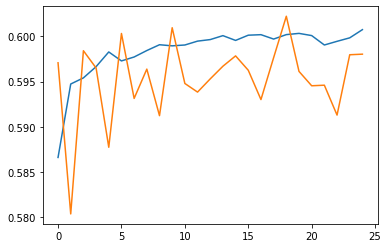

In [10]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [11]:
train_eval_result = model.evaluate(dict(train_df), train_df['Sentiment'])
validation_eval_result = model.evaluate(dict(validation_df), validation_df['Sentiment'])

print(f"Training set accuracy: {train_eval_result[1]}")
print(f"Validation set accuracy: {validation_eval_result[1]}")

   1/4385 [..............................] - ETA: 2:35 - loss: 0.7079 - accuracy: 0.6875

  21/4385 [..............................] - ETA: 11s - loss: 0.7259 - accuracy: 0.7247 

  41/4385 [..............................] - ETA: 11s - loss: 0.8008 - accuracy: 0.6875

  61/4385 [..............................] - ETA: 11s - loss: 0.8015 - accuracy: 0.6962

  81/4385 [..............................] - ETA: 10s - loss: 0.8045 - accuracy: 0.6848

 101/4385 [..............................] - ETA: 10s - loss: 0.8098 - accuracy: 0.6804

 121/4385 [..............................] - ETA: 10s - loss: 0.8291 - accuracy: 0.6764

 141/4385 [..............................] - ETA: 10s - loss: 0.8486 - accuracy: 0.6662

 161/4385 [>.............................] - ETA: 10s - loss: 0.8600 - accuracy: 0.6613

 181/4385 [>.............................] - ETA: 10s - loss: 0.8638 - accuracy: 0.6611

 201/4385 [>.............................] - ETA: 10s - loss: 0.8638 - accuracy: 0.6606

 221/4385 [>.............................] - ETA: 10s - loss: 0.8694 - accuracy: 0.6567

 241/4385 [>.............................] - ETA: 10s - loss: 0.8742 - accuracy: 0.6562

 261/4385 [>.............................] - ETA: 10s - loss: 0.8777 - accuracy: 0.6546

 281/4385 [>.............................] - ETA: 10s - loss: 0.8818 - accuracy: 0.6519

 301/4385 [=>............................] - ETA: 10s - loss: 0.8791 - accuracy: 0.6546

 321/4385 [=>............................] - ETA: 10s - loss: 0.8838 - accuracy: 0.6525

 341/4385 [=>............................] - ETA: 10s - loss: 0.8921 - accuracy: 0.6481

 360/4385 [=>............................] - ETA: 10s - loss: 0.8942 - accuracy: 0.6470

 379/4385 [=>............................] - ETA: 10s - loss: 0.8936 - accuracy: 0.6478

 399/4385 [=>............................] - ETA: 10s - loss: 0.8912 - accuracy: 0.6487

 419/4385 [=>............................] - ETA: 10s - loss: 0.8949 - accuracy: 0.6479

 439/4385 [==>...........................] - ETA: 10s - loss: 0.8956 - accuracy: 0.6468

 459/4385 [==>...........................] - ETA: 10s - loss: 0.8955 - accuracy: 0.6455

 479/4385 [==>...........................] - ETA: 10s - loss: 0.8938 - accuracy: 0.6456

 499/4385 [==>...........................] - ETA: 10s - loss: 0.8965 - accuracy: 0.6445

 519/4385 [==>...........................] - ETA: 9s - loss: 0.8987 - accuracy: 0.6444 

 539/4385 [==>...........................] - ETA: 9s - loss: 0.8997 - accuracy: 0.6436

 559/4385 [==>...........................] - ETA: 9s - loss: 0.9012 - accuracy: 0.6435

 579/4385 [==>...........................] - ETA: 9s - loss: 0.9040 - accuracy: 0.6420

 599/4385 [===>..........................] - ETA: 9s - loss: 0.9045 - accuracy: 0.6418

 619/4385 [===>..........................] - ETA: 9s - loss: 0.9025 - accuracy: 0.6421

 639/4385 [===>..........................] - ETA: 9s - loss: 0.9035 - accuracy: 0.6410

 659/4385 [===>..........................] - ETA: 9s - loss: 0.9085 - accuracy: 0.6392

 679/4385 [===>..........................] - ETA: 9s - loss: 0.9103 - accuracy: 0.6389

 699/4385 [===>..........................] - ETA: 9s - loss: 0.9100 - accuracy: 0.6389

 719/4385 [===>..........................] - ETA: 9s - loss: 0.9127 - accuracy: 0.6380

 739/4385 [====>.........................] - ETA: 9s - loss: 0.9127 - accuracy: 0.6374

 759/4385 [====>.........................] - ETA: 9s - loss: 0.9146 - accuracy: 0.6369

 779/4385 [====>.........................] - ETA: 9s - loss: 0.9144 - accuracy: 0.6365

 799/4385 [====>.........................] - ETA: 9s - loss: 0.9161 - accuracy: 0.6351

 819/4385 [====>.........................] - ETA: 9s - loss: 0.9166 - accuracy: 0.6355

 839/4385 [====>.........................] - ETA: 9s - loss: 0.9170 - accuracy: 0.6352

 859/4385 [====>.........................] - ETA: 9s - loss: 0.9207 - accuracy: 0.6332

 879/4385 [=====>........................] - ETA: 9s - loss: 0.9222 - accuracy: 0.6326

 899/4385 [=====>........................] - ETA: 8s - loss: 0.9250 - accuracy: 0.6309

 919/4385 [=====>........................] - ETA: 8s - loss: 0.9271 - accuracy: 0.6304

 939/4385 [=====>........................] - ETA: 8s - loss: 0.9292 - accuracy: 0.6297

 959/4385 [=====>........................] - ETA: 8s - loss: 0.9311 - accuracy: 0.6287

 979/4385 [=====>........................] - ETA: 8s - loss: 0.9319 - accuracy: 0.6280

 999/4385 [=====>........................] - ETA: 8s - loss: 0.9323 - accuracy: 0.6274

1019/4385 [=====>........................] - ETA: 8s - loss: 0.9340 - accuracy: 0.6268

1039/4385 [======>.......................] - ETA: 8s - loss: 0.9360 - accuracy: 0.6261

1059/4385 [======>.......................] - ETA: 8s - loss: 0.9363 - accuracy: 0.6259

1079/4385 [======>.......................] - ETA: 8s - loss: 0.9356 - accuracy: 0.6261

1099/4385 [======>.......................] - ETA: 8s - loss: 0.9368 - accuracy: 0.6257

1119/4385 [======>.......................] - ETA: 8s - loss: 0.9371 - accuracy: 0.6252

1139/4385 [======>.......................] - ETA: 8s - loss: 0.9394 - accuracy: 0.6244

1159/4385 [======>.......................] - ETA: 8s - loss: 0.9390 - accuracy: 0.6245

1179/4385 [=======>......................] - ETA: 8s - loss: 0.9392 - accuracy: 0.6242

1199/4385 [=======>......................] - ETA: 8s - loss: 0.9398 - accuracy: 0.6246

1219/4385 [=======>......................] - ETA: 8s - loss: 0.9402 - accuracy: 0.6245

1239/4385 [=======>......................] - ETA: 8s - loss: 0.9403 - accuracy: 0.6244

1259/4385 [=======>......................] - ETA: 8s - loss: 0.9400 - accuracy: 0.6247

1279/4385 [=======>......................] - ETA: 7s - loss: 0.9391 - accuracy: 0.6252

1299/4385 [=======>......................] - ETA: 7s - loss: 0.9418 - accuracy: 0.6239

1319/4385 [========>.....................] - ETA: 7s - loss: 0.9431 - accuracy: 0.6230

1339/4385 [========>.....................] - ETA: 7s - loss: 0.9432 - accuracy: 0.6229

1359/4385 [========>.....................] - ETA: 7s - loss: 0.9433 - accuracy: 0.6227

1379/4385 [========>.....................] - ETA: 7s - loss: 0.9440 - accuracy: 0.6226

1399/4385 [========>.....................] - ETA: 7s - loss: 0.9440 - accuracy: 0.6224

1419/4385 [========>.....................] - ETA: 7s - loss: 0.9442 - accuracy: 0.6221

1439/4385 [========>.....................] - ETA: 7s - loss: 0.9440 - accuracy: 0.6221

1459/4385 [========>.....................] - ETA: 7s - loss: 0.9447 - accuracy: 0.6216

1479/4385 [=========>....................] - ETA: 7s - loss: 0.9456 - accuracy: 0.6210

1499/4385 [=========>....................] - ETA: 7s - loss: 0.9462 - accuracy: 0.6208

1519/4385 [=========>....................] - ETA: 7s - loss: 0.9469 - accuracy: 0.6203

1538/4385 [=========>....................] - ETA: 7s - loss: 0.9477 - accuracy: 0.6198

1558/4385 [=========>....................] - ETA: 7s - loss: 0.9478 - accuracy: 0.6195

1578/4385 [=========>....................] - ETA: 7s - loss: 0.9480 - accuracy: 0.6194

1598/4385 [=========>....................] - ETA: 7s - loss: 0.9481 - accuracy: 0.6193

1618/4385 [==========>...................] - ETA: 7s - loss: 0.9492 - accuracy: 0.6191

1638/4385 [==========>...................] - ETA: 7s - loss: 0.9500 - accuracy: 0.6185

1658/4385 [==========>...................] - ETA: 7s - loss: 0.9506 - accuracy: 0.6186

1678/4385 [==========>...................] - ETA: 6s - loss: 0.9508 - accuracy: 0.6185

1698/4385 [==========>...................] - ETA: 6s - loss: 0.9517 - accuracy: 0.6182

1718/4385 [==========>...................] - ETA: 6s - loss: 0.9525 - accuracy: 0.6179

1737/4385 [==========>...................] - ETA: 6s - loss: 0.9531 - accuracy: 0.6174

1757/4385 [===========>..................] - ETA: 6s - loss: 0.9530 - accuracy: 0.6174

1777/4385 [===========>..................] - ETA: 6s - loss: 0.9542 - accuracy: 0.6169

1797/4385 [===========>..................] - ETA: 6s - loss: 0.9542 - accuracy: 0.6171

1817/4385 [===========>..................] - ETA: 6s - loss: 0.9544 - accuracy: 0.6169

1837/4385 [===========>..................] - ETA: 6s - loss: 0.9548 - accuracy: 0.6166

1857/4385 [===========>..................] - ETA: 6s - loss: 0.9547 - accuracy: 0.6164

1877/4385 [===========>..................] - ETA: 6s - loss: 0.9549 - accuracy: 0.6165

1897/4385 [===========>..................] - ETA: 6s - loss: 0.9553 - accuracy: 0.6164

1917/4385 [============>.................] - ETA: 6s - loss: 0.9550 - accuracy: 0.6162

1937/4385 [============>.................] - ETA: 6s - loss: 0.9547 - accuracy: 0.6163

1957/4385 [============>.................] - ETA: 6s - loss: 0.9546 - accuracy: 0.6164

1977/4385 [============>.................] - ETA: 6s - loss: 0.9552 - accuracy: 0.6163

1997/4385 [============>.................] - ETA: 6s - loss: 0.9558 - accuracy: 0.6161

2017/4385 [============>.................] - ETA: 6s - loss: 0.9561 - accuracy: 0.6156

2036/4385 [============>.................] - ETA: 6s - loss: 0.9569 - accuracy: 0.6151

2054/4385 [=============>................] - ETA: 6s - loss: 0.9577 - accuracy: 0.6147

2073/4385 [=============>................] - ETA: 5s - loss: 0.9592 - accuracy: 0.6140

2093/4385 [=============>................] - ETA: 5s - loss: 0.9603 - accuracy: 0.6135

2113/4385 [=============>................] - ETA: 5s - loss: 0.9610 - accuracy: 0.6132

2133/4385 [=============>................] - ETA: 5s - loss: 0.9609 - accuracy: 0.6131

2153/4385 [=============>................] - ETA: 5s - loss: 0.9611 - accuracy: 0.6129

2173/4385 [=============>................] - ETA: 5s - loss: 0.9615 - accuracy: 0.6125

2193/4385 [==============>...............] - ETA: 5s - loss: 0.9618 - accuracy: 0.6125

2213/4385 [==============>...............] - ETA: 5s - loss: 0.9625 - accuracy: 0.6123

2233/4385 [==============>...............] - ETA: 5s - loss: 0.9624 - accuracy: 0.6123

2253/4385 [==============>...............] - ETA: 5s - loss: 0.9623 - accuracy: 0.6124

2273/4385 [==============>...............] - ETA: 5s - loss: 0.9625 - accuracy: 0.6125

2293/4385 [==============>...............] - ETA: 5s - loss: 0.9630 - accuracy: 0.6125

2313/4385 [==============>...............] - ETA: 5s - loss: 0.9630 - accuracy: 0.6125

2332/4385 [==============>...............] - ETA: 5s - loss: 0.9628 - accuracy: 0.6127

2352/4385 [===============>..............] - ETA: 5s - loss: 0.9636 - accuracy: 0.6122

2371/4385 [===============>..............] - ETA: 5s - loss: 0.9639 - accuracy: 0.6120

2391/4385 [===============>..............] - ETA: 5s - loss: 0.9638 - accuracy: 0.6122

2410/4385 [===============>..............] - ETA: 5s - loss: 0.9644 - accuracy: 0.6119

2430/4385 [===============>..............] - ETA: 5s - loss: 0.9641 - accuracy: 0.6120

2450/4385 [===============>..............] - ETA: 4s - loss: 0.9638 - accuracy: 0.6123

2470/4385 [===============>..............] - ETA: 4s - loss: 0.9637 - accuracy: 0.6124

2490/4385 [================>.............] - ETA: 4s - loss: 0.9639 - accuracy: 0.6122

2509/4385 [================>.............] - ETA: 4s - loss: 0.9638 - accuracy: 0.6122

2528/4385 [================>.............] - ETA: 4s - loss: 0.9640 - accuracy: 0.6121

2547/4385 [================>.............] - ETA: 4s - loss: 0.9641 - accuracy: 0.6120

2566/4385 [================>.............] - ETA: 4s - loss: 0.9637 - accuracy: 0.6121

2584/4385 [================>.............] - ETA: 4s - loss: 0.9636 - accuracy: 0.6121

2602/4385 [================>.............] - ETA: 4s - loss: 0.9637 - accuracy: 0.6121

2621/4385 [================>.............] - ETA: 4s - loss: 0.9635 - accuracy: 0.6120

2640/4385 [=================>............] - ETA: 4s - loss: 0.9643 - accuracy: 0.6118

2659/4385 [=================>............] - ETA: 4s - loss: 0.9652 - accuracy: 0.6114

2678/4385 [=================>............] - ETA: 4s - loss: 0.9653 - accuracy: 0.6112

2698/4385 [=================>............] - ETA: 4s - loss: 0.9655 - accuracy: 0.6109

2718/4385 [=================>............] - ETA: 4s - loss: 0.9658 - accuracy: 0.6109

2738/4385 [=================>............] - ETA: 4s - loss: 0.9654 - accuracy: 0.6110

2758/4385 [=================>............] - ETA: 4s - loss: 0.9655 - accuracy: 0.6107

2778/4385 [==================>...........] - ETA: 4s - loss: 0.9658 - accuracy: 0.6104

2798/4385 [==================>...........] - ETA: 4s - loss: 0.9658 - accuracy: 0.6104

2818/4385 [==================>...........] - ETA: 4s - loss: 0.9663 - accuracy: 0.6102

2838/4385 [==================>...........] - ETA: 4s - loss: 0.9670 - accuracy: 0.6099

2857/4385 [==================>...........] - ETA: 3s - loss: 0.9671 - accuracy: 0.6099

2877/4385 [==================>...........] - ETA: 3s - loss: 0.9669 - accuracy: 0.6100

2896/4385 [==================>...........] - ETA: 3s - loss: 0.9671 - accuracy: 0.6101

2915/4385 [==================>...........] - ETA: 3s - loss: 0.9675 - accuracy: 0.6099

2935/4385 [===================>..........] - ETA: 3s - loss: 0.9678 - accuracy: 0.6099

2955/4385 [===================>..........] - ETA: 3s - loss: 0.9672 - accuracy: 0.6100

2975/4385 [===================>..........] - ETA: 3s - loss: 0.9670 - accuracy: 0.6103

2995/4385 [===================>..........] - ETA: 3s - loss: 0.9672 - accuracy: 0.6102

3015/4385 [===================>..........] - ETA: 3s - loss: 0.9671 - accuracy: 0.6103

3035/4385 [===================>..........] - ETA: 3s - loss: 0.9673 - accuracy: 0.6102

3055/4385 [===================>..........] - ETA: 3s - loss: 0.9680 - accuracy: 0.6099

3074/4385 [====================>.........] - ETA: 3s - loss: 0.9681 - accuracy: 0.6097

3094/4385 [====================>.........] - ETA: 3s - loss: 0.9685 - accuracy: 0.6094

3114/4385 [====================>.........] - ETA: 3s - loss: 0.9693 - accuracy: 0.6090

3134/4385 [====================>.........] - ETA: 3s - loss: 0.9693 - accuracy: 0.6090

3154/4385 [====================>.........] - ETA: 3s - loss: 0.9694 - accuracy: 0.6088

3174/4385 [====================>.........] - ETA: 3s - loss: 0.9702 - accuracy: 0.6085

3194/4385 [====================>.........] - ETA: 3s - loss: 0.9704 - accuracy: 0.6084

3214/4385 [====================>.........] - ETA: 3s - loss: 0.9705 - accuracy: 0.6082

3233/4385 [=====================>........] - ETA: 2s - loss: 0.9708 - accuracy: 0.6079

3252/4385 [=====================>........] - ETA: 2s - loss: 0.9714 - accuracy: 0.6076

3271/4385 [=====================>........] - ETA: 2s - loss: 0.9716 - accuracy: 0.6075

3291/4385 [=====================>........] - ETA: 2s - loss: 0.9719 - accuracy: 0.6075

3312/4385 [=====================>........] - ETA: 2s - loss: 0.9719 - accuracy: 0.6074

3332/4385 [=====================>........] - ETA: 2s - loss: 0.9721 - accuracy: 0.6073

3352/4385 [=====================>........] - ETA: 2s - loss: 0.9726 - accuracy: 0.6071

3372/4385 [======================>.......] - ETA: 2s - loss: 0.9730 - accuracy: 0.6070

3392/4385 [======================>.......] - ETA: 2s - loss: 0.9732 - accuracy: 0.6067

3412/4385 [======================>.......] - ETA: 2s - loss: 0.9733 - accuracy: 0.6067

3432/4385 [======================>.......] - ETA: 2s - loss: 0.9734 - accuracy: 0.6067

3452/4385 [======================>.......] - ETA: 2s - loss: 0.9735 - accuracy: 0.6066

3472/4385 [======================>.......] - ETA: 2s - loss: 0.9740 - accuracy: 0.6064

3492/4385 [======================>.......] - ETA: 2s - loss: 0.9741 - accuracy: 0.6062

3512/4385 [=======================>......] - ETA: 2s - loss: 0.9744 - accuracy: 0.6061

3532/4385 [=======================>......] - ETA: 2s - loss: 0.9744 - accuracy: 0.6060

3552/4385 [=======================>......] - ETA: 2s - loss: 0.9754 - accuracy: 0.6056

3572/4385 [=======================>......] - ETA: 2s - loss: 0.9761 - accuracy: 0.6054

3592/4385 [=======================>......] - ETA: 2s - loss: 0.9765 - accuracy: 0.6053

3612/4385 [=======================>......] - ETA: 1s - loss: 0.9766 - accuracy: 0.6052

3632/4385 [=======================>......] - ETA: 1s - loss: 0.9767 - accuracy: 0.6051

3652/4385 [=======================>......] - ETA: 1s - loss: 0.9769 - accuracy: 0.6050

3672/4385 [========================>.....] - ETA: 1s - loss: 0.9769 - accuracy: 0.6052

3692/4385 [========================>.....] - ETA: 1s - loss: 0.9770 - accuracy: 0.6052

3712/4385 [========================>.....] - ETA: 1s - loss: 0.9768 - accuracy: 0.6053

3732/4385 [========================>.....] - ETA: 1s - loss: 0.9777 - accuracy: 0.6049

3752/4385 [========================>.....] - ETA: 1s - loss: 0.9778 - accuracy: 0.6050

3772/4385 [========================>.....] - ETA: 1s - loss: 0.9776 - accuracy: 0.6050

3792/4385 [========================>.....] - ETA: 1s - loss: 0.9773 - accuracy: 0.6051

3812/4385 [=========================>....] - ETA: 1s - loss: 0.9774 - accuracy: 0.6049

3832/4385 [=========================>....] - ETA: 1s - loss: 0.9775 - accuracy: 0.6050

3852/4385 [=========================>....] - ETA: 1s - loss: 0.9778 - accuracy: 0.6047

3872/4385 [=========================>....] - ETA: 1s - loss: 0.9780 - accuracy: 0.6046

3893/4385 [=========================>....] - ETA: 1s - loss: 0.9785 - accuracy: 0.6046

3914/4385 [=========================>....] - ETA: 1s - loss: 0.9784 - accuracy: 0.6046

3934/4385 [=========================>....] - ETA: 1s - loss: 0.9784 - accuracy: 0.6046

3954/4385 [==========================>...] - ETA: 1s - loss: 0.9789 - accuracy: 0.6044

3974/4385 [==========================>...] - ETA: 1s - loss: 0.9794 - accuracy: 0.6041

3994/4385 [==========================>...] - ETA: 1s - loss: 0.9794 - accuracy: 0.6040

4014/4385 [==========================>...] - ETA: 0s - loss: 0.9802 - accuracy: 0.6035

4034/4385 [==========================>...] - ETA: 0s - loss: 0.9802 - accuracy: 0.6036

4054/4385 [==========================>...] - ETA: 0s - loss: 0.9803 - accuracy: 0.6035

4073/4385 [==========================>...] - ETA: 0s - loss: 0.9802 - accuracy: 0.6036

4092/4385 [==========================>...] - ETA: 0s - loss: 0.9799 - accuracy: 0.6037

4111/4385 [===========================>..] - ETA: 0s - loss: 0.9798 - accuracy: 0.6037

4130/4385 [===========================>..] - ETA: 0s - loss: 0.9801 - accuracy: 0.6036

4149/4385 [===========================>..] - ETA: 0s - loss: 0.9805 - accuracy: 0.6034

4168/4385 [===========================>..] - ETA: 0s - loss: 0.9810 - accuracy: 0.6032

4188/4385 [===========================>..] - ETA: 0s - loss: 0.9815 - accuracy: 0.6029

4208/4385 [===========================>..] - ETA: 0s - loss: 0.9814 - accuracy: 0.6029

4227/4385 [===========================>..] - ETA: 0s - loss: 0.9818 - accuracy: 0.6027

4247/4385 [============================>.] - ETA: 0s - loss: 0.9820 - accuracy: 0.6026

4267/4385 [============================>.] - ETA: 0s - loss: 0.9823 - accuracy: 0.6024

4287/4385 [============================>.] - ETA: 0s - loss: 0.9824 - accuracy: 0.6024

4307/4385 [============================>.] - ETA: 0s - loss: 0.9824 - accuracy: 0.6023

4327/4385 [============================>.] - ETA: 0s - loss: 0.9823 - accuracy: 0.6023

4347/4385 [============================>.] - ETA: 0s - loss: 0.9828 - accuracy: 0.6021

4367/4385 [============================>.] - ETA: 0s - loss: 0.9829 - accuracy: 0.6021

4385/4385 [==============================] - 11s 3ms/step - loss: 0.9828 - accuracy: 0.6021


  1/493 [..............................] - ETA: 13s - loss: 0.9097 - accuracy: 0.5938

 25/493 [>.............................] - ETA: 0s - loss: 0.9607 - accuracy: 0.6175 

 49/493 [=>............................] - ETA: 0s - loss: 0.9473 - accuracy: 0.6097

 74/493 [===>..........................] - ETA: 0s - loss: 0.9289 - accuracy: 0.6178

 98/493 [====>.........................] - ETA: 0s - loss: 0.9152 - accuracy: 0.6240

122/493 [======>.......................] - ETA: 0s - loss: 0.9317 - accuracy: 0.6158

146/493 [=======>......................] - ETA: 0s - loss: 0.9333 - accuracy: 0.6182

170/493 [=========>....................] - ETA: 0s - loss: 0.9431 - accuracy: 0.6138

194/493 [==========>...................] - ETA: 0s - loss: 0.9570 - accuracy: 0.6091

218/493 [============>.................] - ETA: 0s - loss: 0.9643 - accuracy: 0.6046

243/493 [=============>................] - ETA: 0s - loss: 0.9648 - accuracy: 0.6042

267/493 [===============>..............] - ETA: 0s - loss: 0.9627 - accuracy: 0.6053

291/493 [================>.............] - ETA: 0s - loss: 0.9647 - accuracy: 0.6045

315/493 [==================>...........] - ETA: 0s - loss: 0.9675 - accuracy: 0.6031

337/493 [===================>..........] - ETA: 0s - loss: 0.9684 - accuracy: 0.6038

360/493 [====================>.........] - ETA: 0s - loss: 0.9666 - accuracy: 0.6030

383/493 [======================>.......] - ETA: 0s - loss: 0.9687 - accuracy: 0.6013

406/493 [=======================>......] - ETA: 0s - loss: 0.9706 - accuracy: 0.6018

430/493 [=========================>....] - ETA: 0s - loss: 0.9718 - accuracy: 0.6015

454/493 [==========================>...] - ETA: 0s - loss: 0.9736 - accuracy: 0.5998

478/493 [============================>.] - ETA: 0s - loss: 0.9778 - accuracy: 0.5977

493/493 [==============================] - 1s 2ms/step - loss: 0.9775 - accuracy: 0.5980


Training set accuracy: 0.6020953059196472
Validation set accuracy: 0.5980311036109924


## Confusion matrix

Another very interesting statistic, especially for multiclass problems, is the [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix). The confusion matrix allows visualization of the proportion of correctly and incorrectly labelled examples. We can easily see how much our classifier is biased and whether the distribution of labels makes sense. Ideally the largest fraction of predictions should be distributed along the diagonal.

In [12]:
predictions = model.predict(dict(validation_df))
predictions = tf.argmax(predictions, axis=-1)
predictions

  1/493 [..............................] - ETA: 47s

 34/493 [=>............................] - ETA: 0s 

 68/493 [===>..........................] - ETA: 0s

101/493 [=====>........................] - ETA: 0s

134/493 [=======>......................] - ETA: 0s

167/493 [=========>....................] - ETA: 0s

200/493 [===========>..................] - ETA: 0s

234/493 [=============>................] - ETA: 0s

268/493 [===============>..............] - ETA: 0s

301/493 [=================>............] - ETA: 0s

333/493 [===================>..........] - ETA: 0s

366/493 [=====================>........] - ETA: 0s

398/493 [=======================>......] - ETA: 0s

429/493 [=========================>....] - ETA: 0s

461/493 [===========================>..] - ETA: 0s

493/493 [==============================] - 1s 2ms/step


<tf.Tensor: shape=(15745,), dtype=int64, numpy=array([1, 1, 2, ..., 2, 2, 2])>

In [13]:
cm = tf.math.confusion_matrix(validation_df['Sentiment'], predictions)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

Text(32.99999999999999, 0.5, 'True')

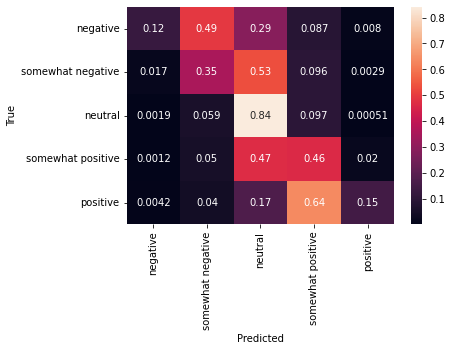

In [14]:
sns.heatmap(
    cm, annot=True,
    xticklabels=SENTIMENT_LABELS,
    yticklabels=SENTIMENT_LABELS)
plt.xlabel("Predicted")
plt.ylabel("True")

We can easily submit the predictions back to Kaggle by pasting the following code to a code cell and executing it:

``` python
test_predictions = model.predict(dict(test_df))
test_predictions = np.argmax(test_predictions, axis=-1)

result_df = test_df.copy()

result_df["Predictions"] = test_predictions

result_df.to_csv(
    "predictions.csv",
    columns=["Predictions"],
    header=["Sentiment"])
kaggle.api.competition_submit("predictions.csv", "Submitted from Colab",
                              "sentiment-analysis-on-movie-reviews")
```


After submitting, [check the leaderboard](https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews/leaderboard) to see how you did.